In [1]:
import math
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, namedtuple
import os
import subprocess
from tqdm import trange
from copy import deepcopy

# from dirichlet_actor_critic import Policy
# from env_two_step import Scenario, AMoD
from util import mat2str, dictsum, moving_average

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Dirichlet

plt.style.use('ggplot')
CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [16]:
# -*- coding: utf-8 -*-
"""
Created on Wed Aug  5 22:09:46 2020
@author: yangk
"""
from collections import defaultdict
import numpy as np
import subprocess
import os
import networkx as nx
from util import mat2str
from copy import deepcopy

class AMoD:
    # initialization
    def __init__(self, scenario, beta=0.2): # updated to take scenario and beta (cost for rebalancing) as input
        self.scenario = deepcopy(scenario) # I changed it to deep copy so that the scenario input is not modified by env 
        self.G = scenario.G # Road Graph: node - region, edge - connection of regions, node attr: 'accInit', edge attr: 'time'
        self.time = 0 # current time
        self.T = scenario.T # planning time
        self.tf = scenario.tf # final time
        self.demand = defaultdict(dict) # demand
        self.price = defaultdict(dict) # price
        for i,j,t,d,p in scenario.tripAttr: # trip attribute (origin, destination, time of request, demand, price)
            self.demand[i,j][t] = d
            self.price[i,j][t] = p
        self.acc = defaultdict(dict) # number of vehicles within each region, key: i - region, t - time
        self.dacc = defaultdict(dict) # number of vehicles arriving at each region, key: i - region, t - time
        self.rebFlow = defaultdict(dict) # number of rebalancing vehicles, key: (i,j) - (origin, destination), t - time
        self.paxFlow = defaultdict(dict) # number of vehicles with passengers, key: (i,j) - (origin, destination), t - time
        self.edges = [] # set of rebalancing edges
        self.nregion = len(scenario.G) # number of regions
        for i in self.G:
            self.edges.append((i,i))
            for e in self.G.out_edges(i):
                self.edges.append(e)
                self.region = list(self.G) # set of regions
        self.nedge = [len(self.G.out_edges(n))+1 for n in self.region] # number of edges leaving each region        
        for i,j in self.G.edges:
            self.rebFlow[i,j] = defaultdict(float)
            self.paxFlow[i,j] = defaultdict(float)            
        for n in self.region:
            self.acc[n][0] = self.G.nodes[n]['accInit']
            self.dacc[n] = defaultdict(float)   
        self.beta = beta
        t = self.time
        self.servedDemand = defaultdict(float)
        for i,j in self.demand:
            self.servedDemand[i,j] = defaultdict(float)
        
        self.N = len(self.region) # total number of cells
        
        # add the initialization of info here
        self.info = dict.fromkeys(['revenue', 'served_demand', 'rebalancing_cost', 'operating_cost'], 0)
        self.reward = 0
        # observation: current vehicle distribution, time, future arrivals, demand        
        self.obs = (self.acc, self.time, self.dacc, self.demand)

    def matching(self, CPLEXPATH=None, PATH=''):
        t = self.time
        demandAttr = [(i,j,self.demand[i,j][t], self.price[i,j][t]) for i,j in self.demand \
                      if self.demand[i,j][t]>1e-3]
        accTuple = [(n,self.acc[n][t+1]) for n in self.acc]
        modPath = os.getcwd().replace('\\','/')+'/mod/'
        matchingPath = os.getcwd().replace('\\','/')+'/matching/'+PATH
        if not os.path.exists(matchingPath):
            os.makedirs(matchingPath)
        datafile = matchingPath + 'data_{}.dat'.format(t)
        resfile = matchingPath + 'res_{}.dat'.format(t)
        with open(datafile,'w') as file:
            file.write('path="'+resfile+'";\r\n')
            file.write('demandAttr='+mat2str(demandAttr)+';\r\n')
            file.write('accInitTuple='+mat2str(accTuple)+';\r\n')
        modfile = modPath+'matching.mod'
        if CPLEXPATH is None:
            CPLEXPATH = "C:/Program Files/ibm/ILOG/CPLEX_Studio1210/opl/bin/x64_win64/"
        my_env = os.environ.copy()
        my_env["LD_LIBRARY_PATH"] = CPLEXPATH
        out_file =  matchingPath + 'out_{}.dat'.format(t)
        with open(out_file,'w') as output_f:
            subprocess.check_call([CPLEXPATH+"oplrun", modfile,datafile],stdout=output_f,env=my_env)
        output_f.close()
        flow = defaultdict(float)
        with open(resfile,'r', encoding="utf8") as file:
            for row in file:
                item = row.replace('e)',')').strip().strip(';').split('=')
                if item[0] == 'flow':
                    values = item[1].strip(')]').strip('[(').split(')(')
                    for v in values:
                        if len(v) == 0:
                            continue
                        i,j,f = v.split(',')
                        flow[int(i),int(j)] = float(f)
        paxAction = [flow[i,j] if (i,j) in flow else 0 for i,j in self.edges]
        return paxAction

    # pax step
    def pax_step(self, paxAction=None, CPLEXPATH=None, PATH=''):
        t = self.time
        self.reward = 0
        for i in self.region:
            self.acc[i][t+1] = self.acc[i][t]
        self.info['served_demand'] = 0 # initialize served demand
        self.info["operating_cost"] = 0 # initialize operating cost
        self.info['revenue'] = 0
        self.info['rebalancing_cost'] = 0
        if paxAction is None:  # default matching algorithm used if isMatching is True, matching method will need the information of self.acc[t+1], therefore this part cannot be put forward
            paxAction = self.matching(CPLEXPATH=CPLEXPATH, PATH=PATH)
        self.paxAction = paxAction
        # serving passengers
        for k in range(len(self.edges)):
            i,j = self.edges[k]    
            if (i,j) not in self.G.edges:
                continue
            # I moved the min operator above, since we want paxFlow to be consistent with paxAction
            self.paxAction[k] = min(self.acc[i][t+1], paxAction[k])            
            self.servedDemand[i,j][t] = self.paxAction[k]
            self.paxFlow[i,j][t+self.G.edges[i,j]['time']] = self.paxAction[k]
            self.info["operating_cost"] += self.G.edges[i,j]['time']*self.beta*self.paxAction[k]
            self.acc[i][t+1] -= self.paxAction[k]
            self.info['served_demand'] += self.servedDemand[i,j][t]            
            self.dacc[j][t+self.G.edges[i,j]['time']] += self.paxFlow[i,j][t+self.G.edges[i,j]['time']]
            self.reward += self.paxAction[k]*(self.price[i,j][t] - self.G.edges[i,j]['time']*self.beta)            
            self.info['revenue'] += self.paxAction[k]*(self.price[i,j][t])  
        
        self.obs = (self.acc, self.time, self.dacc, self.demand) # for acc, the time index would be t+1, but for demand, the time index would be t
        done = False # if passenger matching is executed first
        return self.obs, max(0,self.reward), done, self.info
    
    # reb step
    def reb_step(self, rebAction):
        t = self.time
        self.reward = 0 # reward is calculated from before this to the next rebalancing, we may also have two rewards, one for pax matching and one for rebalancing
        self.rebAction = rebAction      
        # rebalancing
        for k in range(len(self.edges)):
            i,j = self.edges[k]    
            if (i,j) not in self.G.edges:
                continue
            # TODO: add check for actions respecting constraints? e.g. sum of all action[k] starting in "i" <= self.acc[i][t+1] (in addition to our agent action method)
            # update the number of vehicles
            self.rebAction[k] = min(self.acc[i][t+1], rebAction[k]) 
            self.rebFlow[i,j][t+self.G.edges[i,j]['time']] = self.rebAction[k]     
            self.acc[i][t+1] -= self.rebAction[k] 
            self.dacc[j][t+self.G.edges[i,j]['time']] += self.rebFlow[i,j][t+self.G.edges[i,j]['time']]   
            self.info['rebalancing_cost'] += self.G.edges[i,j]['time']*self.beta*self.rebAction[k]
            self.info["operating_cost"] += self.G.edges[i,j]['time']*self.beta*self.rebAction[k]
            self.reward -= self.G.edges[i,j]['time']*self.beta*self.rebAction[k]
        # arrival for the next time step, executed in the last state of a time step
        # this makes the code slightly different from the previous version, where the following codes are executed between matching and rebalancing        
        for k in range(len(self.edges)):
            i,j = self.edges[k]    
            if (i,j) not in self.G.edges:
                continue
            self.acc[j][t+1] += self.rebFlow[i,j][t]
            self.acc[j][t+1] += self.paxFlow[i,j][t] # this means that after pax arrived, vehicles can only be rebalanced in the next time step, let me know if you have different opinion
            
        self.time += 1
        self.obs = (self.acc, self.time, self.dacc, self.demand) # use self.time to index the next time step
        
        done = (self.tf == t+1) # if the episode is completed
        return self.obs, self.reward, done, self.info
    
    def reset(self):
        # reset the episode
        self.acc = defaultdict(dict)
        self.dacc = defaultdict(dict)
        self.rebFlow = defaultdict(dict)
        self.paxFlow = defaultdict(dict)
        self.edges = []
        for i in self.G:
            self.edges.append((i,i))
            for e in self.G.out_edges(i):
                self.edges.append(e)
        
        self.demand = defaultdict(dict) # demand
        self.price = defaultdict(dict) # price
        tripAttr = self.scenario.get_random_demand(reset=True)
        for i,j,t,d,p in tripAttr: # trip attribute (origin, destination, time of request, demand, price)
            self.demand[i,j][t] = d
            self.price[i,j][t] = p
            
        self.time = 0
        for i,j in self.G.edges:
            self.rebFlow[i,j] = defaultdict(float)
            self.paxFlow[i,j] = defaultdict(float)            
        for n in self.G:
            self.acc[n][0] = self.G.nodes[n]['accInit']
            self.dacc[n] = defaultdict(float) 
        t = self.time
        for i,j in self.demand:
            self.servedDemand[i,j] = defaultdict(float)
         # TODO: define states here
        self.obs = (self.acc, self.time, self.dacc, self.demand)      
        self.reward = 0
        return self.obs
    
    def MPC_exact(self, CPLEXPATH=None):
        t = self.time
        demandAttr = [(i,j,tt,self.demand[i,j][tt], self.price[i,j][tt]) for i,j in self.demand for tt in range(t,t+self.T) if self.demand[i,j][tt]>1e-3]
        accTuple = [(n,self.acc[n][t]) for n in self.acc]
        daccTuple = [(n,tt,self.dacc[n][tt]) for n in self.acc for tt in range(t,t+self.T)]
        edgeAttr = [(i,j,self.G.edges[i,j]['time']) for i,j in self.G.edges]
        modPath = os.getcwd().replace('\\','/')+'/mod/'
        MPCPath = os.getcwd().replace('\\','/')+'/MPC/'
        if not os.path.exists(MPCPath):
            os.makedirs(MPCPath)
        datafile = MPCPath + 'data_{}.dat'.format(t)
        resfile = MPCPath + 'res_{}.dat'.format(t)
        with open(datafile,'w') as file:
            file.write('path="'+resfile+'";\r\n')
            file.write('t0='+str(t)+';\r\n')
            file.write('T='+str(self.T)+';\r\n')
            file.write('beta='+str(self.beta)+';\r\n')
            file.write('demandAttr='+mat2str(demandAttr)+';\r\n')
            file.write('edgeAttr='+mat2str(edgeAttr)+';\r\n')
            file.write('accInitTuple='+mat2str(accTuple)+';\r\n')
            file.write('daccAttr='+mat2str(daccTuple)+';\r\n')
            
        modfile = modPath+'MPC.mod'
        if CPLEXPATH is None:
            CPLEXPATH = "C:/Program Files/ibm/ILOG/CPLEX_Studio1210/opl/bin/x64_win64/"
        my_env = os.environ.copy()
        my_env["LD_LIBRARY_PATH"] = CPLEXPATH
        out_file =  MPCPath + 'out_{}.dat'.format(t)
        with open(out_file,'w') as output_f:
            subprocess.check_call([CPLEXPATH+"oplrun", modfile,datafile],stdout=output_f,env=my_env)
        output_f.close()
        paxFlow = defaultdict(float)
        rebFlow = defaultdict(float)
        with open(resfile,'r', encoding="utf8") as file:
            for row in file:
                item = row.replace('e)',')').strip().strip(';').split('=')
                if item[0] == 'flow':
                    values = item[1].strip(')]').strip('[(').split(')(')
                    for v in values:
                        if len(v) == 0:
                            continue
                        i,j,f1,f2 = v.split(',')
                        paxFlow[int(i),int(j)] = float(f1)
                        rebFlow[int(i),int(j)] = float(f2)
        paxAction = [paxFlow[i,j] if (i,j) in paxFlow else 0 for i,j in self.edges]
        rebAction = [rebFlow[i,j] if (i,j) in rebFlow else 0 for i,j in self.edges]
        return paxAction,rebAction
    
    
    
class Scenario:
    def __init__(self, N1=2, N2=4, tf=60, T=10, sd=None, ninit=5, tripAttr=None, demand_input=None,
                 trip_length_preference = 0.25, grid_travel_time = 1):
        # trip_length_preference: positive - more shorter trips, negative - more longer trips
        # grid_travel_time: travel time between grids
        # demand_input： list - total demand out of each region, 
        #          float/int - total demand out of each region satisfies uniform distribution on [0, demand_input]
        #          dict/defaultdict - total demand between pairs of regions
        # demand_input will be converted to a variable static_demand to represent the demand between each pair of nodes
        # static_demand will then be sampled according to a Poisson distribution
        self.trip_length_preference = trip_length_preference
        self.grid_travel_time = grid_travel_time
        self.demand_input = demand_input
        self.N1 = N1
        self.N2 = N2
        self.G = nx.complete_graph(N1*N2)
        self.G = self.G.to_directed()
        for i,j in self.G.edges:
            self.G.edges[i,j]['time'] = (abs(i//N1-j//N1) + abs(i%N1-j%N1))*grid_travel_time
        for n in self.G.nodes:
            self.G.nodes[n]['accInit'] = ninit
        self.tf = tf
        self.sd = sd
        if sd != None:
            np.random.seed(self.sd)
        self.T = T
        if tripAttr != None: # given demand as a defaultdict(dict)
            self.tripAttr = deepcopy(tripAttr)
        else:
            self.tripAttr = self.get_random_demand() # randomly generated demand
    
    def get_random_demand(self, reset = False):        
        # generate demand and price
        # reset = True means that the function is called in the reset() method of AMoD enviroment,
        #   assuming static demand is already generated
        # reset = False means that the function is called when initializing the demand
        
        demand = defaultdict(dict)
        price = defaultdict(dict)        
        tripAttr = []
        
        # default demand
        if self.demand_input == None:
            # generate demand, travel time, and price
            D = dict()
            for i,j in self.G.edges:
                D[i,j] = np.random.rand() * 0.5
                p = min(3,np.random.exponential(2)+1)*self.G.edges[i,j]['time']
                for t in range(0,self.tf+self.T):
                    if t%2 == 0:
                        if (i==0) and (j==7):
                            demand[i,j][t] = np.random.poisson(5)
                        elif (i==6) and (j==1):
                            demand[i,j][t] = np.random.poisson(5)
                        else:
                            demand[i,j][t] = np.random.poisson(D[i,j])
                    else:
                        if (i==7) and (j==0):
                            demand[i,j][t] = np.random.poisson(5)
                        elif (i==1) and (j==6):
                            demand[i,j][t] = np.random.poisson(5)
                        else:
                            demand[i,j][t] = np.random.poisson(D[i,j])
                    price[i,j][t] = p
            tripAttr = []
            for i,j in demand:
                for t in demand[i,j]:
                    tripAttr.append((i,j,t,demand[i,j][t],price[i,j][t]))
            return tripAttr
        
        # converting demand_input to static_demand
        # skip this when resetting the demand
        if not reset:
            self.static_demand = dict()
            if type(self.demand_input) in [float, int, list, np.array]:
                if type(self.demand_input) in [float, int]:            
                    self.region_demand = np.random.rand(len(self.G)) * self.demand_input  
                else:
                    self.region_demand = self.demand_input            
                for i in self.G.nodes:
                    J = [j for _,j in self.G.out_edges(i)]
                    prob = np.array([np.math.exp(-self.G.edges[i,j]['time']*self.trip_length_preference) for j in J])
                    prob = prob/sum(prob)
                    for idx in range(len(J)):
                        self.static_demand[i,J[idx]] = self.region_demand[i] * prob[idx]
            elif type(self.demand_input) in [dict, defaultdict]:
                for i,j in self.G.edges:
                    self.static_demand[i,j] = self.demand_input[i,j] if (i,j) in self.demand_input else self.demand_input['default']
            else:
                raise Exception("demand_input should be number, array-like, or dictionary-like values")
        
        # generating demand and prices
        for i,j in self.G.edges:
            np.random.seed(10)
            p = min(3,np.random.exponential(2)+1)*self.G.edges[i,j]['time']
            for t in range(0,self.tf+self.T):
                np.random.seed()
                demand[i,j][t] = np.random.poisson(self.static_demand[i,j])
                price[i,j][t] = p
                tripAttr.append((i,j,t,demand[i,j][t],price[i,j][t]))

        return tripAttr


In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Dirichlet

class Policy(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self, env):
        super(Policy, self).__init__()
        self.env = env
        
        # initialize affine transformations for neural net
        self.affine1 = nn.Linear(56+16+1, 128)
        self.affine2 = nn.Linear(128, 64)
        self.affine3 = nn.Linear(64, 64)
        self.affine4 = nn.Linear(96, 32)
        self.affine5 = nn.Linear(32, 32)
        
        # initialize GRU cell
        self.rnn = nn.GRU(input_size=16, hidden_size=32, batch_first=True)
        self.h_0 = nn.Parameter(torch.zeros(1, 1, 32))
        
        # actor's layer
        self.action_head = nn.Linear(32, 8)

        # critic's layer
        self.value_head = nn.Linear(32, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, x_ext, x_temp):
        """
        forward of both actor and critic
        """
        x_ext = F.relu(self.affine1(x_ext))
        x_ext = F.relu(self.affine2(x_ext))
        x_ext = F.relu(self.affine3(x_ext))
        
        _, x_temp = self.rnn(x_temp, self.h_0)
        
        h = torch.cat((x_ext.view(1, 64), x_temp.view(1, 32)), dim=1)
        h = F.relu(self.affine4(h))
        h = F.relu(self.affine5(h))
        # actor: choses action to take from state s_t 
        # by returning probability of each action
        action_prob = F.softplus(self.action_head(h)).reshape(-1) + 1e-20

        # critic: evaluates being in the state s_t
        state_values = self.value_head(h).view(-1,)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t 
        return action_prob, state_values
    
    def get_available_vehicles(self):
        """
        Count total number of available vehicles.
        """
        return np.sum([self.env.acc[region][self.env.time] for region in self.env.region])
    
    def get_desired_distribution(self, action_rl):
        """
        Given a RL action, returns the desired number of vehicles in each area.
        """
        v_d = action_rl*self.get_available_vehicles()
        return list(v_d.numpy())


In [18]:
def select_action(state):
    x_ext = state[0]
    x_temp = state[1]
    concentrations, state_value = model(x_ext, x_temp)

    # create a categorical distribution over the list of probabilities of actions
    m = Dirichlet(concentrations)

    # and sample an action using the distribution
    action = m.sample()

    # save to action buffer
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))

    # the action to take (distribution of idle vehicles over cells)
    return list(action.numpy())

def finish_episode():
    """
    Training code. Calculates actor and critic loss and performs backprop.
    """
    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list to save actor (policy) loss
    value_losses = [] # list to save critic (value) loss
    returns = [] # list to save the true values

    # calculate the true value using rewards returned from the environment
    for r in model.rewards[::-1]:
        # calculate the discounted value
        R = r + args.gamma * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate actor (policy) loss 
        policy_losses.append(-log_prob * advantage)

        # calculate critic (value) loss using L1 smooth loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # perform backprop
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(),5.)
    optimizer.step()

    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]

In [19]:
# initialize args
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

args = namedtuple('args', ('render', 'gamma', 'log_interval'))
args.render= True
args.gamma = 0.97
args.log_interval = 10

In [8]:
# build scenario
scenario = Scenario(sd=10,demand_input = {(1,6):2, (0,7):2, 'default':0.1})
env = AMoD(scenario)

In [9]:
# build model + optimizer
model = Policy(env)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
eps = np.finfo(np.float32).eps.item()

### Train model from scratch

In [25]:
# build scenario
scenario = Scenario(sd=10,demand_input = {(1,6):2, (0,7):2, 'default':0.1})
env = AMoD(scenario)

In [26]:
# build model + optimizer
model = Policy(env)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
eps = np.finfo(np.float32).eps.item()

In [ ]:
# book-keeping variables
training_rewards = []
training_revenue = []
training_served_demand = []
training_rebalancing_cost = []
training_operating_cost = []

# last_t_update = 0
train_episodes = 50000 # num_of_episodes_with_same_epsilon x num_of_q_tables x num_epsilons          
max_steps = 100 # maximum length of episode
epochs = trange(train_episodes) # build tqdm iterator for loop visualization

for i_episode in epochs:
    try:
        obs = env.reset()
        episode_reward = 0
        episode_revenue = 0
        episode_served_demand = 0
        episode_rebalancing_cost = 0
        episode_operating_cost = 0
        for step in range(max_steps):
            # take matching step 
            obs, paxreward, done, info = env.pax_step(CPLEXPATH=CPLEXPATH, PATH="AC/v14/")
            episode_reward += paxreward
            # Select and perform an RL action
            x_ext = torch.tensor([obs[0][n][env.time] for n in env.region] + [env.dacc[n][env.time] for n in env.region] + \
                    [env.price[i,j][t] for t in range(env.time, env.time+1) for i,j in env.demand] + [env.time]).float()
            x_temp1 = torch.tensor([np.sum([env.demand[i, j][t] if i!=j else 0 for i in env.region]) for t in range(env.time, env.time+10) for j in env.region]).view(1, 10, 8).float()
            x_temp2 = torch.tensor([np.sum([env.demand[i, j][t] if i!=j else 0 for j in env.region]) for t in range(env.time, env.time+10) for i in env.region]).view(1, 10, 8).float()
            x_temp = torch.cat((x_temp1, x_temp2), dim=2)
            state = (x_ext, x_temp)
            action_rl = select_action(state)

            # 1.2 get actual vehicle distributions vi (i.e. (x1*x2*..*xn)*num_vehicles)
            v_d = model.get_desired_distribution(torch.tensor(action_rl))

            # 1.3 Solve ILP - Minimal Distance Problem 
            # 1.3.1 collect inputs and build .dat file
            t = env.time
            accTuple = [(n,int(env.acc[n][t])) for n in env.acc]
            accRLTuple = [(n, int(v_d_n)) for n, v_d_n in enumerate(v_d)]
            edgeAttr = [(i,j,env.G.edges[i,j]['time']) for i,j in env.G.edges]
            modPath = os.getcwd().replace('\\','/')+'/mod/'
            OPTPath = os.getcwd().replace('\\','/')+'/OPT/AC/v14/'
            if not os.path.exists(OPTPath):
                os.makedirs(OPTPath)
            datafile = OPTPath + f'data_{t}.dat'
            resfile = OPTPath + f'res_{t}.dat'
            with open(datafile,'w') as file:
                file.write('path="'+resfile+'";\r\n')
                file.write('edgeAttr='+mat2str(edgeAttr)+';\r\n')
                file.write('accInitTuple='+mat2str(accTuple)+';\r\n')
                file.write('accRLTuple='+mat2str(accRLTuple)+';\r\n')

            # 2. execute .mod file and write result on file
            modfile = modPath+'minRebDistRebOnly.mod'
            if CPLEXPATH is None:
                CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
            my_env = os.environ.copy()
            my_env["LD_LIBRARY_PATH"] = CPLEXPATH
            out_file =  OPTPath + f'out_{t}.dat'
            with open(out_file,'w') as output_f:
                subprocess.check_call([CPLEXPATH+"oplrun", modfile, datafile], stdout=output_f, env=my_env)
            output_f.close()

            # 3. collect results from file
            flow = defaultdict(float)
            with open(resfile,'r', encoding="utf8") as file:
                for row in file:
                    item = row.strip().strip(';').split('=')
                    if item[0] == 'flow':
                        values = item[1].strip(')]').strip('[(').split(')(')
                        for v in values:
                            if len(v) == 0:
                                continue
                            i,j,f = v.split(',')
                            flow[int(i),int(j)] = float(f)
            rebAction = [flow[i,j] for i,j in env.edges]

            # Take step
            new_obs, rebreward, done, info = env.reb_step(rebAction)
            episode_reward += rebreward
            x_ext = torch.tensor([new_obs[0][n][env.time] for n in env.region] + [env.dacc[n][env.time] for n in env.region] + \
                    [env.price[i,j][t] for t in range(env.time, env.time+1) for i,j in env.demand] + [env.time]).float()
            x_temp1 = torch.tensor([np.sum([env.demand[i, j][t] if i!=j else 0 for i in env.region]) for t in range(env.time, env.time+10) for j in env.region]).view(1, 10, 8).float()
            x_temp2 = torch.tensor([np.sum([env.demand[i, j][t] if i!=j else 0 for j in env.region]) for t in range(env.time, env.time+10) for i in env.region]).view(1, 10, 8).float()
            x_temp = torch.cat((x_temp1, x_temp2), dim=2)
            new_state = (x_ext, x_temp)

            # Store the transition in memory
            model.rewards.append(paxreward + rebreward)

            # Move to the next state
            # track performance over episode
            episode_revenue += info['revenue']
            episode_served_demand += info['served_demand']
            episode_rebalancing_cost += info['rebalancing_cost']
            episode_operating_cost += info['operating_cost']
            obs, state = deepcopy(new_obs), deepcopy(new_state)
            
            if done:
                break
        
        # perform backprop
        finish_episode()
        
        
        epochs.set_description(f"Episode {i_episode+1} | Reward: {episode_reward:.2f} | Revenue: {episode_revenue:.2f} | ServedDemand: {episode_served_demand:.2f} \
| Reb. Cost: {episode_rebalancing_cost:.2f} | Oper. Cost: {episode_operating_cost:.2f}")
        #Adding the total reward and reduced epsilon values
        training_rewards.append(episode_reward)
        training_revenue.append(episode_revenue)
        training_served_demand.append(episode_served_demand)
        training_rebalancing_cost.append(episode_rebalancing_cost)
        training_operating_cost.append(episode_operating_cost)
    except KeyboardInterrupt:
        break


  0%|          | 0/50000 [00:00<?, ?it/s]
Episode 1 | Reward: 2342.60 | Revenue: 2625.00 | ServedDemand: 320.00 | Reb. Cost: 107.40 | Oper. Cost: 282.40:   0%|          | 0/50000 [00:06<?, ?it/s]
Episode 1 | Reward: 2342.60 | Revenue: 2625.00 | ServedDemand: 320.00 | Reb. Cost: 107.40 | Oper. Cost: 282.40:   0%|          | 1/50000 [00:06<84:27:52,  6.08s/it]
Episode 2 | Reward: 2333.20 | Revenue: 2610.00 | ServedDemand: 306.00 | Reb. Cost: 102.80 | Oper. Cost: 276.80:   0%|          | 1/50000 [00:12<84:27:52,  6.08s/it]
Episode 2 | Reward: 2333.20 | Revenue: 2610.00 | ServedDemand: 306.00 | Reb. Cost: 102.80 | Oper. Cost: 276.80:   0%|          | 2/50000 [00:12<85:56:01,  6.19s/it]
Episode 3 | Reward: 2214.20 | Revenue: 2496.00 | ServedDemand: 300.00 | Reb. Cost: 115.40 | Oper. Cost: 281.80:   0%|          | 2/50000 [00:18<85:56:01,  6.19s/it]
Episode 3 | Reward: 2214.20 | Revenue: 2496.00 | ServedDemand: 300.00 | Reb. Cost: 115.40 | Oper. Cost: 281.80:   0%|          | 3/50000 [00:18

Episode 25 | Reward: 2251.40 | Revenue: 2529.00 | ServedDemand: 298.00 | Reb. Cost: 109.00 | Oper. Cost: 277.60:   0%|          | 24/50000 [02:33<84:21:30,  6.08s/it]
Episode 25 | Reward: 2251.40 | Revenue: 2529.00 | ServedDemand: 298.00 | Reb. Cost: 109.00 | Oper. Cost: 277.60:   0%|          | 25/50000 [02:33<84:18:42,  6.07s/it]
Episode 26 | Reward: 2151.20 | Revenue: 2427.00 | ServedDemand: 292.00 | Reb. Cost: 114.00 | Oper. Cost: 275.80:   0%|          | 25/50000 [02:39<84:18:42,  6.07s/it]
Episode 26 | Reward: 2151.20 | Revenue: 2427.00 | ServedDemand: 292.00 | Reb. Cost: 114.00 | Oper. Cost: 275.80:   0%|          | 26/50000 [02:39<84:20:49,  6.08s/it]
Episode 27 | Reward: 2467.80 | Revenue: 2751.00 | ServedDemand: 327.00 | Reb. Cost: 99.80 | Oper. Cost: 283.20:   0%|          | 26/50000 [02:45<84:20:49,  6.08s/it] 
Episode 27 | Reward: 2467.80 | Revenue: 2751.00 | ServedDemand: 327.00 | Reb. Cost: 99.80 | Oper. Cost: 283.20:   0%|          | 27/50000 [02:45<84:27:41,  6.08s/it]

Episode 49 | Reward: 2335.60 | Revenue: 2610.00 | ServedDemand: 319.00 | Reb. Cost: 100.40 | Oper. Cost: 274.40:   0%|          | 48/50000 [04:59<84:05:10,  6.06s/it]
Episode 49 | Reward: 2335.60 | Revenue: 2610.00 | ServedDemand: 319.00 | Reb. Cost: 100.40 | Oper. Cost: 274.40:   0%|          | 49/50000 [04:59<85:11:38,  6.14s/it]
Episode 50 | Reward: 1997.00 | Revenue: 2274.00 | ServedDemand: 284.00 | Reb. Cost: 125.40 | Oper. Cost: 277.00:   0%|          | 49/50000 [05:05<85:11:38,  6.14s/it]
Episode 50 | Reward: 1997.00 | Revenue: 2274.00 | ServedDemand: 284.00 | Reb. Cost: 125.40 | Oper. Cost: 277.00:   0%|          | 50/50000 [05:05<84:57:41,  6.12s/it]
Episode 51 | Reward: 2214.40 | Revenue: 2490.00 | ServedDemand: 301.00 | Reb. Cost: 109.60 | Oper. Cost: 275.60:   0%|          | 50/50000 [05:11<84:57:41,  6.12s/it]
Episode 51 | Reward: 2214.40 | Revenue: 2490.00 | ServedDemand: 301.00 | Reb. Cost: 109.60 | Oper. Cost: 275.60:   0%|          | 51/50000 [05:11<84:47:54,  6.11s/it

Episode 73 | Reward: 2050.80 | Revenue: 2325.00 | ServedDemand: 290.00 | Reb. Cost: 119.20 | Oper. Cost: 274.20:   0%|          | 72/50000 [07:25<85:16:45,  6.15s/it]
Episode 73 | Reward: 2050.80 | Revenue: 2325.00 | ServedDemand: 290.00 | Reb. Cost: 119.20 | Oper. Cost: 274.20:   0%|          | 73/50000 [07:25<84:44:35,  6.11s/it]
Episode 74 | Reward: 2359.60 | Revenue: 2637.00 | ServedDemand: 329.00 | Reb. Cost: 101.60 | Oper. Cost: 277.40:   0%|          | 73/50000 [07:31<84:44:35,  6.11s/it]
Episode 74 | Reward: 2359.60 | Revenue: 2637.00 | ServedDemand: 329.00 | Reb. Cost: 101.60 | Oper. Cost: 277.40:   0%|          | 74/50000 [07:31<84:31:41,  6.10s/it]
Episode 75 | Reward: 2264.60 | Revenue: 2544.00 | ServedDemand: 306.00 | Reb. Cost: 109.80 | Oper. Cost: 279.40:   0%|          | 74/50000 [07:38<84:31:41,  6.10s/it]
Episode 75 | Reward: 2264.60 | Revenue: 2544.00 | ServedDemand: 306.00 | Reb. Cost: 109.80 | Oper. Cost: 279.40:   0%|          | 75/50000 [07:38<84:48:16,  6.12s/it

Episode 97 | Reward: 2425.60 | Revenue: 2709.00 | ServedDemand: 321.00 | Reb. Cost: 102.80 | Oper. Cost: 283.40:   0%|          | 96/50000 [09:52<84:53:35,  6.12s/it]
Episode 97 | Reward: 2425.60 | Revenue: 2709.00 | ServedDemand: 321.00 | Reb. Cost: 102.80 | Oper. Cost: 283.40:   0%|          | 97/50000 [09:52<84:45:36,  6.11s/it]
Episode 98 | Reward: 2289.60 | Revenue: 2565.00 | ServedDemand: 309.00 | Reb. Cost: 104.40 | Oper. Cost: 275.40:   0%|          | 97/50000 [09:58<84:45:36,  6.11s/it]
Episode 98 | Reward: 2289.60 | Revenue: 2565.00 | ServedDemand: 309.00 | Reb. Cost: 104.40 | Oper. Cost: 275.40:   0%|          | 98/50000 [09:58<84:16:55,  6.08s/it]
Episode 99 | Reward: 2308.40 | Revenue: 2589.00 | ServedDemand: 305.00 | Reb. Cost: 108.00 | Oper. Cost: 280.60:   0%|          | 98/50000 [10:04<84:16:55,  6.08s/it]
Episode 99 | Reward: 2308.40 | Revenue: 2589.00 | ServedDemand: 305.00 | Reb. Cost: 108.00 | Oper. Cost: 280.60:   0%|          | 99/50000 [10:04<84:10:51,  6.07s/it

Episode 120 | Reward: 2239.80 | Revenue: 2514.00 | ServedDemand: 310.00 | Reb. Cost: 106.60 | Oper. Cost: 274.20:   0%|          | 120/50000 [12:12<83:33:25,  6.03s/it]
Episode 121 | Reward: 2483.00 | Revenue: 2769.00 | ServedDemand: 332.00 | Reb. Cost: 101.40 | Oper. Cost: 286.00:   0%|          | 120/50000 [12:18<83:33:25,  6.03s/it]
Episode 121 | Reward: 2483.00 | Revenue: 2769.00 | ServedDemand: 332.00 | Reb. Cost: 101.40 | Oper. Cost: 286.00:   0%|          | 121/50000 [12:18<83:11:02,  6.00s/it]
Episode 122 | Reward: 2180.20 | Revenue: 2457.00 | ServedDemand: 290.00 | Reb. Cost: 113.00 | Oper. Cost: 276.80:   0%|          | 121/50000 [12:24<83:11:02,  6.00s/it]
Episode 122 | Reward: 2180.20 | Revenue: 2457.00 | ServedDemand: 290.00 | Reb. Cost: 113.00 | Oper. Cost: 276.80:   0%|          | 122/50000 [12:24<83:18:06,  6.01s/it]
Episode 123 | Reward: 2230.60 | Revenue: 2508.00 | ServedDemand: 298.00 | Reb. Cost: 110.20 | Oper. Cost: 277.40:   0%|          | 122/50000 [12:30<83:18:0

Episode 144 | Reward: 2322.60 | Revenue: 2604.00 | ServedDemand: 309.00 | Reb. Cost: 107.80 | Oper. Cost: 281.40:   0%|          | 143/50000 [14:38<84:09:29,  6.08s/it]
Episode 144 | Reward: 2322.60 | Revenue: 2604.00 | ServedDemand: 309.00 | Reb. Cost: 107.80 | Oper. Cost: 281.40:   0%|          | 144/50000 [14:38<84:07:56,  6.08s/it]
Episode 145 | Reward: 2337.00 | Revenue: 2625.00 | ServedDemand: 320.00 | Reb. Cost: 113.00 | Oper. Cost: 288.00:   0%|          | 144/50000 [14:44<84:07:56,  6.08s/it]
Episode 145 | Reward: 2337.00 | Revenue: 2625.00 | ServedDemand: 320.00 | Reb. Cost: 113.00 | Oper. Cost: 288.00:   0%|          | 145/50000 [14:44<83:53:33,  6.06s/it]
Episode 146 | Reward: 2287.40 | Revenue: 2571.00 | ServedDemand: 321.00 | Reb. Cost: 112.20 | Oper. Cost: 283.60:   0%|          | 145/50000 [14:51<83:53:33,  6.06s/it]
Episode 146 | Reward: 2287.40 | Revenue: 2571.00 | ServedDemand: 321.00 | Reb. Cost: 112.20 | Oper. Cost: 283.60:   0%|          | 146/50000 [14:51<84:16:3

Episode 167 | Reward: 2467.60 | Revenue: 2763.00 | ServedDemand: 328.00 | Reb. Cost: 111.20 | Oper. Cost: 295.40:   0%|          | 167/50000 [16:58<83:59:58,  6.07s/it]
Episode 168 | Reward: 2496.20 | Revenue: 2781.00 | ServedDemand: 323.00 | Reb. Cost: 99.40 | Oper. Cost: 284.80:   0%|          | 167/50000 [17:04<83:59:58,  6.07s/it] 
Episode 168 | Reward: 2496.20 | Revenue: 2781.00 | ServedDemand: 323.00 | Reb. Cost: 99.40 | Oper. Cost: 284.80:   0%|          | 168/50000 [17:04<83:31:51,  6.03s/it]
Episode 169 | Reward: 2385.40 | Revenue: 2676.00 | ServedDemand: 309.00 | Reb. Cost: 112.20 | Oper. Cost: 290.60:   0%|          | 168/50000 [17:10<83:31:51,  6.03s/it]
Episode 169 | Reward: 2385.40 | Revenue: 2676.00 | ServedDemand: 309.00 | Reb. Cost: 112.20 | Oper. Cost: 290.60:   0%|          | 169/50000 [17:10<83:52:02,  6.06s/it]
Episode 170 | Reward: 2422.40 | Revenue: 2709.00 | ServedDemand: 321.00 | Reb. Cost: 106.00 | Oper. Cost: 286.60:   0%|          | 169/50000 [17:16<83:52:02

Episode 191 | Reward: 2438.20 | Revenue: 2724.00 | ServedDemand: 328.00 | Reb. Cost: 104.20 | Oper. Cost: 285.80:   0%|          | 190/50000 [19:24<84:19:42,  6.09s/it]
Episode 191 | Reward: 2438.20 | Revenue: 2724.00 | ServedDemand: 328.00 | Reb. Cost: 104.20 | Oper. Cost: 285.80:   0%|          | 191/50000 [19:24<83:58:04,  6.07s/it]
Episode 192 | Reward: 2447.60 | Revenue: 2739.00 | ServedDemand: 319.00 | Reb. Cost: 108.80 | Oper. Cost: 291.40:   0%|          | 191/50000 [19:30<83:58:04,  6.07s/it]
Episode 192 | Reward: 2447.60 | Revenue: 2739.00 | ServedDemand: 319.00 | Reb. Cost: 108.80 | Oper. Cost: 291.40:   0%|          | 192/50000 [19:30<83:54:27,  6.06s/it]
Episode 193 | Reward: 2501.80 | Revenue: 2790.00 | ServedDemand: 329.00 | Reb. Cost: 102.20 | Oper. Cost: 288.20:   0%|          | 192/50000 [19:36<83:54:27,  6.06s/it]
Episode 193 | Reward: 2501.80 | Revenue: 2790.00 | ServedDemand: 329.00 | Reb. Cost: 102.20 | Oper. Cost: 288.20:   0%|          | 193/50000 [19:36<84:04:1

Episode 214 | Reward: 2340.40 | Revenue: 2625.00 | ServedDemand: 300.00 | Reb. Cost: 109.60 | Oper. Cost: 284.60:   0%|          | 214/50000 [21:44<84:12:08,  6.09s/it]
Episode 215 | Reward: 2614.00 | Revenue: 2910.00 | ServedDemand: 338.00 | Reb. Cost: 102.00 | Oper. Cost: 296.00:   0%|          | 214/50000 [21:50<84:12:08,  6.09s/it]
Episode 215 | Reward: 2614.00 | Revenue: 2910.00 | ServedDemand: 338.00 | Reb. Cost: 102.00 | Oper. Cost: 296.00:   0%|          | 215/50000 [21:50<83:41:02,  6.05s/it]
Episode 216 | Reward: 2448.60 | Revenue: 2733.00 | ServedDemand: 329.00 | Reb. Cost: 102.20 | Oper. Cost: 284.40:   0%|          | 215/50000 [21:56<83:41:02,  6.05s/it]
Episode 216 | Reward: 2448.60 | Revenue: 2733.00 | ServedDemand: 329.00 | Reb. Cost: 102.20 | Oper. Cost: 284.40:   0%|          | 216/50000 [21:56<83:32:40,  6.04s/it]
Episode 217 | Reward: 2746.60 | Revenue: 3045.00 | ServedDemand: 351.00 | Reb. Cost: 95.40 | Oper. Cost: 298.40:   0%|          | 216/50000 [22:03<83:32:40

Episode 238 | Reward: 2662.00 | Revenue: 2955.00 | ServedDemand: 350.00 | Reb. Cost: 96.00 | Oper. Cost: 293.00:   0%|          | 237/50000 [24:11<84:16:16,  6.10s/it] 
Episode 238 | Reward: 2662.00 | Revenue: 2955.00 | ServedDemand: 350.00 | Reb. Cost: 96.00 | Oper. Cost: 293.00:   0%|          | 238/50000 [24:11<84:26:00,  6.11s/it]
Episode 239 | Reward: 2628.60 | Revenue: 2922.00 | ServedDemand: 345.00 | Reb. Cost: 98.60 | Oper. Cost: 293.40:   0%|          | 238/50000 [24:17<84:26:00,  6.11s/it]
Episode 239 | Reward: 2628.60 | Revenue: 2922.00 | ServedDemand: 345.00 | Reb. Cost: 98.60 | Oper. Cost: 293.40:   0%|          | 239/50000 [24:17<84:29:22,  6.11s/it]
Episode 240 | Reward: 2746.60 | Revenue: 3054.00 | ServedDemand: 349.00 | Reb. Cost: 103.80 | Oper. Cost: 307.40:   0%|          | 239/50000 [24:23<84:29:22,  6.11s/it]
Episode 240 | Reward: 2746.60 | Revenue: 3054.00 | ServedDemand: 349.00 | Reb. Cost: 103.80 | Oper. Cost: 307.40:   0%|          | 240/50000 [24:23<84:13:28, 

Episode 261 | Reward: 2477.40 | Revenue: 2769.00 | ServedDemand: 335.00 | Reb. Cost: 107.00 | Oper. Cost: 291.60:   1%|          | 261/50000 [26:31<84:29:33,  6.12s/it]
Episode 262 | Reward: 2688.20 | Revenue: 2985.00 | ServedDemand: 354.00 | Reb. Cost: 97.80 | Oper. Cost: 296.80:   1%|          | 261/50000 [26:37<84:29:33,  6.12s/it] 
Episode 262 | Reward: 2688.20 | Revenue: 2985.00 | ServedDemand: 354.00 | Reb. Cost: 97.80 | Oper. Cost: 296.80:   1%|          | 262/50000 [26:37<83:49:43,  6.07s/it]
Episode 263 | Reward: 2682.60 | Revenue: 2985.00 | ServedDemand: 326.00 | Reb. Cost: 103.40 | Oper. Cost: 302.40:   1%|          | 262/50000 [26:43<83:49:43,  6.07s/it]
Episode 263 | Reward: 2682.60 | Revenue: 2985.00 | ServedDemand: 326.00 | Reb. Cost: 103.40 | Oper. Cost: 302.40:   1%|          | 263/50000 [26:43<83:38:57,  6.05s/it]
Episode 264 | Reward: 2689.60 | Revenue: 2994.00 | ServedDemand: 352.00 | Reb. Cost: 104.80 | Oper. Cost: 304.40:   1%|          | 263/50000 [26:49<83:38:57

Episode 285 | Reward: 2433.00 | Revenue: 2721.00 | ServedDemand: 309.00 | Reb. Cost: 106.60 | Oper. Cost: 288.00:   1%|          | 284/50000 [28:58<84:43:19,  6.13s/it]
Episode 285 | Reward: 2433.00 | Revenue: 2721.00 | ServedDemand: 309.00 | Reb. Cost: 106.60 | Oper. Cost: 288.00:   1%|          | 285/50000 [28:58<84:48:46,  6.14s/it]
Episode 286 | Reward: 2621.40 | Revenue: 2922.00 | ServedDemand: 334.00 | Reb. Cost: 105.80 | Oper. Cost: 300.60:   1%|          | 285/50000 [29:04<84:48:46,  6.14s/it]
Episode 286 | Reward: 2621.40 | Revenue: 2922.00 | ServedDemand: 334.00 | Reb. Cost: 105.80 | Oper. Cost: 300.60:   1%|          | 286/50000 [29:04<84:43:45,  6.14s/it]
Episode 287 | Reward: 2828.80 | Revenue: 3132.00 | ServedDemand: 375.00 | Reb. Cost: 94.40 | Oper. Cost: 303.20:   1%|          | 286/50000 [29:10<84:43:45,  6.14s/it] 
Episode 287 | Reward: 2828.80 | Revenue: 3132.00 | ServedDemand: 375.00 | Reb. Cost: 94.40 | Oper. Cost: 303.20:   1%|          | 287/50000 [29:10<84:09:59

Episode 308 | Reward: 2531.80 | Revenue: 2835.00 | ServedDemand: 327.00 | Reb. Cost: 114.20 | Oper. Cost: 303.20:   1%|          | 308/50000 [31:18<83:45:40,  6.07s/it]
Episode 309 | Reward: 2640.80 | Revenue: 2943.00 | ServedDemand: 336.00 | Reb. Cost: 106.00 | Oper. Cost: 302.20:   1%|          | 308/50000 [31:24<83:45:40,  6.07s/it]
Episode 309 | Reward: 2640.80 | Revenue: 2943.00 | ServedDemand: 336.00 | Reb. Cost: 106.00 | Oper. Cost: 302.20:   1%|          | 309/50000 [31:24<83:40:12,  6.06s/it]
Episode 310 | Reward: 2388.80 | Revenue: 2679.00 | ServedDemand: 312.00 | Reb. Cost: 111.60 | Oper. Cost: 290.20:   1%|          | 309/50000 [31:30<83:40:12,  6.06s/it]
Episode 310 | Reward: 2388.80 | Revenue: 2679.00 | ServedDemand: 312.00 | Reb. Cost: 111.60 | Oper. Cost: 290.20:   1%|          | 310/50000 [31:30<83:31:14,  6.05s/it]
Episode 311 | Reward: 2636.00 | Revenue: 2937.00 | ServedDemand: 339.00 | Reb. Cost: 105.20 | Oper. Cost: 301.00:   1%|          | 310/50000 [31:36<83:31:1

Episode 332 | Reward: 2631.00 | Revenue: 2931.00 | ServedDemand: 351.00 | Reb. Cost: 104.60 | Oper. Cost: 300.00:   1%|          | 331/50000 [33:44<84:22:46,  6.12s/it]
Episode 332 | Reward: 2631.00 | Revenue: 2931.00 | ServedDemand: 351.00 | Reb. Cost: 104.60 | Oper. Cost: 300.00:   1%|          | 332/50000 [33:44<84:52:34,  6.15s/it]
Episode 333 | Reward: 2761.80 | Revenue: 3069.00 | ServedDemand: 353.00 | Reb. Cost: 102.60 | Oper. Cost: 307.20:   1%|          | 332/50000 [33:50<84:52:34,  6.15s/it]
Episode 333 | Reward: 2761.80 | Revenue: 3069.00 | ServedDemand: 353.00 | Reb. Cost: 102.60 | Oper. Cost: 307.20:   1%|          | 333/50000 [33:50<84:41:57,  6.14s/it]
Episode 334 | Reward: 2793.20 | Revenue: 3099.00 | ServedDemand: 351.00 | Reb. Cost: 99.20 | Oper. Cost: 305.80:   1%|          | 333/50000 [33:57<84:41:57,  6.14s/it] 
Episode 334 | Reward: 2793.20 | Revenue: 3099.00 | ServedDemand: 351.00 | Reb. Cost: 99.20 | Oper. Cost: 305.80:   1%|          | 334/50000 [33:57<84:33:50

Episode 355 | Reward: 2616.80 | Revenue: 2913.00 | ServedDemand: 328.00 | Reb. Cost: 102.00 | Oper. Cost: 296.20:   1%|          | 355/50000 [36:05<84:16:08,  6.11s/it]
Episode 356 | Reward: 2755.40 | Revenue: 3060.00 | ServedDemand: 348.00 | Reb. Cost: 100.60 | Oper. Cost: 304.60:   1%|          | 355/50000 [36:11<84:16:08,  6.11s/it]
Episode 356 | Reward: 2755.40 | Revenue: 3060.00 | ServedDemand: 348.00 | Reb. Cost: 100.60 | Oper. Cost: 304.60:   1%|          | 356/50000 [36:11<83:55:29,  6.09s/it]
Episode 357 | Reward: 2681.00 | Revenue: 2985.00 | ServedDemand: 349.00 | Reb. Cost: 105.00 | Oper. Cost: 304.00:   1%|          | 356/50000 [36:17<83:55:29,  6.09s/it]
Episode 357 | Reward: 2681.00 | Revenue: 2985.00 | ServedDemand: 349.00 | Reb. Cost: 105.00 | Oper. Cost: 304.00:   1%|          | 357/50000 [36:17<84:04:11,  6.10s/it]
Episode 358 | Reward: 2757.60 | Revenue: 3060.00 | ServedDemand: 353.00 | Reb. Cost: 98.40 | Oper. Cost: 302.40:   1%|          | 357/50000 [36:23<84:04:11

Episode 379 | Reward: 2676.60 | Revenue: 2976.00 | ServedDemand: 338.00 | Reb. Cost: 101.00 | Oper. Cost: 299.40:   1%|          | 378/50000 [38:31<83:40:24,  6.07s/it]
Episode 379 | Reward: 2676.60 | Revenue: 2976.00 | ServedDemand: 338.00 | Reb. Cost: 101.00 | Oper. Cost: 299.40:   1%|          | 379/50000 [38:31<83:39:57,  6.07s/it]
Episode 380 | Reward: 2524.00 | Revenue: 2814.00 | ServedDemand: 322.00 | Reb. Cost: 102.40 | Oper. Cost: 290.00:   1%|          | 379/50000 [38:37<83:39:57,  6.07s/it]
Episode 380 | Reward: 2524.00 | Revenue: 2814.00 | ServedDemand: 322.00 | Reb. Cost: 102.40 | Oper. Cost: 290.00:   1%|          | 380/50000 [38:37<83:35:13,  6.06s/it]
Episode 381 | Reward: 2710.80 | Revenue: 3015.00 | ServedDemand: 340.00 | Reb. Cost: 103.20 | Oper. Cost: 304.20:   1%|          | 380/50000 [38:43<83:35:13,  6.06s/it]
Episode 381 | Reward: 2710.80 | Revenue: 3015.00 | ServedDemand: 340.00 | Reb. Cost: 103.20 | Oper. Cost: 304.20:   1%|          | 381/50000 [38:43<83:21:3

Episode 402 | Reward: 2697.60 | Revenue: 2997.00 | ServedDemand: 331.00 | Reb. Cost: 99.60 | Oper. Cost: 299.40:   1%|          | 402/50000 [40:51<83:57:06,  6.09s/it]
Episode 403 | Reward: 2717.60 | Revenue: 3012.00 | ServedDemand: 347.00 | Reb. Cost: 93.60 | Oper. Cost: 294.40:   1%|          | 402/50000 [40:57<83:57:06,  6.09s/it]
Episode 403 | Reward: 2717.60 | Revenue: 3012.00 | ServedDemand: 347.00 | Reb. Cost: 93.60 | Oper. Cost: 294.40:   1%|          | 403/50000 [40:57<83:46:48,  6.08s/it]
Episode 404 | Reward: 2819.40 | Revenue: 3126.00 | ServedDemand: 353.00 | Reb. Cost: 98.20 | Oper. Cost: 306.60:   1%|          | 403/50000 [41:03<83:46:48,  6.08s/it]
Episode 404 | Reward: 2819.40 | Revenue: 3126.00 | ServedDemand: 353.00 | Reb. Cost: 98.20 | Oper. Cost: 306.60:   1%|          | 404/50000 [41:03<84:20:19,  6.12s/it]
Episode 405 | Reward: 2648.20 | Revenue: 2955.00 | ServedDemand: 329.00 | Reb. Cost: 109.80 | Oper. Cost: 306.80:   1%|          | 404/50000 [41:09<84:20:19,  6

Episode 426 | Reward: 2690.40 | Revenue: 2994.00 | ServedDemand: 338.00 | Reb. Cost: 104.00 | Oper. Cost: 303.60:   1%|          | 425/50000 [43:17<84:07:07,  6.11s/it]
Episode 426 | Reward: 2690.40 | Revenue: 2994.00 | ServedDemand: 338.00 | Reb. Cost: 104.00 | Oper. Cost: 303.60:   1%|          | 426/50000 [43:17<84:02:44,  6.10s/it]
Episode 427 | Reward: 2849.40 | Revenue: 3162.00 | ServedDemand: 355.00 | Reb. Cost: 101.80 | Oper. Cost: 312.60:   1%|          | 426/50000 [43:23<84:02:44,  6.10s/it]
Episode 427 | Reward: 2849.40 | Revenue: 3162.00 | ServedDemand: 355.00 | Reb. Cost: 101.80 | Oper. Cost: 312.60:   1%|          | 427/50000 [43:23<83:39:44,  6.08s/it]
Episode 428 | Reward: 2895.20 | Revenue: 3207.00 | ServedDemand: 357.00 | Reb. Cost: 98.00 | Oper. Cost: 311.80:   1%|          | 427/50000 [43:30<83:39:44,  6.08s/it] 
Episode 428 | Reward: 2895.20 | Revenue: 3207.00 | ServedDemand: 357.00 | Reb. Cost: 98.00 | Oper. Cost: 311.80:   1%|          | 428/50000 [43:30<84:15:40

Episode 449 | Reward: 2500.20 | Revenue: 2790.00 | ServedDemand: 331.00 | Reb. Cost: 103.80 | Oper. Cost: 289.80:   1%|          | 449/50000 [45:38<83:39:57,  6.08s/it]
Episode 450 | Reward: 2836.80 | Revenue: 3147.00 | ServedDemand: 358.00 | Reb. Cost: 100.40 | Oper. Cost: 310.20:   1%|          | 449/50000 [45:44<83:39:57,  6.08s/it]
Episode 450 | Reward: 2836.80 | Revenue: 3147.00 | ServedDemand: 358.00 | Reb. Cost: 100.40 | Oper. Cost: 310.20:   1%|          | 450/50000 [45:44<84:06:04,  6.11s/it]
Episode 451 | Reward: 2780.20 | Revenue: 3084.00 | ServedDemand: 360.00 | Reb. Cost: 98.20 | Oper. Cost: 303.80:   1%|          | 450/50000 [45:50<84:06:04,  6.11s/it] 
Episode 451 | Reward: 2780.20 | Revenue: 3084.00 | ServedDemand: 360.00 | Reb. Cost: 98.20 | Oper. Cost: 303.80:   1%|          | 451/50000 [45:50<84:13:43,  6.12s/it]
Episode 452 | Reward: 2631.00 | Revenue: 2931.00 | ServedDemand: 350.00 | Reb. Cost: 104.60 | Oper. Cost: 300.00:   1%|          | 451/50000 [45:57<84:13:43

Episode 473 | Reward: 2625.20 | Revenue: 2928.00 | ServedDemand: 326.00 | Reb. Cost: 107.60 | Oper. Cost: 302.80:   1%|          | 472/50000 [48:05<83:51:24,  6.10s/it]
Episode 473 | Reward: 2625.20 | Revenue: 2928.00 | ServedDemand: 326.00 | Reb. Cost: 107.60 | Oper. Cost: 302.80:   1%|          | 473/50000 [48:05<83:37:46,  6.08s/it]
Episode 474 | Reward: 2669.00 | Revenue: 2973.00 | ServedDemand: 342.00 | Reb. Cost: 105.80 | Oper. Cost: 304.00:   1%|          | 473/50000 [48:12<83:37:46,  6.08s/it]
Episode 474 | Reward: 2669.00 | Revenue: 2973.00 | ServedDemand: 342.00 | Reb. Cost: 105.80 | Oper. Cost: 304.00:   1%|          | 474/50000 [48:12<84:04:11,  6.11s/it]
Episode 475 | Reward: 2767.40 | Revenue: 3069.00 | ServedDemand: 363.00 | Reb. Cost: 97.00 | Oper. Cost: 301.60:   1%|          | 474/50000 [48:18<84:04:11,  6.11s/it] 
Episode 475 | Reward: 2767.40 | Revenue: 3069.00 | ServedDemand: 363.00 | Reb. Cost: 97.00 | Oper. Cost: 301.60:   1%|          | 475/50000 [48:18<83:47:39

Episode 496 | Reward: 2684.20 | Revenue: 2988.00 | ServedDemand: 332.00 | Reb. Cost: 104.60 | Oper. Cost: 303.80:   1%|          | 496/50000 [50:26<83:44:45,  6.09s/it]
Episode 497 | Reward: 2939.60 | Revenue: 3255.00 | ServedDemand: 372.00 | Reb. Cost: 98.40 | Oper. Cost: 315.40:   1%|          | 496/50000 [50:32<83:44:45,  6.09s/it] 
Episode 497 | Reward: 2939.60 | Revenue: 3255.00 | ServedDemand: 372.00 | Reb. Cost: 98.40 | Oper. Cost: 315.40:   1%|          | 497/50000 [50:32<83:56:11,  6.10s/it]
Episode 498 | Reward: 2762.00 | Revenue: 3078.00 | ServedDemand: 338.00 | Reb. Cost: 110.80 | Oper. Cost: 316.00:   1%|          | 497/50000 [50:38<83:56:11,  6.10s/it]
Episode 498 | Reward: 2762.00 | Revenue: 3078.00 | ServedDemand: 338.00 | Reb. Cost: 110.80 | Oper. Cost: 316.00:   1%|          | 498/50000 [50:38<83:38:03,  6.08s/it]
Episode 499 | Reward: 2625.80 | Revenue: 2925.00 | ServedDemand: 342.00 | Reb. Cost: 104.20 | Oper. Cost: 299.20:   1%|          | 498/50000 [50:44<83:38:03

Episode 520 | Reward: 2789.60 | Revenue: 3102.00 | ServedDemand: 331.00 | Reb. Cost: 105.60 | Oper. Cost: 312.40:   1%|          | 519/50000 [52:53<83:56:54,  6.11s/it]
Episode 520 | Reward: 2789.60 | Revenue: 3102.00 | ServedDemand: 331.00 | Reb. Cost: 105.60 | Oper. Cost: 312.40:   1%|          | 520/50000 [52:53<84:36:06,  6.16s/it]
Episode 521 | Reward: 2813.00 | Revenue: 3126.00 | ServedDemand: 355.00 | Reb. Cost: 104.60 | Oper. Cost: 313.00:   1%|          | 520/50000 [52:59<84:36:06,  6.16s/it]
Episode 521 | Reward: 2813.00 | Revenue: 3126.00 | ServedDemand: 355.00 | Reb. Cost: 104.60 | Oper. Cost: 313.00:   1%|          | 521/50000 [52:59<84:18:16,  6.13s/it]
Episode 522 | Reward: 2747.20 | Revenue: 3060.00 | ServedDemand: 336.00 | Reb. Cost: 108.80 | Oper. Cost: 312.80:   1%|          | 521/50000 [53:05<84:18:16,  6.13s/it]
Episode 522 | Reward: 2747.20 | Revenue: 3060.00 | ServedDemand: 336.00 | Reb. Cost: 108.80 | Oper. Cost: 312.80:   1%|          | 522/50000 [53:05<84:42:0

Episode 543 | Reward: 2782.00 | Revenue: 3087.00 | ServedDemand: 354.00 | Reb. Cost: 99.20 | Oper. Cost: 305.00:   1%|          | 543/50000 [55:13<84:14:10,  6.13s/it]
Episode 544 | Reward: 2706.20 | Revenue: 3018.00 | ServedDemand: 332.00 | Reb. Cost: 110.60 | Oper. Cost: 311.80:   1%|          | 543/50000 [55:19<84:14:10,  6.13s/it]
Episode 544 | Reward: 2706.20 | Revenue: 3018.00 | ServedDemand: 332.00 | Reb. Cost: 110.60 | Oper. Cost: 311.80:   1%|          | 544/50000 [55:19<84:03:37,  6.12s/it]
Episode 545 | Reward: 2729.00 | Revenue: 3033.00 | ServedDemand: 339.00 | Reb. Cost: 101.80 | Oper. Cost: 304.00:   1%|          | 544/50000 [55:25<84:03:37,  6.12s/it]
Episode 545 | Reward: 2729.00 | Revenue: 3033.00 | ServedDemand: 339.00 | Reb. Cost: 101.80 | Oper. Cost: 304.00:   1%|          | 545/50000 [55:25<84:08:35,  6.13s/it]
Episode 546 | Reward: 2751.20 | Revenue: 3063.00 | ServedDemand: 343.00 | Reb. Cost: 107.60 | Oper. Cost: 311.80:   1%|          | 545/50000 [55:31<84:08:35

Episode 567 | Reward: 2660.60 | Revenue: 2964.00 | ServedDemand: 332.00 | Reb. Cost: 105.80 | Oper. Cost: 303.40:   1%|          | 566/50000 [57:40<84:01:54,  6.12s/it]
Episode 567 | Reward: 2660.60 | Revenue: 2964.00 | ServedDemand: 332.00 | Reb. Cost: 105.80 | Oper. Cost: 303.40:   1%|          | 567/50000 [57:40<83:43:00,  6.10s/it]
Episode 568 | Reward: 2834.40 | Revenue: 3150.00 | ServedDemand: 342.00 | Reb. Cost: 105.60 | Oper. Cost: 315.60:   1%|          | 567/50000 [57:46<83:43:00,  6.10s/it]
Episode 568 | Reward: 2834.40 | Revenue: 3150.00 | ServedDemand: 342.00 | Reb. Cost: 105.60 | Oper. Cost: 315.60:   1%|          | 568/50000 [57:46<83:16:18,  6.06s/it]
Episode 569 | Reward: 2880.80 | Revenue: 3195.00 | ServedDemand: 348.00 | Reb. Cost: 101.20 | Oper. Cost: 314.20:   1%|          | 568/50000 [57:52<83:16:18,  6.06s/it]
Episode 569 | Reward: 2880.80 | Revenue: 3195.00 | ServedDemand: 348.00 | Reb. Cost: 101.20 | Oper. Cost: 314.20:   1%|          | 569/50000 [57:52<83:35:3

Episode 590 | Reward: 2900.00 | Revenue: 3207.00 | ServedDemand: 351.00 | Reb. Cost: 93.20 | Oper. Cost: 307.00:   1%|          | 590/50000 [1:00:00<84:09:43,  6.13s/it]
Episode 591 | Reward: 2792.00 | Revenue: 3102.00 | ServedDemand: 347.00 | Reb. Cost: 103.20 | Oper. Cost: 310.00:   1%|          | 590/50000 [1:00:06<84:09:43,  6.13s/it]
Episode 591 | Reward: 2792.00 | Revenue: 3102.00 | ServedDemand: 347.00 | Reb. Cost: 103.20 | Oper. Cost: 310.00:   1%|          | 591/50000 [1:00:06<83:55:38,  6.12s/it]
Episode 592 | Reward: 2804.20 | Revenue: 3120.00 | ServedDemand: 340.00 | Reb. Cost: 107.80 | Oper. Cost: 315.80:   1%|          | 591/50000 [1:00:13<83:55:38,  6.12s/it]
Episode 592 | Reward: 2804.20 | Revenue: 3120.00 | ServedDemand: 340.00 | Reb. Cost: 107.80 | Oper. Cost: 315.80:   1%|          | 592/50000 [1:00:13<84:06:56,  6.13s/it]
Episode 593 | Reward: 2804.60 | Revenue: 3129.00 | ServedDemand: 336.00 | Reb. Cost: 115.80 | Oper. Cost: 324.40:   1%|          | 592/50000 [1:00

Episode 614 | Reward: 2951.20 | Revenue: 3267.00 | ServedDemand: 363.00 | Reb. Cost: 98.00 | Oper. Cost: 315.80:   1%|          | 613/50000 [1:02:27<83:32:00,  6.09s/it] 
Episode 614 | Reward: 2951.20 | Revenue: 3267.00 | ServedDemand: 363.00 | Reb. Cost: 98.00 | Oper. Cost: 315.80:   1%|          | 614/50000 [1:02:27<83:16:19,  6.07s/it]
Episode 615 | Reward: 2905.40 | Revenue: 3225.00 | ServedDemand: 353.00 | Reb. Cost: 104.60 | Oper. Cost: 319.60:   1%|          | 614/50000 [1:02:33<83:16:19,  6.07s/it]
Episode 615 | Reward: 2905.40 | Revenue: 3225.00 | ServedDemand: 353.00 | Reb. Cost: 104.60 | Oper. Cost: 319.60:   1%|          | 615/50000 [1:02:33<83:14:43,  6.07s/it]
Episode 616 | Reward: 2852.20 | Revenue: 3168.00 | ServedDemand: 358.00 | Reb. Cost: 104.60 | Oper. Cost: 315.80:   1%|          | 615/50000 [1:02:39<83:14:43,  6.07s/it]
Episode 616 | Reward: 2852.20 | Revenue: 3168.00 | ServedDemand: 358.00 | Reb. Cost: 104.60 | Oper. Cost: 315.80:   1%|          | 616/50000 [1:02

Episode 637 | Reward: 2842.00 | Revenue: 3159.00 | ServedDemand: 349.00 | Reb. Cost: 106.40 | Oper. Cost: 317.00:   1%|▏         | 637/50000 [1:04:47<84:56:51,  6.20s/it]
Episode 638 | Reward: 2901.60 | Revenue: 3219.00 | ServedDemand: 358.00 | Reb. Cost: 102.80 | Oper. Cost: 317.40:   1%|▏         | 637/50000 [1:04:54<84:56:51,  6.20s/it]
Episode 638 | Reward: 2901.60 | Revenue: 3219.00 | ServedDemand: 358.00 | Reb. Cost: 102.80 | Oper. Cost: 317.40:   1%|▏         | 638/50000 [1:04:54<84:38:19,  6.17s/it]
Episode 639 | Reward: 2793.40 | Revenue: 3102.00 | ServedDemand: 346.00 | Reb. Cost: 101.80 | Oper. Cost: 308.60:   1%|▏         | 638/50000 [1:05:00<84:38:19,  6.17s/it]
Episode 639 | Reward: 2793.40 | Revenue: 3102.00 | ServedDemand: 346.00 | Reb. Cost: 101.80 | Oper. Cost: 308.60:   1%|▏         | 639/50000 [1:05:00<84:48:26,  6.19s/it]
Episode 640 | Reward: 2735.80 | Revenue: 3042.00 | ServedDemand: 340.00 | Reb. Cost: 103.40 | Oper. Cost: 306.20:   1%|▏         | 639/50000 [1:0

Episode 661 | Reward: 2772.60 | Revenue: 3081.00 | ServedDemand: 337.00 | Reb. Cost: 103.00 | Oper. Cost: 308.40:   1%|▏         | 660/50000 [1:07:15<83:28:52,  6.09s/it]
Episode 661 | Reward: 2772.60 | Revenue: 3081.00 | ServedDemand: 337.00 | Reb. Cost: 103.00 | Oper. Cost: 308.40:   1%|▏         | 661/50000 [1:07:15<83:26:14,  6.09s/it]
Episode 662 | Reward: 2647.20 | Revenue: 2946.00 | ServedDemand: 328.00 | Reb. Cost: 102.40 | Oper. Cost: 298.80:   1%|▏         | 661/50000 [1:07:21<83:26:14,  6.09s/it]
Episode 662 | Reward: 2647.20 | Revenue: 2946.00 | ServedDemand: 328.00 | Reb. Cost: 102.40 | Oper. Cost: 298.80:   1%|▏         | 662/50000 [1:07:21<83:18:57,  6.08s/it]
Episode 663 | Reward: 2817.20 | Revenue: 3132.00 | ServedDemand: 333.00 | Reb. Cost: 106.00 | Oper. Cost: 314.80:   1%|▏         | 662/50000 [1:07:27<83:18:57,  6.08s/it]
Episode 663 | Reward: 2817.20 | Revenue: 3132.00 | ServedDemand: 333.00 | Reb. Cost: 106.00 | Oper. Cost: 314.80:   1%|▏         | 663/50000 [1:0

Episode 684 | Reward: 3000.40 | Revenue: 3324.00 | ServedDemand: 373.00 | Reb. Cost: 102.00 | Oper. Cost: 323.60:   1%|▏         | 684/50000 [1:09:36<84:58:33,  6.20s/it]
Episode 685 | Reward: 2940.20 | Revenue: 3255.00 | ServedDemand: 354.00 | Reb. Cost: 97.80 | Oper. Cost: 314.80:   1%|▏         | 684/50000 [1:09:42<84:58:33,  6.20s/it] 
Episode 685 | Reward: 2940.20 | Revenue: 3255.00 | ServedDemand: 354.00 | Reb. Cost: 97.80 | Oper. Cost: 314.80:   1%|▏         | 685/50000 [1:09:42<84:25:04,  6.16s/it]
Episode 686 | Reward: 2818.40 | Revenue: 3126.00 | ServedDemand: 350.00 | Reb. Cost: 99.20 | Oper. Cost: 307.60:   1%|▏         | 685/50000 [1:09:48<84:25:04,  6.16s/it]
Episode 686 | Reward: 2818.40 | Revenue: 3126.00 | ServedDemand: 350.00 | Reb. Cost: 99.20 | Oper. Cost: 307.60:   1%|▏         | 686/50000 [1:09:48<83:52:42,  6.12s/it]
Episode 687 | Reward: 2818.00 | Revenue: 3135.00 | ServedDemand: 334.00 | Reb. Cost: 108.00 | Oper. Cost: 317.00:   1%|▏         | 686/50000 [1:09:5

Episode 708 | Reward: 2744.80 | Revenue: 3054.00 | ServedDemand: 338.00 | Reb. Cost: 105.60 | Oper. Cost: 309.20:   1%|▏         | 707/50000 [1:12:03<84:05:42,  6.14s/it]
Episode 708 | Reward: 2744.80 | Revenue: 3054.00 | ServedDemand: 338.00 | Reb. Cost: 105.60 | Oper. Cost: 309.20:   1%|▏         | 708/50000 [1:12:03<83:49:11,  6.12s/it]
Episode 709 | Reward: 2850.00 | Revenue: 3171.00 | ServedDemand: 349.00 | Reb. Cost: 109.60 | Oper. Cost: 321.00:   1%|▏         | 708/50000 [1:12:09<83:49:11,  6.12s/it]
Episode 709 | Reward: 2850.00 | Revenue: 3171.00 | ServedDemand: 349.00 | Reb. Cost: 109.60 | Oper. Cost: 321.00:   1%|▏         | 709/50000 [1:12:09<83:25:03,  6.09s/it]
Episode 710 | Reward: 2888.40 | Revenue: 3210.00 | ServedDemand: 356.00 | Reb. Cost: 107.60 | Oper. Cost: 321.60:   1%|▏         | 709/50000 [1:12:15<83:25:03,  6.09s/it]
Episode 710 | Reward: 2888.40 | Revenue: 3210.00 | ServedDemand: 356.00 | Reb. Cost: 107.60 | Oper. Cost: 321.60:   1%|▏         | 710/50000 [1:1

Episode 731 | Reward: 2926.20 | Revenue: 3246.00 | ServedDemand: 362.00 | Reb. Cost: 103.40 | Oper. Cost: 319.80:   1%|▏         | 731/50000 [1:14:23<83:58:01,  6.14s/it]
Episode 732 | Reward: 2771.60 | Revenue: 3084.00 | ServedDemand: 340.00 | Reb. Cost: 106.80 | Oper. Cost: 312.40:   1%|▏         | 731/50000 [1:14:29<83:58:01,  6.14s/it]
Episode 732 | Reward: 2771.60 | Revenue: 3084.00 | ServedDemand: 340.00 | Reb. Cost: 106.80 | Oper. Cost: 312.40:   1%|▏         | 732/50000 [1:14:29<84:14:39,  6.16s/it]
Episode 733 | Reward: 2990.80 | Revenue: 3309.00 | ServedDemand: 368.00 | Reb. Cost: 97.60 | Oper. Cost: 318.20:   1%|▏         | 732/50000 [1:14:35<84:14:39,  6.16s/it] 
Episode 733 | Reward: 2990.80 | Revenue: 3309.00 | ServedDemand: 368.00 | Reb. Cost: 97.60 | Oper. Cost: 318.20:   1%|▏         | 733/50000 [1:14:35<83:51:01,  6.13s/it]
Episode 734 | Reward: 2828.40 | Revenue: 3144.00 | ServedDemand: 348.00 | Reb. Cost: 106.00 | Oper. Cost: 315.60:   1%|▏         | 733/50000 [1:14

Episode 755 | Reward: 2951.00 | Revenue: 3273.00 | ServedDemand: 355.00 | Reb. Cost: 103.80 | Oper. Cost: 322.00:   2%|▏         | 754/50000 [1:16:51<83:55:26,  6.14s/it]
Episode 755 | Reward: 2951.00 | Revenue: 3273.00 | ServedDemand: 355.00 | Reb. Cost: 103.80 | Oper. Cost: 322.00:   2%|▏         | 755/50000 [1:16:51<83:45:09,  6.12s/it]
Episode 756 | Reward: 2731.40 | Revenue: 3042.00 | ServedDemand: 333.00 | Reb. Cost: 107.80 | Oper. Cost: 310.60:   2%|▏         | 755/50000 [1:16:57<83:45:09,  6.12s/it]
Episode 756 | Reward: 2731.40 | Revenue: 3042.00 | ServedDemand: 333.00 | Reb. Cost: 107.80 | Oper. Cost: 310.60:   2%|▏         | 756/50000 [1:16:57<83:50:37,  6.13s/it]
Episode 757 | Reward: 2774.00 | Revenue: 3081.00 | ServedDemand: 347.00 | Reb. Cost: 101.60 | Oper. Cost: 307.00:   2%|▏         | 756/50000 [1:17:03<83:50:37,  6.13s/it]
Episode 757 | Reward: 2774.00 | Revenue: 3081.00 | ServedDemand: 347.00 | Reb. Cost: 101.60 | Oper. Cost: 307.00:   2%|▏         | 757/50000 [1:1

Episode 778 | Reward: 2758.40 | Revenue: 3072.00 | ServedDemand: 324.00 | Reb. Cost: 108.80 | Oper. Cost: 313.60:   2%|▏         | 778/50000 [1:19:12<84:35:57,  6.19s/it]
Episode 779 | Reward: 2581.20 | Revenue: 2883.00 | ServedDemand: 328.00 | Reb. Cost: 109.60 | Oper. Cost: 301.80:   2%|▏         | 778/50000 [1:19:19<84:35:57,  6.19s/it]
Episode 779 | Reward: 2581.20 | Revenue: 2883.00 | ServedDemand: 328.00 | Reb. Cost: 109.60 | Oper. Cost: 301.80:   2%|▏         | 779/50000 [1:19:19<84:32:37,  6.18s/it]
Episode 780 | Reward: 2600.20 | Revenue: 2904.00 | ServedDemand: 329.00 | Reb. Cost: 110.20 | Oper. Cost: 303.80:   2%|▏         | 779/50000 [1:19:25<84:32:37,  6.18s/it]
Episode 780 | Reward: 2600.20 | Revenue: 2904.00 | ServedDemand: 329.00 | Reb. Cost: 110.20 | Oper. Cost: 303.80:   2%|▏         | 780/50000 [1:19:25<84:16:14,  6.16s/it]
Episode 781 | Reward: 2894.40 | Revenue: 3207.00 | ServedDemand: 356.00 | Reb. Cost: 98.80 | Oper. Cost: 312.60:   2%|▏         | 780/50000 [1:19

Episode 802 | Reward: 2847.00 | Revenue: 3159.00 | ServedDemand: 353.00 | Reb. Cost: 101.40 | Oper. Cost: 312.00:   2%|▏         | 801/50000 [1:21:40<84:39:30,  6.19s/it]
Episode 802 | Reward: 2847.00 | Revenue: 3159.00 | ServedDemand: 353.00 | Reb. Cost: 101.40 | Oper. Cost: 312.00:   2%|▏         | 802/50000 [1:21:40<84:19:28,  6.17s/it]
Episode 803 | Reward: 2800.80 | Revenue: 3114.00 | ServedDemand: 337.00 | Reb. Cost: 105.60 | Oper. Cost: 313.20:   2%|▏         | 802/50000 [1:21:46<84:19:28,  6.17s/it]
Episode 803 | Reward: 2800.80 | Revenue: 3114.00 | ServedDemand: 337.00 | Reb. Cost: 105.60 | Oper. Cost: 313.20:   2%|▏         | 803/50000 [1:21:46<83:41:21,  6.12s/it]
Episode 804 | Reward: 2813.80 | Revenue: 3126.00 | ServedDemand: 344.00 | Reb. Cost: 103.80 | Oper. Cost: 312.20:   2%|▏         | 803/50000 [1:21:52<83:41:21,  6.12s/it]
Episode 804 | Reward: 2813.80 | Revenue: 3126.00 | ServedDemand: 344.00 | Reb. Cost: 103.80 | Oper. Cost: 312.20:   2%|▏         | 804/50000 [1:2

Episode 825 | Reward: 2811.80 | Revenue: 3126.00 | ServedDemand: 341.00 | Reb. Cost: 105.80 | Oper. Cost: 314.20:   2%|▏         | 825/50000 [1:24:01<83:40:38,  6.13s/it]
Episode 826 | Reward: 2805.20 | Revenue: 3114.00 | ServedDemand: 358.00 | Reb. Cost: 101.20 | Oper. Cost: 308.80:   2%|▏         | 825/50000 [1:24:07<83:40:38,  6.13s/it]
Episode 826 | Reward: 2805.20 | Revenue: 3114.00 | ServedDemand: 358.00 | Reb. Cost: 101.20 | Oper. Cost: 308.80:   2%|▏         | 826/50000 [1:24:07<83:29:41,  6.11s/it]
Episode 827 | Reward: 2989.20 | Revenue: 3312.00 | ServedDemand: 366.00 | Reb. Cost: 102.00 | Oper. Cost: 322.80:   2%|▏         | 826/50000 [1:24:13<83:29:41,  6.11s/it]
Episode 827 | Reward: 2989.20 | Revenue: 3312.00 | ServedDemand: 366.00 | Reb. Cost: 102.00 | Oper. Cost: 322.80:   2%|▏         | 827/50000 [1:24:13<83:52:41,  6.14s/it]
Episode 828 | Reward: 2915.00 | Revenue: 3228.00 | ServedDemand: 358.00 | Reb. Cost: 97.80 | Oper. Cost: 313.00:   2%|▏         | 827/50000 [1:24

Episode 849 | Reward: 2814.80 | Revenue: 3126.00 | ServedDemand: 349.00 | Reb. Cost: 102.80 | Oper. Cost: 311.20:   2%|▏         | 848/50000 [1:26:29<84:05:39,  6.16s/it]
Episode 849 | Reward: 2814.80 | Revenue: 3126.00 | ServedDemand: 349.00 | Reb. Cost: 102.80 | Oper. Cost: 311.20:   2%|▏         | 849/50000 [1:26:29<83:58:50,  6.15s/it]
Episode 850 | Reward: 2809.40 | Revenue: 3126.00 | ServedDemand: 343.00 | Reb. Cost: 108.20 | Oper. Cost: 316.60:   2%|▏         | 849/50000 [1:26:35<83:58:50,  6.15s/it]
Episode 850 | Reward: 2809.40 | Revenue: 3126.00 | ServedDemand: 343.00 | Reb. Cost: 108.20 | Oper. Cost: 316.60:   2%|▏         | 850/50000 [1:26:35<83:49:28,  6.14s/it]
Episode 851 | Reward: 2769.20 | Revenue: 3075.00 | ServedDemand: 350.00 | Reb. Cost: 100.80 | Oper. Cost: 305.80:   2%|▏         | 850/50000 [1:26:41<83:49:28,  6.14s/it]
Episode 851 | Reward: 2769.20 | Revenue: 3075.00 | ServedDemand: 350.00 | Reb. Cost: 100.80 | Oper. Cost: 305.80:   2%|▏         | 851/50000 [1:2

Episode 872 | Reward: 2657.40 | Revenue: 2964.00 | ServedDemand: 336.00 | Reb. Cost: 109.00 | Oper. Cost: 306.60:   2%|▏         | 872/50000 [1:28:50<83:43:20,  6.13s/it]
Episode 873 | Reward: 2624.80 | Revenue: 2931.00 | ServedDemand: 328.00 | Reb. Cost: 110.80 | Oper. Cost: 306.20:   2%|▏         | 872/50000 [1:28:56<83:43:20,  6.13s/it]
Episode 873 | Reward: 2624.80 | Revenue: 2931.00 | ServedDemand: 328.00 | Reb. Cost: 110.80 | Oper. Cost: 306.20:   2%|▏         | 873/50000 [1:28:56<83:24:36,  6.11s/it]
Episode 874 | Reward: 2756.20 | Revenue: 3063.00 | ServedDemand: 345.00 | Reb. Cost: 102.60 | Oper. Cost: 306.80:   2%|▏         | 873/50000 [1:29:02<83:24:36,  6.11s/it]
Episode 874 | Reward: 2756.20 | Revenue: 3063.00 | ServedDemand: 345.00 | Reb. Cost: 102.60 | Oper. Cost: 306.80:   2%|▏         | 874/50000 [1:29:02<83:07:16,  6.09s/it]
Episode 875 | Reward: 2886.20 | Revenue: 3204.00 | ServedDemand: 361.00 | Reb. Cost: 104.20 | Oper. Cost: 317.80:   2%|▏         | 874/50000 [1:2

Episode 896 | Reward: 2873.00 | Revenue: 3189.00 | ServedDemand: 344.00 | Reb. Cost: 103.40 | Oper. Cost: 316.00:   2%|▏         | 895/50000 [1:31:17<83:52:55,  6.15s/it]
Episode 896 | Reward: 2873.00 | Revenue: 3189.00 | ServedDemand: 344.00 | Reb. Cost: 103.40 | Oper. Cost: 316.00:   2%|▏         | 896/50000 [1:31:17<83:24:43,  6.12s/it]
Episode 897 | Reward: 2743.00 | Revenue: 3060.00 | ServedDemand: 326.00 | Reb. Cost: 113.00 | Oper. Cost: 317.00:   2%|▏         | 896/50000 [1:31:23<83:24:43,  6.12s/it]
Episode 897 | Reward: 2743.00 | Revenue: 3060.00 | ServedDemand: 326.00 | Reb. Cost: 113.00 | Oper. Cost: 317.00:   2%|▏         | 897/50000 [1:31:23<83:04:49,  6.09s/it]
Episode 898 | Reward: 2692.20 | Revenue: 3000.00 | ServedDemand: 338.00 | Reb. Cost: 107.80 | Oper. Cost: 307.80:   2%|▏         | 897/50000 [1:31:29<83:04:49,  6.09s/it]
Episode 898 | Reward: 2692.20 | Revenue: 3000.00 | ServedDemand: 338.00 | Reb. Cost: 107.80 | Oper. Cost: 307.80:   2%|▏         | 898/50000 [1:3

Episode 919 | Reward: 2928.20 | Revenue: 3252.00 | ServedDemand: 355.00 | Reb. Cost: 107.00 | Oper. Cost: 323.80:   2%|▏         | 919/50000 [1:33:38<83:31:41,  6.13s/it]
Episode 920 | Reward: 2875.80 | Revenue: 3198.00 | ServedDemand: 351.00 | Reb. Cost: 109.00 | Oper. Cost: 322.20:   2%|▏         | 919/50000 [1:33:44<83:31:41,  6.13s/it]
Episode 920 | Reward: 2875.80 | Revenue: 3198.00 | ServedDemand: 351.00 | Reb. Cost: 109.00 | Oper. Cost: 322.20:   2%|▏         | 920/50000 [1:33:44<84:11:06,  6.17s/it]
Episode 921 | Reward: 2840.00 | Revenue: 3156.00 | ServedDemand: 349.00 | Reb. Cost: 105.60 | Oper. Cost: 316.00:   2%|▏         | 920/50000 [1:33:51<84:11:06,  6.17s/it]
Episode 921 | Reward: 2840.00 | Revenue: 3156.00 | ServedDemand: 349.00 | Reb. Cost: 105.60 | Oper. Cost: 316.00:   2%|▏         | 921/50000 [1:33:51<84:31:05,  6.20s/it]
Episode 922 | Reward: 2828.00 | Revenue: 3141.00 | ServedDemand: 356.00 | Reb. Cost: 103.60 | Oper. Cost: 313.00:   2%|▏         | 921/50000 [1:3

Episode 943 | Reward: 2843.40 | Revenue: 3153.00 | ServedDemand: 352.00 | Reb. Cost: 99.40 | Oper. Cost: 309.60:   2%|▏         | 942/50000 [1:36:05<83:17:46,  6.11s/it] 
Episode 943 | Reward: 2843.40 | Revenue: 3153.00 | ServedDemand: 352.00 | Reb. Cost: 99.40 | Oper. Cost: 309.60:   2%|▏         | 943/50000 [1:36:05<84:04:30,  6.17s/it]
Episode 944 | Reward: 2778.20 | Revenue: 3093.00 | ServedDemand: 343.00 | Reb. Cost: 108.60 | Oper. Cost: 314.80:   2%|▏         | 943/50000 [1:36:11<84:04:30,  6.17s/it]
Episode 944 | Reward: 2778.20 | Revenue: 3093.00 | ServedDemand: 343.00 | Reb. Cost: 108.60 | Oper. Cost: 314.80:   2%|▏         | 944/50000 [1:36:11<83:43:59,  6.14s/it]
Episode 945 | Reward: 2957.20 | Revenue: 3279.00 | ServedDemand: 365.00 | Reb. Cost: 103.20 | Oper. Cost: 321.80:   2%|▏         | 944/50000 [1:36:17<83:43:59,  6.14s/it]
Episode 945 | Reward: 2957.20 | Revenue: 3279.00 | ServedDemand: 365.00 | Reb. Cost: 103.20 | Oper. Cost: 321.80:   2%|▏         | 945/50000 [1:36

Episode 966 | Reward: 2999.80 | Revenue: 3324.00 | ServedDemand: 355.00 | Reb. Cost: 102.60 | Oper. Cost: 324.20:   2%|▏         | 966/50000 [1:38:27<83:17:18,  6.11s/it]
Episode 967 | Reward: 2858.80 | Revenue: 3174.00 | ServedDemand: 354.00 | Reb. Cost: 103.60 | Oper. Cost: 315.20:   2%|▏         | 966/50000 [1:38:33<83:17:18,  6.11s/it]
Episode 967 | Reward: 2858.80 | Revenue: 3174.00 | ServedDemand: 354.00 | Reb. Cost: 103.60 | Oper. Cost: 315.20:   2%|▏         | 967/50000 [1:38:33<83:45:08,  6.15s/it]
Episode 968 | Reward: 2794.40 | Revenue: 3108.00 | ServedDemand: 339.00 | Reb. Cost: 106.40 | Oper. Cost: 313.60:   2%|▏         | 967/50000 [1:38:39<83:45:08,  6.15s/it]
Episode 968 | Reward: 2794.40 | Revenue: 3108.00 | ServedDemand: 339.00 | Reb. Cost: 106.40 | Oper. Cost: 313.60:   2%|▏         | 968/50000 [1:38:39<83:36:53,  6.14s/it]
Episode 969 | Reward: 2641.80 | Revenue: 2949.00 | ServedDemand: 320.00 | Reb. Cost: 110.60 | Oper. Cost: 307.20:   2%|▏         | 968/50000 [1:3

Episode 990 | Reward: 2761.00 | Revenue: 3075.00 | ServedDemand: 333.00 | Reb. Cost: 109.00 | Oper. Cost: 314.00:   2%|▏         | 989/50000 [1:40:55<84:13:06,  6.19s/it]
Episode 990 | Reward: 2761.00 | Revenue: 3075.00 | ServedDemand: 333.00 | Reb. Cost: 109.00 | Oper. Cost: 314.00:   2%|▏         | 990/50000 [1:40:55<83:43:39,  6.15s/it]
Episode 991 | Reward: 2848.60 | Revenue: 3171.00 | ServedDemand: 343.00 | Reb. Cost: 111.00 | Oper. Cost: 322.40:   2%|▏         | 990/50000 [1:41:01<83:43:39,  6.15s/it]
Episode 991 | Reward: 2848.60 | Revenue: 3171.00 | ServedDemand: 343.00 | Reb. Cost: 111.00 | Oper. Cost: 322.40:   2%|▏         | 991/50000 [1:41:01<83:22:37,  6.12s/it]
Episode 992 | Reward: 2819.20 | Revenue: 3132.00 | ServedDemand: 344.00 | Reb. Cost: 104.00 | Oper. Cost: 312.80:   2%|▏         | 991/50000 [1:41:07<83:22:37,  6.12s/it]
Episode 992 | Reward: 2819.20 | Revenue: 3132.00 | ServedDemand: 344.00 | Reb. Cost: 104.00 | Oper. Cost: 312.80:   2%|▏         | 992/50000 [1:4

Episode 1013 | Reward: 2849.60 | Revenue: 3168.00 | ServedDemand: 347.00 | Reb. Cost: 107.20 | Oper. Cost: 318.40:   2%|▏         | 1012/50000 [1:43:16<84:45:18,  6.23s/it]
Episode 1013 | Reward: 2849.60 | Revenue: 3168.00 | ServedDemand: 347.00 | Reb. Cost: 107.20 | Oper. Cost: 318.40:   2%|▏         | 1013/50000 [1:43:16<86:21:22,  6.35s/it]
Episode 1014 | Reward: 2835.20 | Revenue: 3150.00 | ServedDemand: 340.00 | Reb. Cost: 104.80 | Oper. Cost: 314.80:   2%|▏         | 1013/50000 [1:43:22<86:21:22,  6.35s/it]
Episode 1014 | Reward: 2835.20 | Revenue: 3150.00 | ServedDemand: 340.00 | Reb. Cost: 104.80 | Oper. Cost: 314.80:   2%|▏         | 1014/50000 [1:43:23<85:37:20,  6.29s/it]
Episode 1015 | Reward: 2707.60 | Revenue: 3018.00 | ServedDemand: 334.00 | Reb. Cost: 109.20 | Oper. Cost: 310.40:   2%|▏         | 1014/50000 [1:43:29<85:37:20,  6.29s/it]
Episode 1015 | Reward: 2707.60 | Revenue: 3018.00 | ServedDemand: 334.00 | Reb. Cost: 109.20 | Oper. Cost: 310.40:   2%|▏         | 101

Episode 1036 | Reward: 2577.40 | Revenue: 2889.00 | ServedDemand: 329.00 | Reb. Cost: 119.00 | Oper. Cost: 311.60:   2%|▏         | 1035/50000 [1:45:38<84:31:08,  6.21s/it]
Episode 1036 | Reward: 2577.40 | Revenue: 2889.00 | ServedDemand: 329.00 | Reb. Cost: 119.00 | Oper. Cost: 311.60:   2%|▏         | 1036/50000 [1:45:38<85:46:33,  6.31s/it]
Episode 1037 | Reward: 2803.20 | Revenue: 3114.00 | ServedDemand: 355.00 | Reb. Cost: 103.20 | Oper. Cost: 310.80:   2%|▏         | 1036/50000 [1:45:44<85:46:33,  6.31s/it]
Episode 1037 | Reward: 2803.20 | Revenue: 3114.00 | ServedDemand: 355.00 | Reb. Cost: 103.20 | Oper. Cost: 310.80:   2%|▏         | 1037/50000 [1:45:44<84:54:01,  6.24s/it]
Episode 1038 | Reward: 2859.80 | Revenue: 3180.00 | ServedDemand: 334.00 | Reb. Cost: 108.20 | Oper. Cost: 320.20:   2%|▏         | 1037/50000 [1:45:50<84:54:01,  6.24s/it]
Episode 1038 | Reward: 2859.80 | Revenue: 3180.00 | ServedDemand: 334.00 | Reb. Cost: 108.20 | Oper. Cost: 320.20:   2%|▏         | 103

Episode 1059 | Reward: 2731.80 | Revenue: 3039.00 | ServedDemand: 329.00 | Reb. Cost: 104.60 | Oper. Cost: 307.20:   2%|▏         | 1058/50000 [1:47:59<84:22:00,  6.21s/it]
Episode 1059 | Reward: 2731.80 | Revenue: 3039.00 | ServedDemand: 329.00 | Reb. Cost: 104.60 | Oper. Cost: 307.20:   2%|▏         | 1059/50000 [1:47:59<84:08:56,  6.19s/it]
Episode 1060 | Reward: 2803.00 | Revenue: 3117.00 | ServedDemand: 352.00 | Reb. Cost: 106.20 | Oper. Cost: 314.00:   2%|▏         | 1059/50000 [1:48:05<84:08:56,  6.19s/it]
Episode 1060 | Reward: 2803.00 | Revenue: 3117.00 | ServedDemand: 352.00 | Reb. Cost: 106.20 | Oper. Cost: 314.00:   2%|▏         | 1060/50000 [1:48:05<84:36:07,  6.22s/it]
Episode 1061 | Reward: 2712.60 | Revenue: 3018.00 | ServedDemand: 333.00 | Reb. Cost: 104.20 | Oper. Cost: 305.40:   2%|▏         | 1060/50000 [1:48:12<84:36:07,  6.22s/it]
Episode 1061 | Reward: 2712.60 | Revenue: 3018.00 | ServedDemand: 333.00 | Reb. Cost: 104.20 | Oper. Cost: 305.40:   2%|▏         | 106

Episode 1082 | Reward: 2675.40 | Revenue: 2991.00 | ServedDemand: 330.00 | Reb. Cost: 116.20 | Oper. Cost: 315.60:   2%|▏         | 1081/50000 [1:50:20<83:12:08,  6.12s/it]
Episode 1082 | Reward: 2675.40 | Revenue: 2991.00 | ServedDemand: 330.00 | Reb. Cost: 116.20 | Oper. Cost: 315.60:   2%|▏         | 1082/50000 [1:50:20<82:59:37,  6.11s/it]
Episode 1083 | Reward: 2815.00 | Revenue: 3129.00 | ServedDemand: 336.00 | Reb. Cost: 105.40 | Oper. Cost: 314.00:   2%|▏         | 1082/50000 [1:50:26<82:59:37,  6.11s/it]
Episode 1083 | Reward: 2815.00 | Revenue: 3129.00 | ServedDemand: 336.00 | Reb. Cost: 105.40 | Oper. Cost: 314.00:   2%|▏         | 1083/50000 [1:50:26<82:59:18,  6.11s/it]
Episode 1084 | Reward: 2742.60 | Revenue: 3060.00 | ServedDemand: 327.00 | Reb. Cost: 113.40 | Oper. Cost: 317.40:   2%|▏         | 1083/50000 [1:50:32<82:59:18,  6.11s/it]
Episode 1084 | Reward: 2742.60 | Revenue: 3060.00 | ServedDemand: 327.00 | Reb. Cost: 113.40 | Oper. Cost: 317.40:   2%|▏         | 108

Episode 1105 | Reward: 2813.80 | Revenue: 3138.00 | ServedDemand: 327.00 | Reb. Cost: 115.00 | Oper. Cost: 324.20:   2%|▏         | 1104/50000 [1:52:41<84:13:12,  6.20s/it]
Episode 1105 | Reward: 2813.80 | Revenue: 3138.00 | ServedDemand: 327.00 | Reb. Cost: 115.00 | Oper. Cost: 324.20:   2%|▏         | 1105/50000 [1:52:41<83:39:17,  6.16s/it]
Episode 1106 | Reward: 2847.20 | Revenue: 3159.00 | ServedDemand: 346.00 | Reb. Cost: 101.20 | Oper. Cost: 311.80:   2%|▏         | 1105/50000 [1:52:47<83:39:17,  6.16s/it]
Episode 1106 | Reward: 2847.20 | Revenue: 3159.00 | ServedDemand: 346.00 | Reb. Cost: 101.20 | Oper. Cost: 311.80:   2%|▏         | 1106/50000 [1:52:47<83:52:28,  6.18s/it]
Episode 1107 | Reward: 2875.40 | Revenue: 3201.00 | ServedDemand: 350.00 | Reb. Cost: 112.20 | Oper. Cost: 325.60:   2%|▏         | 1106/50000 [1:52:53<83:52:28,  6.18s/it]
Episode 1107 | Reward: 2875.40 | Revenue: 3201.00 | ServedDemand: 350.00 | Reb. Cost: 112.20 | Oper. Cost: 325.60:   2%|▏         | 110

Episode 1128 | Reward: 3056.00 | Revenue: 3378.00 | ServedDemand: 372.00 | Reb. Cost: 96.80 | Oper. Cost: 322.00:   2%|▏         | 1127/50000 [1:55:02<83:34:31,  6.16s/it] 
Episode 1128 | Reward: 3056.00 | Revenue: 3378.00 | ServedDemand: 372.00 | Reb. Cost: 96.80 | Oper. Cost: 322.00:   2%|▏         | 1128/50000 [1:55:02<83:22:54,  6.14s/it]
Episode 1129 | Reward: 2738.40 | Revenue: 3051.00 | ServedDemand: 331.00 | Reb. Cost: 109.20 | Oper. Cost: 312.60:   2%|▏         | 1128/50000 [1:55:08<83:22:54,  6.14s/it]
Episode 1129 | Reward: 2738.40 | Revenue: 3051.00 | ServedDemand: 331.00 | Reb. Cost: 109.20 | Oper. Cost: 312.60:   2%|▏         | 1129/50000 [1:55:08<83:16:03,  6.13s/it]
Episode 1130 | Reward: 2776.60 | Revenue: 3099.00 | ServedDemand: 327.00 | Reb. Cost: 115.80 | Oper. Cost: 322.40:   2%|▏         | 1129/50000 [1:55:14<83:16:03,  6.13s/it]
Episode 1130 | Reward: 2776.60 | Revenue: 3099.00 | ServedDemand: 327.00 | Reb. Cost: 115.80 | Oper. Cost: 322.40:   2%|▏         | 1130

Episode 1151 | Reward: 2819.60 | Revenue: 3132.00 | ServedDemand: 353.00 | Reb. Cost: 103.60 | Oper. Cost: 312.40:   2%|▏         | 1150/50000 [1:57:23<83:05:57,  6.12s/it]
Episode 1151 | Reward: 2819.60 | Revenue: 3132.00 | ServedDemand: 353.00 | Reb. Cost: 103.60 | Oper. Cost: 312.40:   2%|▏         | 1151/50000 [1:57:23<83:02:11,  6.12s/it]
Episode 1152 | Reward: 2774.40 | Revenue: 3081.00 | ServedDemand: 351.00 | Reb. Cost: 101.20 | Oper. Cost: 306.60:   2%|▏         | 1151/50000 [1:57:29<83:02:11,  6.12s/it]
Episode 1152 | Reward: 2774.40 | Revenue: 3081.00 | ServedDemand: 351.00 | Reb. Cost: 101.20 | Oper. Cost: 306.60:   2%|▏         | 1152/50000 [1:57:29<83:10:39,  6.13s/it]
Episode 1153 | Reward: 2878.00 | Revenue: 3195.00 | ServedDemand: 346.00 | Reb. Cost: 104.00 | Oper. Cost: 317.00:   2%|▏         | 1152/50000 [1:57:35<83:10:39,  6.13s/it]
Episode 1153 | Reward: 2878.00 | Revenue: 3195.00 | ServedDemand: 346.00 | Reb. Cost: 104.00 | Oper. Cost: 317.00:   2%|▏         | 115

Episode 1174 | Reward: 2885.00 | Revenue: 3204.00 | ServedDemand: 346.00 | Reb. Cost: 105.40 | Oper. Cost: 319.00:   2%|▏         | 1173/50000 [1:59:45<83:40:06,  6.17s/it]
Episode 1174 | Reward: 2885.00 | Revenue: 3204.00 | ServedDemand: 346.00 | Reb. Cost: 105.40 | Oper. Cost: 319.00:   2%|▏         | 1174/50000 [1:59:45<83:19:43,  6.14s/it]
Episode 1175 | Reward: 2881.60 | Revenue: 3198.00 | ServedDemand: 353.00 | Reb. Cost: 103.20 | Oper. Cost: 316.40:   2%|▏         | 1174/50000 [1:59:51<83:19:43,  6.14s/it]
Episode 1175 | Reward: 2881.60 | Revenue: 3198.00 | ServedDemand: 353.00 | Reb. Cost: 103.20 | Oper. Cost: 316.40:   2%|▏         | 1175/50000 [1:59:51<83:24:13,  6.15s/it]
Episode 1176 | Reward: 2917.60 | Revenue: 3240.00 | ServedDemand: 356.00 | Reb. Cost: 106.40 | Oper. Cost: 322.40:   2%|▏         | 1175/50000 [1:59:57<83:24:13,  6.15s/it]
Episode 1176 | Reward: 2917.60 | Revenue: 3240.00 | ServedDemand: 356.00 | Reb. Cost: 106.40 | Oper. Cost: 322.40:   2%|▏         | 117

Episode 1197 | Reward: 2875.00 | Revenue: 3192.00 | ServedDemand: 346.00 | Reb. Cost: 104.20 | Oper. Cost: 317.00:   2%|▏         | 1196/50000 [2:02:06<83:24:42,  6.15s/it]
Episode 1197 | Reward: 2875.00 | Revenue: 3192.00 | ServedDemand: 346.00 | Reb. Cost: 104.20 | Oper. Cost: 317.00:   2%|▏         | 1197/50000 [2:02:06<83:04:05,  6.13s/it]
Episode 1198 | Reward: 2804.40 | Revenue: 3114.00 | ServedDemand: 345.00 | Reb. Cost: 102.00 | Oper. Cost: 309.60:   2%|▏         | 1197/50000 [2:02:12<83:04:05,  6.13s/it]
Episode 1198 | Reward: 2804.40 | Revenue: 3114.00 | ServedDemand: 345.00 | Reb. Cost: 102.00 | Oper. Cost: 309.60:   2%|▏         | 1198/50000 [2:02:12<83:02:20,  6.13s/it]
Episode 1199 | Reward: 2693.00 | Revenue: 3006.00 | ServedDemand: 330.00 | Reb. Cost: 112.60 | Oper. Cost: 313.00:   2%|▏         | 1198/50000 [2:02:18<83:02:20,  6.13s/it]
Episode 1199 | Reward: 2693.00 | Revenue: 3006.00 | ServedDemand: 330.00 | Reb. Cost: 112.60 | Oper. Cost: 313.00:   2%|▏         | 119

Episode 1220 | Reward: 2813.40 | Revenue: 3126.00 | ServedDemand: 339.00 | Reb. Cost: 104.20 | Oper. Cost: 312.60:   2%|▏         | 1219/50000 [2:04:28<82:59:09,  6.12s/it]
Episode 1220 | Reward: 2813.40 | Revenue: 3126.00 | ServedDemand: 339.00 | Reb. Cost: 104.20 | Oper. Cost: 312.60:   2%|▏         | 1220/50000 [2:04:28<83:08:29,  6.14s/it]
Episode 1221 | Reward: 2702.60 | Revenue: 3012.00 | ServedDemand: 330.00 | Reb. Cost: 108.60 | Oper. Cost: 309.40:   2%|▏         | 1220/50000 [2:04:34<83:08:29,  6.14s/it]
Episode 1221 | Reward: 2702.60 | Revenue: 3012.00 | ServedDemand: 330.00 | Reb. Cost: 108.60 | Oper. Cost: 309.40:   2%|▏         | 1221/50000 [2:04:34<82:50:19,  6.11s/it]
Episode 1222 | Reward: 2735.20 | Revenue: 3042.00 | ServedDemand: 338.00 | Reb. Cost: 104.00 | Oper. Cost: 306.80:   2%|▏         | 1221/50000 [2:04:40<82:50:19,  6.11s/it]
Episode 1222 | Reward: 2735.20 | Revenue: 3042.00 | ServedDemand: 338.00 | Reb. Cost: 104.00 | Oper. Cost: 306.80:   2%|▏         | 122

Episode 1243 | Reward: 2770.20 | Revenue: 3087.00 | ServedDemand: 343.00 | Reb. Cost: 111.00 | Oper. Cost: 316.80:   2%|▏         | 1242/50000 [2:06:50<84:52:28,  6.27s/it]
Episode 1243 | Reward: 2770.20 | Revenue: 3087.00 | ServedDemand: 343.00 | Reb. Cost: 111.00 | Oper. Cost: 316.80:   2%|▏         | 1243/50000 [2:06:50<84:19:50,  6.23s/it]
Episode 1244 | Reward: 2713.40 | Revenue: 3018.00 | ServedDemand: 333.00 | Reb. Cost: 103.40 | Oper. Cost: 304.60:   2%|▏         | 1243/50000 [2:06:56<84:19:50,  6.23s/it]
Episode 1244 | Reward: 2713.40 | Revenue: 3018.00 | ServedDemand: 333.00 | Reb. Cost: 103.40 | Oper. Cost: 304.60:   2%|▏         | 1244/50000 [2:06:56<83:37:43,  6.17s/it]
Episode 1245 | Reward: 2798.20 | Revenue: 3111.00 | ServedDemand: 341.00 | Reb. Cost: 105.40 | Oper. Cost: 312.80:   2%|▏         | 1244/50000 [2:07:02<83:37:43,  6.17s/it]
Episode 1245 | Reward: 2798.20 | Revenue: 3111.00 | ServedDemand: 341.00 | Reb. Cost: 105.40 | Oper. Cost: 312.80:   2%|▏         | 124

Episode 1266 | Reward: 2899.60 | Revenue: 3222.00 | ServedDemand: 350.00 | Reb. Cost: 107.60 | Oper. Cost: 322.40:   3%|▎         | 1265/50000 [2:09:11<83:23:53,  6.16s/it]
Episode 1266 | Reward: 2899.60 | Revenue: 3222.00 | ServedDemand: 350.00 | Reb. Cost: 107.60 | Oper. Cost: 322.40:   3%|▎         | 1266/50000 [2:09:11<83:00:06,  6.13s/it]
Episode 1267 | Reward: 2977.80 | Revenue: 3300.00 | ServedDemand: 367.00 | Reb. Cost: 102.20 | Oper. Cost: 322.20:   3%|▎         | 1266/50000 [2:09:18<83:00:06,  6.13s/it]
Episode 1267 | Reward: 2977.80 | Revenue: 3300.00 | ServedDemand: 367.00 | Reb. Cost: 102.20 | Oper. Cost: 322.20:   3%|▎         | 1267/50000 [2:09:18<85:21:59,  6.31s/it]
Episode 1268 | Reward: 2551.20 | Revenue: 2853.00 | ServedDemand: 318.00 | Reb. Cost: 111.60 | Oper. Cost: 301.80:   3%|▎         | 1267/50000 [2:09:24<85:21:59,  6.31s/it]
Episode 1268 | Reward: 2551.20 | Revenue: 2853.00 | ServedDemand: 318.00 | Reb. Cost: 111.60 | Oper. Cost: 301.80:   3%|▎         | 126

Episode 1289 | Reward: 2709.60 | Revenue: 3027.00 | ServedDemand: 324.00 | Reb. Cost: 115.60 | Oper. Cost: 317.40:   3%|▎         | 1288/50000 [2:11:34<83:54:15,  6.20s/it]
Episode 1289 | Reward: 2709.60 | Revenue: 3027.00 | ServedDemand: 324.00 | Reb. Cost: 115.60 | Oper. Cost: 317.40:   3%|▎         | 1289/50000 [2:11:34<83:46:36,  6.19s/it]
Episode 1290 | Reward: 2826.80 | Revenue: 3141.00 | ServedDemand: 342.00 | Reb. Cost: 104.80 | Oper. Cost: 314.20:   3%|▎         | 1289/50000 [2:11:41<83:46:36,  6.19s/it]
Episode 1290 | Reward: 2826.80 | Revenue: 3141.00 | ServedDemand: 342.00 | Reb. Cost: 104.80 | Oper. Cost: 314.20:   3%|▎         | 1290/50000 [2:11:41<83:30:43,  6.17s/it]
Episode 1291 | Reward: 2773.00 | Revenue: 3084.00 | ServedDemand: 344.00 | Reb. Cost: 105.40 | Oper. Cost: 311.00:   3%|▎         | 1290/50000 [2:11:47<83:30:43,  6.17s/it]
Episode 1291 | Reward: 2773.00 | Revenue: 3084.00 | ServedDemand: 344.00 | Reb. Cost: 105.40 | Oper. Cost: 311.00:   3%|▎         | 129

Episode 1312 | Reward: 2804.00 | Revenue: 3117.00 | ServedDemand: 338.00 | Reb. Cost: 105.20 | Oper. Cost: 313.00:   3%|▎         | 1311/50000 [2:13:55<83:03:11,  6.14s/it]
Episode 1312 | Reward: 2804.00 | Revenue: 3117.00 | ServedDemand: 338.00 | Reb. Cost: 105.20 | Oper. Cost: 313.00:   3%|▎         | 1312/50000 [2:13:55<82:37:53,  6.11s/it]
Episode 1313 | Reward: 2862.20 | Revenue: 3180.00 | ServedDemand: 338.00 | Reb. Cost: 105.80 | Oper. Cost: 317.80:   3%|▎         | 1312/50000 [2:14:01<82:37:53,  6.11s/it]
Episode 1313 | Reward: 2862.20 | Revenue: 3180.00 | ServedDemand: 338.00 | Reb. Cost: 105.80 | Oper. Cost: 317.80:   3%|▎         | 1313/50000 [2:14:01<82:41:49,  6.11s/it]
Episode 1314 | Reward: 2894.60 | Revenue: 3213.00 | ServedDemand: 352.00 | Reb. Cost: 104.20 | Oper. Cost: 318.40:   3%|▎         | 1313/50000 [2:14:07<82:41:49,  6.11s/it]
Episode 1314 | Reward: 2894.60 | Revenue: 3213.00 | ServedDemand: 352.00 | Reb. Cost: 104.20 | Oper. Cost: 318.40:   3%|▎         | 131

Episode 1335 | Reward: 2739.60 | Revenue: 3051.00 | ServedDemand: 331.00 | Reb. Cost: 108.00 | Oper. Cost: 311.40:   3%|▎         | 1334/50000 [2:16:17<83:56:23,  6.21s/it]
Episode 1335 | Reward: 2739.60 | Revenue: 3051.00 | ServedDemand: 331.00 | Reb. Cost: 108.00 | Oper. Cost: 311.40:   3%|▎         | 1335/50000 [2:16:17<83:16:11,  6.16s/it]
Episode 1336 | Reward: 2907.00 | Revenue: 3225.00 | ServedDemand: 336.00 | Reb. Cost: 103.00 | Oper. Cost: 318.00:   3%|▎         | 1335/50000 [2:16:23<83:16:11,  6.16s/it]
Episode 1336 | Reward: 2907.00 | Revenue: 3225.00 | ServedDemand: 336.00 | Reb. Cost: 103.00 | Oper. Cost: 318.00:   3%|▎         | 1336/50000 [2:16:23<83:22:40,  6.17s/it]
Episode 1337 | Reward: 2868.20 | Revenue: 3180.00 | ServedDemand: 351.00 | Reb. Cost: 99.80 | Oper. Cost: 311.80:   3%|▎         | 1336/50000 [2:16:30<83:22:40,  6.17s/it] 
Episode 1337 | Reward: 2868.20 | Revenue: 3180.00 | ServedDemand: 351.00 | Reb. Cost: 99.80 | Oper. Cost: 311.80:   3%|▎         | 1337

Episode 1358 | Reward: 2872.60 | Revenue: 3192.00 | ServedDemand: 358.00 | Reb. Cost: 106.60 | Oper. Cost: 319.40:   3%|▎         | 1357/50000 [2:18:39<83:09:46,  6.15s/it]
Episode 1358 | Reward: 2872.60 | Revenue: 3192.00 | ServedDemand: 358.00 | Reb. Cost: 106.60 | Oper. Cost: 319.40:   3%|▎         | 1358/50000 [2:18:39<82:51:41,  6.13s/it]
Episode 1359 | Reward: 2782.00 | Revenue: 3096.00 | ServedDemand: 327.00 | Reb. Cost: 107.60 | Oper. Cost: 314.00:   3%|▎         | 1358/50000 [2:18:45<82:51:41,  6.13s/it]
Episode 1359 | Reward: 2782.00 | Revenue: 3096.00 | ServedDemand: 327.00 | Reb. Cost: 107.60 | Oper. Cost: 314.00:   3%|▎         | 1359/50000 [2:18:45<84:04:53,  6.22s/it]
Episode 1360 | Reward: 2871.40 | Revenue: 3201.00 | ServedDemand: 336.00 | Reb. Cost: 116.20 | Oper. Cost: 329.60:   3%|▎         | 1359/50000 [2:18:51<84:04:53,  6.22s/it]
Episode 1360 | Reward: 2871.40 | Revenue: 3201.00 | ServedDemand: 336.00 | Reb. Cost: 116.20 | Oper. Cost: 329.60:   3%|▎         | 136

Episode 1381 | Reward: 2875.80 | Revenue: 3183.00 | ServedDemand: 350.00 | Reb. Cost: 95.00 | Oper. Cost: 307.20:   3%|▎         | 1380/50000 [2:21:00<83:22:21,  6.17s/it] 
Episode 1381 | Reward: 2875.80 | Revenue: 3183.00 | ServedDemand: 350.00 | Reb. Cost: 95.00 | Oper. Cost: 307.20:   3%|▎         | 1381/50000 [2:21:00<83:19:10,  6.17s/it]
Episode 1382 | Reward: 2784.20 | Revenue: 3096.00 | ServedDemand: 326.00 | Reb. Cost: 105.40 | Oper. Cost: 311.80:   3%|▎         | 1381/50000 [2:21:07<83:19:10,  6.17s/it]
Episode 1382 | Reward: 2784.20 | Revenue: 3096.00 | ServedDemand: 326.00 | Reb. Cost: 105.40 | Oper. Cost: 311.80:   3%|▎         | 1382/50000 [2:21:07<84:10:35,  6.23s/it]
Episode 1383 | Reward: 2747.60 | Revenue: 3057.00 | ServedDemand: 335.00 | Reb. Cost: 105.60 | Oper. Cost: 309.40:   3%|▎         | 1382/50000 [2:21:13<84:10:35,  6.23s/it]
Episode 1383 | Reward: 2747.60 | Revenue: 3057.00 | ServedDemand: 335.00 | Reb. Cost: 105.60 | Oper. Cost: 309.40:   3%|▎         | 1383

Episode 1404 | Reward: 2844.80 | Revenue: 3165.00 | ServedDemand: 344.00 | Reb. Cost: 109.20 | Oper. Cost: 320.20:   3%|▎         | 1403/50000 [2:23:20<81:06:32,  6.01s/it]
Episode 1404 | Reward: 2844.80 | Revenue: 3165.00 | ServedDemand: 344.00 | Reb. Cost: 109.20 | Oper. Cost: 320.20:   3%|▎         | 1404/50000 [2:23:20<80:45:36,  5.98s/it]
Episode 1405 | Reward: 2883.40 | Revenue: 3198.00 | ServedDemand: 352.00 | Reb. Cost: 101.40 | Oper. Cost: 314.60:   3%|▎         | 1404/50000 [2:23:26<80:45:36,  5.98s/it]
Episode 1405 | Reward: 2883.40 | Revenue: 3198.00 | ServedDemand: 352.00 | Reb. Cost: 101.40 | Oper. Cost: 314.60:   3%|▎         | 1405/50000 [2:23:26<80:40:44,  5.98s/it]
Episode 1406 | Reward: 3091.20 | Revenue: 3423.00 | ServedDemand: 368.00 | Reb. Cost: 103.60 | Oper. Cost: 331.80:   3%|▎         | 1405/50000 [2:23:32<80:40:44,  5.98s/it]
Episode 1406 | Reward: 3091.20 | Revenue: 3423.00 | ServedDemand: 368.00 | Reb. Cost: 103.60 | Oper. Cost: 331.80:   3%|▎         | 140

Episode 1427 | Reward: 2995.40 | Revenue: 3315.00 | ServedDemand: 361.00 | Reb. Cost: 98.60 | Oper. Cost: 319.60:   3%|▎         | 1426/50000 [2:25:37<81:04:58,  6.01s/it] 
Episode 1427 | Reward: 2995.40 | Revenue: 3315.00 | ServedDemand: 361.00 | Reb. Cost: 98.60 | Oper. Cost: 319.60:   3%|▎         | 1427/50000 [2:25:37<80:38:39,  5.98s/it]
Episode 1428 | Reward: 2829.00 | Revenue: 3150.00 | ServedDemand: 341.00 | Reb. Cost: 111.00 | Oper. Cost: 321.00:   3%|▎         | 1427/50000 [2:25:43<80:38:39,  5.98s/it]
Episode 1428 | Reward: 2829.00 | Revenue: 3150.00 | ServedDemand: 341.00 | Reb. Cost: 111.00 | Oper. Cost: 321.00:   3%|▎         | 1428/50000 [2:25:43<80:47:39,  5.99s/it]
Episode 1429 | Reward: 2988.20 | Revenue: 3312.00 | ServedDemand: 351.00 | Reb. Cost: 103.00 | Oper. Cost: 323.80:   3%|▎         | 1428/50000 [2:25:50<80:47:39,  5.99s/it]
Episode 1429 | Reward: 2988.20 | Revenue: 3312.00 | ServedDemand: 351.00 | Reb. Cost: 103.00 | Oper. Cost: 323.80:   3%|▎         | 1429

Episode 1450 | Reward: 2912.00 | Revenue: 3237.00 | ServedDemand: 353.00 | Reb. Cost: 109.20 | Oper. Cost: 325.00:   3%|▎         | 1449/50000 [2:27:57<82:08:23,  6.09s/it]
Episode 1450 | Reward: 2912.00 | Revenue: 3237.00 | ServedDemand: 353.00 | Reb. Cost: 109.20 | Oper. Cost: 325.00:   3%|▎         | 1450/50000 [2:27:57<81:29:08,  6.04s/it]
Episode 1451 | Reward: 2881.80 | Revenue: 3207.00 | ServedDemand: 345.00 | Reb. Cost: 111.40 | Oper. Cost: 325.20:   3%|▎         | 1450/50000 [2:28:03<81:29:08,  6.04s/it]
Episode 1451 | Reward: 2881.80 | Revenue: 3207.00 | ServedDemand: 345.00 | Reb. Cost: 111.40 | Oper. Cost: 325.20:   3%|▎         | 1451/50000 [2:28:03<81:13:10,  6.02s/it]
Episode 1452 | Reward: 2862.40 | Revenue: 3180.00 | ServedDemand: 343.00 | Reb. Cost: 105.60 | Oper. Cost: 317.60:   3%|▎         | 1451/50000 [2:28:09<81:13:10,  6.02s/it]
Episode 1452 | Reward: 2862.40 | Revenue: 3180.00 | ServedDemand: 343.00 | Reb. Cost: 105.60 | Oper. Cost: 317.60:   3%|▎         | 145

Episode 1473 | Reward: 2853.00 | Revenue: 3177.00 | ServedDemand: 331.00 | Reb. Cost: 112.20 | Oper. Cost: 324.00:   3%|▎         | 1472/50000 [2:30:15<80:56:47,  6.00s/it]
Episode 1473 | Reward: 2853.00 | Revenue: 3177.00 | ServedDemand: 331.00 | Reb. Cost: 112.20 | Oper. Cost: 324.00:   3%|▎         | 1473/50000 [2:30:15<82:50:16,  6.15s/it]
Episode 1474 | Reward: 2896.40 | Revenue: 3222.00 | ServedDemand: 339.00 | Reb. Cost: 110.80 | Oper. Cost: 325.60:   3%|▎         | 1473/50000 [2:30:21<82:50:16,  6.15s/it]
Episode 1474 | Reward: 2896.40 | Revenue: 3222.00 | ServedDemand: 339.00 | Reb. Cost: 110.80 | Oper. Cost: 325.60:   3%|▎         | 1474/50000 [2:30:21<81:58:25,  6.08s/it]
Episode 1475 | Reward: 2831.80 | Revenue: 3150.00 | ServedDemand: 341.00 | Reb. Cost: 108.20 | Oper. Cost: 318.20:   3%|▎         | 1474/50000 [2:30:27<81:58:25,  6.08s/it]
Episode 1475 | Reward: 2831.80 | Revenue: 3150.00 | ServedDemand: 341.00 | Reb. Cost: 108.20 | Oper. Cost: 318.20:   3%|▎         | 147

Episode 1496 | Reward: 2781.80 | Revenue: 3093.00 | ServedDemand: 340.00 | Reb. Cost: 105.00 | Oper. Cost: 311.20:   3%|▎         | 1495/50000 [2:32:34<81:04:05,  6.02s/it]
Episode 1496 | Reward: 2781.80 | Revenue: 3093.00 | ServedDemand: 340.00 | Reb. Cost: 105.00 | Oper. Cost: 311.20:   3%|▎         | 1496/50000 [2:32:34<81:37:52,  6.06s/it]
Episode 1497 | Reward: 2801.80 | Revenue: 3120.00 | ServedDemand: 344.00 | Reb. Cost: 110.20 | Oper. Cost: 318.20:   3%|▎         | 1496/50000 [2:32:40<81:37:52,  6.06s/it]
Episode 1497 | Reward: 2801.80 | Revenue: 3120.00 | ServedDemand: 344.00 | Reb. Cost: 110.20 | Oper. Cost: 318.20:   3%|▎         | 1497/50000 [2:32:40<81:24:16,  6.04s/it]
Episode 1498 | Reward: 2790.60 | Revenue: 3111.00 | ServedDemand: 333.00 | Reb. Cost: 113.00 | Oper. Cost: 320.40:   3%|▎         | 1497/50000 [2:32:46<81:24:16,  6.04s/it]
Episode 1498 | Reward: 2790.60 | Revenue: 3111.00 | ServedDemand: 333.00 | Reb. Cost: 113.00 | Oper. Cost: 320.40:   3%|▎         | 149

Episode 1519 | Reward: 2860.40 | Revenue: 3186.00 | ServedDemand: 342.00 | Reb. Cost: 113.20 | Oper. Cost: 325.60:   3%|▎         | 1518/50000 [2:34:53<80:38:35,  5.99s/it]
Episode 1519 | Reward: 2860.40 | Revenue: 3186.00 | ServedDemand: 342.00 | Reb. Cost: 113.20 | Oper. Cost: 325.60:   3%|▎         | 1519/50000 [2:34:53<81:07:46,  6.02s/it]
Episode 1520 | Reward: 2690.80 | Revenue: 3006.00 | ServedDemand: 327.00 | Reb. Cost: 114.80 | Oper. Cost: 315.20:   3%|▎         | 1519/50000 [2:34:58<81:07:46,  6.02s/it]
Episode 1520 | Reward: 2690.80 | Revenue: 3006.00 | ServedDemand: 327.00 | Reb. Cost: 114.80 | Oper. Cost: 315.20:   3%|▎         | 1520/50000 [2:34:58<80:30:40,  5.98s/it]
Episode 1521 | Reward: 2711.20 | Revenue: 3027.00 | ServedDemand: 323.00 | Reb. Cost: 114.00 | Oper. Cost: 315.80:   3%|▎         | 1520/50000 [2:35:04<80:30:40,  5.98s/it]
Episode 1521 | Reward: 2711.20 | Revenue: 3027.00 | ServedDemand: 323.00 | Reb. Cost: 114.00 | Oper. Cost: 315.80:   3%|▎         | 152

Episode 1542 | Reward: 2953.20 | Revenue: 3279.00 | ServedDemand: 359.00 | Reb. Cost: 107.20 | Oper. Cost: 325.80:   3%|▎         | 1541/50000 [2:37:11<80:28:08,  5.98s/it]
Episode 1542 | Reward: 2953.20 | Revenue: 3279.00 | ServedDemand: 359.00 | Reb. Cost: 107.20 | Oper. Cost: 325.80:   3%|▎         | 1542/50000 [2:37:11<81:16:46,  6.04s/it]
Episode 1543 | Reward: 2906.60 | Revenue: 3228.00 | ServedDemand: 348.00 | Reb. Cost: 106.20 | Oper. Cost: 321.40:   3%|▎         | 1542/50000 [2:37:17<81:16:46,  6.04s/it]
Episode 1543 | Reward: 2906.60 | Revenue: 3228.00 | ServedDemand: 348.00 | Reb. Cost: 106.20 | Oper. Cost: 321.40:   3%|▎         | 1543/50000 [2:37:17<81:58:19,  6.09s/it]
Episode 1544 | Reward: 2852.20 | Revenue: 3168.00 | ServedDemand: 341.00 | Reb. Cost: 104.60 | Oper. Cost: 315.80:   3%|▎         | 1543/50000 [2:37:23<81:58:19,  6.09s/it]
Episode 1544 | Reward: 2852.20 | Revenue: 3168.00 | ServedDemand: 341.00 | Reb. Cost: 104.60 | Oper. Cost: 315.80:   3%|▎         | 154

Episode 1565 | Reward: 2687.40 | Revenue: 3003.00 | ServedDemand: 329.00 | Reb. Cost: 115.40 | Oper. Cost: 315.60:   3%|▎         | 1564/50000 [2:39:29<80:44:02,  6.00s/it]
Episode 1565 | Reward: 2687.40 | Revenue: 3003.00 | ServedDemand: 329.00 | Reb. Cost: 115.40 | Oper. Cost: 315.60:   3%|▎         | 1565/50000 [2:39:29<81:48:18,  6.08s/it]
Episode 1566 | Reward: 2806.40 | Revenue: 3117.00 | ServedDemand: 344.00 | Reb. Cost: 102.80 | Oper. Cost: 310.60:   3%|▎         | 1565/50000 [2:39:35<81:48:18,  6.08s/it]
Episode 1566 | Reward: 2806.40 | Revenue: 3117.00 | ServedDemand: 344.00 | Reb. Cost: 102.80 | Oper. Cost: 310.60:   3%|▎         | 1566/50000 [2:39:35<81:16:03,  6.04s/it]
Episode 1567 | Reward: 2692.00 | Revenue: 3009.00 | ServedDemand: 321.00 | Reb. Cost: 116.40 | Oper. Cost: 317.00:   3%|▎         | 1566/50000 [2:39:41<81:16:03,  6.04s/it]
Episode 1567 | Reward: 2692.00 | Revenue: 3009.00 | ServedDemand: 321.00 | Reb. Cost: 116.40 | Oper. Cost: 317.00:   3%|▎         | 156

Episode 1588 | Reward: 2903.20 | Revenue: 3225.00 | ServedDemand: 359.00 | Reb. Cost: 106.80 | Oper. Cost: 321.80:   3%|▎         | 1587/50000 [2:41:47<80:39:32,  6.00s/it]
Episode 1588 | Reward: 2903.20 | Revenue: 3225.00 | ServedDemand: 359.00 | Reb. Cost: 106.80 | Oper. Cost: 321.80:   3%|▎         | 1588/50000 [2:41:47<80:24:33,  5.98s/it]
Episode 1589 | Reward: 2900.40 | Revenue: 3225.00 | ServedDemand: 362.00 | Reb. Cost: 109.60 | Oper. Cost: 324.60:   3%|▎         | 1588/50000 [2:41:53<80:24:33,  5.98s/it]
Episode 1589 | Reward: 2900.40 | Revenue: 3225.00 | ServedDemand: 362.00 | Reb. Cost: 109.60 | Oper. Cost: 324.60:   3%|▎         | 1589/50000 [2:41:53<80:25:08,  5.98s/it]
Episode 1590 | Reward: 2708.00 | Revenue: 3024.00 | ServedDemand: 336.00 | Reb. Cost: 114.40 | Oper. Cost: 316.00:   3%|▎         | 1589/50000 [2:41:59<80:25:08,  5.98s/it]
Episode 1590 | Reward: 2708.00 | Revenue: 3024.00 | ServedDemand: 336.00 | Reb. Cost: 114.40 | Oper. Cost: 316.00:   3%|▎         | 159

Episode 1611 | Reward: 2757.60 | Revenue: 3066.00 | ServedDemand: 337.00 | Reb. Cost: 104.00 | Oper. Cost: 308.40:   3%|▎         | 1610/50000 [2:44:05<80:25:29,  5.98s/it]
Episode 1611 | Reward: 2757.60 | Revenue: 3066.00 | ServedDemand: 337.00 | Reb. Cost: 104.00 | Oper. Cost: 308.40:   3%|▎         | 1611/50000 [2:44:05<81:12:49,  6.04s/it]
Episode 1612 | Reward: 2710.20 | Revenue: 3012.00 | ServedDemand: 353.00 | Reb. Cost: 101.00 | Oper. Cost: 301.80:   3%|▎         | 1611/50000 [2:44:11<81:12:49,  6.04s/it]
Episode 1612 | Reward: 2710.20 | Revenue: 3012.00 | ServedDemand: 353.00 | Reb. Cost: 101.00 | Oper. Cost: 301.80:   3%|▎         | 1612/50000 [2:44:11<80:45:12,  6.01s/it]
Episode 1613 | Reward: 2760.80 | Revenue: 3078.00 | ServedDemand: 341.00 | Reb. Cost: 112.00 | Oper. Cost: 317.20:   3%|▎         | 1612/50000 [2:44:17<80:45:12,  6.01s/it]
Episode 1613 | Reward: 2760.80 | Revenue: 3078.00 | ServedDemand: 341.00 | Reb. Cost: 112.00 | Oper. Cost: 317.20:   3%|▎         | 161

Episode 1634 | Reward: 2946.80 | Revenue: 3270.00 | ServedDemand: 358.00 | Reb. Cost: 105.20 | Oper. Cost: 323.20:   3%|▎         | 1633/50000 [2:46:23<81:04:10,  6.03s/it]
Episode 1634 | Reward: 2946.80 | Revenue: 3270.00 | ServedDemand: 358.00 | Reb. Cost: 105.20 | Oper. Cost: 323.20:   3%|▎         | 1634/50000 [2:46:23<81:13:10,  6.05s/it]
Episode 1635 | Reward: 2818.00 | Revenue: 3138.00 | ServedDemand: 333.00 | Reb. Cost: 110.80 | Oper. Cost: 320.00:   3%|▎         | 1634/50000 [2:46:29<81:13:10,  6.05s/it]
Episode 1635 | Reward: 2818.00 | Revenue: 3138.00 | ServedDemand: 333.00 | Reb. Cost: 110.80 | Oper. Cost: 320.00:   3%|▎         | 1635/50000 [2:46:29<80:57:39,  6.03s/it]
Episode 1636 | Reward: 2798.60 | Revenue: 3111.00 | ServedDemand: 346.00 | Reb. Cost: 105.00 | Oper. Cost: 312.40:   3%|▎         | 1635/50000 [2:46:35<80:57:39,  6.03s/it]
Episode 1636 | Reward: 2798.60 | Revenue: 3111.00 | ServedDemand: 346.00 | Reb. Cost: 105.00 | Oper. Cost: 312.40:   3%|▎         | 163

Episode 1657 | Reward: 2841.00 | Revenue: 3156.00 | ServedDemand: 349.00 | Reb. Cost: 104.60 | Oper. Cost: 315.00:   3%|▎         | 1656/50000 [2:48:42<81:28:04,  6.07s/it]
Episode 1657 | Reward: 2841.00 | Revenue: 3156.00 | ServedDemand: 349.00 | Reb. Cost: 104.60 | Oper. Cost: 315.00:   3%|▎         | 1657/50000 [2:48:42<81:11:23,  6.05s/it]
Episode 1658 | Reward: 2739.20 | Revenue: 3045.00 | ServedDemand: 337.00 | Reb. Cost: 102.80 | Oper. Cost: 305.80:   3%|▎         | 1657/50000 [2:48:47<81:11:23,  6.05s/it]
Episode 1658 | Reward: 2739.20 | Revenue: 3045.00 | ServedDemand: 337.00 | Reb. Cost: 102.80 | Oper. Cost: 305.80:   3%|▎         | 1658/50000 [2:48:47<80:36:43,  6.00s/it]
Episode 1659 | Reward: 2737.40 | Revenue: 3048.00 | ServedDemand: 334.00 | Reb. Cost: 107.40 | Oper. Cost: 310.60:   3%|▎         | 1658/50000 [2:48:54<80:36:43,  6.00s/it]
Episode 1659 | Reward: 2737.40 | Revenue: 3048.00 | ServedDemand: 334.00 | Reb. Cost: 107.40 | Oper. Cost: 310.60:   3%|▎         | 165

Episode 1680 | Reward: 2810.60 | Revenue: 3129.00 | ServedDemand: 341.00 | Reb. Cost: 109.80 | Oper. Cost: 318.40:   3%|▎         | 1679/50000 [2:51:00<79:58:42,  5.96s/it]
Episode 1680 | Reward: 2810.60 | Revenue: 3129.00 | ServedDemand: 341.00 | Reb. Cost: 109.80 | Oper. Cost: 318.40:   3%|▎         | 1680/50000 [2:51:00<80:19:30,  5.98s/it]
Episode 1681 | Reward: 2815.00 | Revenue: 3126.00 | ServedDemand: 352.00 | Reb. Cost: 102.60 | Oper. Cost: 311.00:   3%|▎         | 1680/50000 [2:51:06<80:19:30,  5.98s/it]
Episode 1681 | Reward: 2815.00 | Revenue: 3126.00 | ServedDemand: 352.00 | Reb. Cost: 102.60 | Oper. Cost: 311.00:   3%|▎         | 1681/50000 [2:51:06<80:34:29,  6.00s/it]
Episode 1682 | Reward: 2839.20 | Revenue: 3153.00 | ServedDemand: 345.00 | Reb. Cost: 103.60 | Oper. Cost: 313.80:   3%|▎         | 1681/50000 [2:51:12<80:34:29,  6.00s/it]
Episode 1682 | Reward: 2839.20 | Revenue: 3153.00 | ServedDemand: 345.00 | Reb. Cost: 103.60 | Oper. Cost: 313.80:   3%|▎         | 168

Episode 1703 | Reward: 2745.00 | Revenue: 3048.00 | ServedDemand: 338.00 | Reb. Cost: 99.80 | Oper. Cost: 303.00:   3%|▎         | 1702/50000 [2:53:19<81:38:24,  6.09s/it] 
Episode 1703 | Reward: 2745.00 | Revenue: 3048.00 | ServedDemand: 338.00 | Reb. Cost: 99.80 | Oper. Cost: 303.00:   3%|▎         | 1703/50000 [2:53:19<81:09:11,  6.05s/it]
Episode 1704 | Reward: 2887.80 | Revenue: 3210.00 | ServedDemand: 353.00 | Reb. Cost: 108.20 | Oper. Cost: 322.20:   3%|▎         | 1703/50000 [2:53:25<81:09:11,  6.05s/it]
Episode 1704 | Reward: 2887.80 | Revenue: 3210.00 | ServedDemand: 353.00 | Reb. Cost: 108.20 | Oper. Cost: 322.20:   3%|▎         | 1704/50000 [2:53:25<80:49:26,  6.02s/it]
Episode 1705 | Reward: 2848.00 | Revenue: 3165.00 | ServedDemand: 344.00 | Reb. Cost: 106.00 | Oper. Cost: 317.00:   3%|▎         | 1704/50000 [2:53:31<80:49:26,  6.02s/it]
Episode 1705 | Reward: 2848.00 | Revenue: 3165.00 | ServedDemand: 344.00 | Reb. Cost: 106.00 | Oper. Cost: 317.00:   3%|▎         | 1705

Episode 1726 | Reward: 2925.20 | Revenue: 3237.00 | ServedDemand: 364.00 | Reb. Cost: 96.00 | Oper. Cost: 311.80:   3%|▎         | 1725/50000 [2:55:38<80:19:48,  5.99s/it] 
Episode 1726 | Reward: 2925.20 | Revenue: 3237.00 | ServedDemand: 364.00 | Reb. Cost: 96.00 | Oper. Cost: 311.80:   3%|▎         | 1726/50000 [2:55:38<80:11:25,  5.98s/it]
Episode 1727 | Reward: 2778.20 | Revenue: 3090.00 | ServedDemand: 337.00 | Reb. Cost: 105.80 | Oper. Cost: 311.80:   3%|▎         | 1726/50000 [2:55:44<80:11:25,  5.98s/it]
Episode 1727 | Reward: 2778.20 | Revenue: 3090.00 | ServedDemand: 337.00 | Reb. Cost: 105.80 | Oper. Cost: 311.80:   3%|▎         | 1727/50000 [2:55:44<80:47:36,  6.03s/it]
Episode 1728 | Reward: 2790.40 | Revenue: 3105.00 | ServedDemand: 345.00 | Reb. Cost: 107.60 | Oper. Cost: 314.60:   3%|▎         | 1727/50000 [2:55:50<80:47:36,  6.03s/it]
Episode 1728 | Reward: 2790.40 | Revenue: 3105.00 | ServedDemand: 345.00 | Reb. Cost: 107.60 | Oper. Cost: 314.60:   3%|▎         | 1728

Episode 1749 | Reward: 2804.00 | Revenue: 3120.00 | ServedDemand: 348.00 | Reb. Cost: 108.00 | Oper. Cost: 316.00:   3%|▎         | 1748/50000 [2:57:56<80:30:10,  6.01s/it]
Episode 1749 | Reward: 2804.00 | Revenue: 3120.00 | ServedDemand: 348.00 | Reb. Cost: 108.00 | Oper. Cost: 316.00:   3%|▎         | 1749/50000 [2:57:56<80:16:34,  5.99s/it]
Episode 1750 | Reward: 2855.20 | Revenue: 3171.00 | ServedDemand: 361.00 | Reb. Cost: 104.40 | Oper. Cost: 315.80:   3%|▎         | 1749/50000 [2:58:02<80:16:34,  5.99s/it]
Episode 1750 | Reward: 2855.20 | Revenue: 3171.00 | ServedDemand: 361.00 | Reb. Cost: 104.40 | Oper. Cost: 315.80:   4%|▎         | 1750/50000 [2:58:02<80:53:33,  6.04s/it]
Episode 1751 | Reward: 2909.00 | Revenue: 3228.00 | ServedDemand: 348.00 | Reb. Cost: 103.80 | Oper. Cost: 319.00:   4%|▎         | 1750/50000 [2:58:08<80:53:33,  6.04s/it]
Episode 1751 | Reward: 2909.00 | Revenue: 3228.00 | ServedDemand: 348.00 | Reb. Cost: 103.80 | Oper. Cost: 319.00:   4%|▎         | 175

Episode 1772 | Reward: 2855.40 | Revenue: 3168.00 | ServedDemand: 360.00 | Reb. Cost: 101.40 | Oper. Cost: 312.60:   4%|▎         | 1771/50000 [3:00:16<81:26:43,  6.08s/it]
Episode 1772 | Reward: 2855.40 | Revenue: 3168.00 | ServedDemand: 360.00 | Reb. Cost: 101.40 | Oper. Cost: 312.60:   4%|▎         | 1772/50000 [3:00:16<81:13:10,  6.06s/it]
Episode 1773 | Reward: 2724.60 | Revenue: 3033.00 | ServedDemand: 336.00 | Reb. Cost: 106.20 | Oper. Cost: 308.40:   4%|▎         | 1772/50000 [3:00:22<81:13:10,  6.06s/it]
Episode 1773 | Reward: 2724.60 | Revenue: 3033.00 | ServedDemand: 336.00 | Reb. Cost: 106.20 | Oper. Cost: 308.40:   4%|▎         | 1773/50000 [3:00:22<81:04:06,  6.05s/it]
Episode 1774 | Reward: 2751.80 | Revenue: 3063.00 | ServedDemand: 337.00 | Reb. Cost: 107.00 | Oper. Cost: 311.20:   4%|▎         | 1773/50000 [3:00:28<81:04:06,  6.05s/it]
Episode 1774 | Reward: 2751.80 | Revenue: 3063.00 | ServedDemand: 337.00 | Reb. Cost: 107.00 | Oper. Cost: 311.20:   4%|▎         | 177

Episode 1795 | Reward: 2746.20 | Revenue: 3054.00 | ServedDemand: 345.00 | Reb. Cost: 104.20 | Oper. Cost: 307.80:   4%|▎         | 1794/50000 [3:02:34<80:47:45,  6.03s/it]
Episode 1795 | Reward: 2746.20 | Revenue: 3054.00 | ServedDemand: 345.00 | Reb. Cost: 104.20 | Oper. Cost: 307.80:   4%|▎         | 1795/50000 [3:02:34<80:36:36,  6.02s/it]
Episode 1796 | Reward: 2890.00 | Revenue: 3204.00 | ServedDemand: 354.00 | Reb. Cost: 100.40 | Oper. Cost: 314.00:   4%|▎         | 1795/50000 [3:02:40<80:36:36,  6.02s/it]
Episode 1796 | Reward: 2890.00 | Revenue: 3204.00 | ServedDemand: 354.00 | Reb. Cost: 100.40 | Oper. Cost: 314.00:   4%|▎         | 1796/50000 [3:02:40<80:39:18,  6.02s/it]
Episode 1797 | Reward: 2754.00 | Revenue: 3060.00 | ServedDemand: 346.00 | Reb. Cost: 102.00 | Oper. Cost: 306.00:   4%|▎         | 1796/50000 [3:02:46<80:39:18,  6.02s/it]
Episode 1797 | Reward: 2754.00 | Revenue: 3060.00 | ServedDemand: 346.00 | Reb. Cost: 102.00 | Oper. Cost: 306.00:   4%|▎         | 179

Episode 1818 | Reward: 2870.60 | Revenue: 3189.00 | ServedDemand: 331.00 | Reb. Cost: 105.80 | Oper. Cost: 318.40:   4%|▎         | 1817/50000 [3:04:53<80:38:02,  6.02s/it]
Episode 1818 | Reward: 2870.60 | Revenue: 3189.00 | ServedDemand: 331.00 | Reb. Cost: 105.80 | Oper. Cost: 318.40:   4%|▎         | 1818/50000 [3:04:53<80:41:56,  6.03s/it]
Episode 1819 | Reward: 2933.00 | Revenue: 3243.00 | ServedDemand: 372.00 | Reb. Cost: 93.80 | Oper. Cost: 310.00:   4%|▎         | 1818/50000 [3:04:58<80:41:56,  6.03s/it] 
Episode 1819 | Reward: 2933.00 | Revenue: 3243.00 | ServedDemand: 372.00 | Reb. Cost: 93.80 | Oper. Cost: 310.00:   4%|▎         | 1819/50000 [3:04:58<80:06:02,  5.98s/it]
Episode 1820 | Reward: 2827.80 | Revenue: 3144.00 | ServedDemand: 329.00 | Reb. Cost: 106.60 | Oper. Cost: 316.20:   4%|▎         | 1819/50000 [3:05:04<80:06:02,  5.98s/it]
Episode 1820 | Reward: 2827.80 | Revenue: 3144.00 | ServedDemand: 329.00 | Reb. Cost: 106.60 | Oper. Cost: 316.20:   4%|▎         | 1820

Episode 1841 | Reward: 2882.00 | Revenue: 3198.00 | ServedDemand: 367.00 | Reb. Cost: 102.80 | Oper. Cost: 316.00:   4%|▎         | 1840/50000 [3:07:11<81:09:39,  6.07s/it]
Episode 1841 | Reward: 2882.00 | Revenue: 3198.00 | ServedDemand: 367.00 | Reb. Cost: 102.80 | Oper. Cost: 316.00:   4%|▎         | 1841/50000 [3:07:11<80:46:40,  6.04s/it]
Episode 1842 | Reward: 2657.60 | Revenue: 2964.00 | ServedDemand: 324.00 | Reb. Cost: 108.80 | Oper. Cost: 306.40:   4%|▎         | 1841/50000 [3:07:17<80:46:40,  6.04s/it]
Episode 1842 | Reward: 2657.60 | Revenue: 2964.00 | ServedDemand: 324.00 | Reb. Cost: 108.80 | Oper. Cost: 306.40:   4%|▎         | 1842/50000 [3:07:17<80:34:17,  6.02s/it]
Episode 1843 | Reward: 2866.80 | Revenue: 3177.00 | ServedDemand: 351.00 | Reb. Cost: 98.40 | Oper. Cost: 310.20:   4%|▎         | 1842/50000 [3:07:23<80:34:17,  6.02s/it] 
Episode 1843 | Reward: 2866.80 | Revenue: 3177.00 | ServedDemand: 351.00 | Reb. Cost: 98.40 | Oper. Cost: 310.20:   4%|▎         | 1843

Episode 1864 | Reward: 2704.00 | Revenue: 3006.00 | ServedDemand: 345.00 | Reb. Cost: 101.60 | Oper. Cost: 302.00:   4%|▎         | 1863/50000 [3:09:30<80:19:53,  6.01s/it]
Episode 1864 | Reward: 2704.00 | Revenue: 3006.00 | ServedDemand: 345.00 | Reb. Cost: 101.60 | Oper. Cost: 302.00:   4%|▎         | 1864/50000 [3:09:30<81:09:18,  6.07s/it]
Episode 1865 | Reward: 2889.60 | Revenue: 3207.00 | ServedDemand: 348.00 | Reb. Cost: 103.60 | Oper. Cost: 317.40:   4%|▎         | 1864/50000 [3:09:36<81:09:18,  6.07s/it]
Episode 1865 | Reward: 2889.60 | Revenue: 3207.00 | ServedDemand: 348.00 | Reb. Cost: 103.60 | Oper. Cost: 317.40:   4%|▎         | 1865/50000 [3:09:36<80:55:39,  6.05s/it]
Episode 1866 | Reward: 2791.20 | Revenue: 3105.00 | ServedDemand: 339.00 | Reb. Cost: 106.80 | Oper. Cost: 313.80:   4%|▎         | 1865/50000 [3:09:42<80:55:39,  6.05s/it]
Episode 1866 | Reward: 2791.20 | Revenue: 3105.00 | ServedDemand: 339.00 | Reb. Cost: 106.80 | Oper. Cost: 313.80:   4%|▎         | 186

Episode 1887 | Reward: 2970.20 | Revenue: 3288.00 | ServedDemand: 369.00 | Reb. Cost: 98.60 | Oper. Cost: 317.80:   4%|▍         | 1886/50000 [3:11:49<80:45:06,  6.04s/it]
Episode 1887 | Reward: 2970.20 | Revenue: 3288.00 | ServedDemand: 369.00 | Reb. Cost: 98.60 | Oper. Cost: 317.80:   4%|▍         | 1887/50000 [3:11:49<80:37:10,  6.03s/it]
Episode 1888 | Reward: 2895.00 | Revenue: 3204.00 | ServedDemand: 366.00 | Reb. Cost: 95.40 | Oper. Cost: 309.00:   4%|▍         | 1887/50000 [3:11:55<80:37:10,  6.03s/it]
Episode 1888 | Reward: 2895.00 | Revenue: 3204.00 | ServedDemand: 366.00 | Reb. Cost: 95.40 | Oper. Cost: 309.00:   4%|▍         | 1888/50000 [3:11:55<80:39:44,  6.04s/it]
Episode 1889 | Reward: 2821.40 | Revenue: 3129.00 | ServedDemand: 351.00 | Reb. Cost: 99.00 | Oper. Cost: 307.60:   4%|▍         | 1888/50000 [3:12:01<80:39:44,  6.04s/it]
Episode 1889 | Reward: 2821.40 | Revenue: 3129.00 | ServedDemand: 351.00 | Reb. Cost: 99.00 | Oper. Cost: 307.60:   4%|▍         | 1889/5000

Episode 1910 | Reward: 2730.00 | Revenue: 3039.00 | ServedDemand: 332.00 | Reb. Cost: 106.40 | Oper. Cost: 309.00:   4%|▍         | 1909/50000 [3:14:07<80:43:59,  6.04s/it]
Episode 1910 | Reward: 2730.00 | Revenue: 3039.00 | ServedDemand: 332.00 | Reb. Cost: 106.40 | Oper. Cost: 309.00:   4%|▍         | 1910/50000 [3:14:07<80:26:48,  6.02s/it]
Episode 1911 | Reward: 2695.40 | Revenue: 3003.00 | ServedDemand: 336.00 | Reb. Cost: 107.40 | Oper. Cost: 307.60:   4%|▍         | 1910/50000 [3:14:13<80:26:48,  6.02s/it]
Episode 1911 | Reward: 2695.40 | Revenue: 3003.00 | ServedDemand: 336.00 | Reb. Cost: 107.40 | Oper. Cost: 307.60:   4%|▍         | 1911/50000 [3:14:13<80:20:53,  6.01s/it]
Episode 1912 | Reward: 2782.80 | Revenue: 3090.00 | ServedDemand: 352.00 | Reb. Cost: 101.20 | Oper. Cost: 307.20:   4%|▍         | 1911/50000 [3:14:19<80:20:53,  6.01s/it]
Episode 1912 | Reward: 2782.80 | Revenue: 3090.00 | ServedDemand: 352.00 | Reb. Cost: 101.20 | Oper. Cost: 307.20:   4%|▍         | 191

Episode 1933 | Reward: 2712.20 | Revenue: 3024.00 | ServedDemand: 332.00 | Reb. Cost: 110.20 | Oper. Cost: 311.80:   4%|▍         | 1932/50000 [3:16:26<81:01:35,  6.07s/it]
Episode 1933 | Reward: 2712.20 | Revenue: 3024.00 | ServedDemand: 332.00 | Reb. Cost: 110.20 | Oper. Cost: 311.80:   4%|▍         | 1933/50000 [3:16:26<80:35:01,  6.04s/it]
Episode 1934 | Reward: 2749.00 | Revenue: 3060.00 | ServedDemand: 331.00 | Reb. Cost: 107.00 | Oper. Cost: 311.00:   4%|▍         | 1933/50000 [3:16:32<80:35:01,  6.04s/it]
Episode 1934 | Reward: 2749.00 | Revenue: 3060.00 | ServedDemand: 331.00 | Reb. Cost: 107.00 | Oper. Cost: 311.00:   4%|▍         | 1934/50000 [3:16:32<80:36:25,  6.04s/it]
Episode 1935 | Reward: 2851.80 | Revenue: 3177.00 | ServedDemand: 340.00 | Reb. Cost: 113.40 | Oper. Cost: 325.20:   4%|▍         | 1934/50000 [3:16:38<80:36:25,  6.04s/it]
Episode 1935 | Reward: 2851.80 | Revenue: 3177.00 | ServedDemand: 340.00 | Reb. Cost: 113.40 | Oper. Cost: 325.20:   4%|▍         | 193

Episode 1956 | Reward: 2930.20 | Revenue: 3243.00 | ServedDemand: 362.00 | Reb. Cost: 96.60 | Oper. Cost: 312.80:   4%|▍         | 1955/50000 [3:18:45<79:57:45,  5.99s/it] 
Episode 1956 | Reward: 2930.20 | Revenue: 3243.00 | ServedDemand: 362.00 | Reb. Cost: 96.60 | Oper. Cost: 312.80:   4%|▍         | 1956/50000 [3:18:45<80:02:42,  6.00s/it]
Episode 1957 | Reward: 2852.00 | Revenue: 3177.00 | ServedDemand: 343.00 | Reb. Cost: 113.20 | Oper. Cost: 325.00:   4%|▍         | 1956/50000 [3:18:51<80:02:42,  6.00s/it]
Episode 1957 | Reward: 2852.00 | Revenue: 3177.00 | ServedDemand: 343.00 | Reb. Cost: 113.20 | Oper. Cost: 325.00:   4%|▍         | 1957/50000 [3:18:51<80:13:36,  6.01s/it]
Episode 1958 | Reward: 2844.60 | Revenue: 3153.00 | ServedDemand: 343.00 | Reb. Cost: 98.20 | Oper. Cost: 308.40:   4%|▍         | 1957/50000 [3:18:57<80:13:36,  6.01s/it] 
Episode 1958 | Reward: 2844.60 | Revenue: 3153.00 | ServedDemand: 343.00 | Reb. Cost: 98.20 | Oper. Cost: 308.40:   4%|▍         | 1958/

Episode 1979 | Reward: 2930.20 | Revenue: 3246.00 | ServedDemand: 346.00 | Reb. Cost: 99.40 | Oper. Cost: 315.80:   4%|▍         | 1978/50000 [3:21:03<80:26:16,  6.03s/it] 
Episode 1979 | Reward: 2930.20 | Revenue: 3246.00 | ServedDemand: 346.00 | Reb. Cost: 99.40 | Oper. Cost: 315.80:   4%|▍         | 1979/50000 [3:21:03<80:18:45,  6.02s/it]
Episode 1980 | Reward: 2835.20 | Revenue: 3150.00 | ServedDemand: 346.00 | Reb. Cost: 104.80 | Oper. Cost: 314.80:   4%|▍         | 1979/50000 [3:21:09<80:18:45,  6.02s/it]
Episode 1980 | Reward: 2835.20 | Revenue: 3150.00 | ServedDemand: 346.00 | Reb. Cost: 104.80 | Oper. Cost: 314.80:   4%|▍         | 1980/50000 [3:21:09<80:08:11,  6.01s/it]
Episode 1981 | Reward: 2781.80 | Revenue: 3093.00 | ServedDemand: 331.00 | Reb. Cost: 105.00 | Oper. Cost: 311.20:   4%|▍         | 1980/50000 [3:21:15<80:08:11,  6.01s/it]
Episode 1981 | Reward: 2781.80 | Revenue: 3093.00 | ServedDemand: 331.00 | Reb. Cost: 105.00 | Oper. Cost: 311.20:   4%|▍         | 1981

Episode 2002 | Reward: 2874.00 | Revenue: 3186.00 | ServedDemand: 363.00 | Reb. Cost: 99.60 | Oper. Cost: 312.00:   4%|▍         | 2001/50000 [3:23:22<79:56:50,  6.00s/it] 
Episode 2002 | Reward: 2874.00 | Revenue: 3186.00 | ServedDemand: 363.00 | Reb. Cost: 99.60 | Oper. Cost: 312.00:   4%|▍         | 2002/50000 [3:23:22<79:57:53,  6.00s/it]
Episode 2003 | Reward: 2871.60 | Revenue: 3198.00 | ServedDemand: 338.00 | Reb. Cost: 113.20 | Oper. Cost: 326.40:   4%|▍         | 2002/50000 [3:23:28<79:57:53,  6.00s/it]
Episode 2003 | Reward: 2871.60 | Revenue: 3198.00 | ServedDemand: 338.00 | Reb. Cost: 113.20 | Oper. Cost: 326.40:   4%|▍         | 2003/50000 [3:23:28<79:51:23,  5.99s/it]
Episode 2004 | Reward: 2805.80 | Revenue: 3123.00 | ServedDemand: 344.00 | Reb. Cost: 109.00 | Oper. Cost: 317.20:   4%|▍         | 2003/50000 [3:23:34<79:51:23,  5.99s/it]
Episode 2004 | Reward: 2805.80 | Revenue: 3123.00 | ServedDemand: 344.00 | Reb. Cost: 109.00 | Oper. Cost: 317.20:   4%|▍         | 2004

Episode 2025 | Reward: 2770.40 | Revenue: 3084.00 | ServedDemand: 333.00 | Reb. Cost: 108.00 | Oper. Cost: 313.60:   4%|▍         | 2024/50000 [3:25:40<80:19:21,  6.03s/it]
Episode 2025 | Reward: 2770.40 | Revenue: 3084.00 | ServedDemand: 333.00 | Reb. Cost: 108.00 | Oper. Cost: 313.60:   4%|▍         | 2025/50000 [3:25:40<80:10:24,  6.02s/it]
Episode 2026 | Reward: 2906.40 | Revenue: 3225.00 | ServedDemand: 343.00 | Reb. Cost: 103.60 | Oper. Cost: 318.60:   4%|▍         | 2025/50000 [3:25:46<80:10:24,  6.02s/it]
Episode 2026 | Reward: 2906.40 | Revenue: 3225.00 | ServedDemand: 343.00 | Reb. Cost: 103.60 | Oper. Cost: 318.60:   4%|▍         | 2026/50000 [3:25:46<79:49:16,  5.99s/it]
Episode 2027 | Reward: 2844.40 | Revenue: 3159.00 | ServedDemand: 344.00 | Reb. Cost: 104.00 | Oper. Cost: 314.60:   4%|▍         | 2026/50000 [3:25:52<79:49:16,  5.99s/it]
Episode 2027 | Reward: 2844.40 | Revenue: 3159.00 | ServedDemand: 344.00 | Reb. Cost: 104.00 | Oper. Cost: 314.60:   4%|▍         | 202

Episode 2048 | Reward: 2879.00 | Revenue: 3204.00 | ServedDemand: 343.00 | Reb. Cost: 111.40 | Oper. Cost: 325.00:   4%|▍         | 2047/50000 [3:27:59<81:08:24,  6.09s/it]
Episode 2048 | Reward: 2879.00 | Revenue: 3204.00 | ServedDemand: 343.00 | Reb. Cost: 111.40 | Oper. Cost: 325.00:   4%|▍         | 2048/50000 [3:27:59<80:53:46,  6.07s/it]
Episode 2049 | Reward: 3069.60 | Revenue: 3399.00 | ServedDemand: 354.00 | Reb. Cost: 102.80 | Oper. Cost: 329.40:   4%|▍         | 2048/50000 [3:28:05<80:53:46,  6.07s/it]
Episode 2049 | Reward: 3069.60 | Revenue: 3399.00 | ServedDemand: 354.00 | Reb. Cost: 102.80 | Oper. Cost: 329.40:   4%|▍         | 2049/50000 [3:28:05<80:28:50,  6.04s/it]
Episode 2050 | Reward: 2870.60 | Revenue: 3186.00 | ServedDemand: 336.00 | Reb. Cost: 103.00 | Oper. Cost: 315.40:   4%|▍         | 2049/50000 [3:28:11<80:28:50,  6.04s/it]
Episode 2050 | Reward: 2870.60 | Revenue: 3186.00 | ServedDemand: 336.00 | Reb. Cost: 103.00 | Oper. Cost: 315.40:   4%|▍         | 205

Episode 2071 | Reward: 2761.40 | Revenue: 3078.00 | ServedDemand: 341.00 | Reb. Cost: 111.40 | Oper. Cost: 316.60:   4%|▍         | 2070/50000 [3:30:18<81:22:43,  6.11s/it]
Episode 2071 | Reward: 2761.40 | Revenue: 3078.00 | ServedDemand: 341.00 | Reb. Cost: 111.40 | Oper. Cost: 316.60:   4%|▍         | 2071/50000 [3:30:18<80:59:24,  6.08s/it]
Episode 2072 | Reward: 2841.60 | Revenue: 3156.00 | ServedDemand: 342.00 | Reb. Cost: 104.00 | Oper. Cost: 314.40:   4%|▍         | 2071/50000 [3:30:24<80:59:24,  6.08s/it]
Episode 2072 | Reward: 2841.60 | Revenue: 3156.00 | ServedDemand: 342.00 | Reb. Cost: 104.00 | Oper. Cost: 314.40:   4%|▍         | 2072/50000 [3:30:24<80:45:29,  6.07s/it]
Episode 2073 | Reward: 2612.60 | Revenue: 2919.00 | ServedDemand: 328.00 | Reb. Cost: 111.80 | Oper. Cost: 306.40:   4%|▍         | 2072/50000 [3:30:30<80:45:29,  6.07s/it]
Episode 2073 | Reward: 2612.60 | Revenue: 2919.00 | ServedDemand: 328.00 | Reb. Cost: 111.80 | Oper. Cost: 306.40:   4%|▍         | 207

Episode 2094 | Reward: 2745.40 | Revenue: 3060.00 | ServedDemand: 337.00 | Reb. Cost: 110.60 | Oper. Cost: 314.60:   4%|▍         | 2093/50000 [3:32:37<80:24:36,  6.04s/it]
Episode 2094 | Reward: 2745.40 | Revenue: 3060.00 | ServedDemand: 337.00 | Reb. Cost: 110.60 | Oper. Cost: 314.60:   4%|▍         | 2094/50000 [3:32:37<81:26:33,  6.12s/it]
Episode 2095 | Reward: 2841.60 | Revenue: 3162.00 | ServedDemand: 335.00 | Reb. Cost: 109.60 | Oper. Cost: 320.40:   4%|▍         | 2094/50000 [3:32:43<81:26:33,  6.12s/it]
Episode 2095 | Reward: 2841.60 | Revenue: 3162.00 | ServedDemand: 335.00 | Reb. Cost: 109.60 | Oper. Cost: 320.40:   4%|▍         | 2095/50000 [3:32:43<80:42:21,  6.06s/it]
Episode 2096 | Reward: 2868.40 | Revenue: 3192.00 | ServedDemand: 352.00 | Reb. Cost: 110.80 | Oper. Cost: 323.60:   4%|▍         | 2095/50000 [3:32:49<80:42:21,  6.06s/it]
Episode 2096 | Reward: 2868.40 | Revenue: 3192.00 | ServedDemand: 352.00 | Reb. Cost: 110.80 | Oper. Cost: 323.60:   4%|▍         | 209

Episode 2117 | Reward: 2940.40 | Revenue: 3255.00 | ServedDemand: 351.00 | Reb. Cost: 97.60 | Oper. Cost: 314.60:   4%|▍         | 2116/50000 [3:34:56<80:27:37,  6.05s/it] 
Episode 2117 | Reward: 2940.40 | Revenue: 3255.00 | ServedDemand: 351.00 | Reb. Cost: 97.60 | Oper. Cost: 314.60:   4%|▍         | 2117/50000 [3:34:56<80:08:56,  6.03s/it]
Episode 2118 | Reward: 2887.20 | Revenue: 3210.00 | ServedDemand: 348.00 | Reb. Cost: 108.80 | Oper. Cost: 322.80:   4%|▍         | 2117/50000 [3:35:02<80:08:56,  6.03s/it]
Episode 2118 | Reward: 2887.20 | Revenue: 3210.00 | ServedDemand: 348.00 | Reb. Cost: 108.80 | Oper. Cost: 322.80:   4%|▍         | 2118/50000 [3:35:02<79:57:16,  6.01s/it]
Episode 2119 | Reward: 2790.20 | Revenue: 3099.00 | ServedDemand: 343.00 | Reb. Cost: 102.20 | Oper. Cost: 308.80:   4%|▍         | 2118/50000 [3:35:08<79:57:16,  6.01s/it]
Episode 2119 | Reward: 2790.20 | Revenue: 3099.00 | ServedDemand: 343.00 | Reb. Cost: 102.20 | Oper. Cost: 308.80:   4%|▍         | 2119

Episode 2140 | Reward: 2965.00 | Revenue: 3291.00 | ServedDemand: 343.00 | Reb. Cost: 106.60 | Oper. Cost: 326.00:   4%|▍         | 2139/50000 [3:37:15<80:17:01,  6.04s/it]
Episode 2140 | Reward: 2965.00 | Revenue: 3291.00 | ServedDemand: 343.00 | Reb. Cost: 106.60 | Oper. Cost: 326.00:   4%|▍         | 2140/50000 [3:37:15<79:50:13,  6.01s/it]
Episode 2141 | Reward: 2861.20 | Revenue: 3177.00 | ServedDemand: 348.00 | Reb. Cost: 104.00 | Oper. Cost: 315.80:   4%|▍         | 2140/50000 [3:37:21<79:50:13,  6.01s/it]
Episode 2141 | Reward: 2861.20 | Revenue: 3177.00 | ServedDemand: 348.00 | Reb. Cost: 104.00 | Oper. Cost: 315.80:   4%|▍         | 2141/50000 [3:37:21<79:43:03,  6.00s/it]
Episode 2142 | Reward: 2736.80 | Revenue: 3045.00 | ServedDemand: 329.00 | Reb. Cost: 105.20 | Oper. Cost: 308.20:   4%|▍         | 2141/50000 [3:37:27<79:43:03,  6.00s/it]
Episode 2142 | Reward: 2736.80 | Revenue: 3045.00 | ServedDemand: 329.00 | Reb. Cost: 105.20 | Oper. Cost: 308.20:   4%|▍         | 214

Episode 2163 | Reward: 2839.60 | Revenue: 3156.00 | ServedDemand: 347.00 | Reb. Cost: 106.00 | Oper. Cost: 316.40:   4%|▍         | 2162/50000 [3:39:34<80:08:04,  6.03s/it]
Episode 2163 | Reward: 2839.60 | Revenue: 3156.00 | ServedDemand: 347.00 | Reb. Cost: 106.00 | Oper. Cost: 316.40:   4%|▍         | 2163/50000 [3:39:34<79:54:39,  6.01s/it]
Episode 2164 | Reward: 2890.60 | Revenue: 3210.00 | ServedDemand: 346.00 | Reb. Cost: 105.40 | Oper. Cost: 319.40:   4%|▍         | 2163/50000 [3:39:40<79:54:39,  6.01s/it]
Episode 2164 | Reward: 2890.60 | Revenue: 3210.00 | ServedDemand: 346.00 | Reb. Cost: 105.40 | Oper. Cost: 319.40:   4%|▍         | 2164/50000 [3:39:40<81:33:50,  6.14s/it]
Episode 2165 | Reward: 2927.00 | Revenue: 3246.00 | ServedDemand: 358.00 | Reb. Cost: 102.60 | Oper. Cost: 319.00:   4%|▍         | 2164/50000 [3:39:46<81:33:50,  6.14s/it]
Episode 2165 | Reward: 2927.00 | Revenue: 3246.00 | ServedDemand: 358.00 | Reb. Cost: 102.60 | Oper. Cost: 319.00:   4%|▍         | 216

Episode 2186 | Reward: 2917.20 | Revenue: 3237.00 | ServedDemand: 351.00 | Reb. Cost: 104.00 | Oper. Cost: 319.80:   4%|▍         | 2185/50000 [3:41:53<80:32:25,  6.06s/it]
Episode 2186 | Reward: 2917.20 | Revenue: 3237.00 | ServedDemand: 351.00 | Reb. Cost: 104.00 | Oper. Cost: 319.80:   4%|▍         | 2186/50000 [3:41:53<80:20:13,  6.05s/it]
Episode 2187 | Reward: 2833.60 | Revenue: 3147.00 | ServedDemand: 351.00 | Reb. Cost: 103.60 | Oper. Cost: 313.40:   4%|▍         | 2186/50000 [3:41:59<80:20:13,  6.05s/it]
Episode 2187 | Reward: 2833.60 | Revenue: 3147.00 | ServedDemand: 351.00 | Reb. Cost: 103.60 | Oper. Cost: 313.40:   4%|▍         | 2187/50000 [3:41:59<79:57:30,  6.02s/it]
Episode 2188 | Reward: 2942.80 | Revenue: 3261.00 | ServedDemand: 355.00 | Reb. Cost: 100.80 | Oper. Cost: 318.20:   4%|▍         | 2187/50000 [3:42:05<79:57:30,  6.02s/it]
Episode 2188 | Reward: 2942.80 | Revenue: 3261.00 | ServedDemand: 355.00 | Reb. Cost: 100.80 | Oper. Cost: 318.20:   4%|▍         | 218

Episode 2209 | Reward: 2763.40 | Revenue: 3072.00 | ServedDemand: 347.00 | Reb. Cost: 103.80 | Oper. Cost: 308.60:   4%|▍         | 2208/50000 [3:44:13<81:06:20,  6.11s/it]
Episode 2209 | Reward: 2763.40 | Revenue: 3072.00 | ServedDemand: 347.00 | Reb. Cost: 103.80 | Oper. Cost: 308.60:   4%|▍         | 2209/50000 [3:44:13<80:50:12,  6.09s/it]
Episode 2210 | Reward: 2779.00 | Revenue: 3096.00 | ServedDemand: 344.00 | Reb. Cost: 110.60 | Oper. Cost: 317.00:   4%|▍         | 2209/50000 [3:44:19<80:50:12,  6.09s/it]
Episode 2210 | Reward: 2779.00 | Revenue: 3096.00 | ServedDemand: 344.00 | Reb. Cost: 110.60 | Oper. Cost: 317.00:   4%|▍         | 2210/50000 [3:44:19<80:52:06,  6.09s/it]
Episode 2211 | Reward: 2931.80 | Revenue: 3252.00 | ServedDemand: 354.00 | Reb. Cost: 103.40 | Oper. Cost: 320.20:   4%|▍         | 2210/50000 [3:44:25<80:52:06,  6.09s/it]
Episode 2211 | Reward: 2931.80 | Revenue: 3252.00 | ServedDemand: 354.00 | Reb. Cost: 103.40 | Oper. Cost: 320.20:   4%|▍         | 221

Episode 2232 | Reward: 2786.60 | Revenue: 3096.00 | ServedDemand: 336.00 | Reb. Cost: 103.00 | Oper. Cost: 309.40:   4%|▍         | 2231/50000 [3:46:31<80:52:55,  6.10s/it]
Episode 2232 | Reward: 2786.60 | Revenue: 3096.00 | ServedDemand: 336.00 | Reb. Cost: 103.00 | Oper. Cost: 309.40:   4%|▍         | 2232/50000 [3:46:31<80:28:58,  6.07s/it]
Episode 2233 | Reward: 2876.20 | Revenue: 3189.00 | ServedDemand: 354.00 | Reb. Cost: 100.20 | Oper. Cost: 312.80:   4%|▍         | 2232/50000 [3:46:37<80:28:58,  6.07s/it]
Episode 2233 | Reward: 2876.20 | Revenue: 3189.00 | ServedDemand: 354.00 | Reb. Cost: 100.20 | Oper. Cost: 312.80:   4%|▍         | 2233/50000 [3:46:37<80:20:56,  6.06s/it]
Episode 2234 | Reward: 2864.20 | Revenue: 3183.00 | ServedDemand: 354.00 | Reb. Cost: 106.60 | Oper. Cost: 318.80:   4%|▍         | 2233/50000 [3:46:43<80:20:56,  6.06s/it]
Episode 2234 | Reward: 2864.20 | Revenue: 3183.00 | ServedDemand: 354.00 | Reb. Cost: 106.60 | Oper. Cost: 318.80:   4%|▍         | 223

Episode 2255 | Reward: 2934.40 | Revenue: 3252.00 | ServedDemand: 355.00 | Reb. Cost: 100.80 | Oper. Cost: 317.60:   5%|▍         | 2254/50000 [3:48:48<77:39:42,  5.86s/it]
Episode 2255 | Reward: 2934.40 | Revenue: 3252.00 | ServedDemand: 355.00 | Reb. Cost: 100.80 | Oper. Cost: 317.60:   5%|▍         | 2255/50000 [3:48:48<77:45:37,  5.86s/it]
Episode 2256 | Reward: 2801.00 | Revenue: 3114.00 | ServedDemand: 332.00 | Reb. Cost: 105.40 | Oper. Cost: 313.00:   5%|▍         | 2255/50000 [3:48:53<77:45:37,  5.86s/it]
Episode 2256 | Reward: 2801.00 | Revenue: 3114.00 | ServedDemand: 332.00 | Reb. Cost: 105.40 | Oper. Cost: 313.00:   5%|▍         | 2256/50000 [3:48:53<77:30:33,  5.84s/it]
Episode 2257 | Reward: 2721.80 | Revenue: 3030.00 | ServedDemand: 334.00 | Reb. Cost: 106.20 | Oper. Cost: 308.20:   5%|▍         | 2256/50000 [3:48:59<77:30:33,  5.84s/it]
Episode 2257 | Reward: 2721.80 | Revenue: 3030.00 | ServedDemand: 334.00 | Reb. Cost: 106.20 | Oper. Cost: 308.20:   5%|▍         | 225

Episode 2278 | Reward: 2897.20 | Revenue: 3216.00 | ServedDemand: 354.00 | Reb. Cost: 104.40 | Oper. Cost: 318.80:   5%|▍         | 2277/50000 [3:51:03<77:46:28,  5.87s/it]
Episode 2278 | Reward: 2897.20 | Revenue: 3216.00 | ServedDemand: 354.00 | Reb. Cost: 104.40 | Oper. Cost: 318.80:   5%|▍         | 2278/50000 [3:51:03<77:23:16,  5.84s/it]
Episode 2279 | Reward: 3029.00 | Revenue: 3348.00 | ServedDemand: 383.00 | Reb. Cost: 95.80 | Oper. Cost: 319.00:   5%|▍         | 2278/50000 [3:51:09<77:23:16,  5.84s/it] 
Episode 2279 | Reward: 3029.00 | Revenue: 3348.00 | ServedDemand: 383.00 | Reb. Cost: 95.80 | Oper. Cost: 319.00:   5%|▍         | 2279/50000 [3:51:09<77:53:31,  5.88s/it]
Episode 2280 | Reward: 2819.80 | Revenue: 3138.00 | ServedDemand: 343.00 | Reb. Cost: 109.00 | Oper. Cost: 318.20:   5%|▍         | 2279/50000 [3:51:15<77:53:31,  5.88s/it]
Episode 2280 | Reward: 2819.80 | Revenue: 3138.00 | ServedDemand: 343.00 | Reb. Cost: 109.00 | Oper. Cost: 318.20:   5%|▍         | 2280

Episode 2301 | Reward: 2902.40 | Revenue: 3225.00 | ServedDemand: 357.00 | Reb. Cost: 107.60 | Oper. Cost: 322.60:   5%|▍         | 2300/50000 [3:53:19<78:17:37,  5.91s/it]
Episode 2301 | Reward: 2902.40 | Revenue: 3225.00 | ServedDemand: 357.00 | Reb. Cost: 107.60 | Oper. Cost: 322.60:   5%|▍         | 2301/50000 [3:53:19<78:12:41,  5.90s/it]
Episode 2302 | Reward: 2795.80 | Revenue: 3108.00 | ServedDemand: 345.00 | Reb. Cost: 105.00 | Oper. Cost: 312.20:   5%|▍         | 2301/50000 [3:53:25<78:12:41,  5.90s/it]
Episode 2302 | Reward: 2795.80 | Revenue: 3108.00 | ServedDemand: 345.00 | Reb. Cost: 105.00 | Oper. Cost: 312.20:   5%|▍         | 2302/50000 [3:53:25<77:57:11,  5.88s/it]
Episode 2303 | Reward: 2963.20 | Revenue: 3291.00 | ServedDemand: 356.00 | Reb. Cost: 108.40 | Oper. Cost: 327.80:   5%|▍         | 2302/50000 [3:53:31<77:57:11,  5.88s/it]
Episode 2303 | Reward: 2963.20 | Revenue: 3291.00 | ServedDemand: 356.00 | Reb. Cost: 108.40 | Oper. Cost: 327.80:   5%|▍         | 230

Episode 2324 | Reward: 2926.00 | Revenue: 3246.00 | ServedDemand: 363.00 | Reb. Cost: 103.60 | Oper. Cost: 320.00:   5%|▍         | 2323/50000 [3:55:35<78:29:37,  5.93s/it]
Episode 2324 | Reward: 2926.00 | Revenue: 3246.00 | ServedDemand: 363.00 | Reb. Cost: 103.60 | Oper. Cost: 320.00:   5%|▍         | 2324/50000 [3:55:35<78:27:22,  5.92s/it]
Episode 2325 | Reward: 2914.60 | Revenue: 3219.00 | ServedDemand: 372.00 | Reb. Cost: 89.80 | Oper. Cost: 304.40:   5%|▍         | 2324/50000 [3:55:41<78:27:22,  5.92s/it] 
Episode 2325 | Reward: 2914.60 | Revenue: 3219.00 | ServedDemand: 372.00 | Reb. Cost: 89.80 | Oper. Cost: 304.40:   5%|▍         | 2325/50000 [3:55:41<78:37:27,  5.94s/it]
Episode 2326 | Reward: 2665.80 | Revenue: 2979.00 | ServedDemand: 327.00 | Reb. Cost: 114.60 | Oper. Cost: 313.20:   5%|▍         | 2325/50000 [3:55:47<78:37:27,  5.94s/it]
Episode 2326 | Reward: 2665.80 | Revenue: 2979.00 | ServedDemand: 327.00 | Reb. Cost: 114.60 | Oper. Cost: 313.20:   5%|▍         | 2326

Episode 2347 | Reward: 2701.00 | Revenue: 3006.00 | ServedDemand: 328.00 | Reb. Cost: 104.60 | Oper. Cost: 305.00:   5%|▍         | 2346/50000 [3:57:50<77:55:23,  5.89s/it]
Episode 2347 | Reward: 2701.00 | Revenue: 3006.00 | ServedDemand: 328.00 | Reb. Cost: 104.60 | Oper. Cost: 305.00:   5%|▍         | 2347/50000 [3:57:50<78:01:51,  5.89s/it]
Episode 2348 | Reward: 2872.20 | Revenue: 3195.00 | ServedDemand: 352.00 | Reb. Cost: 109.80 | Oper. Cost: 322.80:   5%|▍         | 2347/50000 [3:57:56<78:01:51,  5.89s/it]
Episode 2348 | Reward: 2872.20 | Revenue: 3195.00 | ServedDemand: 352.00 | Reb. Cost: 109.80 | Oper. Cost: 322.80:   5%|▍         | 2348/50000 [3:57:56<77:58:36,  5.89s/it]
Episode 2349 | Reward: 2700.20 | Revenue: 3012.00 | ServedDemand: 318.00 | Reb. Cost: 111.00 | Oper. Cost: 311.80:   5%|▍         | 2348/50000 [3:58:02<77:58:36,  5.89s/it]
Episode 2349 | Reward: 2700.20 | Revenue: 3012.00 | ServedDemand: 318.00 | Reb. Cost: 111.00 | Oper. Cost: 311.80:   5%|▍         | 234

Episode 2370 | Reward: 2814.60 | Revenue: 3138.00 | ServedDemand: 337.00 | Reb. Cost: 114.20 | Oper. Cost: 323.40:   5%|▍         | 2369/50000 [4:00:06<77:38:41,  5.87s/it]
Episode 2370 | Reward: 2814.60 | Revenue: 3138.00 | ServedDemand: 337.00 | Reb. Cost: 114.20 | Oper. Cost: 323.40:   5%|▍         | 2370/50000 [4:00:06<77:43:51,  5.88s/it]
Episode 2371 | Reward: 2985.00 | Revenue: 3312.00 | ServedDemand: 357.00 | Reb. Cost: 106.20 | Oper. Cost: 327.00:   5%|▍         | 2370/50000 [4:00:12<77:43:51,  5.88s/it]
Episode 2371 | Reward: 2985.00 | Revenue: 3312.00 | ServedDemand: 357.00 | Reb. Cost: 106.20 | Oper. Cost: 327.00:   5%|▍         | 2371/50000 [4:00:12<77:34:12,  5.86s/it]
Episode 2372 | Reward: 2938.60 | Revenue: 3267.00 | ServedDemand: 343.00 | Reb. Cost: 110.60 | Oper. Cost: 328.40:   5%|▍         | 2371/50000 [4:00:18<77:34:12,  5.86s/it]
Episode 2372 | Reward: 2938.60 | Revenue: 3267.00 | ServedDemand: 343.00 | Reb. Cost: 110.60 | Oper. Cost: 328.40:   5%|▍         | 237

Episode 2393 | Reward: 2782.20 | Revenue: 3090.00 | ServedDemand: 346.00 | Reb. Cost: 101.80 | Oper. Cost: 307.80:   5%|▍         | 2392/50000 [4:02:22<77:31:39,  5.86s/it]
Episode 2393 | Reward: 2782.20 | Revenue: 3090.00 | ServedDemand: 346.00 | Reb. Cost: 101.80 | Oper. Cost: 307.80:   5%|▍         | 2393/50000 [4:02:22<77:49:02,  5.88s/it]
Episode 2394 | Reward: 2763.60 | Revenue: 3081.00 | ServedDemand: 328.00 | Reb. Cost: 112.00 | Oper. Cost: 317.40:   5%|▍         | 2393/50000 [4:02:27<77:49:02,  5.88s/it]
Episode 2394 | Reward: 2763.60 | Revenue: 3081.00 | ServedDemand: 328.00 | Reb. Cost: 112.00 | Oper. Cost: 317.40:   5%|▍         | 2394/50000 [4:02:27<77:50:23,  5.89s/it]
Episode 2395 | Reward: 2857.60 | Revenue: 3177.00 | ServedDemand: 355.00 | Reb. Cost: 107.60 | Oper. Cost: 319.40:   5%|▍         | 2394/50000 [4:02:33<77:50:23,  5.89s/it]
Episode 2395 | Reward: 2857.60 | Revenue: 3177.00 | ServedDemand: 355.00 | Reb. Cost: 107.60 | Oper. Cost: 319.40:   5%|▍         | 239

Episode 2416 | Reward: 2862.80 | Revenue: 3186.00 | ServedDemand: 333.00 | Reb. Cost: 110.80 | Oper. Cost: 323.20:   5%|▍         | 2415/50000 [4:04:37<77:54:48,  5.89s/it]
Episode 2416 | Reward: 2862.80 | Revenue: 3186.00 | ServedDemand: 333.00 | Reb. Cost: 110.80 | Oper. Cost: 323.20:   5%|▍         | 2416/50000 [4:04:37<77:35:07,  5.87s/it]
Episode 2417 | Reward: 2871.00 | Revenue: 3189.00 | ServedDemand: 339.00 | Reb. Cost: 105.40 | Oper. Cost: 318.00:   5%|▍         | 2416/50000 [4:04:43<77:35:07,  5.87s/it]
Episode 2417 | Reward: 2871.00 | Revenue: 3189.00 | ServedDemand: 339.00 | Reb. Cost: 105.40 | Oper. Cost: 318.00:   5%|▍         | 2417/50000 [4:04:43<77:22:40,  5.85s/it]
Episode 2418 | Reward: 2848.00 | Revenue: 3165.00 | ServedDemand: 343.00 | Reb. Cost: 106.00 | Oper. Cost: 317.00:   5%|▍         | 2417/50000 [4:04:49<77:22:40,  5.85s/it]
Episode 2418 | Reward: 2848.00 | Revenue: 3165.00 | ServedDemand: 343.00 | Reb. Cost: 106.00 | Oper. Cost: 317.00:   5%|▍         | 241

Episode 2439 | Reward: 2830.40 | Revenue: 3150.00 | ServedDemand: 349.00 | Reb. Cost: 109.60 | Oper. Cost: 319.60:   5%|▍         | 2438/50000 [4:06:52<77:47:55,  5.89s/it]
Episode 2439 | Reward: 2830.40 | Revenue: 3150.00 | ServedDemand: 349.00 | Reb. Cost: 109.60 | Oper. Cost: 319.60:   5%|▍         | 2439/50000 [4:06:52<77:28:58,  5.86s/it]
Episode 2440 | Reward: 2720.80 | Revenue: 3036.00 | ServedDemand: 325.00 | Reb. Cost: 112.80 | Oper. Cost: 315.20:   5%|▍         | 2439/50000 [4:06:58<77:28:58,  5.86s/it]
Episode 2440 | Reward: 2720.80 | Revenue: 3036.00 | ServedDemand: 325.00 | Reb. Cost: 112.80 | Oper. Cost: 315.20:   5%|▍         | 2440/50000 [4:06:58<77:16:15,  5.85s/it]
Episode 2441 | Reward: 2940.80 | Revenue: 3258.00 | ServedDemand: 357.00 | Reb. Cost: 100.00 | Oper. Cost: 317.20:   5%|▍         | 2440/50000 [4:07:04<77:16:15,  5.85s/it]
Episode 2441 | Reward: 2940.80 | Revenue: 3258.00 | ServedDemand: 357.00 | Reb. Cost: 100.00 | Oper. Cost: 317.20:   5%|▍         | 244

Episode 2462 | Reward: 2742.40 | Revenue: 3057.00 | ServedDemand: 331.00 | Reb. Cost: 110.80 | Oper. Cost: 314.60:   5%|▍         | 2461/50000 [4:09:08<78:44:02,  5.96s/it]
Episode 2462 | Reward: 2742.40 | Revenue: 3057.00 | ServedDemand: 331.00 | Reb. Cost: 110.80 | Oper. Cost: 314.60:   5%|▍         | 2462/50000 [4:09:08<78:20:13,  5.93s/it]
Episode 2463 | Reward: 2838.60 | Revenue: 3153.00 | ServedDemand: 335.00 | Reb. Cost: 104.20 | Oper. Cost: 314.40:   5%|▍         | 2462/50000 [4:09:14<78:20:13,  5.93s/it]
Episode 2463 | Reward: 2838.60 | Revenue: 3153.00 | ServedDemand: 335.00 | Reb. Cost: 104.20 | Oper. Cost: 314.40:   5%|▍         | 2463/50000 [4:09:14<78:01:49,  5.91s/it]
Episode 2464 | Reward: 2796.00 | Revenue: 3111.00 | ServedDemand: 335.00 | Reb. Cost: 107.60 | Oper. Cost: 315.00:   5%|▍         | 2463/50000 [4:09:20<78:01:49,  5.91s/it]
Episode 2464 | Reward: 2796.00 | Revenue: 3111.00 | ServedDemand: 335.00 | Reb. Cost: 107.60 | Oper. Cost: 315.00:   5%|▍         | 246

Episode 2485 | Reward: 2965.00 | Revenue: 3291.00 | ServedDemand: 354.00 | Reb. Cost: 106.60 | Oper. Cost: 326.00:   5%|▍         | 2484/50000 [4:11:24<78:04:18,  5.92s/it]
Episode 2485 | Reward: 2965.00 | Revenue: 3291.00 | ServedDemand: 354.00 | Reb. Cost: 106.60 | Oper. Cost: 326.00:   5%|▍         | 2485/50000 [4:11:24<78:02:21,  5.91s/it]
Episode 2486 | Reward: 2914.00 | Revenue: 3237.00 | ServedDemand: 349.00 | Reb. Cost: 107.20 | Oper. Cost: 323.00:   5%|▍         | 2485/50000 [4:11:30<78:02:21,  5.91s/it]
Episode 2486 | Reward: 2914.00 | Revenue: 3237.00 | ServedDemand: 349.00 | Reb. Cost: 107.20 | Oper. Cost: 323.00:   5%|▍         | 2486/50000 [4:11:30<78:01:56,  5.91s/it]
Episode 2487 | Reward: 2882.80 | Revenue: 3198.00 | ServedDemand: 351.00 | Reb. Cost: 102.00 | Oper. Cost: 315.20:   5%|▍         | 2486/50000 [4:11:35<78:01:56,  5.91s/it]
Episode 2487 | Reward: 2882.80 | Revenue: 3198.00 | ServedDemand: 351.00 | Reb. Cost: 102.00 | Oper. Cost: 315.20:   5%|▍         | 248

Episode 2508 | Reward: 2722.20 | Revenue: 3036.00 | ServedDemand: 331.00 | Reb. Cost: 111.40 | Oper. Cost: 313.80:   5%|▌         | 2507/50000 [4:13:39<78:31:15,  5.95s/it]
Episode 2508 | Reward: 2722.20 | Revenue: 3036.00 | ServedDemand: 331.00 | Reb. Cost: 111.40 | Oper. Cost: 313.80:   5%|▌         | 2508/50000 [4:13:39<78:12:54,  5.93s/it]
Episode 2509 | Reward: 2840.20 | Revenue: 3156.00 | ServedDemand: 342.00 | Reb. Cost: 105.40 | Oper. Cost: 315.80:   5%|▌         | 2508/50000 [4:13:45<78:12:54,  5.93s/it]
Episode 2509 | Reward: 2840.20 | Revenue: 3156.00 | ServedDemand: 342.00 | Reb. Cost: 105.40 | Oper. Cost: 315.80:   5%|▌         | 2509/50000 [4:13:45<78:07:33,  5.92s/it]
Episode 2510 | Reward: 2806.00 | Revenue: 3123.00 | ServedDemand: 330.00 | Reb. Cost: 108.80 | Oper. Cost: 317.00:   5%|▌         | 2509/50000 [4:13:51<78:07:33,  5.92s/it]
Episode 2510 | Reward: 2806.00 | Revenue: 3123.00 | ServedDemand: 330.00 | Reb. Cost: 108.80 | Oper. Cost: 317.00:   5%|▌         | 251

Episode 2531 | Reward: 3104.00 | Revenue: 3429.00 | ServedDemand: 368.00 | Reb. Cost: 96.40 | Oper. Cost: 325.00:   5%|▌         | 2530/50000 [4:15:55<78:06:03,  5.92s/it]
Episode 2531 | Reward: 3104.00 | Revenue: 3429.00 | ServedDemand: 368.00 | Reb. Cost: 96.40 | Oper. Cost: 325.00:   5%|▌         | 2531/50000 [4:15:55<78:19:34,  5.94s/it]
Episode 2532 | Reward: 3040.60 | Revenue: 3369.00 | ServedDemand: 367.00 | Reb. Cost: 103.80 | Oper. Cost: 328.40:   5%|▌         | 2531/50000 [4:16:01<78:19:34,  5.94s/it]
Episode 2532 | Reward: 3040.60 | Revenue: 3369.00 | ServedDemand: 367.00 | Reb. Cost: 103.80 | Oper. Cost: 328.40:   5%|▌         | 2532/50000 [4:16:01<78:08:48,  5.93s/it]
Episode 2533 | Reward: 2762.60 | Revenue: 3072.00 | ServedDemand: 341.00 | Reb. Cost: 104.60 | Oper. Cost: 309.40:   5%|▌         | 2532/50000 [4:16:07<78:08:48,  5.93s/it]
Episode 2533 | Reward: 2762.60 | Revenue: 3072.00 | ServedDemand: 341.00 | Reb. Cost: 104.60 | Oper. Cost: 309.40:   5%|▌         | 2533/

Episode 2554 | Reward: 2870.00 | Revenue: 3189.00 | ServedDemand: 338.00 | Reb. Cost: 106.40 | Oper. Cost: 319.00:   5%|▌         | 2553/50000 [4:18:11<77:53:54,  5.91s/it]
Episode 2554 | Reward: 2870.00 | Revenue: 3189.00 | ServedDemand: 338.00 | Reb. Cost: 106.40 | Oper. Cost: 319.00:   5%|▌         | 2554/50000 [4:18:11<77:47:19,  5.90s/it]
Episode 2555 | Reward: 2801.40 | Revenue: 3117.00 | ServedDemand: 348.00 | Reb. Cost: 107.80 | Oper. Cost: 315.60:   5%|▌         | 2554/50000 [4:18:17<77:47:19,  5.90s/it]
Episode 2555 | Reward: 2801.40 | Revenue: 3117.00 | ServedDemand: 348.00 | Reb. Cost: 107.80 | Oper. Cost: 315.60:   5%|▌         | 2555/50000 [4:18:17<77:42:43,  5.90s/it]
Episode 2556 | Reward: 2816.40 | Revenue: 3132.00 | ServedDemand: 342.00 | Reb. Cost: 106.80 | Oper. Cost: 315.60:   5%|▌         | 2555/50000 [4:18:23<77:42:43,  5.90s/it]
Episode 2556 | Reward: 2816.40 | Revenue: 3132.00 | ServedDemand: 342.00 | Reb. Cost: 106.80 | Oper. Cost: 315.60:   5%|▌         | 255

Episode 2577 | Reward: 2819.60 | Revenue: 3126.00 | ServedDemand: 340.00 | Reb. Cost: 98.00 | Oper. Cost: 306.40:   5%|▌         | 2576/50000 [4:20:27<77:23:16,  5.87s/it] 
Episode 2577 | Reward: 2819.60 | Revenue: 3126.00 | ServedDemand: 340.00 | Reb. Cost: 98.00 | Oper. Cost: 306.40:   5%|▌         | 2577/50000 [4:20:27<77:27:11,  5.88s/it]
Episode 2578 | Reward: 2897.40 | Revenue: 3210.00 | ServedDemand: 345.00 | Reb. Cost: 98.60 | Oper. Cost: 312.60:   5%|▌         | 2577/50000 [4:20:33<77:27:11,  5.88s/it]
Episode 2578 | Reward: 2897.40 | Revenue: 3210.00 | ServedDemand: 345.00 | Reb. Cost: 98.60 | Oper. Cost: 312.60:   5%|▌         | 2578/50000 [4:20:33<77:29:50,  5.88s/it]
Episode 2579 | Reward: 2882.00 | Revenue: 3204.00 | ServedDemand: 344.00 | Reb. Cost: 108.40 | Oper. Cost: 322.00:   5%|▌         | 2578/50000 [4:20:39<77:29:50,  5.88s/it]
Episode 2579 | Reward: 2882.00 | Revenue: 3204.00 | ServedDemand: 344.00 | Reb. Cost: 108.40 | Oper. Cost: 322.00:   5%|▌         | 2579/5

Episode 2600 | Reward: 2886.80 | Revenue: 3207.00 | ServedDemand: 346.00 | Reb. Cost: 106.40 | Oper. Cost: 320.20:   5%|▌         | 2599/50000 [4:22:43<77:29:41,  5.89s/it]
Episode 2600 | Reward: 2886.80 | Revenue: 3207.00 | ServedDemand: 346.00 | Reb. Cost: 106.40 | Oper. Cost: 320.20:   5%|▌         | 2600/50000 [4:22:43<77:32:06,  5.89s/it]
Episode 2601 | Reward: 2978.00 | Revenue: 3300.00 | ServedDemand: 356.00 | Reb. Cost: 102.00 | Oper. Cost: 322.00:   5%|▌         | 2600/50000 [4:22:49<77:32:06,  5.89s/it]
Episode 2601 | Reward: 2978.00 | Revenue: 3300.00 | ServedDemand: 356.00 | Reb. Cost: 102.00 | Oper. Cost: 322.00:   5%|▌         | 2601/50000 [4:22:49<77:22:29,  5.88s/it]
Episode 2602 | Reward: 2808.80 | Revenue: 3120.00 | ServedDemand: 346.00 | Reb. Cost: 103.20 | Oper. Cost: 311.20:   5%|▌         | 2601/50000 [4:22:54<77:22:29,  5.88s/it]
Episode 2602 | Reward: 2808.80 | Revenue: 3120.00 | ServedDemand: 346.00 | Reb. Cost: 103.20 | Oper. Cost: 311.20:   5%|▌         | 260

Episode 2623 | Reward: 2927.00 | Revenue: 3252.00 | ServedDemand: 346.00 | Reb. Cost: 108.20 | Oper. Cost: 325.00:   5%|▌         | 2622/50000 [4:24:59<77:49:13,  5.91s/it]
Episode 2623 | Reward: 2927.00 | Revenue: 3252.00 | ServedDemand: 346.00 | Reb. Cost: 108.20 | Oper. Cost: 325.00:   5%|▌         | 2623/50000 [4:24:59<77:46:05,  5.91s/it]
Episode 2624 | Reward: 2766.00 | Revenue: 3069.00 | ServedDemand: 350.00 | Reb. Cost: 98.40 | Oper. Cost: 303.00:   5%|▌         | 2623/50000 [4:25:04<77:46:05,  5.91s/it] 
Episode 2624 | Reward: 2766.00 | Revenue: 3069.00 | ServedDemand: 350.00 | Reb. Cost: 98.40 | Oper. Cost: 303.00:   5%|▌         | 2624/50000 [4:25:04<77:26:57,  5.89s/it]
Episode 2625 | Reward: 2858.20 | Revenue: 3177.00 | ServedDemand: 343.00 | Reb. Cost: 107.00 | Oper. Cost: 318.80:   5%|▌         | 2624/50000 [4:25:10<77:26:57,  5.89s/it]
Episode 2625 | Reward: 2858.20 | Revenue: 3177.00 | ServedDemand: 343.00 | Reb. Cost: 107.00 | Oper. Cost: 318.80:   5%|▌         | 2625

Episode 2646 | Reward: 2839.40 | Revenue: 3156.00 | ServedDemand: 341.00 | Reb. Cost: 106.20 | Oper. Cost: 316.60:   5%|▌         | 2645/50000 [4:27:14<77:17:51,  5.88s/it]
Episode 2646 | Reward: 2839.40 | Revenue: 3156.00 | ServedDemand: 341.00 | Reb. Cost: 106.20 | Oper. Cost: 316.60:   5%|▌         | 2646/50000 [4:27:14<77:22:55,  5.88s/it]
Episode 2647 | Reward: 2615.20 | Revenue: 2916.00 | ServedDemand: 321.00 | Reb. Cost: 106.40 | Oper. Cost: 300.80:   5%|▌         | 2646/50000 [4:27:20<77:22:55,  5.88s/it]
Episode 2647 | Reward: 2615.20 | Revenue: 2916.00 | ServedDemand: 321.00 | Reb. Cost: 106.40 | Oper. Cost: 300.80:   5%|▌         | 2647/50000 [4:27:20<77:03:46,  5.86s/it]
Episode 2648 | Reward: 2781.60 | Revenue: 3096.00 | ServedDemand: 340.00 | Reb. Cost: 108.00 | Oper. Cost: 314.40:   5%|▌         | 2647/50000 [4:27:26<77:03:46,  5.86s/it]
Episode 2648 | Reward: 2781.60 | Revenue: 3096.00 | ServedDemand: 340.00 | Reb. Cost: 108.00 | Oper. Cost: 314.40:   5%|▌         | 264

Episode 2669 | Reward: 2943.20 | Revenue: 3270.00 | ServedDemand: 349.00 | Reb. Cost: 108.80 | Oper. Cost: 326.80:   5%|▌         | 2668/50000 [4:29:30<77:55:05,  5.93s/it]
Episode 2669 | Reward: 2943.20 | Revenue: 3270.00 | ServedDemand: 349.00 | Reb. Cost: 108.80 | Oper. Cost: 326.80:   5%|▌         | 2669/50000 [4:29:30<77:36:14,  5.90s/it]
Episode 2670 | Reward: 2981.20 | Revenue: 3306.00 | ServedDemand: 368.00 | Reb. Cost: 104.40 | Oper. Cost: 324.80:   5%|▌         | 2669/50000 [4:29:36<77:36:14,  5.90s/it]
Episode 2670 | Reward: 2981.20 | Revenue: 3306.00 | ServedDemand: 368.00 | Reb. Cost: 104.40 | Oper. Cost: 324.80:   5%|▌         | 2670/50000 [4:29:36<77:15:00,  5.88s/it]
Episode 2671 | Reward: 2721.20 | Revenue: 3030.00 | ServedDemand: 330.00 | Reb. Cost: 106.80 | Oper. Cost: 308.80:   5%|▌         | 2670/50000 [4:29:42<77:15:00,  5.88s/it]
Episode 2671 | Reward: 2721.20 | Revenue: 3030.00 | ServedDemand: 330.00 | Reb. Cost: 106.80 | Oper. Cost: 308.80:   5%|▌         | 267

Episode 2692 | Reward: 2772.40 | Revenue: 3087.00 | ServedDemand: 326.00 | Reb. Cost: 108.80 | Oper. Cost: 314.60:   5%|▌         | 2691/50000 [4:31:46<77:00:59,  5.86s/it]
Episode 2692 | Reward: 2772.40 | Revenue: 3087.00 | ServedDemand: 326.00 | Reb. Cost: 108.80 | Oper. Cost: 314.60:   5%|▌         | 2692/50000 [4:31:46<77:06:57,  5.87s/it]
Episode 2693 | Reward: 2794.40 | Revenue: 3111.00 | ServedDemand: 327.00 | Reb. Cost: 109.20 | Oper. Cost: 316.60:   5%|▌         | 2692/50000 [4:31:52<77:06:57,  5.87s/it]
Episode 2693 | Reward: 2794.40 | Revenue: 3111.00 | ServedDemand: 327.00 | Reb. Cost: 109.20 | Oper. Cost: 316.60:   5%|▌         | 2693/50000 [4:31:52<77:04:07,  5.86s/it]
Episode 2694 | Reward: 2797.80 | Revenue: 3108.00 | ServedDemand: 335.00 | Reb. Cost: 103.00 | Oper. Cost: 310.20:   5%|▌         | 2693/50000 [4:31:58<77:04:07,  5.86s/it]
Episode 2694 | Reward: 2797.80 | Revenue: 3108.00 | ServedDemand: 335.00 | Reb. Cost: 103.00 | Oper. Cost: 310.20:   5%|▌         | 269

Episode 2715 | Reward: 3008.40 | Revenue: 3327.00 | ServedDemand: 363.00 | Reb. Cost: 96.80 | Oper. Cost: 318.60:   5%|▌         | 2714/50000 [4:34:01<77:05:21,  5.87s/it] 
Episode 2715 | Reward: 3008.40 | Revenue: 3327.00 | ServedDemand: 363.00 | Reb. Cost: 96.80 | Oper. Cost: 318.60:   5%|▌         | 2715/50000 [4:34:01<77:05:36,  5.87s/it]
Episode 2716 | Reward: 2968.20 | Revenue: 3288.00 | ServedDemand: 352.00 | Reb. Cost: 100.60 | Oper. Cost: 319.80:   5%|▌         | 2715/50000 [4:34:07<77:05:36,  5.87s/it]
Episode 2716 | Reward: 2968.20 | Revenue: 3288.00 | ServedDemand: 352.00 | Reb. Cost: 100.60 | Oper. Cost: 319.80:   5%|▌         | 2716/50000 [4:34:07<77:20:30,  5.89s/it]
Episode 2717 | Reward: 2792.20 | Revenue: 3096.00 | ServedDemand: 339.00 | Reb. Cost: 97.40 | Oper. Cost: 303.80:   5%|▌         | 2716/50000 [4:34:13<77:20:30,  5.89s/it] 
Episode 2717 | Reward: 2792.20 | Revenue: 3096.00 | ServedDemand: 339.00 | Reb. Cost: 97.40 | Oper. Cost: 303.80:   5%|▌         | 2717/

Episode 2738 | Reward: 2984.80 | Revenue: 3315.00 | ServedDemand: 374.00 | Reb. Cost: 109.20 | Oper. Cost: 330.20:   5%|▌         | 2737/50000 [4:36:17<77:00:41,  5.87s/it]
Episode 2738 | Reward: 2984.80 | Revenue: 3315.00 | ServedDemand: 374.00 | Reb. Cost: 109.20 | Oper. Cost: 330.20:   5%|▌         | 2738/50000 [4:36:17<76:52:43,  5.86s/it]
Episode 2739 | Reward: 2771.60 | Revenue: 3084.00 | ServedDemand: 335.00 | Reb. Cost: 106.80 | Oper. Cost: 312.40:   5%|▌         | 2738/50000 [4:36:22<76:52:43,  5.86s/it]
Episode 2739 | Reward: 2771.60 | Revenue: 3084.00 | ServedDemand: 335.00 | Reb. Cost: 106.80 | Oper. Cost: 312.40:   5%|▌         | 2739/50000 [4:36:22<77:07:08,  5.87s/it]
Episode 2740 | Reward: 2752.00 | Revenue: 3066.00 | ServedDemand: 339.00 | Reb. Cost: 109.60 | Oper. Cost: 314.00:   5%|▌         | 2739/50000 [4:36:28<77:07:08,  5.87s/it]
Episode 2740 | Reward: 2752.00 | Revenue: 3066.00 | ServedDemand: 339.00 | Reb. Cost: 109.60 | Oper. Cost: 314.00:   5%|▌         | 274

Episode 2761 | Reward: 2701.00 | Revenue: 3015.00 | ServedDemand: 339.00 | Reb. Cost: 113.00 | Oper. Cost: 314.00:   6%|▌         | 2760/50000 [4:38:33<78:07:17,  5.95s/it]
Episode 2761 | Reward: 2701.00 | Revenue: 3015.00 | ServedDemand: 339.00 | Reb. Cost: 113.00 | Oper. Cost: 314.00:   6%|▌         | 2761/50000 [4:38:33<77:40:40,  5.92s/it]
Episode 2762 | Reward: 2723.80 | Revenue: 3039.00 | ServedDemand: 327.00 | Reb. Cost: 112.60 | Oper. Cost: 315.20:   6%|▌         | 2761/50000 [4:38:39<77:40:40,  5.92s/it]
Episode 2762 | Reward: 2723.80 | Revenue: 3039.00 | ServedDemand: 327.00 | Reb. Cost: 112.60 | Oper. Cost: 315.20:   6%|▌         | 2762/50000 [4:38:39<77:40:33,  5.92s/it]
Episode 2763 | Reward: 2795.80 | Revenue: 3111.00 | ServedDemand: 326.00 | Reb. Cost: 107.80 | Oper. Cost: 315.20:   6%|▌         | 2762/50000 [4:38:45<77:40:33,  5.92s/it]
Episode 2763 | Reward: 2795.80 | Revenue: 3111.00 | ServedDemand: 326.00 | Reb. Cost: 107.80 | Oper. Cost: 315.20:   6%|▌         | 276

Episode 2784 | Reward: 2914.60 | Revenue: 3231.00 | ServedDemand: 356.00 | Reb. Cost: 101.00 | Oper. Cost: 316.40:   6%|▌         | 2783/50000 [4:40:49<76:48:54,  5.86s/it]
Episode 2784 | Reward: 2914.60 | Revenue: 3231.00 | ServedDemand: 356.00 | Reb. Cost: 101.00 | Oper. Cost: 316.40:   6%|▌         | 2784/50000 [4:40:49<76:49:34,  5.86s/it]
Episode 2785 | Reward: 2867.00 | Revenue: 3186.00 | ServedDemand: 339.00 | Reb. Cost: 106.60 | Oper. Cost: 319.00:   6%|▌         | 2784/50000 [4:40:54<76:49:34,  5.86s/it]
Episode 2785 | Reward: 2867.00 | Revenue: 3186.00 | ServedDemand: 339.00 | Reb. Cost: 106.60 | Oper. Cost: 319.00:   6%|▌         | 2785/50000 [4:40:54<76:42:40,  5.85s/it]
Episode 2786 | Reward: 2910.00 | Revenue: 3234.00 | ServedDemand: 348.00 | Reb. Cost: 108.40 | Oper. Cost: 324.00:   6%|▌         | 2785/50000 [4:41:00<76:42:40,  5.85s/it]
Episode 2786 | Reward: 2910.00 | Revenue: 3234.00 | ServedDemand: 348.00 | Reb. Cost: 108.40 | Oper. Cost: 324.00:   6%|▌         | 278

Episode 2807 | Reward: 2859.00 | Revenue: 3177.00 | ServedDemand: 344.00 | Reb. Cost: 106.20 | Oper. Cost: 318.00:   6%|▌         | 2806/50000 [4:43:04<77:27:53,  5.91s/it]
Episode 2807 | Reward: 2859.00 | Revenue: 3177.00 | ServedDemand: 344.00 | Reb. Cost: 106.20 | Oper. Cost: 318.00:   6%|▌         | 2807/50000 [4:43:04<77:34:10,  5.92s/it]
Episode 2808 | Reward: 2753.40 | Revenue: 3066.00 | ServedDemand: 324.00 | Reb. Cost: 108.20 | Oper. Cost: 312.60:   6%|▌         | 2807/50000 [4:43:10<77:34:10,  5.92s/it]
Episode 2808 | Reward: 2753.40 | Revenue: 3066.00 | ServedDemand: 324.00 | Reb. Cost: 108.20 | Oper. Cost: 312.60:   6%|▌         | 2808/50000 [4:43:10<77:12:34,  5.89s/it]
Episode 2809 | Reward: 2850.40 | Revenue: 3168.00 | ServedDemand: 350.00 | Reb. Cost: 106.40 | Oper. Cost: 317.60:   6%|▌         | 2808/50000 [4:43:16<77:12:34,  5.89s/it]
Episode 2809 | Reward: 2850.40 | Revenue: 3168.00 | ServedDemand: 350.00 | Reb. Cost: 106.40 | Oper. Cost: 317.60:   6%|▌         | 280

Episode 2830 | Reward: 2866.60 | Revenue: 3186.00 | ServedDemand: 338.00 | Reb. Cost: 107.00 | Oper. Cost: 319.40:   6%|▌         | 2829/50000 [4:45:20<77:07:16,  5.89s/it]
Episode 2830 | Reward: 2866.60 | Revenue: 3186.00 | ServedDemand: 338.00 | Reb. Cost: 107.00 | Oper. Cost: 319.40:   6%|▌         | 2830/50000 [4:45:20<77:09:35,  5.89s/it]
Episode 2831 | Reward: 2961.00 | Revenue: 3288.00 | ServedDemand: 356.00 | Reb. Cost: 107.80 | Oper. Cost: 327.00:   6%|▌         | 2830/50000 [4:45:26<77:09:35,  5.89s/it]
Episode 2831 | Reward: 2961.00 | Revenue: 3288.00 | ServedDemand: 356.00 | Reb. Cost: 107.80 | Oper. Cost: 327.00:   6%|▌         | 2831/50000 [4:45:26<77:21:52,  5.90s/it]
Episode 2832 | Reward: 2835.20 | Revenue: 3156.00 | ServedDemand: 333.00 | Reb. Cost: 110.40 | Oper. Cost: 320.80:   6%|▌         | 2831/50000 [4:45:32<77:21:52,  5.90s/it]
Episode 2832 | Reward: 2835.20 | Revenue: 3156.00 | ServedDemand: 333.00 | Reb. Cost: 110.40 | Oper. Cost: 320.80:   6%|▌         | 283

Episode 2853 | Reward: 2712.20 | Revenue: 3027.00 | ServedDemand: 326.00 | Reb. Cost: 113.00 | Oper. Cost: 314.80:   6%|▌         | 2852/50000 [4:47:36<77:10:13,  5.89s/it]
Episode 2853 | Reward: 2712.20 | Revenue: 3027.00 | ServedDemand: 326.00 | Reb. Cost: 113.00 | Oper. Cost: 314.80:   6%|▌         | 2853/50000 [4:47:36<77:21:10,  5.91s/it]
Episode 2854 | Reward: 2871.00 | Revenue: 3192.00 | ServedDemand: 334.00 | Reb. Cost: 108.20 | Oper. Cost: 321.00:   6%|▌         | 2853/50000 [4:47:42<77:21:10,  5.91s/it]
Episode 2854 | Reward: 2871.00 | Revenue: 3192.00 | ServedDemand: 334.00 | Reb. Cost: 108.20 | Oper. Cost: 321.00:   6%|▌         | 2854/50000 [4:47:42<78:10:53,  5.97s/it]
Episode 2855 | Reward: 2909.40 | Revenue: 3234.00 | ServedDemand: 346.00 | Reb. Cost: 109.00 | Oper. Cost: 324.60:   6%|▌         | 2854/50000 [4:47:48<78:10:53,  5.97s/it]
Episode 2855 | Reward: 2909.40 | Revenue: 3234.00 | ServedDemand: 346.00 | Reb. Cost: 109.00 | Oper. Cost: 324.60:   6%|▌         | 285

Episode 2876 | Reward: 2837.40 | Revenue: 3153.00 | ServedDemand: 346.00 | Reb. Cost: 105.40 | Oper. Cost: 315.60:   6%|▌         | 2875/50000 [4:49:52<76:45:55,  5.86s/it]
Episode 2876 | Reward: 2837.40 | Revenue: 3153.00 | ServedDemand: 346.00 | Reb. Cost: 105.40 | Oper. Cost: 315.60:   6%|▌         | 2876/50000 [4:49:52<77:38:35,  5.93s/it]
Episode 2877 | Reward: 2973.80 | Revenue: 3294.00 | ServedDemand: 361.00 | Reb. Cost: 100.60 | Oper. Cost: 320.20:   6%|▌         | 2876/50000 [4:49:58<77:38:35,  5.93s/it]
Episode 2877 | Reward: 2973.80 | Revenue: 3294.00 | ServedDemand: 361.00 | Reb. Cost: 100.60 | Oper. Cost: 320.20:   6%|▌         | 2877/50000 [4:49:58<77:28:17,  5.92s/it]
Episode 2878 | Reward: 3059.60 | Revenue: 3387.00 | ServedDemand: 357.00 | Reb. Cost: 101.60 | Oper. Cost: 327.40:   6%|▌         | 2877/50000 [4:50:04<77:28:17,  5.92s/it]
Episode 2878 | Reward: 3059.60 | Revenue: 3387.00 | ServedDemand: 357.00 | Reb. Cost: 101.60 | Oper. Cost: 327.40:   6%|▌         | 287

Episode 2899 | Reward: 2770.20 | Revenue: 3087.00 | ServedDemand: 332.00 | Reb. Cost: 111.00 | Oper. Cost: 316.80:   6%|▌         | 2898/50000 [4:52:09<77:30:59,  5.92s/it]
Episode 2899 | Reward: 2770.20 | Revenue: 3087.00 | ServedDemand: 332.00 | Reb. Cost: 111.00 | Oper. Cost: 316.80:   6%|▌         | 2899/50000 [4:52:09<77:41:45,  5.94s/it]
Episode 2900 | Reward: 2935.80 | Revenue: 3246.00 | ServedDemand: 355.00 | Reb. Cost: 93.80 | Oper. Cost: 310.20:   6%|▌         | 2899/50000 [4:52:15<77:41:45,  5.94s/it] 
Episode 2900 | Reward: 2935.80 | Revenue: 3246.00 | ServedDemand: 355.00 | Reb. Cost: 93.80 | Oper. Cost: 310.20:   6%|▌         | 2900/50000 [4:52:15<78:00:28,  5.96s/it]
Episode 2901 | Reward: 2843.40 | Revenue: 3162.00 | ServedDemand: 348.00 | Reb. Cost: 107.80 | Oper. Cost: 318.60:   6%|▌         | 2900/50000 [4:52:21<78:00:28,  5.96s/it]
Episode 2901 | Reward: 2843.40 | Revenue: 3162.00 | ServedDemand: 348.00 | Reb. Cost: 107.80 | Oper. Cost: 318.60:   6%|▌         | 2901

Episode 2922 | Reward: 3037.40 | Revenue: 3363.00 | ServedDemand: 362.00 | Reb. Cost: 101.40 | Oper. Cost: 325.60:   6%|▌         | 2921/50000 [4:54:25<78:12:25,  5.98s/it]
Episode 2922 | Reward: 3037.40 | Revenue: 3363.00 | ServedDemand: 362.00 | Reb. Cost: 101.40 | Oper. Cost: 325.60:   6%|▌         | 2922/50000 [4:54:25<77:48:48,  5.95s/it]
Episode 2923 | Reward: 2849.40 | Revenue: 3165.00 | ServedDemand: 350.00 | Reb. Cost: 104.60 | Oper. Cost: 315.60:   6%|▌         | 2922/50000 [4:54:31<77:48:48,  5.95s/it]
Episode 2923 | Reward: 2849.40 | Revenue: 3165.00 | ServedDemand: 350.00 | Reb. Cost: 104.60 | Oper. Cost: 315.60:   6%|▌         | 2923/50000 [4:54:31<77:15:50,  5.91s/it]
Episode 2924 | Reward: 2784.00 | Revenue: 3102.00 | ServedDemand: 331.00 | Reb. Cost: 111.20 | Oper. Cost: 318.00:   6%|▌         | 2923/50000 [4:54:37<77:15:50,  5.91s/it]
Episode 2924 | Reward: 2784.00 | Revenue: 3102.00 | ServedDemand: 331.00 | Reb. Cost: 111.20 | Oper. Cost: 318.00:   6%|▌         | 292

Episode 2945 | Reward: 2765.20 | Revenue: 3087.00 | ServedDemand: 329.00 | Reb. Cost: 116.00 | Oper. Cost: 321.80:   6%|▌         | 2944/50000 [4:56:41<77:54:46,  5.96s/it]
Episode 2945 | Reward: 2765.20 | Revenue: 3087.00 | ServedDemand: 329.00 | Reb. Cost: 116.00 | Oper. Cost: 321.80:   6%|▌         | 2945/50000 [4:56:41<78:00:18,  5.97s/it]
Episode 2946 | Reward: 2900.20 | Revenue: 3219.00 | ServedDemand: 340.00 | Reb. Cost: 104.20 | Oper. Cost: 318.80:   6%|▌         | 2945/50000 [4:56:47<78:00:18,  5.97s/it]
Episode 2946 | Reward: 2900.20 | Revenue: 3219.00 | ServedDemand: 340.00 | Reb. Cost: 104.20 | Oper. Cost: 318.80:   6%|▌         | 2946/50000 [4:56:47<77:32:46,  5.93s/it]
Episode 2947 | Reward: 2813.60 | Revenue: 3132.00 | ServedDemand: 349.00 | Reb. Cost: 109.60 | Oper. Cost: 318.40:   6%|▌         | 2946/50000 [4:56:53<77:32:46,  5.93s/it]
Episode 2947 | Reward: 2813.60 | Revenue: 3132.00 | ServedDemand: 349.00 | Reb. Cost: 109.60 | Oper. Cost: 318.40:   6%|▌         | 294

Episode 2968 | Reward: 2921.80 | Revenue: 3240.00 | ServedDemand: 346.00 | Reb. Cost: 102.20 | Oper. Cost: 318.20:   6%|▌         | 2967/50000 [4:58:57<77:15:27,  5.91s/it]
Episode 2968 | Reward: 2921.80 | Revenue: 3240.00 | ServedDemand: 346.00 | Reb. Cost: 102.20 | Oper. Cost: 318.20:   6%|▌         | 2968/50000 [4:58:57<77:00:57,  5.90s/it]
Episode 2969 | Reward: 2753.00 | Revenue: 3063.00 | ServedDemand: 336.00 | Reb. Cost: 105.80 | Oper. Cost: 310.00:   6%|▌         | 2968/50000 [4:59:03<77:00:57,  5.90s/it]
Episode 2969 | Reward: 2753.00 | Revenue: 3063.00 | ServedDemand: 336.00 | Reb. Cost: 105.80 | Oper. Cost: 310.00:   6%|▌         | 2969/50000 [4:59:03<76:53:24,  5.89s/it]
Episode 2970 | Reward: 2855.40 | Revenue: 3177.00 | ServedDemand: 336.00 | Reb. Cost: 109.80 | Oper. Cost: 321.60:   6%|▌         | 2969/50000 [4:59:09<76:53:24,  5.89s/it]
Episode 2970 | Reward: 2855.40 | Revenue: 3177.00 | ServedDemand: 336.00 | Reb. Cost: 109.80 | Oper. Cost: 321.60:   6%|▌         | 297

Episode 2991 | Reward: 2850.20 | Revenue: 3168.00 | ServedDemand: 351.00 | Reb. Cost: 106.60 | Oper. Cost: 317.80:   6%|▌         | 2990/50000 [5:01:14<77:51:39,  5.96s/it]
Episode 2991 | Reward: 2850.20 | Revenue: 3168.00 | ServedDemand: 351.00 | Reb. Cost: 106.60 | Oper. Cost: 317.80:   6%|▌         | 2991/50000 [5:01:14<77:31:57,  5.94s/it]
Episode 2992 | Reward: 2985.40 | Revenue: 3315.00 | ServedDemand: 352.00 | Reb. Cost: 108.60 | Oper. Cost: 329.60:   6%|▌         | 2991/50000 [5:01:20<77:31:57,  5.94s/it]
Episode 2992 | Reward: 2985.40 | Revenue: 3315.00 | ServedDemand: 352.00 | Reb. Cost: 108.60 | Oper. Cost: 329.60:   6%|▌         | 2992/50000 [5:01:20<77:24:21,  5.93s/it]
Episode 2993 | Reward: 3025.60 | Revenue: 3357.00 | ServedDemand: 368.00 | Reb. Cost: 107.60 | Oper. Cost: 331.40:   6%|▌         | 2992/50000 [5:01:25<77:24:21,  5.93s/it]
Episode 2993 | Reward: 3025.60 | Revenue: 3357.00 | ServedDemand: 368.00 | Reb. Cost: 107.60 | Oper. Cost: 331.40:   6%|▌         | 299

Episode 3014 | Reward: 2637.80 | Revenue: 2940.00 | ServedDemand: 321.00 | Reb. Cost: 106.20 | Oper. Cost: 302.20:   6%|▌         | 3013/50000 [5:03:30<77:39:38,  5.95s/it]
Episode 3014 | Reward: 2637.80 | Revenue: 2940.00 | ServedDemand: 321.00 | Reb. Cost: 106.20 | Oper. Cost: 302.20:   6%|▌         | 3014/50000 [5:03:30<77:11:05,  5.91s/it]
Episode 3015 | Reward: 2844.80 | Revenue: 3165.00 | ServedDemand: 336.00 | Reb. Cost: 109.20 | Oper. Cost: 320.20:   6%|▌         | 3014/50000 [5:03:36<77:11:05,  5.91s/it]
Episode 3015 | Reward: 2844.80 | Revenue: 3165.00 | ServedDemand: 336.00 | Reb. Cost: 109.20 | Oper. Cost: 320.20:   6%|▌         | 3015/50000 [5:03:36<77:00:33,  5.90s/it]
Episode 3016 | Reward: 3047.40 | Revenue: 3375.00 | ServedDemand: 364.00 | Reb. Cost: 102.60 | Oper. Cost: 327.60:   6%|▌         | 3015/50000 [5:03:42<77:00:33,  5.90s/it]
Episode 3016 | Reward: 3047.40 | Revenue: 3375.00 | ServedDemand: 364.00 | Reb. Cost: 102.60 | Oper. Cost: 327.60:   6%|▌         | 301

Episode 3037 | Reward: 2850.60 | Revenue: 3165.00 | ServedDemand: 346.00 | Reb. Cost: 103.40 | Oper. Cost: 314.40:   6%|▌         | 3036/50000 [5:05:46<78:11:14,  5.99s/it]
Episode 3037 | Reward: 2850.60 | Revenue: 3165.00 | ServedDemand: 346.00 | Reb. Cost: 103.40 | Oper. Cost: 314.40:   6%|▌         | 3037/50000 [5:05:46<77:47:58,  5.96s/it]
Episode 3038 | Reward: 2944.80 | Revenue: 3264.00 | ServedDemand: 354.00 | Reb. Cost: 101.60 | Oper. Cost: 319.20:   6%|▌         | 3037/50000 [5:05:52<77:47:58,  5.96s/it]
Episode 3038 | Reward: 2944.80 | Revenue: 3264.00 | ServedDemand: 354.00 | Reb. Cost: 101.60 | Oper. Cost: 319.20:   6%|▌         | 3038/50000 [5:05:52<77:15:48,  5.92s/it]
Episode 3039 | Reward: 2798.60 | Revenue: 3111.00 | ServedDemand: 339.00 | Reb. Cost: 105.00 | Oper. Cost: 312.40:   6%|▌         | 3038/50000 [5:05:58<77:15:48,  5.92s/it]
Episode 3039 | Reward: 2798.60 | Revenue: 3111.00 | ServedDemand: 339.00 | Reb. Cost: 105.00 | Oper. Cost: 312.40:   6%|▌         | 303

Episode 3060 | Reward: 2800.60 | Revenue: 3111.00 | ServedDemand: 340.00 | Reb. Cost: 103.00 | Oper. Cost: 310.40:   6%|▌         | 3059/50000 [5:08:02<76:50:31,  5.89s/it]
Episode 3060 | Reward: 2800.60 | Revenue: 3111.00 | ServedDemand: 340.00 | Reb. Cost: 103.00 | Oper. Cost: 310.40:   6%|▌         | 3060/50000 [5:08:02<76:48:34,  5.89s/it]
Episode 3061 | Reward: 2919.60 | Revenue: 3237.00 | ServedDemand: 349.00 | Reb. Cost: 101.60 | Oper. Cost: 317.40:   6%|▌         | 3060/50000 [5:08:08<76:48:34,  5.89s/it]
Episode 3061 | Reward: 2919.60 | Revenue: 3237.00 | ServedDemand: 349.00 | Reb. Cost: 101.60 | Oper. Cost: 317.40:   6%|▌         | 3061/50000 [5:08:08<76:48:06,  5.89s/it]
Episode 3062 | Reward: 2949.00 | Revenue: 3270.00 | ServedDemand: 350.00 | Reb. Cost: 103.00 | Oper. Cost: 321.00:   6%|▌         | 3061/50000 [5:08:14<76:48:06,  5.89s/it]
Episode 3062 | Reward: 2949.00 | Revenue: 3270.00 | ServedDemand: 350.00 | Reb. Cost: 103.00 | Oper. Cost: 321.00:   6%|▌         | 306

Episode 3083 | Reward: 2735.40 | Revenue: 3048.00 | ServedDemand: 329.00 | Reb. Cost: 109.40 | Oper. Cost: 312.60:   6%|▌         | 3082/50000 [5:10:20<77:38:23,  5.96s/it]
Episode 3083 | Reward: 2735.40 | Revenue: 3048.00 | ServedDemand: 329.00 | Reb. Cost: 109.40 | Oper. Cost: 312.60:   6%|▌         | 3083/50000 [5:10:20<77:51:10,  5.97s/it]
Episode 3084 | Reward: 2786.60 | Revenue: 3096.00 | ServedDemand: 342.00 | Reb. Cost: 103.00 | Oper. Cost: 309.40:   6%|▌         | 3083/50000 [5:10:26<77:51:10,  5.97s/it]
Episode 3084 | Reward: 2786.60 | Revenue: 3096.00 | ServedDemand: 342.00 | Reb. Cost: 103.00 | Oper. Cost: 309.40:   6%|▌         | 3084/50000 [5:10:26<77:18:40,  5.93s/it]
Episode 3085 | Reward: 2780.00 | Revenue: 3093.00 | ServedDemand: 345.00 | Reb. Cost: 106.80 | Oper. Cost: 313.00:   6%|▌         | 3084/50000 [5:10:31<77:18:40,  5.93s/it]
Episode 3085 | Reward: 2780.00 | Revenue: 3093.00 | ServedDemand: 345.00 | Reb. Cost: 106.80 | Oper. Cost: 313.00:   6%|▌         | 308

Episode 3106 | Reward: 2818.40 | Revenue: 3138.00 | ServedDemand: 337.00 | Reb. Cost: 110.40 | Oper. Cost: 319.60:   6%|▌         | 3105/50000 [5:12:37<78:07:33,  6.00s/it]
Episode 3106 | Reward: 2818.40 | Revenue: 3138.00 | ServedDemand: 337.00 | Reb. Cost: 110.40 | Oper. Cost: 319.60:   6%|▌         | 3106/50000 [5:12:37<77:38:13,  5.96s/it]
Episode 3107 | Reward: 2714.20 | Revenue: 3021.00 | ServedDemand: 337.00 | Reb. Cost: 105.40 | Oper. Cost: 306.80:   6%|▌         | 3106/50000 [5:12:42<77:38:13,  5.96s/it]
Episode 3107 | Reward: 2714.20 | Revenue: 3021.00 | ServedDemand: 337.00 | Reb. Cost: 105.40 | Oper. Cost: 306.80:   6%|▌         | 3107/50000 [5:12:42<77:29:08,  5.95s/it]
Episode 3108 | Reward: 2855.40 | Revenue: 3174.00 | ServedDemand: 343.00 | Reb. Cost: 107.00 | Oper. Cost: 318.60:   6%|▌         | 3107/50000 [5:12:48<77:29:08,  5.95s/it]
Episode 3108 | Reward: 2855.40 | Revenue: 3174.00 | ServedDemand: 343.00 | Reb. Cost: 107.00 | Oper. Cost: 318.60:   6%|▌         | 310

Episode 3129 | Reward: 2897.40 | Revenue: 3222.00 | ServedDemand: 348.00 | Reb. Cost: 109.80 | Oper. Cost: 324.60:   6%|▋         | 3128/50000 [5:14:53<77:32:21,  5.96s/it]
Episode 3129 | Reward: 2897.40 | Revenue: 3222.00 | ServedDemand: 348.00 | Reb. Cost: 109.80 | Oper. Cost: 324.60:   6%|▋         | 3129/50000 [5:14:53<77:23:06,  5.94s/it]
Episode 3130 | Reward: 2770.60 | Revenue: 3087.00 | ServedDemand: 333.00 | Reb. Cost: 110.60 | Oper. Cost: 316.40:   6%|▋         | 3129/50000 [5:14:59<77:23:06,  5.94s/it]
Episode 3130 | Reward: 2770.60 | Revenue: 3087.00 | ServedDemand: 333.00 | Reb. Cost: 110.60 | Oper. Cost: 316.40:   6%|▋         | 3130/50000 [5:14:59<77:18:24,  5.94s/it]
Episode 3131 | Reward: 2927.00 | Revenue: 3252.00 | ServedDemand: 364.00 | Reb. Cost: 108.20 | Oper. Cost: 325.00:   6%|▋         | 3130/50000 [5:15:05<77:18:24,  5.94s/it]
Episode 3131 | Reward: 2927.00 | Revenue: 3252.00 | ServedDemand: 364.00 | Reb. Cost: 108.20 | Oper. Cost: 325.00:   6%|▋         | 313

Episode 3152 | Reward: 2877.60 | Revenue: 3198.00 | ServedDemand: 354.00 | Reb. Cost: 107.20 | Oper. Cost: 320.40:   6%|▋         | 3151/50000 [5:17:09<77:18:43,  5.94s/it]
Episode 3152 | Reward: 2877.60 | Revenue: 3198.00 | ServedDemand: 354.00 | Reb. Cost: 107.20 | Oper. Cost: 320.40:   6%|▋         | 3152/50000 [5:17:09<77:00:28,  5.92s/it]
Episode 3153 | Reward: 2756.80 | Revenue: 3066.00 | ServedDemand: 354.00 | Reb. Cost: 104.80 | Oper. Cost: 309.20:   6%|▋         | 3152/50000 [5:17:15<77:00:28,  5.92s/it]
Episode 3153 | Reward: 2756.80 | Revenue: 3066.00 | ServedDemand: 354.00 | Reb. Cost: 104.80 | Oper. Cost: 309.20:   6%|▋         | 3153/50000 [5:17:15<76:52:44,  5.91s/it]
Episode 3154 | Reward: 2933.40 | Revenue: 3258.00 | ServedDemand: 366.00 | Reb. Cost: 107.40 | Oper. Cost: 324.60:   6%|▋         | 3153/50000 [5:17:21<76:52:44,  5.91s/it]
Episode 3154 | Reward: 2933.40 | Revenue: 3258.00 | ServedDemand: 366.00 | Reb. Cost: 107.40 | Oper. Cost: 324.60:   6%|▋         | 315

Episode 3175 | Reward: 2719.60 | Revenue: 3030.00 | ServedDemand: 332.00 | Reb. Cost: 108.40 | Oper. Cost: 310.40:   6%|▋         | 3174/50000 [5:19:26<77:39:34,  5.97s/it]
Episode 3175 | Reward: 2719.60 | Revenue: 3030.00 | ServedDemand: 332.00 | Reb. Cost: 108.40 | Oper. Cost: 310.40:   6%|▋         | 3175/50000 [5:19:26<77:29:12,  5.96s/it]
Episode 3176 | Reward: 2795.40 | Revenue: 3117.00 | ServedDemand: 334.00 | Reb. Cost: 113.80 | Oper. Cost: 321.60:   6%|▋         | 3175/50000 [5:19:32<77:29:12,  5.96s/it]
Episode 3176 | Reward: 2795.40 | Revenue: 3117.00 | ServedDemand: 334.00 | Reb. Cost: 113.80 | Oper. Cost: 321.60:   6%|▋         | 3176/50000 [5:19:32<77:32:15,  5.96s/it]
Episode 3177 | Reward: 2735.20 | Revenue: 3048.00 | ServedDemand: 331.00 | Reb. Cost: 109.60 | Oper. Cost: 312.80:   6%|▋         | 3176/50000 [5:19:38<77:32:15,  5.96s/it]
Episode 3177 | Reward: 2735.20 | Revenue: 3048.00 | ServedDemand: 331.00 | Reb. Cost: 109.60 | Oper. Cost: 312.80:   6%|▋         | 317

Episode 3198 | Reward: 2851.80 | Revenue: 3168.00 | ServedDemand: 352.00 | Reb. Cost: 105.00 | Oper. Cost: 316.20:   6%|▋         | 3197/50000 [5:21:42<76:56:57,  5.92s/it]
Episode 3198 | Reward: 2851.80 | Revenue: 3168.00 | ServedDemand: 352.00 | Reb. Cost: 105.00 | Oper. Cost: 316.20:   6%|▋         | 3198/50000 [5:21:42<77:12:23,  5.94s/it]
Episode 3199 | Reward: 2808.20 | Revenue: 3132.00 | ServedDemand: 333.00 | Reb. Cost: 115.00 | Oper. Cost: 323.80:   6%|▋         | 3198/50000 [5:21:49<77:12:23,  5.94s/it]
Episode 3199 | Reward: 2808.20 | Revenue: 3132.00 | ServedDemand: 333.00 | Reb. Cost: 115.00 | Oper. Cost: 323.80:   6%|▋         | 3199/50000 [5:21:49<78:23:22,  6.03s/it]
Episode 3200 | Reward: 2830.00 | Revenue: 3150.00 | ServedDemand: 342.00 | Reb. Cost: 110.00 | Oper. Cost: 320.00:   6%|▋         | 3199/50000 [5:21:54<78:23:22,  6.03s/it]
Episode 3200 | Reward: 2830.00 | Revenue: 3150.00 | ServedDemand: 342.00 | Reb. Cost: 110.00 | Oper. Cost: 320.00:   6%|▋         | 320

Episode 3221 | Reward: 2807.60 | Revenue: 3132.00 | ServedDemand: 337.00 | Reb. Cost: 115.60 | Oper. Cost: 324.40:   6%|▋         | 3220/50000 [5:23:59<77:00:29,  5.93s/it]
Episode 3221 | Reward: 2807.60 | Revenue: 3132.00 | ServedDemand: 337.00 | Reb. Cost: 115.60 | Oper. Cost: 324.40:   6%|▋         | 3221/50000 [5:23:59<76:58:04,  5.92s/it]
Episode 3222 | Reward: 2766.80 | Revenue: 3075.00 | ServedDemand: 339.00 | Reb. Cost: 103.20 | Oper. Cost: 308.20:   6%|▋         | 3221/50000 [5:24:05<76:58:04,  5.92s/it]
Episode 3222 | Reward: 2766.80 | Revenue: 3075.00 | ServedDemand: 339.00 | Reb. Cost: 103.20 | Oper. Cost: 308.20:   6%|▋         | 3222/50000 [5:24:05<77:09:41,  5.94s/it]
Episode 3223 | Reward: 2870.60 | Revenue: 3189.00 | ServedDemand: 353.00 | Reb. Cost: 105.80 | Oper. Cost: 318.40:   6%|▋         | 3222/50000 [5:24:11<77:09:41,  5.94s/it]
Episode 3223 | Reward: 2870.60 | Revenue: 3189.00 | ServedDemand: 353.00 | Reb. Cost: 105.80 | Oper. Cost: 318.40:   6%|▋         | 322

Episode 3244 | Reward: 2833.60 | Revenue: 3150.00 | ServedDemand: 343.00 | Reb. Cost: 106.40 | Oper. Cost: 316.40:   6%|▋         | 3243/50000 [5:26:16<77:37:40,  5.98s/it]
Episode 3244 | Reward: 2833.60 | Revenue: 3150.00 | ServedDemand: 343.00 | Reb. Cost: 106.40 | Oper. Cost: 316.40:   6%|▋         | 3244/50000 [5:26:16<77:15:06,  5.95s/it]
Episode 3245 | Reward: 2879.40 | Revenue: 3195.00 | ServedDemand: 355.00 | Reb. Cost: 102.60 | Oper. Cost: 315.60:   6%|▋         | 3244/50000 [5:26:22<77:15:06,  5.95s/it]
Episode 3245 | Reward: 2879.40 | Revenue: 3195.00 | ServedDemand: 355.00 | Reb. Cost: 102.60 | Oper. Cost: 315.60:   6%|▋         | 3245/50000 [5:26:22<76:49:39,  5.92s/it]
Episode 3246 | Reward: 3023.40 | Revenue: 3348.00 | ServedDemand: 354.00 | Reb. Cost: 101.40 | Oper. Cost: 324.60:   6%|▋         | 3245/50000 [5:26:28<76:49:39,  5.92s/it]
Episode 3246 | Reward: 3023.40 | Revenue: 3348.00 | ServedDemand: 354.00 | Reb. Cost: 101.40 | Oper. Cost: 324.60:   6%|▋         | 324

Episode 3267 | Reward: 2921.60 | Revenue: 3246.00 | ServedDemand: 349.00 | Reb. Cost: 108.00 | Oper. Cost: 324.40:   7%|▋         | 3266/50000 [5:28:32<77:23:38,  5.96s/it]
Episode 3267 | Reward: 2921.60 | Revenue: 3246.00 | ServedDemand: 349.00 | Reb. Cost: 108.00 | Oper. Cost: 324.40:   7%|▋         | 3267/50000 [5:28:32<77:20:58,  5.96s/it]
Episode 3268 | Reward: 2684.60 | Revenue: 2997.00 | ServedDemand: 336.00 | Reb. Cost: 112.60 | Oper. Cost: 312.40:   7%|▋         | 3267/50000 [5:28:38<77:20:58,  5.96s/it]
Episode 3268 | Reward: 2684.60 | Revenue: 2997.00 | ServedDemand: 336.00 | Reb. Cost: 112.60 | Oper. Cost: 312.40:   7%|▋         | 3268/50000 [5:28:38<77:23:53,  5.96s/it]
Episode 3269 | Reward: 3065.40 | Revenue: 3393.00 | ServedDemand: 354.00 | Reb. Cost: 101.40 | Oper. Cost: 327.60:   7%|▋         | 3268/50000 [5:28:44<77:23:53,  5.96s/it]
Episode 3269 | Reward: 3065.40 | Revenue: 3393.00 | ServedDemand: 354.00 | Reb. Cost: 101.40 | Oper. Cost: 327.60:   7%|▋         | 326

Episode 3290 | Reward: 3033.40 | Revenue: 3366.00 | ServedDemand: 360.00 | Reb. Cost: 108.20 | Oper. Cost: 332.60:   7%|▋         | 3289/50000 [5:30:49<77:05:30,  5.94s/it]
Episode 3290 | Reward: 3033.40 | Revenue: 3366.00 | ServedDemand: 360.00 | Reb. Cost: 108.20 | Oper. Cost: 332.60:   7%|▋         | 3290/50000 [5:30:49<77:04:29,  5.94s/it]
Episode 3291 | Reward: 2837.60 | Revenue: 3159.00 | ServedDemand: 352.00 | Reb. Cost: 110.80 | Oper. Cost: 321.40:   7%|▋         | 3290/50000 [5:30:55<77:04:29,  5.94s/it]
Episode 3291 | Reward: 2837.60 | Revenue: 3159.00 | ServedDemand: 352.00 | Reb. Cost: 110.80 | Oper. Cost: 321.40:   7%|▋         | 3291/50000 [5:30:55<77:24:43,  5.97s/it]
Episode 3292 | Reward: 2968.60 | Revenue: 3285.00 | ServedDemand: 359.00 | Reb. Cost: 97.40 | Oper. Cost: 316.40:   7%|▋         | 3291/50000 [5:31:01<77:24:43,  5.97s/it] 
Episode 3292 | Reward: 2968.60 | Revenue: 3285.00 | ServedDemand: 359.00 | Reb. Cost: 97.40 | Oper. Cost: 316.40:   7%|▋         | 3292

Episode 3313 | Reward: 2899.20 | Revenue: 3219.00 | ServedDemand: 348.00 | Reb. Cost: 105.20 | Oper. Cost: 319.80:   7%|▋         | 3312/50000 [5:33:06<78:06:57,  6.02s/it]
Episode 3313 | Reward: 2899.20 | Revenue: 3219.00 | ServedDemand: 348.00 | Reb. Cost: 105.20 | Oper. Cost: 319.80:   7%|▋         | 3313/50000 [5:33:06<77:39:46,  5.99s/it]
Episode 3314 | Reward: 2714.00 | Revenue: 3027.00 | ServedDemand: 314.00 | Reb. Cost: 111.20 | Oper. Cost: 313.00:   7%|▋         | 3313/50000 [5:33:12<77:39:46,  5.99s/it]
Episode 3314 | Reward: 2714.00 | Revenue: 3027.00 | ServedDemand: 314.00 | Reb. Cost: 111.20 | Oper. Cost: 313.00:   7%|▋         | 3314/50000 [5:33:12<77:42:25,  5.99s/it]
Episode 3315 | Reward: 2826.80 | Revenue: 3144.00 | ServedDemand: 345.00 | Reb. Cost: 107.60 | Oper. Cost: 317.20:   7%|▋         | 3314/50000 [5:33:18<77:42:25,  5.99s/it]
Episode 3315 | Reward: 2826.80 | Revenue: 3144.00 | ServedDemand: 345.00 | Reb. Cost: 107.60 | Oper. Cost: 317.20:   7%|▋         | 331

Episode 3336 | Reward: 2931.40 | Revenue: 3261.00 | ServedDemand: 344.00 | Reb. Cost: 112.20 | Oper. Cost: 329.60:   7%|▋         | 3335/50000 [5:35:23<76:35:20,  5.91s/it]
Episode 3336 | Reward: 2931.40 | Revenue: 3261.00 | ServedDemand: 344.00 | Reb. Cost: 112.20 | Oper. Cost: 329.60:   7%|▋         | 3336/50000 [5:35:23<76:59:25,  5.94s/it]
Episode 3337 | Reward: 2907.60 | Revenue: 3234.00 | ServedDemand: 338.00 | Reb. Cost: 110.80 | Oper. Cost: 326.40:   7%|▋         | 3336/50000 [5:35:29<76:59:25,  5.94s/it]
Episode 3337 | Reward: 2907.60 | Revenue: 3234.00 | ServedDemand: 338.00 | Reb. Cost: 110.80 | Oper. Cost: 326.40:   7%|▋         | 3337/50000 [5:35:29<76:43:20,  5.92s/it]
Episode 3338 | Reward: 2922.40 | Revenue: 3240.00 | ServedDemand: 347.00 | Reb. Cost: 101.60 | Oper. Cost: 317.60:   7%|▋         | 3337/50000 [5:35:35<76:43:20,  5.92s/it]
Episode 3338 | Reward: 2922.40 | Revenue: 3240.00 | ServedDemand: 347.00 | Reb. Cost: 101.60 | Oper. Cost: 317.60:   7%|▋         | 333

Episode 3359 | Reward: 2956.20 | Revenue: 3279.00 | ServedDemand: 371.00 | Reb. Cost: 104.20 | Oper. Cost: 322.80:   7%|▋         | 3358/50000 [5:37:40<76:48:26,  5.93s/it]
Episode 3359 | Reward: 2956.20 | Revenue: 3279.00 | ServedDemand: 371.00 | Reb. Cost: 104.20 | Oper. Cost: 322.80:   7%|▋         | 3359/50000 [5:37:40<76:49:32,  5.93s/it]
Episode 3360 | Reward: 2860.60 | Revenue: 3177.00 | ServedDemand: 351.00 | Reb. Cost: 104.60 | Oper. Cost: 316.40:   7%|▋         | 3359/50000 [5:37:46<76:49:32,  5.93s/it]
Episode 3360 | Reward: 2860.60 | Revenue: 3177.00 | ServedDemand: 351.00 | Reb. Cost: 104.60 | Oper. Cost: 316.40:   7%|▋         | 3360/50000 [5:37:46<76:49:17,  5.93s/it]
Episode 3361 | Reward: 2710.40 | Revenue: 3018.00 | ServedDemand: 332.00 | Reb. Cost: 106.40 | Oper. Cost: 307.60:   7%|▋         | 3360/50000 [5:37:52<76:49:17,  5.93s/it]
Episode 3361 | Reward: 2710.40 | Revenue: 3018.00 | ServedDemand: 332.00 | Reb. Cost: 106.40 | Oper. Cost: 307.60:   7%|▋         | 336

Episode 3382 | Reward: 2766.40 | Revenue: 3081.00 | ServedDemand: 330.00 | Reb. Cost: 109.20 | Oper. Cost: 314.60:   7%|▋         | 3381/50000 [5:39:57<77:50:34,  6.01s/it]
Episode 3382 | Reward: 2766.40 | Revenue: 3081.00 | ServedDemand: 330.00 | Reb. Cost: 109.20 | Oper. Cost: 314.60:   7%|▋         | 3382/50000 [5:39:57<77:50:01,  6.01s/it]
Episode 3383 | Reward: 2825.40 | Revenue: 3144.00 | ServedDemand: 344.00 | Reb. Cost: 109.00 | Oper. Cost: 318.60:   7%|▋         | 3382/50000 [5:40:03<77:50:01,  6.01s/it]
Episode 3383 | Reward: 2825.40 | Revenue: 3144.00 | ServedDemand: 344.00 | Reb. Cost: 109.00 | Oper. Cost: 318.60:   7%|▋         | 3383/50000 [5:40:03<77:53:28,  6.02s/it]
Episode 3384 | Reward: 2802.80 | Revenue: 3114.00 | ServedDemand: 353.00 | Reb. Cost: 103.60 | Oper. Cost: 311.20:   7%|▋         | 3383/50000 [5:40:09<77:53:28,  6.02s/it]
Episode 3384 | Reward: 2802.80 | Revenue: 3114.00 | ServedDemand: 353.00 | Reb. Cost: 103.60 | Oper. Cost: 311.20:   7%|▋         | 338

Episode 3405 | Reward: 2687.40 | Revenue: 2997.00 | ServedDemand: 323.00 | Reb. Cost: 109.80 | Oper. Cost: 309.60:   7%|▋         | 3404/50000 [5:42:13<76:24:02,  5.90s/it]
Episode 3405 | Reward: 2687.40 | Revenue: 2997.00 | ServedDemand: 323.00 | Reb. Cost: 109.80 | Oper. Cost: 309.60:   7%|▋         | 3405/50000 [5:42:13<76:16:28,  5.89s/it]
Episode 3406 | Reward: 2903.00 | Revenue: 3234.00 | ServedDemand: 344.00 | Reb. Cost: 115.40 | Oper. Cost: 331.00:   7%|▋         | 3405/50000 [5:42:19<76:16:28,  5.89s/it]
Episode 3406 | Reward: 2903.00 | Revenue: 3234.00 | ServedDemand: 344.00 | Reb. Cost: 115.40 | Oper. Cost: 331.00:   7%|▋         | 3406/50000 [5:42:19<76:23:25,  5.90s/it]
Episode 3407 | Reward: 2914.20 | Revenue: 3243.00 | ServedDemand: 350.00 | Reb. Cost: 112.60 | Oper. Cost: 328.80:   7%|▋         | 3406/50000 [5:42:25<76:23:25,  5.90s/it]
Episode 3407 | Reward: 2914.20 | Revenue: 3243.00 | ServedDemand: 350.00 | Reb. Cost: 112.60 | Oper. Cost: 328.80:   7%|▋         | 340

Episode 3428 | Reward: 2882.20 | Revenue: 3210.00 | ServedDemand: 348.00 | Reb. Cost: 113.80 | Oper. Cost: 327.80:   7%|▋         | 3427/50000 [5:44:30<77:16:17,  5.97s/it]
Episode 3428 | Reward: 2882.20 | Revenue: 3210.00 | ServedDemand: 348.00 | Reb. Cost: 113.80 | Oper. Cost: 327.80:   7%|▋         | 3428/50000 [5:44:30<77:17:08,  5.97s/it]
Episode 3429 | Reward: 3000.00 | Revenue: 3327.00 | ServedDemand: 364.00 | Reb. Cost: 105.20 | Oper. Cost: 327.00:   7%|▋         | 3428/50000 [5:44:36<77:17:08,  5.97s/it]
Episode 3429 | Reward: 3000.00 | Revenue: 3327.00 | ServedDemand: 364.00 | Reb. Cost: 105.20 | Oper. Cost: 327.00:   7%|▋         | 3429/50000 [5:44:36<77:00:11,  5.95s/it]
Episode 3430 | Reward: 2861.20 | Revenue: 3186.00 | ServedDemand: 348.00 | Reb. Cost: 112.40 | Oper. Cost: 324.80:   7%|▋         | 3429/50000 [5:44:42<77:00:11,  5.95s/it]
Episode 3430 | Reward: 2861.20 | Revenue: 3186.00 | ServedDemand: 348.00 | Reb. Cost: 112.40 | Oper. Cost: 324.80:   7%|▋         | 343

Episode 3451 | Reward: 2874.80 | Revenue: 3198.00 | ServedDemand: 350.00 | Reb. Cost: 110.00 | Oper. Cost: 323.20:   7%|▋         | 3450/50000 [5:46:47<76:30:20,  5.92s/it]
Episode 3451 | Reward: 2874.80 | Revenue: 3198.00 | ServedDemand: 350.00 | Reb. Cost: 110.00 | Oper. Cost: 323.20:   7%|▋         | 3451/50000 [5:46:47<76:29:59,  5.92s/it]
Episode 3452 | Reward: 2799.60 | Revenue: 3114.00 | ServedDemand: 342.00 | Reb. Cost: 106.80 | Oper. Cost: 314.40:   7%|▋         | 3451/50000 [5:46:53<76:29:59,  5.92s/it]
Episode 3452 | Reward: 2799.60 | Revenue: 3114.00 | ServedDemand: 342.00 | Reb. Cost: 106.80 | Oper. Cost: 314.40:   7%|▋         | 3452/50000 [5:46:53<76:14:28,  5.90s/it]
Episode 3453 | Reward: 2957.00 | Revenue: 3276.00 | ServedDemand: 355.00 | Reb. Cost: 100.60 | Oper. Cost: 319.00:   7%|▋         | 3452/50000 [5:46:59<76:14:28,  5.90s/it]
Episode 3453 | Reward: 2957.00 | Revenue: 3276.00 | ServedDemand: 355.00 | Reb. Cost: 100.60 | Oper. Cost: 319.00:   7%|▋         | 345

Episode 3474 | Reward: 2698.40 | Revenue: 3012.00 | ServedDemand: 318.00 | Reb. Cost: 112.80 | Oper. Cost: 313.60:   7%|▋         | 3473/50000 [5:49:05<77:10:35,  5.97s/it]
Episode 3474 | Reward: 2698.40 | Revenue: 3012.00 | ServedDemand: 318.00 | Reb. Cost: 112.80 | Oper. Cost: 313.60:   7%|▋         | 3474/50000 [5:49:05<77:13:19,  5.98s/it]
Episode 3475 | Reward: 2741.60 | Revenue: 3054.00 | ServedDemand: 331.00 | Reb. Cost: 108.80 | Oper. Cost: 312.40:   7%|▋         | 3474/50000 [5:49:11<77:13:19,  5.98s/it]
Episode 3475 | Reward: 2741.60 | Revenue: 3054.00 | ServedDemand: 331.00 | Reb. Cost: 108.80 | Oper. Cost: 312.40:   7%|▋         | 3475/50000 [5:49:11<76:43:58,  5.94s/it]
Episode 3476 | Reward: 2710.40 | Revenue: 3021.00 | ServedDemand: 324.00 | Reb. Cost: 109.20 | Oper. Cost: 310.60:   7%|▋         | 3475/50000 [5:49:17<76:43:58,  5.94s/it]
Episode 3476 | Reward: 2710.40 | Revenue: 3021.00 | ServedDemand: 324.00 | Reb. Cost: 109.20 | Oper. Cost: 310.60:   7%|▋         | 347

Episode 3497 | Reward: 2864.00 | Revenue: 3183.00 | ServedDemand: 343.00 | Reb. Cost: 106.80 | Oper. Cost: 319.00:   7%|▋         | 3496/50000 [5:51:22<77:01:20,  5.96s/it]
Episode 3497 | Reward: 2864.00 | Revenue: 3183.00 | ServedDemand: 343.00 | Reb. Cost: 106.80 | Oper. Cost: 319.00:   7%|▋         | 3497/50000 [5:51:22<77:14:33,  5.98s/it]
Episode 3498 | Reward: 3001.60 | Revenue: 3327.00 | ServedDemand: 358.00 | Reb. Cost: 103.60 | Oper. Cost: 325.40:   7%|▋         | 3497/50000 [5:51:28<77:14:33,  5.98s/it]
Episode 3498 | Reward: 3001.60 | Revenue: 3327.00 | ServedDemand: 358.00 | Reb. Cost: 103.60 | Oper. Cost: 325.40:   7%|▋         | 3498/50000 [5:51:28<76:54:40,  5.95s/it]
Episode 3499 | Reward: 2737.80 | Revenue: 3051.00 | ServedDemand: 325.00 | Reb. Cost: 109.80 | Oper. Cost: 313.20:   7%|▋         | 3498/50000 [5:51:34<76:54:40,  5.95s/it]
Episode 3499 | Reward: 2737.80 | Revenue: 3051.00 | ServedDemand: 325.00 | Reb. Cost: 109.80 | Oper. Cost: 313.20:   7%|▋         | 349

Episode 3520 | Reward: 2846.20 | Revenue: 3171.00 | ServedDemand: 342.00 | Reb. Cost: 113.40 | Oper. Cost: 324.80:   7%|▋         | 3519/50000 [5:53:38<76:22:59,  5.92s/it]
Episode 3520 | Reward: 2846.20 | Revenue: 3171.00 | ServedDemand: 342.00 | Reb. Cost: 113.40 | Oper. Cost: 324.80:   7%|▋         | 3520/50000 [5:53:38<76:58:21,  5.96s/it]
Episode 3521 | Reward: 2921.60 | Revenue: 3246.00 | ServedDemand: 345.00 | Reb. Cost: 108.00 | Oper. Cost: 324.40:   7%|▋         | 3520/50000 [5:53:44<76:58:21,  5.96s/it]
Episode 3521 | Reward: 2921.60 | Revenue: 3246.00 | ServedDemand: 345.00 | Reb. Cost: 108.00 | Oper. Cost: 324.40:   7%|▋         | 3521/50000 [5:53:44<76:56:01,  5.96s/it]
Episode 3522 | Reward: 2738.80 | Revenue: 3051.00 | ServedDemand: 330.00 | Reb. Cost: 108.80 | Oper. Cost: 312.20:   7%|▋         | 3521/50000 [5:53:50<76:56:01,  5.96s/it]
Episode 3522 | Reward: 2738.80 | Revenue: 3051.00 | ServedDemand: 330.00 | Reb. Cost: 108.80 | Oper. Cost: 312.20:   7%|▋         | 352

Episode 3543 | Reward: 2627.80 | Revenue: 2943.00 | ServedDemand: 318.00 | Reb. Cost: 119.00 | Oper. Cost: 315.20:   7%|▋         | 3542/50000 [5:55:56<77:06:46,  5.98s/it]
Episode 3543 | Reward: 2627.80 | Revenue: 2943.00 | ServedDemand: 318.00 | Reb. Cost: 119.00 | Oper. Cost: 315.20:   7%|▋         | 3543/50000 [5:55:56<77:07:57,  5.98s/it]
Episode 3544 | Reward: 2889.20 | Revenue: 3213.00 | ServedDemand: 352.00 | Reb. Cost: 109.60 | Oper. Cost: 323.80:   7%|▋         | 3543/50000 [5:56:02<77:07:57,  5.98s/it]
Episode 3544 | Reward: 2889.20 | Revenue: 3213.00 | ServedDemand: 352.00 | Reb. Cost: 109.60 | Oper. Cost: 323.80:   7%|▋         | 3544/50000 [5:56:02<77:09:52,  5.98s/it]
Episode 3545 | Reward: 2953.40 | Revenue: 3285.00 | ServedDemand: 342.00 | Reb. Cost: 112.60 | Oper. Cost: 331.60:   7%|▋         | 3544/50000 [5:56:07<77:09:52,  5.98s/it]
Episode 3545 | Reward: 2953.40 | Revenue: 3285.00 | ServedDemand: 342.00 | Reb. Cost: 112.60 | Oper. Cost: 331.60:   7%|▋         | 354

Episode 3566 | Reward: 2898.20 | Revenue: 3222.00 | ServedDemand: 343.00 | Reb. Cost: 109.00 | Oper. Cost: 323.80:   7%|▋         | 3565/50000 [5:58:13<77:32:00,  6.01s/it]
Episode 3566 | Reward: 2898.20 | Revenue: 3222.00 | ServedDemand: 343.00 | Reb. Cost: 109.00 | Oper. Cost: 323.80:   7%|▋         | 3566/50000 [5:58:13<77:14:32,  5.99s/it]
Episode 3567 | Reward: 2896.20 | Revenue: 3219.00 | ServedDemand: 357.00 | Reb. Cost: 108.20 | Oper. Cost: 322.80:   7%|▋         | 3566/50000 [5:58:19<77:14:32,  5.99s/it]
Episode 3567 | Reward: 2896.20 | Revenue: 3219.00 | ServedDemand: 357.00 | Reb. Cost: 108.20 | Oper. Cost: 322.80:   7%|▋         | 3567/50000 [5:58:19<77:01:39,  5.97s/it]
Episode 3568 | Reward: 2825.40 | Revenue: 3144.00 | ServedDemand: 341.00 | Reb. Cost: 109.00 | Oper. Cost: 318.60:   7%|▋         | 3567/50000 [5:58:25<77:01:39,  5.97s/it]
Episode 3568 | Reward: 2825.40 | Revenue: 3144.00 | ServedDemand: 341.00 | Reb. Cost: 109.00 | Oper. Cost: 318.60:   7%|▋         | 356

Episode 3589 | Reward: 2880.40 | Revenue: 3195.00 | ServedDemand: 343.00 | Reb. Cost: 101.60 | Oper. Cost: 314.60:   7%|▋         | 3588/50000 [6:00:30<77:12:44,  5.99s/it]
Episode 3589 | Reward: 2880.40 | Revenue: 3195.00 | ServedDemand: 343.00 | Reb. Cost: 101.60 | Oper. Cost: 314.60:   7%|▋         | 3589/50000 [6:00:30<78:05:45,  6.06s/it]
Episode 3590 | Reward: 3002.80 | Revenue: 3330.00 | ServedDemand: 354.00 | Reb. Cost: 105.20 | Oper. Cost: 327.20:   7%|▋         | 3589/50000 [6:00:36<78:05:45,  6.06s/it]
Episode 3590 | Reward: 3002.80 | Revenue: 3330.00 | ServedDemand: 354.00 | Reb. Cost: 105.20 | Oper. Cost: 327.20:   7%|▋         | 3590/50000 [6:00:36<77:28:08,  6.01s/it]
Episode 3591 | Reward: 2679.40 | Revenue: 2982.00 | ServedDemand: 327.00 | Reb. Cost: 103.80 | Oper. Cost: 302.60:   7%|▋         | 3590/50000 [6:00:42<77:28:08,  6.01s/it]
Episode 3591 | Reward: 2679.40 | Revenue: 2982.00 | ServedDemand: 327.00 | Reb. Cost: 103.80 | Oper. Cost: 302.60:   7%|▋         | 359

Episode 3612 | Reward: 2784.60 | Revenue: 3105.00 | ServedDemand: 335.00 | Reb. Cost: 113.40 | Oper. Cost: 320.40:   7%|▋         | 3611/50000 [6:02:47<76:54:05,  5.97s/it]
Episode 3612 | Reward: 2784.60 | Revenue: 3105.00 | ServedDemand: 335.00 | Reb. Cost: 113.40 | Oper. Cost: 320.40:   7%|▋         | 3612/50000 [6:02:47<76:51:55,  5.97s/it]
Episode 3613 | Reward: 2902.60 | Revenue: 3231.00 | ServedDemand: 339.00 | Reb. Cost: 113.00 | Oper. Cost: 328.40:   7%|▋         | 3612/50000 [6:02:53<76:51:55,  5.97s/it]
Episode 3613 | Reward: 2902.60 | Revenue: 3231.00 | ServedDemand: 339.00 | Reb. Cost: 113.00 | Oper. Cost: 328.40:   7%|▋         | 3613/50000 [6:02:53<77:23:35,  6.01s/it]
Episode 3614 | Reward: 2866.60 | Revenue: 3186.00 | ServedDemand: 338.00 | Reb. Cost: 107.00 | Oper. Cost: 319.40:   7%|▋         | 3613/50000 [6:02:59<77:23:35,  6.01s/it]
Episode 3614 | Reward: 2866.60 | Revenue: 3186.00 | ServedDemand: 338.00 | Reb. Cost: 107.00 | Oper. Cost: 319.40:   7%|▋         | 361

Episode 3635 | Reward: 2868.60 | Revenue: 3195.00 | ServedDemand: 348.00 | Reb. Cost: 113.40 | Oper. Cost: 326.40:   7%|▋         | 3634/50000 [6:05:05<76:39:13,  5.95s/it]
Episode 3635 | Reward: 2868.60 | Revenue: 3195.00 | ServedDemand: 348.00 | Reb. Cost: 113.40 | Oper. Cost: 326.40:   7%|▋         | 3635/50000 [6:05:05<76:24:31,  5.93s/it]
Episode 3636 | Reward: 2706.20 | Revenue: 3024.00 | ServedDemand: 315.00 | Reb. Cost: 116.20 | Oper. Cost: 317.80:   7%|▋         | 3635/50000 [6:05:10<76:24:31,  5.93s/it]
Episode 3636 | Reward: 2706.20 | Revenue: 3024.00 | ServedDemand: 315.00 | Reb. Cost: 116.20 | Oper. Cost: 317.80:   7%|▋         | 3636/50000 [6:05:11<76:14:02,  5.92s/it]
Episode 3637 | Reward: 2955.00 | Revenue: 3279.00 | ServedDemand: 350.00 | Reb. Cost: 105.40 | Oper. Cost: 324.00:   7%|▋         | 3636/50000 [6:05:17<76:14:02,  5.92s/it]
Episode 3637 | Reward: 2955.00 | Revenue: 3279.00 | ServedDemand: 350.00 | Reb. Cost: 105.40 | Oper. Cost: 324.00:   7%|▋         | 363

Episode 3658 | Reward: 2868.00 | Revenue: 3195.00 | ServedDemand: 341.00 | Reb. Cost: 114.00 | Oper. Cost: 327.00:   7%|▋         | 3657/50000 [6:07:22<76:24:26,  5.94s/it]
Episode 3658 | Reward: 2868.00 | Revenue: 3195.00 | ServedDemand: 341.00 | Reb. Cost: 114.00 | Oper. Cost: 327.00:   7%|▋         | 3658/50000 [6:07:22<77:01:17,  5.98s/it]
Episode 3659 | Reward: 2950.40 | Revenue: 3276.00 | ServedDemand: 353.00 | Reb. Cost: 107.20 | Oper. Cost: 325.60:   7%|▋         | 3658/50000 [6:07:28<77:01:17,  5.98s/it]
Episode 3659 | Reward: 2950.40 | Revenue: 3276.00 | ServedDemand: 353.00 | Reb. Cost: 107.20 | Oper. Cost: 325.60:   7%|▋         | 3659/50000 [6:07:28<76:52:15,  5.97s/it]
Episode 3660 | Reward: 2889.40 | Revenue: 3213.00 | ServedDemand: 347.00 | Reb. Cost: 109.40 | Oper. Cost: 323.60:   7%|▋         | 3659/50000 [6:07:33<76:52:15,  5.97s/it]
Episode 3660 | Reward: 2889.40 | Revenue: 3213.00 | ServedDemand: 347.00 | Reb. Cost: 109.40 | Oper. Cost: 323.60:   7%|▋         | 366

Episode 3681 | Reward: 2868.80 | Revenue: 3186.00 | ServedDemand: 341.00 | Reb. Cost: 104.80 | Oper. Cost: 317.20:   7%|▋         | 3680/50000 [6:09:39<76:04:28,  5.91s/it]
Episode 3681 | Reward: 2868.80 | Revenue: 3186.00 | ServedDemand: 341.00 | Reb. Cost: 104.80 | Oper. Cost: 317.20:   7%|▋         | 3681/50000 [6:09:39<76:30:16,  5.95s/it]
Episode 3682 | Reward: 2802.80 | Revenue: 3117.00 | ServedDemand: 353.00 | Reb. Cost: 106.40 | Oper. Cost: 314.20:   7%|▋         | 3681/50000 [6:09:45<76:30:16,  5.95s/it]
Episode 3682 | Reward: 2802.80 | Revenue: 3117.00 | ServedDemand: 353.00 | Reb. Cost: 106.40 | Oper. Cost: 314.20:   7%|▋         | 3682/50000 [6:09:45<76:58:54,  5.98s/it]
Episode 3683 | Reward: 2984.40 | Revenue: 3312.00 | ServedDemand: 358.00 | Reb. Cost: 106.80 | Oper. Cost: 327.60:   7%|▋         | 3682/50000 [6:09:51<76:58:54,  5.98s/it]
Episode 3683 | Reward: 2984.40 | Revenue: 3312.00 | ServedDemand: 358.00 | Reb. Cost: 106.80 | Oper. Cost: 327.60:   7%|▋         | 368

Episode 3704 | Reward: 2952.40 | Revenue: 3276.00 | ServedDemand: 355.00 | Reb. Cost: 105.20 | Oper. Cost: 323.60:   7%|▋         | 3703/50000 [6:11:56<77:20:29,  6.01s/it]
Episode 3704 | Reward: 2952.40 | Revenue: 3276.00 | ServedDemand: 355.00 | Reb. Cost: 105.20 | Oper. Cost: 323.60:   7%|▋         | 3704/50000 [6:11:56<77:04:07,  5.99s/it]
Episode 3705 | Reward: 2914.40 | Revenue: 3240.00 | ServedDemand: 342.00 | Reb. Cost: 109.60 | Oper. Cost: 325.60:   7%|▋         | 3704/50000 [6:12:02<77:04:07,  5.99s/it]
Episode 3705 | Reward: 2914.40 | Revenue: 3240.00 | ServedDemand: 342.00 | Reb. Cost: 109.60 | Oper. Cost: 325.60:   7%|▋         | 3705/50000 [6:12:02<76:38:16,  5.96s/it]
Episode 3706 | Reward: 2882.40 | Revenue: 3204.00 | ServedDemand: 344.00 | Reb. Cost: 108.00 | Oper. Cost: 321.60:   7%|▋         | 3705/50000 [6:12:08<76:38:16,  5.96s/it]
Episode 3706 | Reward: 2882.40 | Revenue: 3204.00 | ServedDemand: 344.00 | Reb. Cost: 108.00 | Oper. Cost: 321.60:   7%|▋         | 370

Episode 3727 | Reward: 2844.00 | Revenue: 3168.00 | ServedDemand: 343.00 | Reb. Cost: 112.80 | Oper. Cost: 324.00:   7%|▋         | 3726/50000 [6:14:13<76:21:04,  5.94s/it]
Episode 3727 | Reward: 2844.00 | Revenue: 3168.00 | ServedDemand: 343.00 | Reb. Cost: 112.80 | Oper. Cost: 324.00:   7%|▋         | 3727/50000 [6:14:13<76:25:58,  5.95s/it]
Episode 3728 | Reward: 2758.80 | Revenue: 3066.00 | ServedDemand: 338.00 | Reb. Cost: 102.80 | Oper. Cost: 307.20:   7%|▋         | 3727/50000 [6:14:19<76:25:58,  5.95s/it]
Episode 3728 | Reward: 2758.80 | Revenue: 3066.00 | ServedDemand: 338.00 | Reb. Cost: 102.80 | Oper. Cost: 307.20:   7%|▋         | 3728/50000 [6:14:19<76:32:53,  5.96s/it]
Episode 3729 | Reward: 2893.20 | Revenue: 3222.00 | ServedDemand: 342.00 | Reb. Cost: 114.00 | Oper. Cost: 328.80:   7%|▋         | 3728/50000 [6:14:25<76:32:53,  5.96s/it]
Episode 3729 | Reward: 2893.20 | Revenue: 3222.00 | ServedDemand: 342.00 | Reb. Cost: 114.00 | Oper. Cost: 328.80:   7%|▋         | 372

Episode 3750 | Reward: 2882.00 | Revenue: 3204.00 | ServedDemand: 345.00 | Reb. Cost: 108.40 | Oper. Cost: 322.00:   7%|▋         | 3749/50000 [6:16:30<77:23:56,  6.02s/it]
Episode 3750 | Reward: 2882.00 | Revenue: 3204.00 | ServedDemand: 345.00 | Reb. Cost: 108.40 | Oper. Cost: 322.00:   8%|▊         | 3750/50000 [6:16:30<77:04:39,  6.00s/it]
Episode 3751 | Reward: 2860.60 | Revenue: 3174.00 | ServedDemand: 342.00 | Reb. Cost: 101.80 | Oper. Cost: 313.40:   8%|▊         | 3750/50000 [6:16:36<77:04:39,  6.00s/it]
Episode 3751 | Reward: 2860.60 | Revenue: 3174.00 | ServedDemand: 342.00 | Reb. Cost: 101.80 | Oper. Cost: 313.40:   8%|▊         | 3751/50000 [6:16:36<76:56:25,  5.99s/it]
Episode 3752 | Reward: 2800.00 | Revenue: 3114.00 | ServedDemand: 343.00 | Reb. Cost: 106.40 | Oper. Cost: 314.00:   8%|▊         | 3751/50000 [6:16:42<76:56:25,  5.99s/it]
Episode 3752 | Reward: 2800.00 | Revenue: 3114.00 | ServedDemand: 343.00 | Reb. Cost: 106.40 | Oper. Cost: 314.00:   8%|▊         | 375

Episode 3773 | Reward: 2933.80 | Revenue: 3261.00 | ServedDemand: 354.00 | Reb. Cost: 109.80 | Oper. Cost: 327.20:   8%|▊         | 3772/50000 [6:18:47<76:33:17,  5.96s/it]
Episode 3773 | Reward: 2933.80 | Revenue: 3261.00 | ServedDemand: 354.00 | Reb. Cost: 109.80 | Oper. Cost: 327.20:   8%|▊         | 3773/50000 [6:18:47<77:07:54,  6.01s/it]
Episode 3774 | Reward: 2838.60 | Revenue: 3162.00 | ServedDemand: 339.00 | Reb. Cost: 112.60 | Oper. Cost: 323.40:   8%|▊         | 3773/50000 [6:18:53<77:07:54,  6.01s/it]
Episode 3774 | Reward: 2838.60 | Revenue: 3162.00 | ServedDemand: 339.00 | Reb. Cost: 112.60 | Oper. Cost: 323.40:   8%|▊         | 3774/50000 [6:18:53<77:01:35,  6.00s/it]
Episode 3775 | Reward: 2922.80 | Revenue: 3252.00 | ServedDemand: 341.00 | Reb. Cost: 112.40 | Oper. Cost: 329.20:   8%|▊         | 3774/50000 [6:18:59<77:01:35,  6.00s/it]
Episode 3775 | Reward: 2922.80 | Revenue: 3252.00 | ServedDemand: 341.00 | Reb. Cost: 112.40 | Oper. Cost: 329.20:   8%|▊         | 377

Episode 3796 | Reward: 2972.60 | Revenue: 3303.00 | ServedDemand: 354.00 | Reb. Cost: 110.20 | Oper. Cost: 330.40:   8%|▊         | 3795/50000 [6:21:05<76:16:18,  5.94s/it]
Episode 3796 | Reward: 2972.60 | Revenue: 3303.00 | ServedDemand: 354.00 | Reb. Cost: 110.20 | Oper. Cost: 330.40:   8%|▊         | 3796/50000 [6:21:05<76:17:21,  5.94s/it]
Episode 3797 | Reward: 2881.40 | Revenue: 3210.00 | ServedDemand: 343.00 | Reb. Cost: 114.60 | Oper. Cost: 328.60:   8%|▊         | 3796/50000 [6:21:11<76:17:21,  5.94s/it]
Episode 3797 | Reward: 2881.40 | Revenue: 3210.00 | ServedDemand: 343.00 | Reb. Cost: 114.60 | Oper. Cost: 328.60:   8%|▊         | 3797/50000 [6:21:11<76:47:34,  5.98s/it]
Episode 3798 | Reward: 3035.40 | Revenue: 3360.00 | ServedDemand: 366.00 | Reb. Cost: 100.60 | Oper. Cost: 324.60:   8%|▊         | 3797/50000 [6:21:17<76:47:34,  5.98s/it]
Episode 3798 | Reward: 3035.40 | Revenue: 3360.00 | ServedDemand: 366.00 | Reb. Cost: 100.60 | Oper. Cost: 324.60:   8%|▊         | 379

Episode 3819 | Reward: 2842.40 | Revenue: 3165.00 | ServedDemand: 346.00 | Reb. Cost: 111.60 | Oper. Cost: 322.60:   8%|▊         | 3818/50000 [6:23:22<76:25:25,  5.96s/it]
Episode 3819 | Reward: 2842.40 | Revenue: 3165.00 | ServedDemand: 346.00 | Reb. Cost: 111.60 | Oper. Cost: 322.60:   8%|▊         | 3819/50000 [6:23:22<76:21:01,  5.95s/it]
Episode 3820 | Reward: 2759.60 | Revenue: 3081.00 | ServedDemand: 337.00 | Reb. Cost: 116.00 | Oper. Cost: 321.40:   8%|▊         | 3819/50000 [6:23:28<76:21:01,  5.95s/it]
Episode 3820 | Reward: 2759.60 | Revenue: 3081.00 | ServedDemand: 337.00 | Reb. Cost: 116.00 | Oper. Cost: 321.40:   8%|▊         | 3820/50000 [6:23:28<76:08:12,  5.94s/it]
Episode 3821 | Reward: 2605.00 | Revenue: 2910.00 | ServedDemand: 319.00 | Reb. Cost: 111.00 | Oper. Cost: 305.00:   8%|▊         | 3820/50000 [6:23:34<76:08:12,  5.94s/it]
Episode 3821 | Reward: 2605.00 | Revenue: 2910.00 | ServedDemand: 319.00 | Reb. Cost: 111.00 | Oper. Cost: 305.00:   8%|▊         | 382

Episode 3842 | Reward: 2683.40 | Revenue: 2994.00 | ServedDemand: 317.00 | Reb. Cost: 111.00 | Oper. Cost: 310.60:   8%|▊         | 3841/50000 [6:25:40<76:42:43,  5.98s/it]
Episode 3842 | Reward: 2683.40 | Revenue: 2994.00 | ServedDemand: 317.00 | Reb. Cost: 111.00 | Oper. Cost: 310.60:   8%|▊         | 3842/50000 [6:25:40<77:13:21,  6.02s/it]
Episode 3843 | Reward: 2934.20 | Revenue: 3258.00 | ServedDemand: 354.00 | Reb. Cost: 106.60 | Oper. Cost: 323.80:   8%|▊         | 3842/50000 [6:25:46<77:13:21,  6.02s/it]
Episode 3843 | Reward: 2934.20 | Revenue: 3258.00 | ServedDemand: 354.00 | Reb. Cost: 106.60 | Oper. Cost: 323.80:   8%|▊         | 3843/50000 [6:25:46<77:01:34,  6.01s/it]
Episode 3844 | Reward: 2907.60 | Revenue: 3228.00 | ServedDemand: 361.00 | Reb. Cost: 105.20 | Oper. Cost: 320.40:   8%|▊         | 3843/50000 [6:25:52<77:01:34,  6.01s/it]
Episode 3844 | Reward: 2907.60 | Revenue: 3228.00 | ServedDemand: 361.00 | Reb. Cost: 105.20 | Oper. Cost: 320.40:   8%|▊         | 384

Episode 3865 | Reward: 2919.60 | Revenue: 3240.00 | ServedDemand: 360.00 | Reb. Cost: 104.40 | Oper. Cost: 320.40:   8%|▊         | 3864/50000 [6:27:57<76:04:45,  5.94s/it]
Episode 3865 | Reward: 2919.60 | Revenue: 3240.00 | ServedDemand: 360.00 | Reb. Cost: 104.40 | Oper. Cost: 320.40:   8%|▊         | 3865/50000 [6:27:57<78:09:09,  6.10s/it]
Episode 3866 | Reward: 2990.40 | Revenue: 3318.00 | ServedDemand: 360.00 | Reb. Cost: 106.40 | Oper. Cost: 327.60:   8%|▊         | 3865/50000 [6:28:03<78:09:09,  6.10s/it]
Episode 3866 | Reward: 2990.40 | Revenue: 3318.00 | ServedDemand: 360.00 | Reb. Cost: 106.40 | Oper. Cost: 327.60:   8%|▊         | 3866/50000 [6:28:03<77:52:30,  6.08s/it]
Episode 3867 | Reward: 2980.20 | Revenue: 3300.00 | ServedDemand: 361.00 | Reb. Cost: 99.80 | Oper. Cost: 319.80:   8%|▊         | 3866/50000 [6:28:09<77:52:30,  6.08s/it] 
Episode 3867 | Reward: 2980.20 | Revenue: 3300.00 | ServedDemand: 361.00 | Reb. Cost: 99.80 | Oper. Cost: 319.80:   8%|▊         | 3867

Episode 3888 | Reward: 2863.20 | Revenue: 3180.00 | ServedDemand: 345.00 | Reb. Cost: 104.80 | Oper. Cost: 316.80:   8%|▊         | 3887/50000 [6:30:15<76:20:25,  5.96s/it]
Episode 3888 | Reward: 2863.20 | Revenue: 3180.00 | ServedDemand: 345.00 | Reb. Cost: 104.80 | Oper. Cost: 316.80:   8%|▊         | 3888/50000 [6:30:15<76:14:13,  5.95s/it]
Episode 3889 | Reward: 2752.80 | Revenue: 3069.00 | ServedDemand: 327.00 | Reb. Cost: 111.60 | Oper. Cost: 316.20:   8%|▊         | 3888/50000 [6:30:21<76:14:13,  5.95s/it]
Episode 3889 | Reward: 2752.80 | Revenue: 3069.00 | ServedDemand: 327.00 | Reb. Cost: 111.60 | Oper. Cost: 316.20:   8%|▊         | 3889/50000 [6:30:21<76:52:23,  6.00s/it]
Episode 3890 | Reward: 2777.20 | Revenue: 3108.00 | ServedDemand: 326.00 | Reb. Cost: 123.60 | Oper. Cost: 330.80:   8%|▊         | 3889/50000 [6:30:27<76:52:23,  6.00s/it]
Episode 3890 | Reward: 2777.20 | Revenue: 3108.00 | ServedDemand: 326.00 | Reb. Cost: 123.60 | Oper. Cost: 330.80:   8%|▊         | 389

Episode 3911 | Reward: 3035.20 | Revenue: 3366.00 | ServedDemand: 357.00 | Reb. Cost: 106.40 | Oper. Cost: 330.80:   8%|▊         | 3910/50000 [6:32:33<77:40:49,  6.07s/it]
Episode 3911 | Reward: 3035.20 | Revenue: 3366.00 | ServedDemand: 357.00 | Reb. Cost: 106.40 | Oper. Cost: 330.80:   8%|▊         | 3911/50000 [6:32:33<77:05:15,  6.02s/it]
Episode 3912 | Reward: 2767.60 | Revenue: 3087.00 | ServedDemand: 333.00 | Reb. Cost: 113.60 | Oper. Cost: 319.40:   8%|▊         | 3911/50000 [6:32:38<77:05:15,  6.02s/it]
Episode 3912 | Reward: 2767.60 | Revenue: 3087.00 | ServedDemand: 333.00 | Reb. Cost: 113.60 | Oper. Cost: 319.40:   8%|▊         | 3912/50000 [6:32:38<76:56:03,  6.01s/it]
Episode 3913 | Reward: 2863.60 | Revenue: 3186.00 | ServedDemand: 342.00 | Reb. Cost: 110.00 | Oper. Cost: 322.40:   8%|▊         | 3912/50000 [6:32:45<76:56:03,  6.01s/it]
Episode 3913 | Reward: 2863.60 | Revenue: 3186.00 | ServedDemand: 342.00 | Reb. Cost: 110.00 | Oper. Cost: 322.40:   8%|▊         | 391

Episode 3934 | Reward: 2808.80 | Revenue: 3129.00 | ServedDemand: 336.00 | Reb. Cost: 111.60 | Oper. Cost: 320.20:   8%|▊         | 3933/50000 [6:34:50<76:21:28,  5.97s/it]
Episode 3934 | Reward: 2808.80 | Revenue: 3129.00 | ServedDemand: 336.00 | Reb. Cost: 111.60 | Oper. Cost: 320.20:   8%|▊         | 3934/50000 [6:34:50<76:03:51,  5.94s/it]
Episode 3935 | Reward: 2808.20 | Revenue: 3123.00 | ServedDemand: 349.00 | Reb. Cost: 106.60 | Oper. Cost: 314.80:   8%|▊         | 3934/50000 [6:34:56<76:03:51,  5.94s/it]
Episode 3935 | Reward: 2808.20 | Revenue: 3123.00 | ServedDemand: 349.00 | Reb. Cost: 106.60 | Oper. Cost: 314.80:   8%|▊         | 3935/50000 [6:34:56<76:00:54,  5.94s/it]
Episode 3936 | Reward: 2960.60 | Revenue: 3288.00 | ServedDemand: 353.00 | Reb. Cost: 108.20 | Oper. Cost: 327.40:   8%|▊         | 3935/50000 [6:35:02<76:00:54,  5.94s/it]
Episode 3936 | Reward: 2960.60 | Revenue: 3288.00 | ServedDemand: 353.00 | Reb. Cost: 108.20 | Oper. Cost: 327.40:   8%|▊         | 393

Episode 3957 | Reward: 3020.40 | Revenue: 3348.00 | ServedDemand: 361.00 | Reb. Cost: 104.40 | Oper. Cost: 327.60:   8%|▊         | 3956/50000 [6:37:08<76:22:26,  5.97s/it]
Episode 3957 | Reward: 3020.40 | Revenue: 3348.00 | ServedDemand: 361.00 | Reb. Cost: 104.40 | Oper. Cost: 327.60:   8%|▊         | 3957/50000 [6:37:08<76:24:58,  5.97s/it]
Episode 3958 | Reward: 2911.80 | Revenue: 3237.00 | ServedDemand: 353.00 | Reb. Cost: 109.40 | Oper. Cost: 325.20:   8%|▊         | 3957/50000 [6:37:14<76:24:58,  5.97s/it]
Episode 3958 | Reward: 2911.80 | Revenue: 3237.00 | ServedDemand: 353.00 | Reb. Cost: 109.40 | Oper. Cost: 325.20:   8%|▊         | 3958/50000 [6:37:14<76:56:55,  6.02s/it]
Episode 3959 | Reward: 2879.40 | Revenue: 3204.00 | ServedDemand: 346.00 | Reb. Cost: 111.00 | Oper. Cost: 324.60:   8%|▊         | 3958/50000 [6:37:20<76:56:55,  6.02s/it]
Episode 3959 | Reward: 2879.40 | Revenue: 3204.00 | ServedDemand: 346.00 | Reb. Cost: 111.00 | Oper. Cost: 324.60:   8%|▊         | 395

Episode 3980 | Reward: 2891.80 | Revenue: 3213.00 | ServedDemand: 341.00 | Reb. Cost: 107.00 | Oper. Cost: 321.20:   8%|▊         | 3979/50000 [6:39:26<76:04:27,  5.95s/it]
Episode 3980 | Reward: 2891.80 | Revenue: 3213.00 | ServedDemand: 341.00 | Reb. Cost: 107.00 | Oper. Cost: 321.20:   8%|▊         | 3980/50000 [6:39:26<76:01:39,  5.95s/it]
Episode 3981 | Reward: 3010.40 | Revenue: 3339.00 | ServedDemand: 369.00 | Reb. Cost: 106.00 | Oper. Cost: 328.60:   8%|▊         | 3980/50000 [6:39:31<76:01:39,  5.95s/it]
Episode 3981 | Reward: 3010.40 | Revenue: 3339.00 | ServedDemand: 369.00 | Reb. Cost: 106.00 | Oper. Cost: 328.60:   8%|▊         | 3981/50000 [6:39:31<76:03:45,  5.95s/it]
Episode 3982 | Reward: 2937.00 | Revenue: 3261.00 | ServedDemand: 346.00 | Reb. Cost: 106.60 | Oper. Cost: 324.00:   8%|▊         | 3981/50000 [6:39:38<76:03:45,  5.95s/it]
Episode 3982 | Reward: 2937.00 | Revenue: 3261.00 | ServedDemand: 346.00 | Reb. Cost: 106.60 | Oper. Cost: 324.00:   8%|▊         | 398

Episode 4003 | Reward: 2768.00 | Revenue: 3075.00 | ServedDemand: 342.00 | Reb. Cost: 102.00 | Oper. Cost: 307.00:   8%|▊         | 4002/50000 [6:41:43<76:38:38,  6.00s/it]
Episode 4003 | Reward: 2768.00 | Revenue: 3075.00 | ServedDemand: 342.00 | Reb. Cost: 102.00 | Oper. Cost: 307.00:   8%|▊         | 4003/50000 [6:41:43<76:53:44,  6.02s/it]
Episode 4004 | Reward: 2870.60 | Revenue: 3195.00 | ServedDemand: 341.00 | Reb. Cost: 111.40 | Oper. Cost: 324.40:   8%|▊         | 4003/50000 [6:41:49<76:53:44,  6.02s/it]
Episode 4004 | Reward: 2870.60 | Revenue: 3195.00 | ServedDemand: 341.00 | Reb. Cost: 111.40 | Oper. Cost: 324.40:   8%|▊         | 4004/50000 [6:41:49<76:27:06,  5.98s/it]
Episode 4005 | Reward: 2924.80 | Revenue: 3246.00 | ServedDemand: 364.00 | Reb. Cost: 104.80 | Oper. Cost: 321.20:   8%|▊         | 4004/50000 [6:41:55<76:27:06,  5.98s/it]
Episode 4005 | Reward: 2924.80 | Revenue: 3246.00 | ServedDemand: 364.00 | Reb. Cost: 104.80 | Oper. Cost: 321.20:   8%|▊         | 400

Episode 4026 | Reward: 2855.40 | Revenue: 3174.00 | ServedDemand: 345.00 | Reb. Cost: 107.00 | Oper. Cost: 318.60:   8%|▊         | 4025/50000 [6:44:01<77:18:40,  6.05s/it]
Episode 4026 | Reward: 2855.40 | Revenue: 3174.00 | ServedDemand: 345.00 | Reb. Cost: 107.00 | Oper. Cost: 318.60:   8%|▊         | 4026/50000 [6:44:01<77:03:53,  6.03s/it]
Episode 4027 | Reward: 2759.20 | Revenue: 3069.00 | ServedDemand: 328.00 | Reb. Cost: 105.20 | Oper. Cost: 309.80:   8%|▊         | 4026/50000 [6:44:07<77:03:53,  6.03s/it]
Episode 4027 | Reward: 2759.20 | Revenue: 3069.00 | ServedDemand: 328.00 | Reb. Cost: 105.20 | Oper. Cost: 309.80:   8%|▊         | 4027/50000 [6:44:07<76:45:59,  6.01s/it]
Episode 4028 | Reward: 2933.20 | Revenue: 3255.00 | ServedDemand: 361.00 | Reb. Cost: 104.80 | Oper. Cost: 321.80:   8%|▊         | 4027/50000 [6:44:13<76:45:59,  6.01s/it]
Episode 4028 | Reward: 2933.20 | Revenue: 3255.00 | ServedDemand: 361.00 | Reb. Cost: 104.80 | Oper. Cost: 321.80:   8%|▊         | 402

Episode 4049 | Reward: 2837.20 | Revenue: 3156.00 | ServedDemand: 346.00 | Reb. Cost: 108.40 | Oper. Cost: 318.80:   8%|▊         | 4048/50000 [6:46:19<76:54:17,  6.02s/it]
Episode 4049 | Reward: 2837.20 | Revenue: 3156.00 | ServedDemand: 346.00 | Reb. Cost: 108.40 | Oper. Cost: 318.80:   8%|▊         | 4049/50000 [6:46:19<77:10:24,  6.05s/it]
Episode 4050 | Reward: 2812.00 | Revenue: 3138.00 | ServedDemand: 323.00 | Reb. Cost: 116.80 | Oper. Cost: 326.00:   8%|▊         | 4049/50000 [6:46:25<77:10:24,  6.05s/it]
Episode 4050 | Reward: 2812.00 | Revenue: 3138.00 | ServedDemand: 323.00 | Reb. Cost: 116.80 | Oper. Cost: 326.00:   8%|▊         | 4050/50000 [6:46:25<76:51:43,  6.02s/it]
Episode 4051 | Reward: 2977.20 | Revenue: 3300.00 | ServedDemand: 351.00 | Reb. Cost: 102.80 | Oper. Cost: 322.80:   8%|▊         | 4050/50000 [6:46:31<76:51:43,  6.02s/it]
Episode 4051 | Reward: 2977.20 | Revenue: 3300.00 | ServedDemand: 351.00 | Reb. Cost: 102.80 | Oper. Cost: 322.80:   8%|▊         | 405

Episode 4072 | Reward: 2963.60 | Revenue: 3282.00 | ServedDemand: 357.00 | Reb. Cost: 99.60 | Oper. Cost: 318.40:   8%|▊         | 4071/50000 [6:48:36<76:17:49,  5.98s/it] 
Episode 4072 | Reward: 2963.60 | Revenue: 3282.00 | ServedDemand: 357.00 | Reb. Cost: 99.60 | Oper. Cost: 318.40:   8%|▊         | 4072/50000 [6:48:36<76:03:26,  5.96s/it]
Episode 4073 | Reward: 2866.60 | Revenue: 3189.00 | ServedDemand: 349.00 | Reb. Cost: 109.80 | Oper. Cost: 322.40:   8%|▊         | 4072/50000 [6:48:42<76:03:26,  5.96s/it]
Episode 4073 | Reward: 2866.60 | Revenue: 3189.00 | ServedDemand: 349.00 | Reb. Cost: 109.80 | Oper. Cost: 322.40:   8%|▊         | 4073/50000 [6:48:42<76:10:19,  5.97s/it]
Episode 4074 | Reward: 2917.20 | Revenue: 3243.00 | ServedDemand: 341.00 | Reb. Cost: 109.60 | Oper. Cost: 325.80:   8%|▊         | 4073/50000 [6:48:48<76:10:19,  5.97s/it]
Episode 4074 | Reward: 2917.20 | Revenue: 3243.00 | ServedDemand: 341.00 | Reb. Cost: 109.60 | Oper. Cost: 325.80:   8%|▊         | 4074

Episode 4095 | Reward: 2894.20 | Revenue: 3219.00 | ServedDemand: 351.00 | Reb. Cost: 110.20 | Oper. Cost: 324.80:   8%|▊         | 4094/50000 [6:50:54<76:09:58,  5.97s/it]
Episode 4095 | Reward: 2894.20 | Revenue: 3219.00 | ServedDemand: 351.00 | Reb. Cost: 110.20 | Oper. Cost: 324.80:   8%|▊         | 4095/50000 [6:50:54<76:46:40,  6.02s/it]
Episode 4096 | Reward: 2868.00 | Revenue: 3186.00 | ServedDemand: 350.00 | Reb. Cost: 105.60 | Oper. Cost: 318.00:   8%|▊         | 4095/50000 [6:51:00<76:46:40,  6.02s/it]
Episode 4096 | Reward: 2868.00 | Revenue: 3186.00 | ServedDemand: 350.00 | Reb. Cost: 105.60 | Oper. Cost: 318.00:   8%|▊         | 4096/50000 [6:51:00<76:48:31,  6.02s/it]
Episode 4097 | Reward: 2948.40 | Revenue: 3279.00 | ServedDemand: 354.00 | Reb. Cost: 112.00 | Oper. Cost: 330.60:   8%|▊         | 4096/50000 [6:51:06<76:48:31,  6.02s/it]
Episode 4097 | Reward: 2948.40 | Revenue: 3279.00 | ServedDemand: 354.00 | Reb. Cost: 112.00 | Oper. Cost: 330.60:   8%|▊         | 409

Episode 4118 | Reward: 2805.80 | Revenue: 3129.00 | ServedDemand: 338.00 | Reb. Cost: 114.60 | Oper. Cost: 323.20:   8%|▊         | 4117/50000 [6:53:12<76:11:37,  5.98s/it]
Episode 4118 | Reward: 2805.80 | Revenue: 3129.00 | ServedDemand: 338.00 | Reb. Cost: 114.60 | Oper. Cost: 323.20:   8%|▊         | 4118/50000 [6:53:12<76:06:10,  5.97s/it]
Episode 4119 | Reward: 2873.40 | Revenue: 3195.00 | ServedDemand: 348.00 | Reb. Cost: 108.60 | Oper. Cost: 321.60:   8%|▊         | 4118/50000 [6:53:18<76:06:10,  5.97s/it]
Episode 4119 | Reward: 2873.40 | Revenue: 3195.00 | ServedDemand: 348.00 | Reb. Cost: 108.60 | Oper. Cost: 321.60:   8%|▊         | 4119/50000 [6:53:18<76:09:29,  5.98s/it]
Episode 4120 | Reward: 3071.40 | Revenue: 3396.00 | ServedDemand: 365.00 | Reb. Cost: 98.20 | Oper. Cost: 324.60:   8%|▊         | 4119/50000 [6:53:24<76:09:29,  5.98s/it] 
Episode 4120 | Reward: 3071.40 | Revenue: 3396.00 | ServedDemand: 365.00 | Reb. Cost: 98.20 | Oper. Cost: 324.60:   8%|▊         | 4120

Episode 4141 | Reward: 2781.60 | Revenue: 3096.00 | ServedDemand: 342.00 | Reb. Cost: 108.00 | Oper. Cost: 314.40:   8%|▊         | 4140/50000 [6:55:30<76:48:11,  6.03s/it]
Episode 4141 | Reward: 2781.60 | Revenue: 3096.00 | ServedDemand: 342.00 | Reb. Cost: 108.00 | Oper. Cost: 314.40:   8%|▊         | 4141/50000 [6:55:30<76:33:04,  6.01s/it]
Episode 4142 | Reward: 2827.60 | Revenue: 3147.00 | ServedDemand: 332.00 | Reb. Cost: 109.60 | Oper. Cost: 319.40:   8%|▊         | 4141/50000 [6:55:36<76:33:04,  6.01s/it]
Episode 4142 | Reward: 2827.60 | Revenue: 3147.00 | ServedDemand: 332.00 | Reb. Cost: 109.60 | Oper. Cost: 319.40:   8%|▊         | 4142/50000 [6:55:36<76:24:12,  6.00s/it]
Episode 4143 | Reward: 2990.60 | Revenue: 3321.00 | ServedDemand: 343.00 | Reb. Cost: 109.00 | Oper. Cost: 330.40:   8%|▊         | 4142/50000 [6:55:42<76:24:12,  6.00s/it]
Episode 4143 | Reward: 2990.60 | Revenue: 3321.00 | ServedDemand: 343.00 | Reb. Cost: 109.00 | Oper. Cost: 330.40:   8%|▊         | 414

Episode 4164 | Reward: 2659.60 | Revenue: 2973.00 | ServedDemand: 323.00 | Reb. Cost: 115.20 | Oper. Cost: 313.40:   8%|▊         | 4163/50000 [6:57:48<76:57:48,  6.04s/it]
Episode 4164 | Reward: 2659.60 | Revenue: 2973.00 | ServedDemand: 323.00 | Reb. Cost: 115.20 | Oper. Cost: 313.40:   8%|▊         | 4164/50000 [6:57:48<77:09:28,  6.06s/it]
Episode 4165 | Reward: 2875.40 | Revenue: 3192.00 | ServedDemand: 353.00 | Reb. Cost: 103.80 | Oper. Cost: 316.60:   8%|▊         | 4164/50000 [6:57:54<77:09:28,  6.06s/it]
Episode 4165 | Reward: 2875.40 | Revenue: 3192.00 | ServedDemand: 353.00 | Reb. Cost: 103.80 | Oper. Cost: 316.60:   8%|▊         | 4165/50000 [6:57:54<77:33:19,  6.09s/it]
Episode 4166 | Reward: 2690.40 | Revenue: 3003.00 | ServedDemand: 325.00 | Reb. Cost: 112.40 | Oper. Cost: 312.60:   8%|▊         | 4165/50000 [6:58:00<77:33:19,  6.09s/it]
Episode 4166 | Reward: 2690.40 | Revenue: 3003.00 | ServedDemand: 325.00 | Reb. Cost: 112.40 | Oper. Cost: 312.60:   8%|▊         | 416

Episode 4187 | Reward: 2979.60 | Revenue: 3306.00 | ServedDemand: 361.00 | Reb. Cost: 106.00 | Oper. Cost: 326.40:   8%|▊         | 4186/50000 [7:00:07<76:57:51,  6.05s/it]
Episode 4187 | Reward: 2979.60 | Revenue: 3306.00 | ServedDemand: 361.00 | Reb. Cost: 106.00 | Oper. Cost: 326.40:   8%|▊         | 4187/50000 [7:00:07<77:43:49,  6.11s/it]
Episode 4188 | Reward: 2847.20 | Revenue: 3171.00 | ServedDemand: 342.00 | Reb. Cost: 112.40 | Oper. Cost: 323.80:   8%|▊         | 4187/50000 [7:00:13<77:43:49,  6.11s/it]
Episode 4188 | Reward: 2847.20 | Revenue: 3171.00 | ServedDemand: 342.00 | Reb. Cost: 112.40 | Oper. Cost: 323.80:   8%|▊         | 4188/50000 [7:00:13<77:09:48,  6.06s/it]
Episode 4189 | Reward: 2798.80 | Revenue: 3120.00 | ServedDemand: 343.00 | Reb. Cost: 113.20 | Oper. Cost: 321.20:   8%|▊         | 4188/50000 [7:00:19<77:09:48,  6.06s/it]
Episode 4189 | Reward: 2798.80 | Revenue: 3120.00 | ServedDemand: 343.00 | Reb. Cost: 113.20 | Oper. Cost: 321.20:   8%|▊         | 418

Episode 4210 | Reward: 2840.40 | Revenue: 3162.00 | ServedDemand: 333.00 | Reb. Cost: 110.80 | Oper. Cost: 321.60:   8%|▊         | 4209/50000 [7:02:24<75:56:25,  5.97s/it]
Episode 4210 | Reward: 2840.40 | Revenue: 3162.00 | ServedDemand: 333.00 | Reb. Cost: 110.80 | Oper. Cost: 321.60:   8%|▊         | 4210/50000 [7:02:24<76:06:51,  5.98s/it]
Episode 4211 | Reward: 2990.40 | Revenue: 3309.00 | ServedDemand: 352.00 | Reb. Cost: 98.00 | Oper. Cost: 318.60:   8%|▊         | 4210/50000 [7:02:30<76:06:51,  5.98s/it] 
Episode 4211 | Reward: 2990.40 | Revenue: 3309.00 | ServedDemand: 352.00 | Reb. Cost: 98.00 | Oper. Cost: 318.60:   8%|▊         | 4211/50000 [7:02:30<76:45:22,  6.03s/it]
Episode 4212 | Reward: 2877.40 | Revenue: 3201.00 | ServedDemand: 337.00 | Reb. Cost: 110.20 | Oper. Cost: 323.60:   8%|▊         | 4211/50000 [7:02:36<76:45:22,  6.03s/it]
Episode 4212 | Reward: 2877.40 | Revenue: 3201.00 | ServedDemand: 337.00 | Reb. Cost: 110.20 | Oper. Cost: 323.60:   8%|▊         | 4212

Episode 4233 | Reward: 2718.40 | Revenue: 3039.00 | ServedDemand: 318.00 | Reb. Cost: 118.00 | Oper. Cost: 320.60:   8%|▊         | 4232/50000 [7:04:42<76:29:06,  6.02s/it]
Episode 4233 | Reward: 2718.40 | Revenue: 3039.00 | ServedDemand: 318.00 | Reb. Cost: 118.00 | Oper. Cost: 320.60:   8%|▊         | 4233/50000 [7:04:42<75:54:08,  5.97s/it]
Episode 4234 | Reward: 2752.20 | Revenue: 3066.00 | ServedDemand: 338.00 | Reb. Cost: 109.40 | Oper. Cost: 313.80:   8%|▊         | 4233/50000 [7:04:48<75:54:08,  5.97s/it]
Episode 4234 | Reward: 2752.20 | Revenue: 3066.00 | ServedDemand: 338.00 | Reb. Cost: 109.40 | Oper. Cost: 313.80:   8%|▊         | 4234/50000 [7:04:48<76:09:24,  5.99s/it]
Episode 4235 | Reward: 2952.40 | Revenue: 3273.00 | ServedDemand: 346.00 | Reb. Cost: 102.40 | Oper. Cost: 320.60:   8%|▊         | 4234/50000 [7:04:54<76:09:24,  5.99s/it]
Episode 4235 | Reward: 2952.40 | Revenue: 3273.00 | ServedDemand: 346.00 | Reb. Cost: 102.40 | Oper. Cost: 320.60:   8%|▊         | 423

Episode 4256 | Reward: 2831.60 | Revenue: 3150.00 | ServedDemand: 341.00 | Reb. Cost: 108.40 | Oper. Cost: 318.40:   9%|▊         | 4255/50000 [7:07:00<75:58:29,  5.98s/it]
Episode 4256 | Reward: 2831.60 | Revenue: 3150.00 | ServedDemand: 341.00 | Reb. Cost: 108.40 | Oper. Cost: 318.40:   9%|▊         | 4256/50000 [7:07:00<76:07:40,  5.99s/it]
Episode 4257 | Reward: 2995.60 | Revenue: 3327.00 | ServedDemand: 365.00 | Reb. Cost: 109.60 | Oper. Cost: 331.40:   9%|▊         | 4256/50000 [7:07:06<76:07:40,  5.99s/it]
Episode 4257 | Reward: 2995.60 | Revenue: 3327.00 | ServedDemand: 365.00 | Reb. Cost: 109.60 | Oper. Cost: 331.40:   9%|▊         | 4257/50000 [7:07:06<76:03:03,  5.99s/it]
Episode 4258 | Reward: 2918.80 | Revenue: 3243.00 | ServedDemand: 351.00 | Reb. Cost: 108.00 | Oper. Cost: 324.20:   9%|▊         | 4257/50000 [7:07:12<76:03:03,  5.99s/it]
Episode 4258 | Reward: 2918.80 | Revenue: 3243.00 | ServedDemand: 351.00 | Reb. Cost: 108.00 | Oper. Cost: 324.20:   9%|▊         | 425

Episode 4279 | Reward: 2793.20 | Revenue: 3111.00 | ServedDemand: 333.00 | Reb. Cost: 110.40 | Oper. Cost: 317.80:   9%|▊         | 4278/50000 [7:09:19<76:20:55,  6.01s/it]
Episode 4279 | Reward: 2793.20 | Revenue: 3111.00 | ServedDemand: 333.00 | Reb. Cost: 110.40 | Oper. Cost: 317.80:   9%|▊         | 4279/50000 [7:09:19<76:33:21,  6.03s/it]
Episode 4280 | Reward: 2909.20 | Revenue: 3237.00 | ServedDemand: 349.00 | Reb. Cost: 112.00 | Oper. Cost: 327.80:   9%|▊         | 4279/50000 [7:09:25<76:33:21,  6.03s/it]
Episode 4280 | Reward: 2909.20 | Revenue: 3237.00 | ServedDemand: 349.00 | Reb. Cost: 112.00 | Oper. Cost: 327.80:   9%|▊         | 4280/50000 [7:09:25<76:15:51,  6.01s/it]
Episode 4281 | Reward: 2786.20 | Revenue: 3105.00 | ServedDemand: 336.00 | Reb. Cost: 111.80 | Oper. Cost: 318.80:   9%|▊         | 4280/50000 [7:09:31<76:15:51,  6.01s/it]
Episode 4281 | Reward: 2786.20 | Revenue: 3105.00 | ServedDemand: 336.00 | Reb. Cost: 111.80 | Oper. Cost: 318.80:   9%|▊         | 428

Episode 4302 | Reward: 2892.40 | Revenue: 3210.00 | ServedDemand: 356.00 | Reb. Cost: 103.60 | Oper. Cost: 317.60:   9%|▊         | 4301/50000 [7:11:37<76:26:22,  6.02s/it]
Episode 4302 | Reward: 2892.40 | Revenue: 3210.00 | ServedDemand: 356.00 | Reb. Cost: 103.60 | Oper. Cost: 317.60:   9%|▊         | 4302/50000 [7:11:37<76:15:59,  6.01s/it]
Episode 4303 | Reward: 2872.20 | Revenue: 3192.00 | ServedDemand: 345.00 | Reb. Cost: 107.00 | Oper. Cost: 319.80:   9%|▊         | 4302/50000 [7:11:43<76:15:59,  6.01s/it]
Episode 4303 | Reward: 2872.20 | Revenue: 3192.00 | ServedDemand: 345.00 | Reb. Cost: 107.00 | Oper. Cost: 319.80:   9%|▊         | 4303/50000 [7:11:43<76:52:17,  6.06s/it]
Episode 4304 | Reward: 2977.40 | Revenue: 3303.00 | ServedDemand: 366.00 | Reb. Cost: 105.40 | Oper. Cost: 325.60:   9%|▊         | 4303/50000 [7:11:49<76:52:17,  6.06s/it]
Episode 4304 | Reward: 2977.40 | Revenue: 3303.00 | ServedDemand: 366.00 | Reb. Cost: 105.40 | Oper. Cost: 325.60:   9%|▊         | 430

Episode 4325 | Reward: 2859.80 | Revenue: 3180.00 | ServedDemand: 351.00 | Reb. Cost: 108.20 | Oper. Cost: 320.20:   9%|▊         | 4324/50000 [7:13:55<76:04:48,  6.00s/it]
Episode 4325 | Reward: 2859.80 | Revenue: 3180.00 | ServedDemand: 351.00 | Reb. Cost: 108.20 | Oper. Cost: 320.20:   9%|▊         | 4325/50000 [7:13:55<75:45:24,  5.97s/it]
Episode 4326 | Reward: 2818.20 | Revenue: 3132.00 | ServedDemand: 347.00 | Reb. Cost: 105.00 | Oper. Cost: 313.80:   9%|▊         | 4325/50000 [7:14:01<75:45:24,  5.97s/it]
Episode 4326 | Reward: 2818.20 | Revenue: 3132.00 | ServedDemand: 347.00 | Reb. Cost: 105.00 | Oper. Cost: 313.80:   9%|▊         | 4326/50000 [7:14:01<75:38:18,  5.96s/it]
Episode 4327 | Reward: 2809.40 | Revenue: 3132.00 | ServedDemand: 331.00 | Reb. Cost: 113.80 | Oper. Cost: 322.60:   9%|▊         | 4326/50000 [7:14:07<75:38:18,  5.96s/it]
Episode 4327 | Reward: 2809.40 | Revenue: 3132.00 | ServedDemand: 331.00 | Reb. Cost: 113.80 | Oper. Cost: 322.60:   9%|▊         | 432

Episode 4348 | Reward: 2826.60 | Revenue: 3156.00 | ServedDemand: 343.00 | Reb. Cost: 119.00 | Oper. Cost: 329.40:   9%|▊         | 4347/50000 [7:16:13<76:05:46,  6.00s/it]
Episode 4348 | Reward: 2826.60 | Revenue: 3156.00 | ServedDemand: 343.00 | Reb. Cost: 119.00 | Oper. Cost: 329.40:   9%|▊         | 4348/50000 [7:16:13<77:24:25,  6.10s/it]
Episode 4349 | Reward: 2795.00 | Revenue: 3105.00 | ServedDemand: 333.00 | Reb. Cost: 103.00 | Oper. Cost: 310.00:   9%|▊         | 4348/50000 [7:16:19<77:24:25,  6.10s/it]
Episode 4349 | Reward: 2795.00 | Revenue: 3105.00 | ServedDemand: 333.00 | Reb. Cost: 103.00 | Oper. Cost: 310.00:   9%|▊         | 4349/50000 [7:16:19<76:48:26,  6.06s/it]
Episode 4350 | Reward: 2813.80 | Revenue: 3132.00 | ServedDemand: 345.00 | Reb. Cost: 109.40 | Oper. Cost: 318.20:   9%|▊         | 4349/50000 [7:16:25<76:48:26,  6.06s/it]
Episode 4350 | Reward: 2813.80 | Revenue: 3132.00 | ServedDemand: 345.00 | Reb. Cost: 109.40 | Oper. Cost: 318.20:   9%|▊         | 435

Episode 4371 | Reward: 2779.40 | Revenue: 3099.00 | ServedDemand: 331.00 | Reb. Cost: 113.00 | Oper. Cost: 319.60:   9%|▊         | 4370/50000 [7:18:32<76:52:44,  6.07s/it]
Episode 4371 | Reward: 2779.40 | Revenue: 3099.00 | ServedDemand: 331.00 | Reb. Cost: 113.00 | Oper. Cost: 319.60:   9%|▊         | 4371/50000 [7:18:32<76:25:49,  6.03s/it]
Episode 4372 | Reward: 2820.20 | Revenue: 3141.00 | ServedDemand: 341.00 | Reb. Cost: 111.40 | Oper. Cost: 320.80:   9%|▊         | 4371/50000 [7:18:38<76:25:49,  6.03s/it]
Episode 4372 | Reward: 2820.20 | Revenue: 3141.00 | ServedDemand: 341.00 | Reb. Cost: 111.40 | Oper. Cost: 320.80:   9%|▊         | 4372/50000 [7:18:38<76:22:43,  6.03s/it]
Episode 4373 | Reward: 2864.40 | Revenue: 3183.00 | ServedDemand: 346.00 | Reb. Cost: 106.40 | Oper. Cost: 318.60:   9%|▊         | 4372/50000 [7:18:44<76:22:43,  6.03s/it]
Episode 4373 | Reward: 2864.40 | Revenue: 3183.00 | ServedDemand: 346.00 | Reb. Cost: 106.40 | Oper. Cost: 318.60:   9%|▊         | 437

Episode 4394 | Reward: 2823.20 | Revenue: 3144.00 | ServedDemand: 333.00 | Reb. Cost: 111.20 | Oper. Cost: 320.80:   9%|▉         | 4393/50000 [7:20:51<76:32:38,  6.04s/it]
Episode 4394 | Reward: 2823.20 | Revenue: 3144.00 | ServedDemand: 333.00 | Reb. Cost: 111.20 | Oper. Cost: 320.80:   9%|▉         | 4394/50000 [7:20:51<76:24:20,  6.03s/it]
Episode 4395 | Reward: 2924.20 | Revenue: 3249.00 | ServedDemand: 346.00 | Reb. Cost: 108.20 | Oper. Cost: 324.80:   9%|▉         | 4394/50000 [7:20:57<76:24:20,  6.03s/it]
Episode 4395 | Reward: 2924.20 | Revenue: 3249.00 | ServedDemand: 346.00 | Reb. Cost: 108.20 | Oper. Cost: 324.80:   9%|▉         | 4395/50000 [7:20:57<76:34:49,  6.05s/it]
Episode 4396 | Reward: 2893.60 | Revenue: 3222.00 | ServedDemand: 352.00 | Reb. Cost: 113.60 | Oper. Cost: 328.40:   9%|▉         | 4395/50000 [7:21:03<76:34:49,  6.05s/it]
Episode 4396 | Reward: 2893.60 | Revenue: 3222.00 | ServedDemand: 352.00 | Reb. Cost: 113.60 | Oper. Cost: 328.40:   9%|▉         | 439

Episode 4417 | Reward: 2791.80 | Revenue: 3111.00 | ServedDemand: 329.00 | Reb. Cost: 111.80 | Oper. Cost: 319.20:   9%|▉         | 4416/50000 [7:23:09<75:57:16,  6.00s/it]
Episode 4417 | Reward: 2791.80 | Revenue: 3111.00 | ServedDemand: 329.00 | Reb. Cost: 111.80 | Oper. Cost: 319.20:   9%|▉         | 4417/50000 [7:23:09<75:55:05,  6.00s/it]
Episode 4418 | Reward: 2688.60 | Revenue: 3003.00 | ServedDemand: 329.00 | Reb. Cost: 114.20 | Oper. Cost: 314.40:   9%|▉         | 4417/50000 [7:23:15<75:55:05,  6.00s/it]
Episode 4418 | Reward: 2688.60 | Revenue: 3003.00 | ServedDemand: 329.00 | Reb. Cost: 114.20 | Oper. Cost: 314.40:   9%|▉         | 4418/50000 [7:23:15<75:59:08,  6.00s/it]
Episode 4419 | Reward: 2758.60 | Revenue: 3078.00 | ServedDemand: 336.00 | Reb. Cost: 114.20 | Oper. Cost: 319.40:   9%|▉         | 4418/50000 [7:23:21<75:59:08,  6.00s/it]
Episode 4419 | Reward: 2758.60 | Revenue: 3078.00 | ServedDemand: 336.00 | Reb. Cost: 114.20 | Oper. Cost: 319.40:   9%|▉         | 441

Episode 4440 | Reward: 2911.40 | Revenue: 3228.00 | ServedDemand: 347.00 | Reb. Cost: 101.40 | Oper. Cost: 316.60:   9%|▉         | 4439/50000 [7:25:28<75:48:03,  5.99s/it]
Episode 4440 | Reward: 2911.40 | Revenue: 3228.00 | ServedDemand: 347.00 | Reb. Cost: 101.40 | Oper. Cost: 316.60:   9%|▉         | 4440/50000 [7:25:28<76:00:35,  6.01s/it]
Episode 4441 | Reward: 2923.80 | Revenue: 3249.00 | ServedDemand: 351.00 | Reb. Cost: 108.60 | Oper. Cost: 325.20:   9%|▉         | 4440/50000 [7:25:34<76:00:35,  6.01s/it]
Episode 4441 | Reward: 2923.80 | Revenue: 3249.00 | ServedDemand: 351.00 | Reb. Cost: 108.60 | Oper. Cost: 325.20:   9%|▉         | 4441/50000 [7:25:34<77:00:28,  6.09s/it]
Episode 4442 | Reward: 2811.60 | Revenue: 3132.00 | ServedDemand: 348.00 | Reb. Cost: 111.60 | Oper. Cost: 320.40:   9%|▉         | 4441/50000 [7:25:41<77:00:28,  6.09s/it]
Episode 4442 | Reward: 2811.60 | Revenue: 3132.00 | ServedDemand: 348.00 | Reb. Cost: 111.60 | Oper. Cost: 320.40:   9%|▉         | 444

Episode 4463 | Reward: 2841.60 | Revenue: 3159.00 | ServedDemand: 341.00 | Reb. Cost: 106.80 | Oper. Cost: 317.40:   9%|▉         | 4462/50000 [7:27:47<76:15:21,  6.03s/it]
Episode 4463 | Reward: 2841.60 | Revenue: 3159.00 | ServedDemand: 341.00 | Reb. Cost: 106.80 | Oper. Cost: 317.40:   9%|▉         | 4463/50000 [7:27:47<76:01:37,  6.01s/it]
Episode 4464 | Reward: 2646.80 | Revenue: 2955.00 | ServedDemand: 330.00 | Reb. Cost: 111.20 | Oper. Cost: 308.20:   9%|▉         | 4463/50000 [7:27:53<76:01:37,  6.01s/it]
Episode 4464 | Reward: 2646.80 | Revenue: 2955.00 | ServedDemand: 330.00 | Reb. Cost: 111.20 | Oper. Cost: 308.20:   9%|▉         | 4464/50000 [7:27:53<76:13:13,  6.03s/it]
Episode 4465 | Reward: 2850.80 | Revenue: 3177.00 | ServedDemand: 348.00 | Reb. Cost: 114.40 | Oper. Cost: 326.20:   9%|▉         | 4464/50000 [7:28:00<76:13:13,  6.03s/it]
Episode 4465 | Reward: 2850.80 | Revenue: 3177.00 | ServedDemand: 348.00 | Reb. Cost: 114.40 | Oper. Cost: 326.20:   9%|▉         | 446

Episode 4486 | Reward: 2990.00 | Revenue: 3318.00 | ServedDemand: 356.00 | Reb. Cost: 106.80 | Oper. Cost: 328.00:   9%|▉         | 4485/50000 [7:30:06<76:14:10,  6.03s/it]
Episode 4486 | Reward: 2990.00 | Revenue: 3318.00 | ServedDemand: 356.00 | Reb. Cost: 106.80 | Oper. Cost: 328.00:   9%|▉         | 4486/50000 [7:30:06<76:27:38,  6.05s/it]
Episode 4487 | Reward: 2810.60 | Revenue: 3132.00 | ServedDemand: 340.00 | Reb. Cost: 112.60 | Oper. Cost: 321.40:   9%|▉         | 4486/50000 [7:30:12<76:27:38,  6.05s/it]
Episode 4487 | Reward: 2810.60 | Revenue: 3132.00 | ServedDemand: 340.00 | Reb. Cost: 112.60 | Oper. Cost: 321.40:   9%|▉         | 4487/50000 [7:30:12<76:24:13,  6.04s/it]
Episode 4488 | Reward: 2591.80 | Revenue: 2898.00 | ServedDemand: 313.00 | Reb. Cost: 113.00 | Oper. Cost: 306.20:   9%|▉         | 4487/50000 [7:30:18<76:24:13,  6.04s/it]
Episode 4488 | Reward: 2591.80 | Revenue: 2898.00 | ServedDemand: 313.00 | Reb. Cost: 113.00 | Oper. Cost: 306.20:   9%|▉         | 448

Episode 4509 | Reward: 2822.60 | Revenue: 3138.00 | ServedDemand: 359.00 | Reb. Cost: 106.20 | Oper. Cost: 315.40:   9%|▉         | 4508/50000 [7:32:25<76:29:18,  6.05s/it]
Episode 4509 | Reward: 2822.60 | Revenue: 3138.00 | ServedDemand: 359.00 | Reb. Cost: 106.20 | Oper. Cost: 315.40:   9%|▉         | 4509/50000 [7:32:25<76:46:05,  6.08s/it]
Episode 4510 | Reward: 2924.60 | Revenue: 3252.00 | ServedDemand: 348.00 | Reb. Cost: 110.60 | Oper. Cost: 327.40:   9%|▉         | 4509/50000 [7:32:31<76:46:05,  6.08s/it]
Episode 4510 | Reward: 2924.60 | Revenue: 3252.00 | ServedDemand: 348.00 | Reb. Cost: 110.60 | Oper. Cost: 327.40:   9%|▉         | 4510/50000 [7:32:31<76:27:41,  6.05s/it]
Episode 4511 | Reward: 2919.00 | Revenue: 3237.00 | ServedDemand: 351.00 | Reb. Cost: 102.20 | Oper. Cost: 318.00:   9%|▉         | 4510/50000 [7:32:37<76:27:41,  6.05s/it]
Episode 4511 | Reward: 2919.00 | Revenue: 3237.00 | ServedDemand: 351.00 | Reb. Cost: 102.20 | Oper. Cost: 318.00:   9%|▉         | 451

Episode 4532 | Reward: 2646.00 | Revenue: 2955.00 | ServedDemand: 314.00 | Reb. Cost: 112.00 | Oper. Cost: 309.00:   9%|▉         | 4531/50000 [7:34:44<75:45:35,  6.00s/it]
Episode 4532 | Reward: 2646.00 | Revenue: 2955.00 | ServedDemand: 314.00 | Reb. Cost: 112.00 | Oper. Cost: 309.00:   9%|▉         | 4532/50000 [7:34:44<76:18:57,  6.04s/it]
Episode 4533 | Reward: 2732.20 | Revenue: 3045.00 | ServedDemand: 337.00 | Reb. Cost: 109.80 | Oper. Cost: 312.80:   9%|▉         | 4532/50000 [7:34:50<76:18:57,  6.04s/it]
Episode 4533 | Reward: 2732.20 | Revenue: 3045.00 | ServedDemand: 337.00 | Reb. Cost: 109.80 | Oper. Cost: 312.80:   9%|▉         | 4533/50000 [7:34:50<76:50:24,  6.08s/it]
Episode 4534 | Reward: 2899.60 | Revenue: 3219.00 | ServedDemand: 364.00 | Reb. Cost: 104.80 | Oper. Cost: 319.40:   9%|▉         | 4533/50000 [7:34:56<76:50:24,  6.08s/it]
Episode 4534 | Reward: 2899.60 | Revenue: 3219.00 | ServedDemand: 364.00 | Reb. Cost: 104.80 | Oper. Cost: 319.40:   9%|▉         | 453

Episode 4555 | Reward: 2726.60 | Revenue: 3039.00 | ServedDemand: 339.00 | Reb. Cost: 109.80 | Oper. Cost: 312.40:   9%|▉         | 4554/50000 [7:37:03<76:18:33,  6.04s/it]
Episode 4555 | Reward: 2726.60 | Revenue: 3039.00 | ServedDemand: 339.00 | Reb. Cost: 109.80 | Oper. Cost: 312.40:   9%|▉         | 4555/50000 [7:37:03<75:56:22,  6.02s/it]
Episode 4556 | Reward: 3103.60 | Revenue: 3429.00 | ServedDemand: 380.00 | Reb. Cost: 96.80 | Oper. Cost: 325.40:   9%|▉         | 4555/50000 [7:37:09<75:56:22,  6.02s/it] 
Episode 4556 | Reward: 3103.60 | Revenue: 3429.00 | ServedDemand: 380.00 | Reb. Cost: 96.80 | Oper. Cost: 325.40:   9%|▉         | 4556/50000 [7:37:09<75:49:41,  6.01s/it]
Episode 4557 | Reward: 2952.80 | Revenue: 3276.00 | ServedDemand: 350.00 | Reb. Cost: 104.80 | Oper. Cost: 323.20:   9%|▉         | 4556/50000 [7:37:15<75:49:41,  6.01s/it]
Episode 4557 | Reward: 2952.80 | Revenue: 3276.00 | ServedDemand: 350.00 | Reb. Cost: 104.80 | Oper. Cost: 323.20:   9%|▉         | 4557

Episode 4578 | Reward: 2832.40 | Revenue: 3153.00 | ServedDemand: 342.00 | Reb. Cost: 110.40 | Oper. Cost: 320.60:   9%|▉         | 4577/50000 [7:39:22<76:18:54,  6.05s/it]
Episode 4578 | Reward: 2832.40 | Revenue: 3153.00 | ServedDemand: 342.00 | Reb. Cost: 110.40 | Oper. Cost: 320.60:   9%|▉         | 4578/50000 [7:39:22<76:18:17,  6.05s/it]
Episode 4579 | Reward: 2902.80 | Revenue: 3225.00 | ServedDemand: 341.00 | Reb. Cost: 107.20 | Oper. Cost: 322.20:   9%|▉         | 4578/50000 [7:39:28<76:18:17,  6.05s/it]
Episode 4579 | Reward: 2902.80 | Revenue: 3225.00 | ServedDemand: 341.00 | Reb. Cost: 107.20 | Oper. Cost: 322.20:   9%|▉         | 4579/50000 [7:39:28<75:55:41,  6.02s/it]
Episode 4580 | Reward: 2894.40 | Revenue: 3213.00 | ServedDemand: 345.00 | Reb. Cost: 104.40 | Oper. Cost: 318.60:   9%|▉         | 4579/50000 [7:39:34<75:55:41,  6.02s/it]
Episode 4580 | Reward: 2894.40 | Revenue: 3213.00 | ServedDemand: 345.00 | Reb. Cost: 104.40 | Oper. Cost: 318.60:   9%|▉         | 458

Episode 4601 | Reward: 2696.60 | Revenue: 3003.00 | ServedDemand: 331.00 | Reb. Cost: 106.20 | Oper. Cost: 306.40:   9%|▉         | 4600/50000 [7:41:40<75:30:29,  5.99s/it]
Episode 4601 | Reward: 2696.60 | Revenue: 3003.00 | ServedDemand: 331.00 | Reb. Cost: 106.20 | Oper. Cost: 306.40:   9%|▉         | 4601/50000 [7:41:40<75:36:52,  6.00s/it]
Episode 4602 | Reward: 2913.60 | Revenue: 3243.00 | ServedDemand: 339.00 | Reb. Cost: 113.20 | Oper. Cost: 329.40:   9%|▉         | 4601/50000 [7:41:46<75:36:52,  6.00s/it]
Episode 4602 | Reward: 2913.60 | Revenue: 3243.00 | ServedDemand: 339.00 | Reb. Cost: 113.20 | Oper. Cost: 329.40:   9%|▉         | 4602/50000 [7:41:46<75:35:09,  5.99s/it]
Episode 4603 | Reward: 2894.40 | Revenue: 3210.00 | ServedDemand: 352.00 | Reb. Cost: 101.60 | Oper. Cost: 315.60:   9%|▉         | 4602/50000 [7:41:52<75:35:09,  5.99s/it]
Episode 4603 | Reward: 2894.40 | Revenue: 3210.00 | ServedDemand: 352.00 | Reb. Cost: 101.60 | Oper. Cost: 315.60:   9%|▉         | 460

Episode 4624 | Reward: 2725.60 | Revenue: 3042.00 | ServedDemand: 326.00 | Reb. Cost: 113.60 | Oper. Cost: 316.40:   9%|▉         | 4623/50000 [7:43:58<75:39:26,  6.00s/it]
Episode 4624 | Reward: 2725.60 | Revenue: 3042.00 | ServedDemand: 326.00 | Reb. Cost: 113.60 | Oper. Cost: 316.40:   9%|▉         | 4624/50000 [7:43:58<75:28:20,  5.99s/it]
Episode 4625 | Reward: 2908.80 | Revenue: 3231.00 | ServedDemand: 354.00 | Reb. Cost: 106.80 | Oper. Cost: 322.20:   9%|▉         | 4624/50000 [7:44:04<75:28:20,  5.99s/it]
Episode 4625 | Reward: 2908.80 | Revenue: 3231.00 | ServedDemand: 354.00 | Reb. Cost: 106.80 | Oper. Cost: 322.20:   9%|▉         | 4625/50000 [7:44:04<75:24:14,  5.98s/it]
Episode 4626 | Reward: 2777.80 | Revenue: 3099.00 | ServedDemand: 335.00 | Reb. Cost: 114.60 | Oper. Cost: 321.20:   9%|▉         | 4625/50000 [7:44:10<75:24:14,  5.98s/it]
Episode 4626 | Reward: 2777.80 | Revenue: 3099.00 | ServedDemand: 335.00 | Reb. Cost: 114.60 | Oper. Cost: 321.20:   9%|▉         | 462

Episode 4647 | Reward: 3010.00 | Revenue: 3342.00 | ServedDemand: 344.00 | Reb. Cost: 109.20 | Oper. Cost: 332.00:   9%|▉         | 4646/50000 [7:46:17<75:32:39,  6.00s/it]
Episode 4647 | Reward: 3010.00 | Revenue: 3342.00 | ServedDemand: 344.00 | Reb. Cost: 109.20 | Oper. Cost: 332.00:   9%|▉         | 4647/50000 [7:46:17<75:31:56,  6.00s/it]
Episode 4648 | Reward: 2900.40 | Revenue: 3225.00 | ServedDemand: 359.00 | Reb. Cost: 109.60 | Oper. Cost: 324.60:   9%|▉         | 4647/50000 [7:46:23<75:31:56,  6.00s/it]
Episode 4648 | Reward: 2900.40 | Revenue: 3225.00 | ServedDemand: 359.00 | Reb. Cost: 109.60 | Oper. Cost: 324.60:   9%|▉         | 4648/50000 [7:46:23<75:46:14,  6.01s/it]
Episode 4649 | Reward: 2886.60 | Revenue: 3207.00 | ServedDemand: 347.00 | Reb. Cost: 106.60 | Oper. Cost: 320.40:   9%|▉         | 4648/50000 [7:46:29<75:46:14,  6.01s/it]
Episode 4649 | Reward: 2886.60 | Revenue: 3207.00 | ServedDemand: 347.00 | Reb. Cost: 106.60 | Oper. Cost: 320.40:   9%|▉         | 464

Episode 4670 | Reward: 2837.60 | Revenue: 3156.00 | ServedDemand: 341.00 | Reb. Cost: 108.00 | Oper. Cost: 318.40:   9%|▉         | 4669/50000 [7:48:36<75:56:43,  6.03s/it]
Episode 4670 | Reward: 2837.60 | Revenue: 3156.00 | ServedDemand: 341.00 | Reb. Cost: 108.00 | Oper. Cost: 318.40:   9%|▉         | 4670/50000 [7:48:36<76:14:36,  6.06s/it]
Episode 4671 | Reward: 2891.40 | Revenue: 3207.00 | ServedDemand: 346.00 | Reb. Cost: 101.80 | Oper. Cost: 315.60:   9%|▉         | 4670/50000 [7:48:42<76:14:36,  6.06s/it]
Episode 4671 | Reward: 2891.40 | Revenue: 3207.00 | ServedDemand: 346.00 | Reb. Cost: 101.80 | Oper. Cost: 315.60:   9%|▉         | 4671/50000 [7:48:42<76:02:00,  6.04s/it]
Episode 4672 | Reward: 2861.00 | Revenue: 3183.00 | ServedDemand: 335.00 | Reb. Cost: 109.80 | Oper. Cost: 322.00:   9%|▉         | 4671/50000 [7:48:48<76:02:00,  6.04s/it]
Episode 4672 | Reward: 2861.00 | Revenue: 3183.00 | ServedDemand: 335.00 | Reb. Cost: 109.80 | Oper. Cost: 322.00:   9%|▉         | 467

Episode 4693 | Reward: 2869.80 | Revenue: 3186.00 | ServedDemand: 347.00 | Reb. Cost: 103.80 | Oper. Cost: 316.20:   9%|▉         | 4692/50000 [7:50:55<76:03:28,  6.04s/it]
Episode 4693 | Reward: 2869.80 | Revenue: 3186.00 | ServedDemand: 347.00 | Reb. Cost: 103.80 | Oper. Cost: 316.20:   9%|▉         | 4693/50000 [7:50:55<76:10:26,  6.05s/it]
Episode 4694 | Reward: 2730.00 | Revenue: 3048.00 | ServedDemand: 335.00 | Reb. Cost: 114.80 | Oper. Cost: 318.00:   9%|▉         | 4693/50000 [7:51:01<76:10:26,  6.05s/it]
Episode 4694 | Reward: 2730.00 | Revenue: 3048.00 | ServedDemand: 335.00 | Reb. Cost: 114.80 | Oper. Cost: 318.00:   9%|▉         | 4694/50000 [7:51:01<76:07:25,  6.05s/it]
Episode 4695 | Reward: 2864.80 | Revenue: 3195.00 | ServedDemand: 334.00 | Reb. Cost: 117.20 | Oper. Cost: 330.20:   9%|▉         | 4694/50000 [7:51:07<76:07:25,  6.05s/it]
Episode 4695 | Reward: 2864.80 | Revenue: 3195.00 | ServedDemand: 334.00 | Reb. Cost: 117.20 | Oper. Cost: 330.20:   9%|▉         | 469

Episode 4716 | Reward: 2879.00 | Revenue: 3195.00 | ServedDemand: 356.00 | Reb. Cost: 103.00 | Oper. Cost: 316.00:   9%|▉         | 4715/50000 [7:53:14<76:43:49,  6.10s/it]
Episode 4716 | Reward: 2879.00 | Revenue: 3195.00 | ServedDemand: 356.00 | Reb. Cost: 103.00 | Oper. Cost: 316.00:   9%|▉         | 4716/50000 [7:53:14<76:20:52,  6.07s/it]
Episode 4717 | Reward: 2947.20 | Revenue: 3261.00 | ServedDemand: 364.00 | Reb. Cost: 96.40 | Oper. Cost: 313.80:   9%|▉         | 4716/50000 [7:53:20<76:20:52,  6.07s/it] 
Episode 4717 | Reward: 2947.20 | Revenue: 3261.00 | ServedDemand: 364.00 | Reb. Cost: 96.40 | Oper. Cost: 313.80:   9%|▉         | 4717/50000 [7:53:20<75:58:43,  6.04s/it]
Episode 4718 | Reward: 2797.40 | Revenue: 3114.00 | ServedDemand: 344.00 | Reb. Cost: 109.00 | Oper. Cost: 316.60:   9%|▉         | 4717/50000 [7:53:26<75:58:43,  6.04s/it]
Episode 4718 | Reward: 2797.40 | Revenue: 3114.00 | ServedDemand: 344.00 | Reb. Cost: 109.00 | Oper. Cost: 316.60:   9%|▉         | 4718

Episode 4739 | Reward: 2787.40 | Revenue: 3105.00 | ServedDemand: 329.00 | Reb. Cost: 110.60 | Oper. Cost: 317.60:   9%|▉         | 4738/50000 [7:55:33<75:35:26,  6.01s/it]
Episode 4739 | Reward: 2787.40 | Revenue: 3105.00 | ServedDemand: 329.00 | Reb. Cost: 110.60 | Oper. Cost: 317.60:   9%|▉         | 4739/50000 [7:55:33<75:55:53,  6.04s/it]
Episode 4740 | Reward: 2899.20 | Revenue: 3219.00 | ServedDemand: 354.00 | Reb. Cost: 105.20 | Oper. Cost: 319.80:   9%|▉         | 4739/50000 [7:55:39<75:55:53,  6.04s/it]
Episode 4740 | Reward: 2899.20 | Revenue: 3219.00 | ServedDemand: 354.00 | Reb. Cost: 105.20 | Oper. Cost: 319.80:   9%|▉         | 4740/50000 [7:55:39<76:02:12,  6.05s/it]
Episode 4741 | Reward: 2651.20 | Revenue: 2973.00 | ServedDemand: 315.00 | Reb. Cost: 123.60 | Oper. Cost: 321.80:   9%|▉         | 4740/50000 [7:55:46<76:02:12,  6.05s/it]
Episode 4741 | Reward: 2651.20 | Revenue: 2973.00 | ServedDemand: 315.00 | Reb. Cost: 123.60 | Oper. Cost: 321.80:   9%|▉         | 474

Episode 4762 | Reward: 2864.40 | Revenue: 3189.00 | ServedDemand: 351.00 | Reb. Cost: 112.00 | Oper. Cost: 324.60:  10%|▉         | 4761/50000 [7:57:52<75:39:58,  6.02s/it]
Episode 4762 | Reward: 2864.40 | Revenue: 3189.00 | ServedDemand: 351.00 | Reb. Cost: 112.00 | Oper. Cost: 324.60:  10%|▉         | 4762/50000 [7:57:52<75:32:46,  6.01s/it]
Episode 4763 | Reward: 2886.60 | Revenue: 3210.00 | ServedDemand: 342.00 | Reb. Cost: 109.40 | Oper. Cost: 323.40:  10%|▉         | 4762/50000 [7:57:58<75:32:46,  6.01s/it]
Episode 4763 | Reward: 2886.60 | Revenue: 3210.00 | ServedDemand: 342.00 | Reb. Cost: 109.40 | Oper. Cost: 323.40:  10%|▉         | 4763/50000 [7:57:58<75:48:31,  6.03s/it]
Episode 4764 | Reward: 2710.40 | Revenue: 3033.00 | ServedDemand: 311.00 | Reb. Cost: 120.40 | Oper. Cost: 322.60:  10%|▉         | 4763/50000 [7:58:04<75:48:31,  6.03s/it]
Episode 4764 | Reward: 2710.40 | Revenue: 3033.00 | ServedDemand: 311.00 | Reb. Cost: 120.40 | Oper. Cost: 322.60:  10%|▉         | 476

Episode 4785 | Reward: 2754.00 | Revenue: 3069.00 | ServedDemand: 328.00 | Reb. Cost: 110.40 | Oper. Cost: 315.00:  10%|▉         | 4784/50000 [8:00:11<76:22:18,  6.08s/it]
Episode 4785 | Reward: 2754.00 | Revenue: 3069.00 | ServedDemand: 328.00 | Reb. Cost: 110.40 | Oper. Cost: 315.00:  10%|▉         | 4785/50000 [8:00:11<76:04:41,  6.06s/it]
Episode 4786 | Reward: 2903.40 | Revenue: 3225.00 | ServedDemand: 351.00 | Reb. Cost: 106.60 | Oper. Cost: 321.60:  10%|▉         | 4785/50000 [8:00:17<76:04:41,  6.06s/it]
Episode 4786 | Reward: 2903.40 | Revenue: 3225.00 | ServedDemand: 351.00 | Reb. Cost: 106.60 | Oper. Cost: 321.60:  10%|▉         | 4786/50000 [8:00:17<76:11:21,  6.07s/it]
Episode 4787 | Reward: 3033.40 | Revenue: 3366.00 | ServedDemand: 361.00 | Reb. Cost: 108.20 | Oper. Cost: 332.60:  10%|▉         | 4786/50000 [8:00:23<76:11:21,  6.07s/it]
Episode 4787 | Reward: 3033.40 | Revenue: 3366.00 | ServedDemand: 361.00 | Reb. Cost: 108.20 | Oper. Cost: 332.60:  10%|▉         | 478

Episode 4808 | Reward: 2863.80 | Revenue: 3180.00 | ServedDemand: 345.00 | Reb. Cost: 104.20 | Oper. Cost: 316.20:  10%|▉         | 4807/50000 [8:02:30<76:22:09,  6.08s/it]
Episode 4808 | Reward: 2863.80 | Revenue: 3180.00 | ServedDemand: 345.00 | Reb. Cost: 104.20 | Oper. Cost: 316.20:  10%|▉         | 4808/50000 [8:02:30<76:16:07,  6.08s/it]
Episode 4809 | Reward: 2912.40 | Revenue: 3243.00 | ServedDemand: 341.00 | Reb. Cost: 114.40 | Oper. Cost: 330.60:  10%|▉         | 4808/50000 [8:02:36<76:16:07,  6.08s/it]
Episode 4809 | Reward: 2912.40 | Revenue: 3243.00 | ServedDemand: 341.00 | Reb. Cost: 114.40 | Oper. Cost: 330.60:  10%|▉         | 4809/50000 [8:02:36<76:15:41,  6.08s/it]
Episode 4810 | Reward: 2741.00 | Revenue: 3054.00 | ServedDemand: 335.00 | Reb. Cost: 109.40 | Oper. Cost: 313.00:  10%|▉         | 4809/50000 [8:02:42<76:15:41,  6.08s/it]
Episode 4810 | Reward: 2741.00 | Revenue: 3054.00 | ServedDemand: 335.00 | Reb. Cost: 109.40 | Oper. Cost: 313.00:  10%|▉         | 481

Episode 4831 | Reward: 2829.80 | Revenue: 3147.00 | ServedDemand: 336.00 | Reb. Cost: 107.40 | Oper. Cost: 317.20:  10%|▉         | 4830/50000 [8:04:48<76:02:59,  6.06s/it]
Episode 4831 | Reward: 2829.80 | Revenue: 3147.00 | ServedDemand: 336.00 | Reb. Cost: 107.40 | Oper. Cost: 317.20:  10%|▉         | 4831/50000 [8:04:48<75:55:56,  6.05s/it]
Episode 4832 | Reward: 2880.20 | Revenue: 3207.00 | ServedDemand: 341.00 | Reb. Cost: 113.00 | Oper. Cost: 326.80:  10%|▉         | 4831/50000 [8:04:54<75:55:56,  6.05s/it]
Episode 4832 | Reward: 2880.20 | Revenue: 3207.00 | ServedDemand: 341.00 | Reb. Cost: 113.00 | Oper. Cost: 326.80:  10%|▉         | 4832/50000 [8:04:54<75:35:23,  6.02s/it]
Episode 4833 | Reward: 3035.40 | Revenue: 3354.00 | ServedDemand: 368.00 | Reb. Cost: 95.00 | Oper. Cost: 318.60:  10%|▉         | 4832/50000 [8:05:01<75:35:23,  6.02s/it] 
Episode 4833 | Reward: 3035.40 | Revenue: 3354.00 | ServedDemand: 368.00 | Reb. Cost: 95.00 | Oper. Cost: 318.60:  10%|▉         | 4833

Episode 4854 | Reward: 2946.20 | Revenue: 3264.00 | ServedDemand: 351.00 | Reb. Cost: 100.20 | Oper. Cost: 317.80:  10%|▉         | 4853/50000 [8:07:07<75:49:02,  6.05s/it]
Episode 4854 | Reward: 2946.20 | Revenue: 3264.00 | ServedDemand: 351.00 | Reb. Cost: 100.20 | Oper. Cost: 317.80:  10%|▉         | 4854/50000 [8:07:07<75:33:48,  6.03s/it]
Episode 4855 | Reward: 2995.00 | Revenue: 3321.00 | ServedDemand: 344.00 | Reb. Cost: 104.60 | Oper. Cost: 326.00:  10%|▉         | 4854/50000 [8:07:13<75:33:48,  6.03s/it]
Episode 4855 | Reward: 2995.00 | Revenue: 3321.00 | ServedDemand: 344.00 | Reb. Cost: 104.60 | Oper. Cost: 326.00:  10%|▉         | 4855/50000 [8:07:13<75:41:39,  6.04s/it]
Episode 4856 | Reward: 2798.00 | Revenue: 3120.00 | ServedDemand: 329.00 | Reb. Cost: 114.00 | Oper. Cost: 322.00:  10%|▉         | 4855/50000 [8:07:19<75:41:39,  6.04s/it]
Episode 4856 | Reward: 2798.00 | Revenue: 3120.00 | ServedDemand: 329.00 | Reb. Cost: 114.00 | Oper. Cost: 322.00:  10%|▉         | 485

Episode 4877 | Reward: 2948.60 | Revenue: 3273.00 | ServedDemand: 351.00 | Reb. Cost: 106.20 | Oper. Cost: 324.40:  10%|▉         | 4876/50000 [8:09:27<75:47:07,  6.05s/it]
Episode 4877 | Reward: 2948.60 | Revenue: 3273.00 | ServedDemand: 351.00 | Reb. Cost: 106.20 | Oper. Cost: 324.40:  10%|▉         | 4877/50000 [8:09:27<75:33:31,  6.03s/it]
Episode 4878 | Reward: 2820.40 | Revenue: 3147.00 | ServedDemand: 330.00 | Reb. Cost: 116.80 | Oper. Cost: 326.60:  10%|▉         | 4877/50000 [8:09:33<75:33:31,  6.03s/it]
Episode 4878 | Reward: 2820.40 | Revenue: 3147.00 | ServedDemand: 330.00 | Reb. Cost: 116.80 | Oper. Cost: 326.60:  10%|▉         | 4878/50000 [8:09:33<75:28:25,  6.02s/it]
Episode 4879 | Reward: 2976.80 | Revenue: 3303.00 | ServedDemand: 356.00 | Reb. Cost: 106.00 | Oper. Cost: 326.20:  10%|▉         | 4878/50000 [8:09:39<75:28:25,  6.02s/it]
Episode 4879 | Reward: 2976.80 | Revenue: 3303.00 | ServedDemand: 356.00 | Reb. Cost: 106.00 | Oper. Cost: 326.20:  10%|▉         | 487

Episode 4900 | Reward: 2936.60 | Revenue: 3264.00 | ServedDemand: 360.00 | Reb. Cost: 109.80 | Oper. Cost: 327.40:  10%|▉         | 4899/50000 [8:11:46<75:16:23,  6.01s/it]
Episode 4900 | Reward: 2936.60 | Revenue: 3264.00 | ServedDemand: 360.00 | Reb. Cost: 109.80 | Oper. Cost: 327.40:  10%|▉         | 4900/50000 [8:11:46<76:09:05,  6.08s/it]
Episode 4901 | Reward: 2941.20 | Revenue: 3270.00 | ServedDemand: 353.00 | Reb. Cost: 110.80 | Oper. Cost: 328.80:  10%|▉         | 4900/50000 [8:11:52<76:09:05,  6.08s/it]
Episode 4901 | Reward: 2941.20 | Revenue: 3270.00 | ServedDemand: 353.00 | Reb. Cost: 110.80 | Oper. Cost: 328.80:  10%|▉         | 4901/50000 [8:11:52<76:01:50,  6.07s/it]
Episode 4902 | Reward: 2857.20 | Revenue: 3177.00 | ServedDemand: 353.00 | Reb. Cost: 108.00 | Oper. Cost: 319.80:  10%|▉         | 4901/50000 [8:11:58<76:01:50,  6.07s/it]
Episode 4902 | Reward: 2857.20 | Revenue: 3177.00 | ServedDemand: 353.00 | Reb. Cost: 108.00 | Oper. Cost: 319.80:  10%|▉         | 490

Episode 4923 | Reward: 2704.00 | Revenue: 3015.00 | ServedDemand: 326.00 | Reb. Cost: 110.00 | Oper. Cost: 311.00:  10%|▉         | 4922/50000 [8:14:05<75:35:22,  6.04s/it]
Episode 4923 | Reward: 2704.00 | Revenue: 3015.00 | ServedDemand: 326.00 | Reb. Cost: 110.00 | Oper. Cost: 311.00:  10%|▉         | 4923/50000 [8:14:05<75:43:57,  6.05s/it]
Episode 4924 | Reward: 2983.40 | Revenue: 3303.00 | ServedDemand: 359.00 | Reb. Cost: 99.40 | Oper. Cost: 319.60:  10%|▉         | 4923/50000 [8:14:11<75:43:57,  6.05s/it] 
Episode 4924 | Reward: 2983.40 | Revenue: 3303.00 | ServedDemand: 359.00 | Reb. Cost: 99.40 | Oper. Cost: 319.60:  10%|▉         | 4924/50000 [8:14:11<76:29:06,  6.11s/it]
Episode 4925 | Reward: 2667.60 | Revenue: 2982.00 | ServedDemand: 321.00 | Reb. Cost: 115.60 | Oper. Cost: 314.40:  10%|▉         | 4924/50000 [8:14:17<76:29:06,  6.11s/it]
Episode 4925 | Reward: 2667.60 | Revenue: 2982.00 | ServedDemand: 321.00 | Reb. Cost: 115.60 | Oper. Cost: 314.40:  10%|▉         | 4925

Episode 4946 | Reward: 2960.40 | Revenue: 3288.00 | ServedDemand: 356.00 | Reb. Cost: 108.40 | Oper. Cost: 327.60:  10%|▉         | 4945/50000 [8:16:24<75:52:07,  6.06s/it]
Episode 4946 | Reward: 2960.40 | Revenue: 3288.00 | ServedDemand: 356.00 | Reb. Cost: 108.40 | Oper. Cost: 327.60:  10%|▉         | 4946/50000 [8:16:24<75:42:46,  6.05s/it]
Episode 4947 | Reward: 2809.40 | Revenue: 3123.00 | ServedDemand: 342.00 | Reb. Cost: 105.40 | Oper. Cost: 313.60:  10%|▉         | 4946/50000 [8:16:30<75:42:46,  6.05s/it]
Episode 4947 | Reward: 2809.40 | Revenue: 3123.00 | ServedDemand: 342.00 | Reb. Cost: 105.40 | Oper. Cost: 313.60:  10%|▉         | 4947/50000 [8:16:30<75:52:24,  6.06s/it]
Episode 4948 | Reward: 2853.80 | Revenue: 3174.00 | ServedDemand: 345.00 | Reb. Cost: 108.60 | Oper. Cost: 320.20:  10%|▉         | 4947/50000 [8:16:37<75:52:24,  6.06s/it]
Episode 4948 | Reward: 2853.80 | Revenue: 3174.00 | ServedDemand: 345.00 | Reb. Cost: 108.60 | Oper. Cost: 320.20:  10%|▉         | 494

Episode 4969 | Reward: 2910.40 | Revenue: 3228.00 | ServedDemand: 359.00 | Reb. Cost: 102.40 | Oper. Cost: 317.60:  10%|▉         | 4968/50000 [8:18:44<75:56:32,  6.07s/it]
Episode 4969 | Reward: 2910.40 | Revenue: 3228.00 | ServedDemand: 359.00 | Reb. Cost: 102.40 | Oper. Cost: 317.60:  10%|▉         | 4969/50000 [8:18:44<75:40:34,  6.05s/it]
Episode 4970 | Reward: 2951.60 | Revenue: 3279.00 | ServedDemand: 355.00 | Reb. Cost: 108.80 | Oper. Cost: 327.40:  10%|▉         | 4969/50000 [8:18:50<75:40:34,  6.05s/it]
Episode 4970 | Reward: 2951.60 | Revenue: 3279.00 | ServedDemand: 355.00 | Reb. Cost: 108.80 | Oper. Cost: 327.40:  10%|▉         | 4970/50000 [8:18:50<75:37:59,  6.05s/it]
Episode 4971 | Reward: 2961.00 | Revenue: 3276.00 | ServedDemand: 356.00 | Reb. Cost: 96.60 | Oper. Cost: 315.00:  10%|▉         | 4970/50000 [8:18:56<75:37:59,  6.05s/it] 
Episode 4971 | Reward: 2961.00 | Revenue: 3276.00 | ServedDemand: 356.00 | Reb. Cost: 96.60 | Oper. Cost: 315.00:  10%|▉         | 4971

Episode 4992 | Reward: 2914.00 | Revenue: 3240.00 | ServedDemand: 342.00 | Reb. Cost: 110.00 | Oper. Cost: 326.00:  10%|▉         | 4991/50000 [8:21:03<75:02:28,  6.00s/it]
Episode 4992 | Reward: 2914.00 | Revenue: 3240.00 | ServedDemand: 342.00 | Reb. Cost: 110.00 | Oper. Cost: 326.00:  10%|▉         | 4992/50000 [8:21:03<75:00:13,  6.00s/it]
Episode 4993 | Reward: 2806.80 | Revenue: 3120.00 | ServedDemand: 341.00 | Reb. Cost: 105.20 | Oper. Cost: 313.20:  10%|▉         | 4992/50000 [8:21:09<75:00:13,  6.00s/it]
Episode 4993 | Reward: 2806.80 | Revenue: 3120.00 | ServedDemand: 341.00 | Reb. Cost: 105.20 | Oper. Cost: 313.20:  10%|▉         | 4993/50000 [8:21:09<75:11:55,  6.01s/it]
Episode 4994 | Reward: 2811.40 | Revenue: 3135.00 | ServedDemand: 339.00 | Reb. Cost: 114.60 | Oper. Cost: 323.60:  10%|▉         | 4993/50000 [8:21:15<75:11:55,  6.01s/it]
Episode 4994 | Reward: 2811.40 | Revenue: 3135.00 | ServedDemand: 339.00 | Reb. Cost: 114.60 | Oper. Cost: 323.60:  10%|▉         | 499

Episode 5015 | Reward: 3000.60 | Revenue: 3327.00 | ServedDemand: 366.00 | Reb. Cost: 104.60 | Oper. Cost: 326.40:  10%|█         | 5014/50000 [8:23:22<75:21:38,  6.03s/it]
Episode 5015 | Reward: 3000.60 | Revenue: 3327.00 | ServedDemand: 366.00 | Reb. Cost: 104.60 | Oper. Cost: 326.40:  10%|█         | 5015/50000 [8:23:22<75:21:22,  6.03s/it]
Episode 5016 | Reward: 2772.80 | Revenue: 3093.00 | ServedDemand: 336.00 | Reb. Cost: 114.00 | Oper. Cost: 320.20:  10%|█         | 5015/50000 [8:23:28<75:21:22,  6.03s/it]
Episode 5016 | Reward: 2772.80 | Revenue: 3093.00 | ServedDemand: 336.00 | Reb. Cost: 114.00 | Oper. Cost: 320.20:  10%|█         | 5016/50000 [8:23:28<75:17:05,  6.02s/it]
Episode 5017 | Reward: 2816.60 | Revenue: 3138.00 | ServedDemand: 337.00 | Reb. Cost: 112.20 | Oper. Cost: 321.40:  10%|█         | 5016/50000 [8:23:34<75:17:05,  6.02s/it]
Episode 5017 | Reward: 2816.60 | Revenue: 3138.00 | ServedDemand: 337.00 | Reb. Cost: 112.20 | Oper. Cost: 321.40:  10%|█         | 501

Episode 5038 | Reward: 2792.00 | Revenue: 3108.00 | ServedDemand: 335.00 | Reb. Cost: 108.80 | Oper. Cost: 316.00:  10%|█         | 5037/50000 [8:25:41<75:04:02,  6.01s/it]
Episode 5038 | Reward: 2792.00 | Revenue: 3108.00 | ServedDemand: 335.00 | Reb. Cost: 108.80 | Oper. Cost: 316.00:  10%|█         | 5038/50000 [8:25:41<75:01:06,  6.01s/it]
Episode 5039 | Reward: 2804.20 | Revenue: 3123.00 | ServedDemand: 328.00 | Reb. Cost: 110.60 | Oper. Cost: 318.80:  10%|█         | 5038/50000 [8:25:47<75:01:06,  6.01s/it]
Episode 5039 | Reward: 2804.20 | Revenue: 3123.00 | ServedDemand: 328.00 | Reb. Cost: 110.60 | Oper. Cost: 318.80:  10%|█         | 5039/50000 [8:25:47<75:07:38,  6.02s/it]
Episode 5040 | Reward: 2871.00 | Revenue: 3195.00 | ServedDemand: 340.00 | Reb. Cost: 111.00 | Oper. Cost: 324.00:  10%|█         | 5039/50000 [8:25:53<75:07:38,  6.02s/it]
Episode 5040 | Reward: 2871.00 | Revenue: 3195.00 | ServedDemand: 340.00 | Reb. Cost: 111.00 | Oper. Cost: 324.00:  10%|█         | 504

Episode 5061 | Reward: 2994.40 | Revenue: 3324.00 | ServedDemand: 348.00 | Reb. Cost: 108.00 | Oper. Cost: 329.60:  10%|█         | 5060/50000 [8:28:00<75:37:15,  6.06s/it]
Episode 5061 | Reward: 2994.40 | Revenue: 3324.00 | ServedDemand: 348.00 | Reb. Cost: 108.00 | Oper. Cost: 329.60:  10%|█         | 5061/50000 [8:28:00<75:39:29,  6.06s/it]
Episode 5062 | Reward: 2826.80 | Revenue: 3144.00 | ServedDemand: 338.00 | Reb. Cost: 107.60 | Oper. Cost: 317.20:  10%|█         | 5061/50000 [8:28:06<75:39:29,  6.06s/it]
Episode 5062 | Reward: 2826.80 | Revenue: 3144.00 | ServedDemand: 338.00 | Reb. Cost: 107.60 | Oper. Cost: 317.20:  10%|█         | 5062/50000 [8:28:06<76:05:08,  6.10s/it]
Episode 5063 | Reward: 2792.20 | Revenue: 3111.00 | ServedDemand: 335.00 | Reb. Cost: 111.40 | Oper. Cost: 318.80:  10%|█         | 5062/50000 [8:28:12<76:05:08,  6.10s/it]
Episode 5063 | Reward: 2792.20 | Revenue: 3111.00 | ServedDemand: 335.00 | Reb. Cost: 111.40 | Oper. Cost: 318.80:  10%|█         | 506

Episode 5104 | Reward: 2892.40 | Revenue: 3213.00 | ServedDemand: 346.00 | Reb. Cost: 106.40 | Oper. Cost: 320.60:  10%|█         | 5103/50000 [8:32:20<75:26:39,  6.05s/it]
Episode 5104 | Reward: 2892.40 | Revenue: 3213.00 | ServedDemand: 346.00 | Reb. Cost: 106.40 | Oper. Cost: 320.60:  10%|█         | 5104/50000 [8:32:20<75:31:19,  6.06s/it]
Episode 5105 | Reward: 2707.40 | Revenue: 3030.00 | ServedDemand: 319.00 | Reb. Cost: 120.60 | Oper. Cost: 322.60:  10%|█         | 5104/50000 [8:32:26<75:31:19,  6.06s/it]
Episode 5105 | Reward: 2707.40 | Revenue: 3030.00 | ServedDemand: 319.00 | Reb. Cost: 120.60 | Oper. Cost: 322.60:  10%|█         | 5105/50000 [8:32:26<75:17:49,  6.04s/it]
Episode 5106 | Reward: 2778.20 | Revenue: 3099.00 | ServedDemand: 337.00 | Reb. Cost: 114.20 | Oper. Cost: 320.80:  10%|█         | 5105/50000 [8:32:32<75:17:49,  6.04s/it]
Episode 5106 | Reward: 2778.20 | Revenue: 3099.00 | ServedDemand: 337.00 | Reb. Cost: 114.20 | Oper. Cost: 320.80:  10%|█         | 510

Episode 5127 | Reward: 2840.00 | Revenue: 3156.00 | ServedDemand: 351.00 | Reb. Cost: 105.60 | Oper. Cost: 316.00:  10%|█         | 5126/50000 [8:34:39<74:41:29,  5.99s/it]
Episode 5127 | Reward: 2840.00 | Revenue: 3156.00 | ServedDemand: 351.00 | Reb. Cost: 105.60 | Oper. Cost: 316.00:  10%|█         | 5127/50000 [8:34:39<74:46:13,  6.00s/it]
Episode 5128 | Reward: 2935.00 | Revenue: 3264.00 | ServedDemand: 352.00 | Reb. Cost: 111.40 | Oper. Cost: 329.00:  10%|█         | 5127/50000 [8:34:45<74:46:13,  6.00s/it]
Episode 5128 | Reward: 2935.00 | Revenue: 3264.00 | ServedDemand: 352.00 | Reb. Cost: 111.40 | Oper. Cost: 329.00:  10%|█         | 5128/50000 [8:34:45<75:21:02,  6.05s/it]
Episode 5129 | Reward: 2833.80 | Revenue: 3153.00 | ServedDemand: 344.00 | Reb. Cost: 109.00 | Oper. Cost: 319.20:  10%|█         | 5128/50000 [8:34:51<75:21:02,  6.05s/it]
Episode 5129 | Reward: 2833.80 | Revenue: 3153.00 | ServedDemand: 344.00 | Reb. Cost: 109.00 | Oper. Cost: 319.20:  10%|█         | 512

Episode 5150 | Reward: 2806.40 | Revenue: 3135.00 | ServedDemand: 338.00 | Reb. Cost: 119.60 | Oper. Cost: 328.60:  10%|█         | 5149/50000 [8:36:58<76:23:51,  6.13s/it]
Episode 5150 | Reward: 2806.40 | Revenue: 3135.00 | ServedDemand: 338.00 | Reb. Cost: 119.60 | Oper. Cost: 328.60:  10%|█         | 5150/50000 [8:36:58<75:57:24,  6.10s/it]
Episode 5151 | Reward: 2751.40 | Revenue: 3066.00 | ServedDemand: 335.00 | Reb. Cost: 110.20 | Oper. Cost: 314.60:  10%|█         | 5150/50000 [8:37:05<75:57:24,  6.10s/it]
Episode 5151 | Reward: 2751.40 | Revenue: 3066.00 | ServedDemand: 335.00 | Reb. Cost: 110.20 | Oper. Cost: 314.60:  10%|█         | 5151/50000 [8:37:05<75:49:38,  6.09s/it]
Episode 5152 | Reward: 2784.60 | Revenue: 3111.00 | ServedDemand: 327.00 | Reb. Cost: 119.00 | Oper. Cost: 326.40:  10%|█         | 5151/50000 [8:37:10<75:49:38,  6.09s/it]
Episode 5152 | Reward: 2784.60 | Revenue: 3111.00 | ServedDemand: 327.00 | Reb. Cost: 119.00 | Oper. Cost: 326.40:  10%|█         | 515

Episode 5173 | Reward: 2855.40 | Revenue: 3177.00 | ServedDemand: 341.00 | Reb. Cost: 109.80 | Oper. Cost: 321.60:  10%|█         | 5172/50000 [8:39:18<75:38:22,  6.07s/it]
Episode 5173 | Reward: 2855.40 | Revenue: 3177.00 | ServedDemand: 341.00 | Reb. Cost: 109.80 | Oper. Cost: 321.60:  10%|█         | 5173/50000 [8:39:18<75:33:54,  6.07s/it]
Episode 5174 | Reward: 2792.60 | Revenue: 3114.00 | ServedDemand: 337.00 | Reb. Cost: 113.80 | Oper. Cost: 321.40:  10%|█         | 5173/50000 [8:39:24<75:33:54,  6.07s/it]
Episode 5174 | Reward: 2792.60 | Revenue: 3114.00 | ServedDemand: 337.00 | Reb. Cost: 113.80 | Oper. Cost: 321.40:  10%|█         | 5174/50000 [8:39:24<75:08:07,  6.03s/it]
Episode 5175 | Reward: 2850.80 | Revenue: 3180.00 | ServedDemand: 327.00 | Reb. Cost: 117.20 | Oper. Cost: 329.20:  10%|█         | 5174/50000 [8:39:29<75:08:07,  6.03s/it]
Episode 5175 | Reward: 2850.80 | Revenue: 3180.00 | ServedDemand: 327.00 | Reb. Cost: 117.20 | Oper. Cost: 329.20:  10%|█         | 517

Episode 5196 | Reward: 2775.00 | Revenue: 3096.00 | ServedDemand: 335.00 | Reb. Cost: 114.60 | Oper. Cost: 321.00:  10%|█         | 5195/50000 [8:41:36<75:33:13,  6.07s/it]
Episode 5196 | Reward: 2775.00 | Revenue: 3096.00 | ServedDemand: 335.00 | Reb. Cost: 114.60 | Oper. Cost: 321.00:  10%|█         | 5196/50000 [8:41:36<75:21:39,  6.06s/it]
Episode 5197 | Reward: 2840.00 | Revenue: 3162.00 | ServedDemand: 340.00 | Reb. Cost: 111.20 | Oper. Cost: 322.00:  10%|█         | 5196/50000 [8:41:42<75:21:39,  6.06s/it]
Episode 5197 | Reward: 2840.00 | Revenue: 3162.00 | ServedDemand: 340.00 | Reb. Cost: 111.20 | Oper. Cost: 322.00:  10%|█         | 5197/50000 [8:41:42<75:12:53,  6.04s/it]
Episode 5198 | Reward: 2879.80 | Revenue: 3210.00 | ServedDemand: 341.00 | Reb. Cost: 116.20 | Oper. Cost: 330.20:  10%|█         | 5197/50000 [8:41:48<75:12:53,  6.04s/it]
Episode 5198 | Reward: 2879.80 | Revenue: 3210.00 | ServedDemand: 341.00 | Reb. Cost: 116.20 | Oper. Cost: 330.20:  10%|█         | 519

Episode 5219 | Reward: 2855.80 | Revenue: 3186.00 | ServedDemand: 337.00 | Reb. Cost: 117.80 | Oper. Cost: 330.20:  10%|█         | 5218/50000 [8:43:55<75:07:11,  6.04s/it]
Episode 5219 | Reward: 2855.80 | Revenue: 3186.00 | ServedDemand: 337.00 | Reb. Cost: 117.80 | Oper. Cost: 330.20:  10%|█         | 5219/50000 [8:43:55<75:00:56,  6.03s/it]
Episode 5220 | Reward: 2878.00 | Revenue: 3207.00 | ServedDemand: 345.00 | Reb. Cost: 115.20 | Oper. Cost: 329.00:  10%|█         | 5219/50000 [8:44:01<75:00:56,  6.03s/it]
Episode 5220 | Reward: 2878.00 | Revenue: 3207.00 | ServedDemand: 345.00 | Reb. Cost: 115.20 | Oper. Cost: 329.00:  10%|█         | 5220/50000 [8:44:01<75:01:06,  6.03s/it]
Episode 5221 | Reward: 2934.00 | Revenue: 3258.00 | ServedDemand: 348.00 | Reb. Cost: 106.80 | Oper. Cost: 324.00:  10%|█         | 5220/50000 [8:44:07<75:01:06,  6.03s/it]
Episode 5221 | Reward: 2934.00 | Revenue: 3258.00 | ServedDemand: 348.00 | Reb. Cost: 106.80 | Oper. Cost: 324.00:  10%|█         | 522

Episode 5242 | Reward: 3002.00 | Revenue: 3333.00 | ServedDemand: 368.00 | Reb. Cost: 108.80 | Oper. Cost: 331.00:  10%|█         | 5241/50000 [8:46:14<75:05:15,  6.04s/it]
Episode 5242 | Reward: 3002.00 | Revenue: 3333.00 | ServedDemand: 368.00 | Reb. Cost: 108.80 | Oper. Cost: 331.00:  10%|█         | 5242/50000 [8:46:14<75:25:26,  6.07s/it]
Episode 5243 | Reward: 2942.80 | Revenue: 3279.00 | ServedDemand: 345.00 | Reb. Cost: 117.60 | Oper. Cost: 336.20:  10%|█         | 5242/50000 [8:46:20<75:25:26,  6.07s/it]
Episode 5243 | Reward: 2942.80 | Revenue: 3279.00 | ServedDemand: 345.00 | Reb. Cost: 117.60 | Oper. Cost: 336.20:  10%|█         | 5243/50000 [8:46:20<75:30:08,  6.07s/it]
Episode 5244 | Reward: 2843.80 | Revenue: 3168.00 | ServedDemand: 341.00 | Reb. Cost: 113.00 | Oper. Cost: 324.20:  10%|█         | 5243/50000 [8:46:26<75:30:08,  6.07s/it]
Episode 5244 | Reward: 2843.80 | Revenue: 3168.00 | ServedDemand: 341.00 | Reb. Cost: 113.00 | Oper. Cost: 324.20:  10%|█         | 524

Episode 5265 | Reward: 2802.60 | Revenue: 3129.00 | ServedDemand: 322.00 | Reb. Cost: 117.80 | Oper. Cost: 326.40:  11%|█         | 5264/50000 [8:48:34<76:09:31,  6.13s/it]
Episode 5265 | Reward: 2802.60 | Revenue: 3129.00 | ServedDemand: 322.00 | Reb. Cost: 117.80 | Oper. Cost: 326.40:  11%|█         | 5265/50000 [8:48:34<76:19:58,  6.14s/it]
Episode 5266 | Reward: 2913.60 | Revenue: 3237.00 | ServedDemand: 348.00 | Reb. Cost: 107.60 | Oper. Cost: 323.40:  11%|█         | 5265/50000 [8:48:40<76:19:58,  6.14s/it]
Episode 5266 | Reward: 2913.60 | Revenue: 3237.00 | ServedDemand: 348.00 | Reb. Cost: 107.60 | Oper. Cost: 323.40:  11%|█         | 5266/50000 [8:48:40<76:20:07,  6.14s/it]
Episode 5267 | Reward: 2875.60 | Revenue: 3204.00 | ServedDemand: 348.00 | Reb. Cost: 114.80 | Oper. Cost: 328.40:  11%|█         | 5266/50000 [8:48:46<76:20:07,  6.14s/it]
Episode 5267 | Reward: 2875.60 | Revenue: 3204.00 | ServedDemand: 348.00 | Reb. Cost: 114.80 | Oper. Cost: 328.40:  11%|█         | 526

Episode 5288 | Reward: 2872.40 | Revenue: 3201.00 | ServedDemand: 338.00 | Reb. Cost: 115.20 | Oper. Cost: 328.60:  11%|█         | 5287/50000 [8:50:53<75:17:14,  6.06s/it]
Episode 5288 | Reward: 2872.40 | Revenue: 3201.00 | ServedDemand: 338.00 | Reb. Cost: 115.20 | Oper. Cost: 328.60:  11%|█         | 5288/50000 [8:50:53<75:03:35,  6.04s/it]
Episode 5289 | Reward: 2816.00 | Revenue: 3135.00 | ServedDemand: 339.00 | Reb. Cost: 110.00 | Oper. Cost: 319.00:  11%|█         | 5288/50000 [8:50:59<75:03:35,  6.04s/it]
Episode 5289 | Reward: 2816.00 | Revenue: 3135.00 | ServedDemand: 339.00 | Reb. Cost: 110.00 | Oper. Cost: 319.00:  11%|█         | 5289/50000 [8:50:59<75:17:56,  6.06s/it]
Episode 5290 | Reward: 2941.40 | Revenue: 3270.00 | ServedDemand: 346.00 | Reb. Cost: 110.60 | Oper. Cost: 328.60:  11%|█         | 5289/50000 [8:51:06<75:17:56,  6.06s/it]
Episode 5290 | Reward: 2941.40 | Revenue: 3270.00 | ServedDemand: 346.00 | Reb. Cost: 110.60 | Oper. Cost: 328.60:  11%|█         | 529

Episode 5311 | Reward: 2817.20 | Revenue: 3141.00 | ServedDemand: 339.00 | Reb. Cost: 114.40 | Oper. Cost: 323.80:  11%|█         | 5310/50000 [8:53:11<73:11:51,  5.90s/it]
Episode 5311 | Reward: 2817.20 | Revenue: 3141.00 | ServedDemand: 339.00 | Reb. Cost: 114.40 | Oper. Cost: 323.80:  11%|█         | 5311/50000 [8:53:11<73:07:47,  5.89s/it]
Episode 5312 | Reward: 2809.80 | Revenue: 3123.00 | ServedDemand: 347.00 | Reb. Cost: 105.00 | Oper. Cost: 313.20:  11%|█         | 5311/50000 [8:53:17<73:07:47,  5.89s/it]
Episode 5312 | Reward: 2809.80 | Revenue: 3123.00 | ServedDemand: 347.00 | Reb. Cost: 105.00 | Oper. Cost: 313.20:  11%|█         | 5312/50000 [8:53:17<73:11:08,  5.90s/it]
Episode 5313 | Reward: 2757.20 | Revenue: 3081.00 | ServedDemand: 330.00 | Reb. Cost: 118.40 | Oper. Cost: 323.80:  11%|█         | 5312/50000 [8:53:23<73:11:08,  5.90s/it]
Episode 5313 | Reward: 2757.20 | Revenue: 3081.00 | ServedDemand: 330.00 | Reb. Cost: 118.40 | Oper. Cost: 323.80:  11%|█         | 531

Episode 5334 | Reward: 2830.20 | Revenue: 3147.00 | ServedDemand: 341.00 | Reb. Cost: 107.00 | Oper. Cost: 316.80:  11%|█         | 5333/50000 [8:55:27<73:03:51,  5.89s/it]
Episode 5334 | Reward: 2830.20 | Revenue: 3147.00 | ServedDemand: 341.00 | Reb. Cost: 107.00 | Oper. Cost: 316.80:  11%|█         | 5334/50000 [8:55:27<73:00:32,  5.88s/it]
Episode 5335 | Reward: 2835.40 | Revenue: 3162.00 | ServedDemand: 340.00 | Reb. Cost: 115.80 | Oper. Cost: 326.60:  11%|█         | 5334/50000 [8:55:33<73:00:32,  5.88s/it]
Episode 5335 | Reward: 2835.40 | Revenue: 3162.00 | ServedDemand: 340.00 | Reb. Cost: 115.80 | Oper. Cost: 326.60:  11%|█         | 5335/50000 [8:55:33<73:00:00,  5.88s/it]
Episode 5336 | Reward: 2753.20 | Revenue: 3069.00 | ServedDemand: 337.00 | Reb. Cost: 111.20 | Oper. Cost: 315.80:  11%|█         | 5335/50000 [8:55:39<73:00:00,  5.88s/it]
Episode 5336 | Reward: 2753.20 | Revenue: 3069.00 | ServedDemand: 337.00 | Reb. Cost: 111.20 | Oper. Cost: 315.80:  11%|█         | 533

Episode 5357 | Reward: 2917.20 | Revenue: 3246.00 | ServedDemand: 344.00 | Reb. Cost: 112.40 | Oper. Cost: 328.80:  11%|█         | 5356/50000 [8:57:42<72:35:43,  5.85s/it]
Episode 5357 | Reward: 2917.20 | Revenue: 3246.00 | ServedDemand: 344.00 | Reb. Cost: 112.40 | Oper. Cost: 328.80:  11%|█         | 5357/50000 [8:57:42<72:31:03,  5.85s/it]
Episode 5358 | Reward: 3088.00 | Revenue: 3423.00 | ServedDemand: 369.00 | Reb. Cost: 106.80 | Oper. Cost: 335.00:  11%|█         | 5357/50000 [8:57:48<72:31:03,  5.85s/it]
Episode 5358 | Reward: 3088.00 | Revenue: 3423.00 | ServedDemand: 369.00 | Reb. Cost: 106.80 | Oper. Cost: 335.00:  11%|█         | 5358/50000 [8:57:48<72:38:59,  5.86s/it]
Episode 5359 | Reward: 2836.60 | Revenue: 3162.00 | ServedDemand: 335.00 | Reb. Cost: 114.60 | Oper. Cost: 325.40:  11%|█         | 5358/50000 [8:57:54<72:38:59,  5.86s/it]
Episode 5359 | Reward: 2836.60 | Revenue: 3162.00 | ServedDemand: 335.00 | Reb. Cost: 114.60 | Oper. Cost: 325.40:  11%|█         | 535

Episode 5380 | Reward: 2769.20 | Revenue: 3090.00 | ServedDemand: 332.00 | Reb. Cost: 114.80 | Oper. Cost: 320.80:  11%|█         | 5379/50000 [8:59:58<73:01:26,  5.89s/it]
Episode 5380 | Reward: 2769.20 | Revenue: 3090.00 | ServedDemand: 332.00 | Reb. Cost: 114.80 | Oper. Cost: 320.80:  11%|█         | 5380/50000 [8:59:58<73:08:05,  5.90s/it]
Episode 5381 | Reward: 3031.00 | Revenue: 3366.00 | ServedDemand: 364.00 | Reb. Cost: 110.60 | Oper. Cost: 335.00:  11%|█         | 5380/50000 [9:00:04<73:08:05,  5.90s/it]
Episode 5381 | Reward: 3031.00 | Revenue: 3366.00 | ServedDemand: 364.00 | Reb. Cost: 110.60 | Oper. Cost: 335.00:  11%|█         | 5381/50000 [9:00:04<73:05:35,  5.90s/it]
Episode 5382 | Reward: 2854.20 | Revenue: 3180.00 | ServedDemand: 334.00 | Reb. Cost: 113.80 | Oper. Cost: 325.80:  11%|█         | 5381/50000 [9:00:10<73:05:35,  5.90s/it]
Episode 5382 | Reward: 2854.20 | Revenue: 3180.00 | ServedDemand: 334.00 | Reb. Cost: 113.80 | Oper. Cost: 325.80:  11%|█         | 538

Episode 5403 | Reward: 2890.20 | Revenue: 3216.00 | ServedDemand: 333.00 | Reb. Cost: 111.40 | Oper. Cost: 325.80:  11%|█         | 5402/50000 [9:02:13<72:33:26,  5.86s/it]
Episode 5403 | Reward: 2890.20 | Revenue: 3216.00 | ServedDemand: 333.00 | Reb. Cost: 111.40 | Oper. Cost: 325.80:  11%|█         | 5403/50000 [9:02:13<72:43:17,  5.87s/it]
Episode 5404 | Reward: 2922.20 | Revenue: 3249.00 | ServedDemand: 343.00 | Reb. Cost: 110.20 | Oper. Cost: 326.80:  11%|█         | 5403/50000 [9:02:19<72:43:17,  5.87s/it]
Episode 5404 | Reward: 2922.20 | Revenue: 3249.00 | ServedDemand: 343.00 | Reb. Cost: 110.20 | Oper. Cost: 326.80:  11%|█         | 5404/50000 [9:02:19<72:46:56,  5.88s/it]
Episode 5405 | Reward: 2913.00 | Revenue: 3240.00 | ServedDemand: 345.00 | Reb. Cost: 111.00 | Oper. Cost: 327.00:  11%|█         | 5404/50000 [9:02:25<72:46:56,  5.88s/it]
Episode 5405 | Reward: 2913.00 | Revenue: 3240.00 | ServedDemand: 345.00 | Reb. Cost: 111.00 | Oper. Cost: 327.00:  11%|█         | 540

Episode 5426 | Reward: 2804.40 | Revenue: 3120.00 | ServedDemand: 337.00 | Reb. Cost: 107.60 | Oper. Cost: 315.60:  11%|█         | 5425/50000 [9:04:29<73:04:05,  5.90s/it]
Episode 5426 | Reward: 2804.40 | Revenue: 3120.00 | ServedDemand: 337.00 | Reb. Cost: 107.60 | Oper. Cost: 315.60:  11%|█         | 5426/50000 [9:04:29<72:57:32,  5.89s/it]
Episode 5427 | Reward: 2698.80 | Revenue: 3009.00 | ServedDemand: 331.00 | Reb. Cost: 109.60 | Oper. Cost: 310.20:  11%|█         | 5426/50000 [9:04:35<72:57:32,  5.89s/it]
Episode 5427 | Reward: 2698.80 | Revenue: 3009.00 | ServedDemand: 331.00 | Reb. Cost: 109.60 | Oper. Cost: 310.20:  11%|█         | 5427/50000 [9:04:35<72:59:31,  5.90s/it]
Episode 5428 | Reward: 2780.40 | Revenue: 3105.00 | ServedDemand: 327.00 | Reb. Cost: 117.60 | Oper. Cost: 324.60:  11%|█         | 5427/50000 [9:04:41<72:59:31,  5.90s/it]
Episode 5428 | Reward: 2780.40 | Revenue: 3105.00 | ServedDemand: 327.00 | Reb. Cost: 117.60 | Oper. Cost: 324.60:  11%|█         | 542

Episode 5449 | Reward: 2843.20 | Revenue: 3159.00 | ServedDemand: 346.00 | Reb. Cost: 105.20 | Oper. Cost: 315.80:  11%|█         | 5448/50000 [9:06:45<72:46:22,  5.88s/it]
Episode 5449 | Reward: 2843.20 | Revenue: 3159.00 | ServedDemand: 346.00 | Reb. Cost: 105.20 | Oper. Cost: 315.80:  11%|█         | 5449/50000 [9:06:45<73:05:03,  5.91s/it]
Episode 5450 | Reward: 2823.20 | Revenue: 3147.00 | ServedDemand: 336.00 | Reb. Cost: 114.00 | Oper. Cost: 323.80:  11%|█         | 5449/50000 [9:06:51<73:05:03,  5.91s/it]
Episode 5450 | Reward: 2823.20 | Revenue: 3147.00 | ServedDemand: 336.00 | Reb. Cost: 114.00 | Oper. Cost: 323.80:  11%|█         | 5450/50000 [9:06:51<73:04:51,  5.91s/it]
Episode 5451 | Reward: 2765.60 | Revenue: 3081.00 | ServedDemand: 343.00 | Reb. Cost: 110.00 | Oper. Cost: 315.40:  11%|█         | 5450/50000 [9:06:57<73:04:51,  5.91s/it]
Episode 5451 | Reward: 2765.60 | Revenue: 3081.00 | ServedDemand: 343.00 | Reb. Cost: 110.00 | Oper. Cost: 315.40:  11%|█         | 545

Episode 5472 | Reward: 2902.60 | Revenue: 3228.00 | ServedDemand: 355.00 | Reb. Cost: 110.20 | Oper. Cost: 325.40:  11%|█         | 5471/50000 [9:09:01<73:10:43,  5.92s/it]
Episode 5472 | Reward: 2902.60 | Revenue: 3228.00 | ServedDemand: 355.00 | Reb. Cost: 110.20 | Oper. Cost: 325.40:  11%|█         | 5472/50000 [9:09:01<72:49:57,  5.89s/it]
Episode 5473 | Reward: 2789.60 | Revenue: 3114.00 | ServedDemand: 328.00 | Reb. Cost: 116.80 | Oper. Cost: 324.40:  11%|█         | 5472/50000 [9:09:06<72:49:57,  5.89s/it]
Episode 5473 | Reward: 2789.60 | Revenue: 3114.00 | ServedDemand: 328.00 | Reb. Cost: 116.80 | Oper. Cost: 324.40:  11%|█         | 5473/50000 [9:09:06<72:43:35,  5.88s/it]
Episode 5474 | Reward: 3021.00 | Revenue: 3351.00 | ServedDemand: 361.00 | Reb. Cost: 106.60 | Oper. Cost: 330.00:  11%|█         | 5473/50000 [9:09:12<72:43:35,  5.88s/it]
Episode 5474 | Reward: 3021.00 | Revenue: 3351.00 | ServedDemand: 361.00 | Reb. Cost: 106.60 | Oper. Cost: 330.00:  11%|█         | 547

Episode 5495 | Reward: 3060.60 | Revenue: 3393.00 | ServedDemand: 370.00 | Reb. Cost: 106.20 | Oper. Cost: 332.40:  11%|█         | 5494/50000 [9:11:16<72:58:32,  5.90s/it]
Episode 5495 | Reward: 3060.60 | Revenue: 3393.00 | ServedDemand: 370.00 | Reb. Cost: 106.20 | Oper. Cost: 332.40:  11%|█         | 5495/50000 [9:11:16<72:59:15,  5.90s/it]
Episode 5496 | Reward: 2916.40 | Revenue: 3240.00 | ServedDemand: 352.00 | Reb. Cost: 107.60 | Oper. Cost: 323.60:  11%|█         | 5495/50000 [9:11:22<72:59:15,  5.90s/it]
Episode 5496 | Reward: 2916.40 | Revenue: 3240.00 | ServedDemand: 352.00 | Reb. Cost: 107.60 | Oper. Cost: 323.60:  11%|█         | 5496/50000 [9:11:22<72:39:13,  5.88s/it]
Episode 5497 | Reward: 2986.20 | Revenue: 3315.00 | ServedDemand: 355.00 | Reb. Cost: 107.80 | Oper. Cost: 328.80:  11%|█         | 5496/50000 [9:11:28<72:39:13,  5.88s/it]
Episode 5497 | Reward: 2986.20 | Revenue: 3315.00 | ServedDemand: 355.00 | Reb. Cost: 107.80 | Oper. Cost: 328.80:  11%|█         | 549

Episode 5518 | Reward: 2918.20 | Revenue: 3240.00 | ServedDemand: 344.00 | Reb. Cost: 105.80 | Oper. Cost: 321.80:  11%|█         | 5517/50000 [9:13:31<72:33:38,  5.87s/it]
Episode 5518 | Reward: 2918.20 | Revenue: 3240.00 | ServedDemand: 344.00 | Reb. Cost: 105.80 | Oper. Cost: 321.80:  11%|█         | 5518/50000 [9:13:31<72:32:56,  5.87s/it]
Episode 5519 | Reward: 2734.80 | Revenue: 3045.00 | ServedDemand: 327.00 | Reb. Cost: 107.20 | Oper. Cost: 310.20:  11%|█         | 5518/50000 [9:13:37<72:32:56,  5.87s/it]
Episode 5519 | Reward: 2734.80 | Revenue: 3045.00 | ServedDemand: 327.00 | Reb. Cost: 107.20 | Oper. Cost: 310.20:  11%|█         | 5519/50000 [9:13:37<72:32:30,  5.87s/it]
Episode 5520 | Reward: 2922.60 | Revenue: 3255.00 | ServedDemand: 340.00 | Reb. Cost: 115.40 | Oper. Cost: 332.40:  11%|█         | 5519/50000 [9:13:43<72:32:30,  5.87s/it]
Episode 5520 | Reward: 2922.60 | Revenue: 3255.00 | ServedDemand: 340.00 | Reb. Cost: 115.40 | Oper. Cost: 332.40:  11%|█         | 552

Episode 5541 | Reward: 2909.80 | Revenue: 3234.00 | ServedDemand: 354.00 | Reb. Cost: 108.60 | Oper. Cost: 324.20:  11%|█         | 5540/50000 [9:15:47<72:31:20,  5.87s/it]
Episode 5541 | Reward: 2909.80 | Revenue: 3234.00 | ServedDemand: 354.00 | Reb. Cost: 108.60 | Oper. Cost: 324.20:  11%|█         | 5541/50000 [9:15:47<72:33:07,  5.87s/it]
Episode 5542 | Reward: 2877.80 | Revenue: 3204.00 | ServedDemand: 349.00 | Reb. Cost: 112.60 | Oper. Cost: 326.20:  11%|█         | 5541/50000 [9:15:53<72:33:07,  5.87s/it]
Episode 5542 | Reward: 2877.80 | Revenue: 3204.00 | ServedDemand: 349.00 | Reb. Cost: 112.60 | Oper. Cost: 326.20:  11%|█         | 5542/50000 [9:15:53<72:30:35,  5.87s/it]
Episode 5543 | Reward: 2918.20 | Revenue: 3240.00 | ServedDemand: 356.00 | Reb. Cost: 105.80 | Oper. Cost: 321.80:  11%|█         | 5542/50000 [9:15:59<72:30:35,  5.87s/it]
Episode 5543 | Reward: 2918.20 | Revenue: 3240.00 | ServedDemand: 356.00 | Reb. Cost: 105.80 | Oper. Cost: 321.80:  11%|█         | 554

Episode 5564 | Reward: 2801.40 | Revenue: 3117.00 | ServedDemand: 353.00 | Reb. Cost: 107.80 | Oper. Cost: 315.60:  11%|█         | 5563/50000 [9:18:03<73:21:32,  5.94s/it]
Episode 5564 | Reward: 2801.40 | Revenue: 3117.00 | ServedDemand: 353.00 | Reb. Cost: 107.80 | Oper. Cost: 315.60:  11%|█         | 5564/50000 [9:18:03<73:09:10,  5.93s/it]
Episode 5565 | Reward: 2942.20 | Revenue: 3270.00 | ServedDemand: 347.00 | Reb. Cost: 109.80 | Oper. Cost: 327.80:  11%|█         | 5564/50000 [9:18:08<73:09:10,  5.93s/it]
Episode 5565 | Reward: 2942.20 | Revenue: 3270.00 | ServedDemand: 347.00 | Reb. Cost: 109.80 | Oper. Cost: 327.80:  11%|█         | 5565/50000 [9:18:08<72:51:31,  5.90s/it]
Episode 5566 | Reward: 2835.60 | Revenue: 3162.00 | ServedDemand: 340.00 | Reb. Cost: 115.60 | Oper. Cost: 326.40:  11%|█         | 5565/50000 [9:18:14<72:51:31,  5.90s/it]
Episode 5566 | Reward: 2835.60 | Revenue: 3162.00 | ServedDemand: 340.00 | Reb. Cost: 115.60 | Oper. Cost: 326.40:  11%|█         | 556

Episode 5587 | Reward: 2952.80 | Revenue: 3285.00 | ServedDemand: 353.00 | Reb. Cost: 113.20 | Oper. Cost: 332.20:  11%|█         | 5586/50000 [9:20:19<73:33:28,  5.96s/it]
Episode 5587 | Reward: 2952.80 | Revenue: 3285.00 | ServedDemand: 353.00 | Reb. Cost: 113.20 | Oper. Cost: 332.20:  11%|█         | 5587/50000 [9:20:19<73:21:37,  5.95s/it]
Episode 5588 | Reward: 2940.80 | Revenue: 3264.00 | ServedDemand: 343.00 | Reb. Cost: 105.60 | Oper. Cost: 323.20:  11%|█         | 5587/50000 [9:20:24<73:21:37,  5.95s/it]
Episode 5588 | Reward: 2940.80 | Revenue: 3264.00 | ServedDemand: 343.00 | Reb. Cost: 105.60 | Oper. Cost: 323.20:  11%|█         | 5588/50000 [9:20:24<73:13:18,  5.94s/it]
Episode 5589 | Reward: 2779.60 | Revenue: 3096.00 | ServedDemand: 336.00 | Reb. Cost: 110.00 | Oper. Cost: 316.40:  11%|█         | 5588/50000 [9:20:30<73:13:18,  5.94s/it]
Episode 5589 | Reward: 2779.60 | Revenue: 3096.00 | ServedDemand: 336.00 | Reb. Cost: 110.00 | Oper. Cost: 316.40:  11%|█         | 558

Episode 7142 | Reward: 2842.00 | Revenue: 3162.00 | ServedDemand: 341.00 | Reb. Cost: 109.20 | Oper. Cost: 320.00:  14%|█▍        | 7142/50000 [11:54:44<71:20:01,  5.99s/it]
Episode 7143 | Reward: 2947.00 | Revenue: 3273.00 | ServedDemand: 362.00 | Reb. Cost: 107.80 | Oper. Cost: 326.00:  14%|█▍        | 7142/50000 [11:54:50<71:20:01,  5.99s/it]
Episode 7143 | Reward: 2947.00 | Revenue: 3273.00 | ServedDemand: 362.00 | Reb. Cost: 107.80 | Oper. Cost: 326.00:  14%|█▍        | 7143/50000 [11:54:50<71:22:29,  6.00s/it]
Episode 7144 | Reward: 2814.00 | Revenue: 3129.00 | ServedDemand: 342.00 | Reb. Cost: 106.40 | Oper. Cost: 315.00:  14%|█▍        | 7143/50000 [11:54:56<71:22:29,  6.00s/it]
Episode 7144 | Reward: 2814.00 | Revenue: 3129.00 | ServedDemand: 342.00 | Reb. Cost: 106.40 | Oper. Cost: 315.00:  14%|█▍        | 7144/50000 [11:54:56<71:13:35,  5.98s/it]
Episode 7145 | Reward: 3009.00 | Revenue: 3333.00 | ServedDemand: 371.00 | Reb. Cost: 101.80 | Oper. Cost: 324.00:  14%|█▍        

Episode 7165 | Reward: 2956.80 | Revenue: 3285.00 | ServedDemand: 359.00 | Reb. Cost: 109.20 | Oper. Cost: 328.20:  14%|█▍        | 7165/50000 [11:57:02<71:17:47,  5.99s/it]
Episode 7166 | Reward: 2823.00 | Revenue: 3141.00 | ServedDemand: 349.00 | Reb. Cost: 108.60 | Oper. Cost: 318.00:  14%|█▍        | 7165/50000 [11:57:08<71:17:47,  5.99s/it]
Episode 7166 | Reward: 2823.00 | Revenue: 3141.00 | ServedDemand: 349.00 | Reb. Cost: 108.60 | Oper. Cost: 318.00:  14%|█▍        | 7166/50000 [11:57:08<71:15:30,  5.99s/it]
Episode 7167 | Reward: 2893.40 | Revenue: 3216.00 | ServedDemand: 349.00 | Reb. Cost: 108.20 | Oper. Cost: 322.60:  14%|█▍        | 7166/50000 [11:57:14<71:15:30,  5.99s/it]
Episode 7167 | Reward: 2893.40 | Revenue: 3216.00 | ServedDemand: 349.00 | Reb. Cost: 108.20 | Oper. Cost: 322.60:  14%|█▍        | 7167/50000 [11:57:14<71:01:30,  5.97s/it]
Episode 7168 | Reward: 2740.20 | Revenue: 3057.00 | ServedDemand: 336.00 | Reb. Cost: 113.00 | Oper. Cost: 316.80:  14%|█▍        

Episode 7188 | Reward: 2933.80 | Revenue: 3258.00 | ServedDemand: 361.00 | Reb. Cost: 107.00 | Oper. Cost: 324.20:  14%|█▍        | 7188/50000 [11:59:20<71:32:57,  6.02s/it]
Episode 7189 | Reward: 2791.00 | Revenue: 3108.00 | ServedDemand: 332.00 | Reb. Cost: 109.80 | Oper. Cost: 317.00:  14%|█▍        | 7188/50000 [11:59:26<71:32:57,  6.02s/it]
Episode 7189 | Reward: 2791.00 | Revenue: 3108.00 | ServedDemand: 332.00 | Reb. Cost: 109.80 | Oper. Cost: 317.00:  14%|█▍        | 7189/50000 [11:59:26<71:29:17,  6.01s/it]
Episode 7190 | Reward: 2820.00 | Revenue: 3129.00 | ServedDemand: 342.00 | Reb. Cost: 100.40 | Oper. Cost: 309.00:  14%|█▍        | 7189/50000 [11:59:32<71:29:17,  6.01s/it]
Episode 7190 | Reward: 2820.00 | Revenue: 3129.00 | ServedDemand: 342.00 | Reb. Cost: 100.40 | Oper. Cost: 309.00:  14%|█▍        | 7190/50000 [11:59:32<71:27:43,  6.01s/it]
Episode 7191 | Reward: 2774.00 | Revenue: 3096.00 | ServedDemand: 331.00 | Reb. Cost: 115.60 | Oper. Cost: 322.00:  14%|█▍        

Episode 7211 | Reward: 2879.80 | Revenue: 3204.00 | ServedDemand: 347.00 | Reb. Cost: 110.60 | Oper. Cost: 324.20:  14%|█▍        | 7211/50000 [12:01:38<71:01:25,  5.98s/it]
Episode 7212 | Reward: 2913.60 | Revenue: 3234.00 | ServedDemand: 352.00 | Reb. Cost: 104.80 | Oper. Cost: 320.40:  14%|█▍        | 7211/50000 [12:01:44<71:01:25,  5.98s/it]
Episode 7212 | Reward: 2913.60 | Revenue: 3234.00 | ServedDemand: 352.00 | Reb. Cost: 104.80 | Oper. Cost: 320.40:  14%|█▍        | 7212/50000 [12:01:44<71:08:14,  5.99s/it]
Episode 7213 | Reward: 2812.40 | Revenue: 3129.00 | ServedDemand: 341.00 | Reb. Cost: 108.00 | Oper. Cost: 316.60:  14%|█▍        | 7212/50000 [12:01:50<71:08:14,  5.99s/it]
Episode 7213 | Reward: 2812.40 | Revenue: 3129.00 | ServedDemand: 341.00 | Reb. Cost: 108.00 | Oper. Cost: 316.60:  14%|█▍        | 7213/50000 [12:01:50<71:03:17,  5.98s/it]
Episode 7214 | Reward: 2789.00 | Revenue: 3099.00 | ServedDemand: 337.00 | Reb. Cost: 103.40 | Oper. Cost: 310.00:  14%|█▍        

Episode 7234 | Reward: 2695.40 | Revenue: 3009.00 | ServedDemand: 338.00 | Reb. Cost: 113.00 | Oper. Cost: 313.60:  14%|█▍        | 7234/50000 [12:03:56<71:27:31,  6.02s/it]
Episode 7235 | Reward: 2841.20 | Revenue: 3162.00 | ServedDemand: 345.00 | Reb. Cost: 110.00 | Oper. Cost: 320.80:  14%|█▍        | 7234/50000 [12:04:02<71:27:31,  6.02s/it]
Episode 7235 | Reward: 2841.20 | Revenue: 3162.00 | ServedDemand: 345.00 | Reb. Cost: 110.00 | Oper. Cost: 320.80:  14%|█▍        | 7235/50000 [12:04:02<71:34:17,  6.02s/it]
Episode 7236 | Reward: 2975.60 | Revenue: 3297.00 | ServedDemand: 370.00 | Reb. Cost: 101.60 | Oper. Cost: 321.40:  14%|█▍        | 7235/50000 [12:04:08<71:34:17,  6.02s/it]
Episode 7236 | Reward: 2975.60 | Revenue: 3297.00 | ServedDemand: 370.00 | Reb. Cost: 101.60 | Oper. Cost: 321.40:  14%|█▍        | 7236/50000 [12:04:08<71:29:50,  6.02s/it]
Episode 7237 | Reward: 2711.60 | Revenue: 3024.00 | ServedDemand: 323.00 | Reb. Cost: 110.80 | Oper. Cost: 312.40:  14%|█▍        

Episode 7257 | Reward: 2866.00 | Revenue: 3183.00 | ServedDemand: 336.00 | Reb. Cost: 104.80 | Oper. Cost: 317.00:  15%|█▍        | 7257/50000 [12:06:14<71:35:57,  6.03s/it]
Episode 7258 | Reward: 2897.40 | Revenue: 3222.00 | ServedDemand: 347.00 | Reb. Cost: 109.80 | Oper. Cost: 324.60:  15%|█▍        | 7257/50000 [12:06:20<71:35:57,  6.03s/it]
Episode 7258 | Reward: 2897.40 | Revenue: 3222.00 | ServedDemand: 347.00 | Reb. Cost: 109.80 | Oper. Cost: 324.60:  15%|█▍        | 7258/50000 [12:06:20<71:28:35,  6.02s/it]
Episode 7259 | Reward: 2788.80 | Revenue: 3102.00 | ServedDemand: 344.00 | Reb. Cost: 106.40 | Oper. Cost: 313.20:  15%|█▍        | 7258/50000 [12:06:26<71:28:35,  6.02s/it]
Episode 7259 | Reward: 2788.80 | Revenue: 3102.00 | ServedDemand: 344.00 | Reb. Cost: 106.40 | Oper. Cost: 313.20:  15%|█▍        | 7259/50000 [12:06:26<71:35:24,  6.03s/it]
Episode 7260 | Reward: 2796.80 | Revenue: 3114.00 | ServedDemand: 338.00 | Reb. Cost: 109.60 | Oper. Cost: 317.20:  15%|█▍        

Episode 7280 | Reward: 2965.00 | Revenue: 3294.00 | ServedDemand: 350.00 | Reb. Cost: 109.40 | Oper. Cost: 329.00:  15%|█▍        | 7280/50000 [12:08:32<71:37:47,  6.04s/it]
Episode 7281 | Reward: 2743.20 | Revenue: 3048.00 | ServedDemand: 335.00 | Reb. Cost: 101.60 | Oper. Cost: 304.80:  15%|█▍        | 7280/50000 [12:08:38<71:37:47,  6.04s/it]
Episode 7281 | Reward: 2743.20 | Revenue: 3048.00 | ServedDemand: 335.00 | Reb. Cost: 101.60 | Oper. Cost: 304.80:  15%|█▍        | 7281/50000 [12:08:38<71:31:31,  6.03s/it]
Episode 7282 | Reward: 2969.40 | Revenue: 3294.00 | ServedDemand: 358.00 | Reb. Cost: 105.00 | Oper. Cost: 324.60:  15%|█▍        | 7281/50000 [12:08:44<71:31:31,  6.03s/it]
Episode 7282 | Reward: 2969.40 | Revenue: 3294.00 | ServedDemand: 358.00 | Reb. Cost: 105.00 | Oper. Cost: 324.60:  15%|█▍        | 7282/50000 [12:08:44<71:33:55,  6.03s/it]
Episode 7283 | Reward: 2706.40 | Revenue: 3021.00 | ServedDemand: 323.00 | Reb. Cost: 113.20 | Oper. Cost: 314.60:  15%|█▍        

Episode 7303 | Reward: 2875.20 | Revenue: 3192.00 | ServedDemand: 356.00 | Reb. Cost: 104.00 | Oper. Cost: 316.80:  15%|█▍        | 7303/50000 [12:10:51<71:26:15,  6.02s/it]
Episode 7304 | Reward: 2846.40 | Revenue: 3159.00 | ServedDemand: 352.00 | Reb. Cost: 102.00 | Oper. Cost: 312.60:  15%|█▍        | 7303/50000 [12:10:57<71:26:15,  6.02s/it]
Episode 7304 | Reward: 2846.40 | Revenue: 3159.00 | ServedDemand: 352.00 | Reb. Cost: 102.00 | Oper. Cost: 312.60:  15%|█▍        | 7304/50000 [12:10:57<71:20:47,  6.02s/it]
Episode 7305 | Reward: 2884.00 | Revenue: 3201.00 | ServedDemand: 355.00 | Reb. Cost: 103.60 | Oper. Cost: 317.00:  15%|█▍        | 7304/50000 [12:11:03<71:20:47,  6.02s/it]
Episode 7305 | Reward: 2884.00 | Revenue: 3201.00 | ServedDemand: 355.00 | Reb. Cost: 103.60 | Oper. Cost: 317.00:  15%|█▍        | 7305/50000 [12:11:03<71:28:27,  6.03s/it]
Episode 7306 | Reward: 2957.20 | Revenue: 3282.00 | ServedDemand: 359.00 | Reb. Cost: 106.00 | Oper. Cost: 324.80:  15%|█▍        

Episode 7326 | Reward: 2877.20 | Revenue: 3195.00 | ServedDemand: 347.00 | Reb. Cost: 104.80 | Oper. Cost: 317.80:  15%|█▍        | 7326/50000 [12:13:09<71:22:36,  6.02s/it]
Episode 7327 | Reward: 2965.60 | Revenue: 3291.00 | ServedDemand: 347.00 | Reb. Cost: 106.00 | Oper. Cost: 325.40:  15%|█▍        | 7326/50000 [12:13:15<71:22:36,  6.02s/it]
Episode 7327 | Reward: 2965.60 | Revenue: 3291.00 | ServedDemand: 347.00 | Reb. Cost: 106.00 | Oper. Cost: 325.40:  15%|█▍        | 7327/50000 [12:13:15<71:18:30,  6.02s/it]
Episode 7328 | Reward: 2997.20 | Revenue: 3324.00 | ServedDemand: 363.00 | Reb. Cost: 105.20 | Oper. Cost: 326.80:  15%|█▍        | 7327/50000 [12:13:21<71:18:30,  6.02s/it]
Episode 7328 | Reward: 2997.20 | Revenue: 3324.00 | ServedDemand: 363.00 | Reb. Cost: 105.20 | Oper. Cost: 326.80:  15%|█▍        | 7328/50000 [12:13:21<71:45:00,  6.05s/it]
Episode 7329 | Reward: 2967.60 | Revenue: 3288.00 | ServedDemand: 350.00 | Reb. Cost: 101.20 | Oper. Cost: 320.40:  15%|█▍        

Episode 7349 | Reward: 3116.40 | Revenue: 3444.00 | ServedDemand: 373.00 | Reb. Cost: 98.00 | Oper. Cost: 327.60:  15%|█▍        | 7349/50000 [12:15:27<71:11:39,  6.01s/it]
Episode 7350 | Reward: 2845.80 | Revenue: 3165.00 | ServedDemand: 354.00 | Reb. Cost: 108.20 | Oper. Cost: 319.20:  15%|█▍        | 7349/50000 [12:15:33<71:11:39,  6.01s/it]
Episode 7350 | Reward: 2845.80 | Revenue: 3165.00 | ServedDemand: 354.00 | Reb. Cost: 108.20 | Oper. Cost: 319.20:  15%|█▍        | 7350/50000 [12:15:33<71:21:24,  6.02s/it]
Episode 7351 | Reward: 2836.60 | Revenue: 3153.00 | ServedDemand: 350.00 | Reb. Cost: 106.20 | Oper. Cost: 316.40:  15%|█▍        | 7350/50000 [12:15:39<71:21:24,  6.02s/it]
Episode 7351 | Reward: 2836.60 | Revenue: 3153.00 | ServedDemand: 350.00 | Reb. Cost: 106.20 | Oper. Cost: 316.40:  15%|█▍        | 7351/50000 [12:15:39<71:05:08,  6.00s/it]
Episode 7352 | Reward: 2927.40 | Revenue: 3246.00 | ServedDemand: 359.00 | Reb. Cost: 102.20 | Oper. Cost: 318.60:  15%|█▍        |

Episode 7372 | Reward: 2865.60 | Revenue: 3192.00 | ServedDemand: 350.00 | Reb. Cost: 113.60 | Oper. Cost: 326.40:  15%|█▍        | 7372/50000 [12:17:45<71:07:25,  6.01s/it]
Episode 7373 | Reward: 2839.80 | Revenue: 3150.00 | ServedDemand: 351.00 | Reb. Cost: 100.20 | Oper. Cost: 310.20:  15%|█▍        | 7372/50000 [12:17:52<71:07:25,  6.01s/it]
Episode 7373 | Reward: 2839.80 | Revenue: 3150.00 | ServedDemand: 351.00 | Reb. Cost: 100.20 | Oper. Cost: 310.20:  15%|█▍        | 7373/50000 [12:17:52<71:38:27,  6.05s/it]
Episode 7374 | Reward: 2750.40 | Revenue: 3066.00 | ServedDemand: 339.00 | Reb. Cost: 111.20 | Oper. Cost: 315.60:  15%|█▍        | 7373/50000 [12:17:58<71:38:27,  6.05s/it]
Episode 7374 | Reward: 2750.40 | Revenue: 3066.00 | ServedDemand: 339.00 | Reb. Cost: 111.20 | Oper. Cost: 315.60:  15%|█▍        | 7374/50000 [12:17:58<71:39:00,  6.05s/it]
Episode 7375 | Reward: 2794.00 | Revenue: 3108.00 | ServedDemand: 341.00 | Reb. Cost: 106.80 | Oper. Cost: 314.00:  15%|█▍        

Episode 7395 | Reward: 2880.00 | Revenue: 3189.00 | ServedDemand: 361.00 | Reb. Cost: 96.40 | Oper. Cost: 309.00:  15%|█▍        | 7395/50000 [12:20:04<71:05:01,  6.01s/it]
Episode 7396 | Reward: 2782.20 | Revenue: 3093.00 | ServedDemand: 337.00 | Reb. Cost: 104.60 | Oper. Cost: 310.80:  15%|█▍        | 7395/50000 [12:20:10<71:05:01,  6.01s/it]
Episode 7396 | Reward: 2782.20 | Revenue: 3093.00 | ServedDemand: 337.00 | Reb. Cost: 104.60 | Oper. Cost: 310.80:  15%|█▍        | 7396/50000 [12:20:10<71:00:54,  6.00s/it]
Episode 7397 | Reward: 2796.40 | Revenue: 3111.00 | ServedDemand: 353.00 | Reb. Cost: 107.20 | Oper. Cost: 314.60:  15%|█▍        | 7396/50000 [12:20:16<71:00:54,  6.00s/it]
Episode 7397 | Reward: 2796.40 | Revenue: 3111.00 | ServedDemand: 353.00 | Reb. Cost: 107.20 | Oper. Cost: 314.60:  15%|█▍        | 7397/50000 [12:20:16<71:15:44,  6.02s/it]
Episode 7398 | Reward: 2940.40 | Revenue: 3255.00 | ServedDemand: 367.00 | Reb. Cost: 97.60 | Oper. Cost: 314.60:  15%|█▍        | 

Episode 7418 | Reward: 3020.60 | Revenue: 3345.00 | ServedDemand: 360.00 | Reb. Cost: 101.40 | Oper. Cost: 324.40:  15%|█▍        | 7418/50000 [12:22:23<71:10:41,  6.02s/it]
Episode 7419 | Reward: 2822.60 | Revenue: 3141.00 | ServedDemand: 343.00 | Reb. Cost: 109.00 | Oper. Cost: 318.40:  15%|█▍        | 7418/50000 [12:22:29<71:10:41,  6.02s/it]
Episode 7419 | Reward: 2822.60 | Revenue: 3141.00 | ServedDemand: 343.00 | Reb. Cost: 109.00 | Oper. Cost: 318.40:  15%|█▍        | 7419/50000 [12:22:29<71:14:42,  6.02s/it]
Episode 7420 | Reward: 2926.40 | Revenue: 3249.00 | ServedDemand: 352.00 | Reb. Cost: 106.00 | Oper. Cost: 322.60:  15%|█▍        | 7419/50000 [12:22:35<71:14:42,  6.02s/it]
Episode 7420 | Reward: 2926.40 | Revenue: 3249.00 | ServedDemand: 352.00 | Reb. Cost: 106.00 | Oper. Cost: 322.60:  15%|█▍        | 7420/50000 [12:22:35<71:20:48,  6.03s/it]
Episode 7421 | Reward: 2820.60 | Revenue: 3135.00 | ServedDemand: 347.00 | Reb. Cost: 105.40 | Oper. Cost: 314.40:  15%|█▍        

Episode 7441 | Reward: 2866.00 | Revenue: 3174.00 | ServedDemand: 358.00 | Reb. Cost: 96.40 | Oper. Cost: 308.00:  15%|█▍        | 7441/50000 [12:24:41<70:37:38,  5.97s/it]
Episode 7442 | Reward: 2884.20 | Revenue: 3195.00 | ServedDemand: 352.00 | Reb. Cost: 97.80 | Oper. Cost: 310.80:  15%|█▍        | 7441/50000 [12:24:47<70:37:38,  5.97s/it]
Episode 7442 | Reward: 2884.20 | Revenue: 3195.00 | ServedDemand: 352.00 | Reb. Cost: 97.80 | Oper. Cost: 310.80:  15%|█▍        | 7442/50000 [12:24:47<70:50:43,  5.99s/it]
Episode 7443 | Reward: 2867.20 | Revenue: 3189.00 | ServedDemand: 344.00 | Reb. Cost: 109.20 | Oper. Cost: 321.80:  15%|█▍        | 7442/50000 [12:24:53<70:50:43,  5.99s/it]
Episode 7443 | Reward: 2867.20 | Revenue: 3189.00 | ServedDemand: 344.00 | Reb. Cost: 109.20 | Oper. Cost: 321.80:  15%|█▍        | 7443/50000 [12:24:53<70:51:39,  5.99s/it]
Episode 7444 | Reward: 2874.80 | Revenue: 3189.00 | ServedDemand: 347.00 | Reb. Cost: 101.60 | Oper. Cost: 314.20:  15%|█▍        | 7

Episode 7464 | Reward: 2935.80 | Revenue: 3255.00 | ServedDemand: 357.00 | Reb. Cost: 102.20 | Oper. Cost: 319.20:  15%|█▍        | 7464/50000 [12:26:59<71:02:58,  6.01s/it]
Episode 7465 | Reward: 2743.20 | Revenue: 3060.00 | ServedDemand: 341.00 | Reb. Cost: 112.80 | Oper. Cost: 316.80:  15%|█▍        | 7464/50000 [12:27:05<71:02:58,  6.01s/it]
Episode 7465 | Reward: 2743.20 | Revenue: 3060.00 | ServedDemand: 341.00 | Reb. Cost: 112.80 | Oper. Cost: 316.80:  15%|█▍        | 7465/50000 [12:27:05<71:12:44,  6.03s/it]
Episode 7466 | Reward: 2945.80 | Revenue: 3261.00 | ServedDemand: 353.00 | Reb. Cost: 97.80 | Oper. Cost: 315.20:  15%|█▍        | 7465/50000 [12:27:11<71:12:44,  6.03s/it] 
Episode 7466 | Reward: 2945.80 | Revenue: 3261.00 | ServedDemand: 353.00 | Reb. Cost: 97.80 | Oper. Cost: 315.20:  15%|█▍        | 7466/50000 [12:27:11<71:41:19,  6.07s/it]
Episode 7467 | Reward: 2914.80 | Revenue: 3234.00 | ServedDemand: 353.00 | Reb. Cost: 103.60 | Oper. Cost: 319.20:  15%|█▍        |

Episode 7487 | Reward: 2786.60 | Revenue: 3099.00 | ServedDemand: 350.00 | Reb. Cost: 105.80 | Oper. Cost: 312.40:  15%|█▍        | 7487/50000 [12:29:18<71:08:58,  6.02s/it]
Episode 7488 | Reward: 2802.60 | Revenue: 3117.00 | ServedDemand: 345.00 | Reb. Cost: 106.60 | Oper. Cost: 314.40:  15%|█▍        | 7487/50000 [12:29:24<71:08:58,  6.02s/it]
Episode 7488 | Reward: 2802.60 | Revenue: 3117.00 | ServedDemand: 345.00 | Reb. Cost: 106.60 | Oper. Cost: 314.40:  15%|█▍        | 7488/50000 [12:29:24<71:06:19,  6.02s/it]
Episode 7489 | Reward: 2966.40 | Revenue: 3291.00 | ServedDemand: 363.00 | Reb. Cost: 105.20 | Oper. Cost: 324.60:  15%|█▍        | 7488/50000 [12:29:30<71:06:19,  6.02s/it]
Episode 7489 | Reward: 2966.40 | Revenue: 3291.00 | ServedDemand: 363.00 | Reb. Cost: 105.20 | Oper. Cost: 324.60:  15%|█▍        | 7489/50000 [12:29:30<71:25:44,  6.05s/it]
Episode 7490 | Reward: 2948.20 | Revenue: 3267.00 | ServedDemand: 362.00 | Reb. Cost: 101.00 | Oper. Cost: 318.80:  15%|█▍        

Episode 7510 | Reward: 2872.20 | Revenue: 3189.00 | ServedDemand: 351.00 | Reb. Cost: 104.20 | Oper. Cost: 316.80:  15%|█▌        | 7510/50000 [12:31:37<71:03:17,  6.02s/it]
Episode 7511 | Reward: 2730.20 | Revenue: 3042.00 | ServedDemand: 337.00 | Reb. Cost: 109.00 | Oper. Cost: 311.80:  15%|█▌        | 7510/50000 [12:31:43<71:03:17,  6.02s/it]
Episode 7511 | Reward: 2730.20 | Revenue: 3042.00 | ServedDemand: 337.00 | Reb. Cost: 109.00 | Oper. Cost: 311.80:  15%|█▌        | 7511/50000 [12:31:43<71:09:20,  6.03s/it]
Episode 7512 | Reward: 2962.80 | Revenue: 3285.00 | ServedDemand: 344.00 | Reb. Cost: 103.20 | Oper. Cost: 322.20:  15%|█▌        | 7511/50000 [12:31:49<71:09:20,  6.03s/it]
Episode 7512 | Reward: 2962.80 | Revenue: 3285.00 | ServedDemand: 344.00 | Reb. Cost: 103.20 | Oper. Cost: 322.20:  15%|█▌        | 7512/50000 [12:31:49<71:03:01,  6.02s/it]
Episode 7513 | Reward: 2882.40 | Revenue: 3204.00 | ServedDemand: 353.00 | Reb. Cost: 108.00 | Oper. Cost: 321.60:  15%|█▌        

Episode 7533 | Reward: 2791.20 | Revenue: 3099.00 | ServedDemand: 338.00 | Reb. Cost: 101.20 | Oper. Cost: 307.80:  15%|█▌        | 7533/50000 [12:33:55<71:22:16,  6.05s/it]
Episode 7534 | Reward: 2793.40 | Revenue: 3111.00 | ServedDemand: 337.00 | Reb. Cost: 110.20 | Oper. Cost: 317.60:  15%|█▌        | 7533/50000 [12:34:01<71:22:16,  6.05s/it]
Episode 7534 | Reward: 2793.40 | Revenue: 3111.00 | ServedDemand: 337.00 | Reb. Cost: 110.20 | Oper. Cost: 317.60:  15%|█▌        | 7534/50000 [12:34:01<71:07:07,  6.03s/it]
Episode 7535 | Reward: 2883.80 | Revenue: 3204.00 | ServedDemand: 346.00 | Reb. Cost: 106.60 | Oper. Cost: 320.20:  15%|█▌        | 7534/50000 [12:34:07<71:07:07,  6.03s/it]
Episode 7535 | Reward: 2883.80 | Revenue: 3204.00 | ServedDemand: 346.00 | Reb. Cost: 106.60 | Oper. Cost: 320.20:  15%|█▌        | 7535/50000 [12:34:07<70:52:30,  6.01s/it]
Episode 7536 | Reward: 2770.00 | Revenue: 3084.00 | ServedDemand: 339.00 | Reb. Cost: 108.40 | Oper. Cost: 314.00:  15%|█▌        

Episode 7556 | Reward: 2861.60 | Revenue: 3183.00 | ServedDemand: 351.00 | Reb. Cost: 109.20 | Oper. Cost: 321.40:  15%|█▌        | 7556/50000 [12:36:14<71:10:23,  6.04s/it]
Episode 7557 | Reward: 2845.80 | Revenue: 3165.00 | ServedDemand: 331.00 | Reb. Cost: 108.20 | Oper. Cost: 319.20:  15%|█▌        | 7556/50000 [12:36:20<71:10:23,  6.04s/it]
Episode 7557 | Reward: 2845.80 | Revenue: 3165.00 | ServedDemand: 331.00 | Reb. Cost: 108.20 | Oper. Cost: 319.20:  15%|█▌        | 7557/50000 [12:36:20<70:53:36,  6.01s/it]
Episode 7558 | Reward: 2779.00 | Revenue: 3087.00 | ServedDemand: 342.00 | Reb. Cost: 102.20 | Oper. Cost: 308.00:  15%|█▌        | 7557/50000 [12:36:26<70:53:36,  6.01s/it]
Episode 7558 | Reward: 2779.00 | Revenue: 3087.00 | ServedDemand: 342.00 | Reb. Cost: 102.20 | Oper. Cost: 308.00:  15%|█▌        | 7558/50000 [12:36:26<71:00:23,  6.02s/it]
Episode 7559 | Reward: 2807.60 | Revenue: 3126.00 | ServedDemand: 340.00 | Reb. Cost: 110.00 | Oper. Cost: 318.40:  15%|█▌        

Episode 7579 | Reward: 2692.60 | Revenue: 3009.00 | ServedDemand: 324.00 | Reb. Cost: 115.80 | Oper. Cost: 316.40:  15%|█▌        | 7579/50000 [12:38:33<71:14:42,  6.05s/it]
Episode 7580 | Reward: 2782.20 | Revenue: 3102.00 | ServedDemand: 340.00 | Reb. Cost: 113.00 | Oper. Cost: 319.80:  15%|█▌        | 7579/50000 [12:38:39<71:14:42,  6.05s/it]
Episode 7580 | Reward: 2782.20 | Revenue: 3102.00 | ServedDemand: 340.00 | Reb. Cost: 113.00 | Oper. Cost: 319.80:  15%|█▌        | 7580/50000 [12:38:39<71:01:10,  6.03s/it]
Episode 7581 | Reward: 2839.80 | Revenue: 3159.00 | ServedDemand: 344.00 | Reb. Cost: 108.60 | Oper. Cost: 319.20:  15%|█▌        | 7580/50000 [12:38:45<71:01:10,  6.03s/it]
Episode 7581 | Reward: 2839.80 | Revenue: 3159.00 | ServedDemand: 344.00 | Reb. Cost: 108.60 | Oper. Cost: 319.20:  15%|█▌        | 7581/50000 [12:38:45<71:07:42,  6.04s/it]
Episode 7582 | Reward: 2857.00 | Revenue: 3171.00 | ServedDemand: 359.00 | Reb. Cost: 102.60 | Oper. Cost: 314.00:  15%|█▌        

Episode 7602 | Reward: 2753.60 | Revenue: 3072.00 | ServedDemand: 326.00 | Reb. Cost: 113.60 | Oper. Cost: 318.40:  15%|█▌        | 7602/50000 [12:40:51<71:14:46,  6.05s/it]
Episode 7603 | Reward: 2865.20 | Revenue: 3189.00 | ServedDemand: 339.00 | Reb. Cost: 111.20 | Oper. Cost: 323.80:  15%|█▌        | 7602/50000 [12:40:57<71:14:46,  6.05s/it]
Episode 7603 | Reward: 2865.20 | Revenue: 3189.00 | ServedDemand: 339.00 | Reb. Cost: 111.20 | Oper. Cost: 323.80:  15%|█▌        | 7603/50000 [12:40:57<71:12:07,  6.05s/it]
Episode 7604 | Reward: 2818.20 | Revenue: 3135.00 | ServedDemand: 352.00 | Reb. Cost: 107.80 | Oper. Cost: 316.80:  15%|█▌        | 7603/50000 [12:41:03<71:12:07,  6.05s/it]
Episode 7604 | Reward: 2818.20 | Revenue: 3135.00 | ServedDemand: 352.00 | Reb. Cost: 107.80 | Oper. Cost: 316.80:  15%|█▌        | 7604/50000 [12:41:03<71:39:27,  6.08s/it]
Episode 7605 | Reward: 2928.80 | Revenue: 3249.00 | ServedDemand: 361.00 | Reb. Cost: 103.60 | Oper. Cost: 320.20:  15%|█▌        

Episode 7625 | Reward: 2812.00 | Revenue: 3126.00 | ServedDemand: 348.00 | Reb. Cost: 105.60 | Oper. Cost: 314.00:  15%|█▌        | 7625/50000 [12:43:10<70:37:34,  6.00s/it]
Episode 7626 | Reward: 2993.20 | Revenue: 3315.00 | ServedDemand: 364.00 | Reb. Cost: 100.80 | Oper. Cost: 321.80:  15%|█▌        | 7625/50000 [12:43:16<70:37:34,  6.00s/it]
Episode 7626 | Reward: 2993.20 | Revenue: 3315.00 | ServedDemand: 364.00 | Reb. Cost: 100.80 | Oper. Cost: 321.80:  15%|█▌        | 7626/50000 [12:43:16<70:53:33,  6.02s/it]
Episode 7627 | Reward: 2917.20 | Revenue: 3231.00 | ServedDemand: 362.00 | Reb. Cost: 98.40 | Oper. Cost: 313.80:  15%|█▌        | 7626/50000 [12:43:22<70:53:33,  6.02s/it] 
Episode 7627 | Reward: 2917.20 | Revenue: 3231.00 | ServedDemand: 362.00 | Reb. Cost: 98.40 | Oper. Cost: 313.80:  15%|█▌        | 7627/50000 [12:43:22<70:59:04,  6.03s/it]
Episode 7628 | Reward: 2850.00 | Revenue: 3165.00 | ServedDemand: 343.00 | Reb. Cost: 104.00 | Oper. Cost: 315.00:  15%|█▌        |

Episode 9059 | Reward: 2942.80 | Revenue: 3264.00 | ServedDemand: 350.00 | Reb. Cost: 103.60 | Oper. Cost: 321.20:  18%|█▊        | 9059/50000 [15:08:33<70:03:17,  6.16s/it]
Episode 9060 | Reward: 2841.80 | Revenue: 3156.00 | ServedDemand: 350.00 | Reb. Cost: 103.80 | Oper. Cost: 314.20:  18%|█▊        | 9059/50000 [15:08:39<70:03:17,  6.16s/it]
Episode 9060 | Reward: 2841.80 | Revenue: 3156.00 | ServedDemand: 350.00 | Reb. Cost: 103.80 | Oper. Cost: 314.20:  18%|█▊        | 9060/50000 [15:08:39<70:01:10,  6.16s/it]
Episode 9061 | Reward: 2793.20 | Revenue: 3111.00 | ServedDemand: 332.00 | Reb. Cost: 110.40 | Oper. Cost: 317.80:  18%|█▊        | 9060/50000 [15:08:45<70:01:10,  6.16s/it]
Episode 9061 | Reward: 2793.20 | Revenue: 3111.00 | ServedDemand: 332.00 | Reb. Cost: 110.40 | Oper. Cost: 317.80:  18%|█▊        | 9061/50000 [15:08:45<69:49:45,  6.14s/it]
Episode 9062 | Reward: 2885.80 | Revenue: 3201.00 | ServedDemand: 350.00 | Reb. Cost: 101.80 | Oper. Cost: 315.20:  18%|█▊        

Episode 9082 | Reward: 2733.80 | Revenue: 3039.00 | ServedDemand: 331.00 | Reb. Cost: 102.60 | Oper. Cost: 305.20:  18%|█▊        | 9082/50000 [15:10:53<69:42:14,  6.13s/it]
Episode 9083 | Reward: 2856.80 | Revenue: 3168.00 | ServedDemand: 342.00 | Reb. Cost: 100.00 | Oper. Cost: 311.20:  18%|█▊        | 9082/50000 [15:10:59<69:42:14,  6.13s/it]
Episode 9083 | Reward: 2856.80 | Revenue: 3168.00 | ServedDemand: 342.00 | Reb. Cost: 100.00 | Oper. Cost: 311.20:  18%|█▊        | 9083/50000 [15:10:59<69:59:13,  6.16s/it]
Episode 9084 | Reward: 2848.00 | Revenue: 3165.00 | ServedDemand: 348.00 | Reb. Cost: 106.00 | Oper. Cost: 317.00:  18%|█▊        | 9083/50000 [15:11:06<69:59:13,  6.16s/it]
Episode 9084 | Reward: 2848.00 | Revenue: 3165.00 | ServedDemand: 348.00 | Reb. Cost: 106.00 | Oper. Cost: 317.00:  18%|█▊        | 9084/50000 [15:11:06<69:58:57,  6.16s/it]
Episode 9085 | Reward: 2957.80 | Revenue: 3285.00 | ServedDemand: 347.00 | Reb. Cost: 108.20 | Oper. Cost: 327.20:  18%|█▊        

Episode 9105 | Reward: 2962.60 | Revenue: 3285.00 | ServedDemand: 342.00 | Reb. Cost: 103.40 | Oper. Cost: 322.40:  18%|█▊        | 9105/50000 [15:13:14<69:50:14,  6.15s/it]
Episode 9106 | Reward: 2862.20 | Revenue: 3177.00 | ServedDemand: 347.00 | Reb. Cost: 103.00 | Oper. Cost: 314.80:  18%|█▊        | 9105/50000 [15:13:20<69:50:14,  6.15s/it]
Episode 9106 | Reward: 2862.20 | Revenue: 3177.00 | ServedDemand: 347.00 | Reb. Cost: 103.00 | Oper. Cost: 314.80:  18%|█▊        | 9106/50000 [15:13:20<69:39:01,  6.13s/it]
Episode 9107 | Reward: 3055.60 | Revenue: 3381.00 | ServedDemand: 372.00 | Reb. Cost: 100.00 | Oper. Cost: 325.40:  18%|█▊        | 9106/50000 [15:13:26<69:39:01,  6.13s/it]
Episode 9107 | Reward: 3055.60 | Revenue: 3381.00 | ServedDemand: 372.00 | Reb. Cost: 100.00 | Oper. Cost: 325.40:  18%|█▊        | 9107/50000 [15:13:26<69:41:02,  6.13s/it]
Episode 9108 | Reward: 2903.80 | Revenue: 3222.00 | ServedDemand: 362.00 | Reb. Cost: 103.40 | Oper. Cost: 318.20:  18%|█▊        

Episode 9128 | Reward: 2886.60 | Revenue: 3207.00 | ServedDemand: 347.00 | Reb. Cost: 106.60 | Oper. Cost: 320.40:  18%|█▊        | 9128/50000 [15:15:35<69:29:05,  6.12s/it]
Episode 9129 | Reward: 2996.00 | Revenue: 3321.00 | ServedDemand: 358.00 | Reb. Cost: 103.60 | Oper. Cost: 325.00:  18%|█▊        | 9128/50000 [15:15:41<69:29:05,  6.12s/it]
Episode 9129 | Reward: 2996.00 | Revenue: 3321.00 | ServedDemand: 358.00 | Reb. Cost: 103.60 | Oper. Cost: 325.00:  18%|█▊        | 9129/50000 [15:15:41<69:24:48,  6.11s/it]
Episode 9130 | Reward: 2926.20 | Revenue: 3246.00 | ServedDemand: 352.00 | Reb. Cost: 103.40 | Oper. Cost: 319.80:  18%|█▊        | 9129/50000 [15:15:47<69:24:48,  6.11s/it]
Episode 9130 | Reward: 2926.20 | Revenue: 3246.00 | ServedDemand: 352.00 | Reb. Cost: 103.40 | Oper. Cost: 319.80:  18%|█▊        | 9130/50000 [15:15:47<69:25:11,  6.11s/it]
Episode 9131 | Reward: 2859.40 | Revenue: 3165.00 | ServedDemand: 368.00 | Reb. Cost: 94.60 | Oper. Cost: 305.60:  18%|█▊        |

Episode 9151 | Reward: 2721.80 | Revenue: 3039.00 | ServedDemand: 316.00 | Reb. Cost: 114.60 | Oper. Cost: 317.20:  18%|█▊        | 9151/50000 [15:17:56<69:10:02,  6.10s/it]
Episode 9152 | Reward: 2952.20 | Revenue: 3267.00 | ServedDemand: 355.00 | Reb. Cost: 97.00 | Oper. Cost: 314.80:  18%|█▊        | 9151/50000 [15:18:02<69:10:02,  6.10s/it] 
Episode 9152 | Reward: 2952.20 | Revenue: 3267.00 | ServedDemand: 355.00 | Reb. Cost: 97.00 | Oper. Cost: 314.80:  18%|█▊        | 9152/50000 [15:18:02<68:59:14,  6.08s/it]
Episode 9153 | Reward: 3000.20 | Revenue: 3327.00 | ServedDemand: 366.00 | Reb. Cost: 105.00 | Oper. Cost: 326.80:  18%|█▊        | 9152/50000 [15:18:08<68:59:14,  6.08s/it]
Episode 9153 | Reward: 3000.20 | Revenue: 3327.00 | ServedDemand: 366.00 | Reb. Cost: 105.00 | Oper. Cost: 326.80:  18%|█▊        | 9153/50000 [15:18:08<69:01:04,  6.08s/it]
Episode 9154 | Reward: 2917.40 | Revenue: 3231.00 | ServedDemand: 360.00 | Reb. Cost: 98.20 | Oper. Cost: 313.60:  18%|█▊        | 

Episode 9174 | Reward: 2840.60 | Revenue: 3156.00 | ServedDemand: 340.00 | Reb. Cost: 105.00 | Oper. Cost: 315.40:  18%|█▊        | 9174/50000 [15:20:17<69:24:07,  6.12s/it]
Episode 9175 | Reward: 2868.80 | Revenue: 3183.00 | ServedDemand: 348.00 | Reb. Cost: 102.00 | Oper. Cost: 314.20:  18%|█▊        | 9174/50000 [15:20:23<69:24:07,  6.12s/it]
Episode 9175 | Reward: 2868.80 | Revenue: 3183.00 | ServedDemand: 348.00 | Reb. Cost: 102.00 | Oper. Cost: 314.20:  18%|█▊        | 9175/50000 [15:20:23<69:18:20,  6.11s/it]
Episode 9176 | Reward: 2834.80 | Revenue: 3156.00 | ServedDemand: 345.00 | Reb. Cost: 110.80 | Oper. Cost: 321.20:  18%|█▊        | 9175/50000 [15:20:29<69:18:20,  6.11s/it]
Episode 9176 | Reward: 2834.80 | Revenue: 3156.00 | ServedDemand: 345.00 | Reb. Cost: 110.80 | Oper. Cost: 321.20:  18%|█▊        | 9176/50000 [15:20:29<69:07:49,  6.10s/it]
Episode 9177 | Reward: 2979.60 | Revenue: 3303.00 | ServedDemand: 362.00 | Reb. Cost: 103.20 | Oper. Cost: 323.40:  18%|█▊        

Episode 9197 | Reward: 2741.00 | Revenue: 3048.00 | ServedDemand: 343.00 | Reb. Cost: 103.80 | Oper. Cost: 307.00:  18%|█▊        | 9197/50000 [15:22:38<69:51:11,  6.16s/it]
Episode 9198 | Reward: 2964.60 | Revenue: 3282.00 | ServedDemand: 367.00 | Reb. Cost: 98.60 | Oper. Cost: 317.40:  18%|█▊        | 9197/50000 [15:22:44<69:51:11,  6.16s/it] 
Episode 9198 | Reward: 2964.60 | Revenue: 3282.00 | ServedDemand: 367.00 | Reb. Cost: 98.60 | Oper. Cost: 317.40:  18%|█▊        | 9198/50000 [15:22:44<70:02:04,  6.18s/it]
Episode 9199 | Reward: 3017.20 | Revenue: 3345.00 | ServedDemand: 353.00 | Reb. Cost: 104.80 | Oper. Cost: 327.80:  18%|█▊        | 9198/50000 [15:22:51<70:02:04,  6.18s/it]
Episode 9199 | Reward: 3017.20 | Revenue: 3345.00 | ServedDemand: 353.00 | Reb. Cost: 104.80 | Oper. Cost: 327.80:  18%|█▊        | 9199/50000 [15:22:51<69:52:57,  6.17s/it]
Episode 9200 | Reward: 2929.80 | Revenue: 3243.00 | ServedDemand: 350.00 | Reb. Cost: 97.00 | Oper. Cost: 313.20:  18%|█▊        | 

Episode 9220 | Reward: 2822.60 | Revenue: 3135.00 | ServedDemand: 339.00 | Reb. Cost: 103.40 | Oper. Cost: 312.40:  18%|█▊        | 9220/50000 [15:24:59<69:23:59,  6.13s/it]
Episode 9221 | Reward: 2679.40 | Revenue: 2982.00 | ServedDemand: 335.00 | Reb. Cost: 103.80 | Oper. Cost: 302.60:  18%|█▊        | 9220/50000 [15:25:05<69:23:59,  6.13s/it]
Episode 9221 | Reward: 2679.40 | Revenue: 2982.00 | ServedDemand: 335.00 | Reb. Cost: 103.80 | Oper. Cost: 302.60:  18%|█▊        | 9221/50000 [15:25:05<69:18:52,  6.12s/it]
Episode 9222 | Reward: 2878.60 | Revenue: 3192.00 | ServedDemand: 365.00 | Reb. Cost: 100.60 | Oper. Cost: 313.40:  18%|█▊        | 9221/50000 [15:25:11<69:18:52,  6.12s/it]
Episode 9222 | Reward: 2878.60 | Revenue: 3192.00 | ServedDemand: 365.00 | Reb. Cost: 100.60 | Oper. Cost: 313.40:  18%|█▊        | 9222/50000 [15:25:11<69:22:50,  6.13s/it]
Episode 9223 | Reward: 2773.40 | Revenue: 3081.00 | ServedDemand: 350.00 | Reb. Cost: 102.20 | Oper. Cost: 307.60:  18%|█▊        

Episode 9243 | Reward: 2741.80 | Revenue: 3045.00 | ServedDemand: 345.00 | Reb. Cost: 100.20 | Oper. Cost: 303.20:  18%|█▊        | 9243/50000 [15:27:20<69:13:47,  6.11s/it]
Episode 9244 | Reward: 2791.60 | Revenue: 3099.00 | ServedDemand: 347.00 | Reb. Cost: 100.80 | Oper. Cost: 307.40:  18%|█▊        | 9243/50000 [15:27:26<69:13:47,  6.11s/it]
Episode 9244 | Reward: 2791.60 | Revenue: 3099.00 | ServedDemand: 347.00 | Reb. Cost: 100.80 | Oper. Cost: 307.40:  18%|█▊        | 9244/50000 [15:27:26<69:07:21,  6.11s/it]
Episode 9245 | Reward: 2618.20 | Revenue: 2919.00 | ServedDemand: 329.00 | Reb. Cost: 106.20 | Oper. Cost: 300.80:  18%|█▊        | 9244/50000 [15:27:32<69:07:21,  6.11s/it]
Episode 9245 | Reward: 2618.20 | Revenue: 2919.00 | ServedDemand: 329.00 | Reb. Cost: 106.20 | Oper. Cost: 300.80:  18%|█▊        | 9245/50000 [15:27:32<69:21:18,  6.13s/it]
Episode 9246 | Reward: 2885.80 | Revenue: 3204.00 | ServedDemand: 352.00 | Reb. Cost: 104.60 | Oper. Cost: 318.20:  18%|█▊        

Episode 9266 | Reward: 2813.80 | Revenue: 3123.00 | ServedDemand: 354.00 | Reb. Cost: 101.00 | Oper. Cost: 309.20:  19%|█▊        | 9266/50000 [15:29:41<69:18:10,  6.12s/it]
Episode 9267 | Reward: 2854.40 | Revenue: 3168.00 | ServedDemand: 350.00 | Reb. Cost: 102.40 | Oper. Cost: 313.60:  19%|█▊        | 9266/50000 [15:29:47<69:18:10,  6.12s/it]
Episode 9267 | Reward: 2854.40 | Revenue: 3168.00 | ServedDemand: 350.00 | Reb. Cost: 102.40 | Oper. Cost: 313.60:  19%|█▊        | 9267/50000 [15:29:47<69:10:30,  6.11s/it]
Episode 9268 | Reward: 2912.40 | Revenue: 3228.00 | ServedDemand: 355.00 | Reb. Cost: 100.40 | Oper. Cost: 315.60:  19%|█▊        | 9267/50000 [15:29:53<69:10:30,  6.11s/it]
Episode 9268 | Reward: 2912.40 | Revenue: 3228.00 | ServedDemand: 355.00 | Reb. Cost: 100.40 | Oper. Cost: 315.60:  19%|█▊        | 9268/50000 [15:29:53<69:21:36,  6.13s/it]
Episode 9269 | Reward: 2703.00 | Revenue: 3012.00 | ServedDemand: 326.00 | Reb. Cost: 108.20 | Oper. Cost: 309.00:  19%|█▊        

Episode 9289 | Reward: 2909.40 | Revenue: 3219.00 | ServedDemand: 355.00 | Reb. Cost: 95.00 | Oper. Cost: 309.60:  19%|█▊        | 9289/50000 [15:32:02<69:00:51,  6.10s/it]
Episode 9290 | Reward: 2691.40 | Revenue: 2994.00 | ServedDemand: 337.00 | Reb. Cost: 103.00 | Oper. Cost: 302.60:  19%|█▊        | 9289/50000 [15:32:08<69:00:51,  6.10s/it]
Episode 9290 | Reward: 2691.40 | Revenue: 2994.00 | ServedDemand: 337.00 | Reb. Cost: 103.00 | Oper. Cost: 302.60:  19%|█▊        | 9290/50000 [15:32:08<68:58:39,  6.10s/it]
Episode 9291 | Reward: 2876.00 | Revenue: 3186.00 | ServedDemand: 345.00 | Reb. Cost: 97.60 | Oper. Cost: 310.00:  19%|█▊        | 9290/50000 [15:32:14<68:58:39,  6.10s/it] 
Episode 9291 | Reward: 2876.00 | Revenue: 3186.00 | ServedDemand: 345.00 | Reb. Cost: 97.60 | Oper. Cost: 310.00:  19%|█▊        | 9291/50000 [15:32:14<69:07:54,  6.11s/it]
Episode 9292 | Reward: 2679.60 | Revenue: 2979.00 | ServedDemand: 325.00 | Reb. Cost: 100.80 | Oper. Cost: 299.40:  19%|█▊        | 

Episode 9312 | Reward: 2824.20 | Revenue: 3141.00 | ServedDemand: 355.00 | Reb. Cost: 107.40 | Oper. Cost: 316.80:  19%|█▊        | 9312/50000 [15:34:23<69:43:01,  6.17s/it]
Episode 9313 | Reward: 2722.80 | Revenue: 3036.00 | ServedDemand: 326.00 | Reb. Cost: 110.80 | Oper. Cost: 313.20:  19%|█▊        | 9312/50000 [15:34:30<69:43:01,  6.17s/it]
Episode 9313 | Reward: 2722.80 | Revenue: 3036.00 | ServedDemand: 326.00 | Reb. Cost: 110.80 | Oper. Cost: 313.20:  19%|█▊        | 9313/50000 [15:34:30<69:45:14,  6.17s/it]
Episode 9314 | Reward: 2882.20 | Revenue: 3189.00 | ServedDemand: 344.00 | Reb. Cost: 94.20 | Oper. Cost: 306.80:  19%|█▊        | 9313/50000 [15:34:36<69:45:14,  6.17s/it] 
Episode 9314 | Reward: 2882.20 | Revenue: 3189.00 | ServedDemand: 344.00 | Reb. Cost: 94.20 | Oper. Cost: 306.80:  19%|█▊        | 9314/50000 [15:34:36<69:44:33,  6.17s/it]
Episode 9315 | Reward: 2899.60 | Revenue: 3213.00 | ServedDemand: 356.00 | Reb. Cost: 99.20 | Oper. Cost: 313.40:  19%|█▊        | 

Episode 9335 | Reward: 2807.60 | Revenue: 3111.00 | ServedDemand: 327.00 | Reb. Cost: 96.00 | Oper. Cost: 303.40:  19%|█▊        | 9335/50000 [15:36:45<69:17:10,  6.13s/it]
Episode 9336 | Reward: 2817.80 | Revenue: 3132.00 | ServedDemand: 350.00 | Reb. Cost: 105.40 | Oper. Cost: 314.20:  19%|█▊        | 9335/50000 [15:36:51<69:17:10,  6.13s/it]
Episode 9336 | Reward: 2817.80 | Revenue: 3132.00 | ServedDemand: 350.00 | Reb. Cost: 105.40 | Oper. Cost: 314.20:  19%|█▊        | 9336/50000 [15:36:51<69:19:29,  6.14s/it]
Episode 9337 | Reward: 2989.20 | Revenue: 3303.00 | ServedDemand: 361.00 | Reb. Cost: 93.60 | Oper. Cost: 313.80:  19%|█▊        | 9336/50000 [15:36:57<69:19:29,  6.14s/it] 
Episode 9337 | Reward: 2989.20 | Revenue: 3303.00 | ServedDemand: 361.00 | Reb. Cost: 93.60 | Oper. Cost: 313.80:  19%|█▊        | 9337/50000 [15:36:57<69:15:25,  6.13s/it]
Episode 9338 | Reward: 2839.80 | Revenue: 3150.00 | ServedDemand: 344.00 | Reb. Cost: 100.20 | Oper. Cost: 310.20:  19%|█▊        | 

Episode 9358 | Reward: 2950.20 | Revenue: 3270.00 | ServedDemand: 351.00 | Reb. Cost: 101.80 | Oper. Cost: 319.80:  19%|█▊        | 9358/50000 [15:39:06<69:39:15,  6.17s/it]
Episode 9359 | Reward: 2858.00 | Revenue: 3171.00 | ServedDemand: 346.00 | Reb. Cost: 101.60 | Oper. Cost: 313.00:  19%|█▊        | 9358/50000 [15:39:12<69:39:15,  6.17s/it]
Episode 9359 | Reward: 2858.00 | Revenue: 3171.00 | ServedDemand: 346.00 | Reb. Cost: 101.60 | Oper. Cost: 313.00:  19%|█▊        | 9359/50000 [15:39:12<69:42:11,  6.17s/it]
Episode 9360 | Reward: 2626.60 | Revenue: 2934.00 | ServedDemand: 328.00 | Reb. Cost: 111.80 | Oper. Cost: 307.40:  19%|█▊        | 9359/50000 [15:39:19<69:42:11,  6.17s/it]
Episode 9360 | Reward: 2626.60 | Revenue: 2934.00 | ServedDemand: 328.00 | Reb. Cost: 111.80 | Oper. Cost: 307.40:  19%|█▊        | 9360/50000 [15:39:19<69:26:58,  6.15s/it]
Episode 9361 | Reward: 2985.40 | Revenue: 3300.00 | ServedDemand: 362.00 | Reb. Cost: 94.60 | Oper. Cost: 314.60:  19%|█▊        |

Episode 9381 | Reward: 2780.80 | Revenue: 3087.00 | ServedDemand: 336.00 | Reb. Cost: 100.40 | Oper. Cost: 306.20:  19%|█▉        | 9381/50000 [15:41:28<69:30:36,  6.16s/it]
Episode 9382 | Reward: 2882.20 | Revenue: 3195.00 | ServedDemand: 355.00 | Reb. Cost: 99.80 | Oper. Cost: 312.80:  19%|█▉        | 9381/50000 [15:41:34<69:30:36,  6.16s/it] 
Episode 9382 | Reward: 2882.20 | Revenue: 3195.00 | ServedDemand: 355.00 | Reb. Cost: 99.80 | Oper. Cost: 312.80:  19%|█▉        | 9382/50000 [15:41:34<69:19:43,  6.14s/it]
Episode 9383 | Reward: 2727.00 | Revenue: 3033.00 | ServedDemand: 333.00 | Reb. Cost: 103.80 | Oper. Cost: 306.00:  19%|█▉        | 9382/50000 [15:41:40<69:19:43,  6.14s/it]
Episode 9383 | Reward: 2727.00 | Revenue: 3033.00 | ServedDemand: 333.00 | Reb. Cost: 103.80 | Oper. Cost: 306.00:  19%|█▉        | 9383/50000 [15:41:40<69:01:51,  6.12s/it]
Episode 9384 | Reward: 2801.60 | Revenue: 3117.00 | ServedDemand: 323.00 | Reb. Cost: 107.60 | Oper. Cost: 315.40:  19%|█▉        |

Episode 9404 | Reward: 2969.40 | Revenue: 3294.00 | ServedDemand: 364.00 | Reb. Cost: 105.00 | Oper. Cost: 324.60:  19%|█▉        | 9404/50000 [15:43:49<69:17:36,  6.14s/it]
Episode 9405 | Reward: 2878.20 | Revenue: 3189.00 | ServedDemand: 351.00 | Reb. Cost: 98.20 | Oper. Cost: 310.80:  19%|█▉        | 9404/50000 [15:43:55<69:17:36,  6.14s/it] 
Episode 9405 | Reward: 2878.20 | Revenue: 3189.00 | ServedDemand: 351.00 | Reb. Cost: 98.20 | Oper. Cost: 310.80:  19%|█▉        | 9405/50000 [15:43:55<69:07:47,  6.13s/it]
Episode 9406 | Reward: 2854.20 | Revenue: 3162.00 | ServedDemand: 353.00 | Reb. Cost: 97.00 | Oper. Cost: 307.80:  19%|█▉        | 9405/50000 [15:44:02<69:07:47,  6.13s/it]
Episode 9406 | Reward: 2854.20 | Revenue: 3162.00 | ServedDemand: 353.00 | Reb. Cost: 97.00 | Oper. Cost: 307.80:  19%|█▉        | 9406/50000 [15:44:02<69:14:30,  6.14s/it]
Episode 9407 | Reward: 2767.80 | Revenue: 3081.00 | ServedDemand: 345.00 | Reb. Cost: 107.80 | Oper. Cost: 313.20:  19%|█▉        | 9

Episode 9427 | Reward: 3015.00 | Revenue: 3330.00 | ServedDemand: 375.00 | Reb. Cost: 93.00 | Oper. Cost: 315.00:  19%|█▉        | 9427/50000 [15:46:11<69:23:30,  6.16s/it]
Episode 9428 | Reward: 2904.20 | Revenue: 3213.00 | ServedDemand: 369.00 | Reb. Cost: 94.60 | Oper. Cost: 308.80:  19%|█▉        | 9427/50000 [15:46:17<69:23:30,  6.16s/it]
Episode 9428 | Reward: 2904.20 | Revenue: 3213.00 | ServedDemand: 369.00 | Reb. Cost: 94.60 | Oper. Cost: 308.80:  19%|█▉        | 9428/50000 [15:46:17<69:25:52,  6.16s/it]
Episode 9429 | Reward: 2767.40 | Revenue: 3072.00 | ServedDemand: 341.00 | Reb. Cost: 99.80 | Oper. Cost: 304.60:  19%|█▉        | 9428/50000 [15:46:23<69:25:52,  6.16s/it]
Episode 9429 | Reward: 2767.40 | Revenue: 3072.00 | ServedDemand: 341.00 | Reb. Cost: 99.80 | Oper. Cost: 304.60:  19%|█▉        | 9429/50000 [15:46:23<69:27:58,  6.16s/it]
Episode 9430 | Reward: 2998.20 | Revenue: 3318.00 | ServedDemand: 371.00 | Reb. Cost: 98.60 | Oper. Cost: 319.80:  19%|█▉        | 9429

Episode 9450 | Reward: 2916.60 | Revenue: 3234.00 | ServedDemand: 346.00 | Reb. Cost: 101.80 | Oper. Cost: 317.40:  19%|█▉        | 9450/50000 [15:48:32<69:02:52,  6.13s/it]
Episode 9451 | Reward: 2870.60 | Revenue: 3180.00 | ServedDemand: 355.00 | Reb. Cost: 97.40 | Oper. Cost: 309.40:  19%|█▉        | 9450/50000 [15:48:38<69:02:52,  6.13s/it] 
Episode 9451 | Reward: 2870.60 | Revenue: 3180.00 | ServedDemand: 355.00 | Reb. Cost: 97.40 | Oper. Cost: 309.40:  19%|█▉        | 9451/50000 [15:48:38<69:05:50,  6.13s/it]
Episode 9452 | Reward: 3025.40 | Revenue: 3345.00 | ServedDemand: 377.00 | Reb. Cost: 96.60 | Oper. Cost: 319.60:  19%|█▉        | 9451/50000 [15:48:45<69:05:50,  6.13s/it]
Episode 9452 | Reward: 3025.40 | Revenue: 3345.00 | ServedDemand: 377.00 | Reb. Cost: 96.60 | Oper. Cost: 319.60:  19%|█▉        | 9452/50000 [15:48:45<68:58:15,  6.12s/it]
Episode 9453 | Reward: 3042.60 | Revenue: 3363.00 | ServedDemand: 368.00 | Reb. Cost: 96.20 | Oper. Cost: 320.40:  19%|█▉        | 94

Episode 9473 | Reward: 2885.20 | Revenue: 3201.00 | ServedDemand: 354.00 | Reb. Cost: 102.40 | Oper. Cost: 315.80:  19%|█▉        | 9473/50000 [15:50:54<69:04:31,  6.14s/it]
Episode 9474 | Reward: 2767.20 | Revenue: 3078.00 | ServedDemand: 342.00 | Reb. Cost: 105.60 | Oper. Cost: 310.80:  19%|█▉        | 9473/50000 [15:51:00<69:04:31,  6.14s/it]
Episode 9474 | Reward: 2767.20 | Revenue: 3078.00 | ServedDemand: 342.00 | Reb. Cost: 105.60 | Oper. Cost: 310.80:  19%|█▉        | 9474/50000 [15:51:00<68:53:53,  6.12s/it]
Episode 9475 | Reward: 2772.00 | Revenue: 3081.00 | ServedDemand: 341.00 | Reb. Cost: 103.60 | Oper. Cost: 309.00:  19%|█▉        | 9474/50000 [15:51:06<68:53:53,  6.12s/it]
Episode 9475 | Reward: 2772.00 | Revenue: 3081.00 | ServedDemand: 341.00 | Reb. Cost: 103.60 | Oper. Cost: 309.00:  19%|█▉        | 9475/50000 [15:51:06<68:54:19,  6.12s/it]
Episode 9476 | Reward: 3077.80 | Revenue: 3399.00 | ServedDemand: 386.00 | Reb. Cost: 94.60 | Oper. Cost: 321.20:  19%|█▉        |

Episode 9496 | Reward: 2953.80 | Revenue: 3273.00 | ServedDemand: 356.00 | Reb. Cost: 101.00 | Oper. Cost: 319.20:  19%|█▉        | 9496/50000 [15:53:16<69:27:28,  6.17s/it]
Episode 9497 | Reward: 3044.00 | Revenue: 3366.00 | ServedDemand: 354.00 | Reb. Cost: 97.60 | Oper. Cost: 322.00:  19%|█▉        | 9496/50000 [15:53:22<69:27:28,  6.17s/it] 
Episode 9497 | Reward: 3044.00 | Revenue: 3366.00 | ServedDemand: 354.00 | Reb. Cost: 97.60 | Oper. Cost: 322.00:  19%|█▉        | 9497/50000 [15:53:22<69:26:55,  6.17s/it]
Episode 9498 | Reward: 2974.00 | Revenue: 3291.00 | ServedDemand: 357.00 | Reb. Cost: 97.60 | Oper. Cost: 317.00:  19%|█▉        | 9497/50000 [15:53:28<69:26:55,  6.17s/it]
Episode 9498 | Reward: 2974.00 | Revenue: 3291.00 | ServedDemand: 357.00 | Reb. Cost: 97.60 | Oper. Cost: 317.00:  19%|█▉        | 9498/50000 [15:53:28<69:19:33,  6.16s/it]
Episode 9499 | Reward: 2806.00 | Revenue: 3111.00 | ServedDemand: 340.00 | Reb. Cost: 97.60 | Oper. Cost: 305.00:  19%|█▉        | 94

Episode 9519 | Reward: 2895.60 | Revenue: 3207.00 | ServedDemand: 362.00 | Reb. Cost: 97.60 | Oper. Cost: 311.40:  19%|█▉        | 9519/50000 [15:55:37<69:32:14,  6.18s/it]
Episode 9520 | Reward: 2855.60 | Revenue: 3165.00 | ServedDemand: 351.00 | Reb. Cost: 98.40 | Oper. Cost: 309.40:  19%|█▉        | 9519/50000 [15:55:43<69:32:14,  6.18s/it]
Episode 9520 | Reward: 2855.60 | Revenue: 3165.00 | ServedDemand: 351.00 | Reb. Cost: 98.40 | Oper. Cost: 309.40:  19%|█▉        | 9520/50000 [15:55:43<69:20:56,  6.17s/it]
Episode 9521 | Reward: 2835.40 | Revenue: 3153.00 | ServedDemand: 344.00 | Reb. Cost: 107.40 | Oper. Cost: 317.60:  19%|█▉        | 9520/50000 [15:55:49<69:20:56,  6.17s/it]
Episode 9521 | Reward: 2835.40 | Revenue: 3153.00 | ServedDemand: 344.00 | Reb. Cost: 107.40 | Oper. Cost: 317.60:  19%|█▉        | 9521/50000 [15:55:49<69:15:36,  6.16s/it]
Episode 9522 | Reward: 2955.80 | Revenue: 3273.00 | ServedDemand: 353.00 | Reb. Cost: 99.00 | Oper. Cost: 317.20:  19%|█▉        | 95

Episode 9542 | Reward: 2892.00 | Revenue: 3204.00 | ServedDemand: 341.00 | Reb. Cost: 98.40 | Oper. Cost: 312.00:  19%|█▉        | 9542/50000 [15:57:59<69:10:35,  6.16s/it]
Episode 9543 | Reward: 2905.20 | Revenue: 3222.00 | ServedDemand: 354.00 | Reb. Cost: 102.00 | Oper. Cost: 316.80:  19%|█▉        | 9542/50000 [15:58:05<69:10:35,  6.16s/it]
Episode 9543 | Reward: 2905.20 | Revenue: 3222.00 | ServedDemand: 354.00 | Reb. Cost: 102.00 | Oper. Cost: 316.80:  19%|█▉        | 9543/50000 [15:58:05<69:09:17,  6.15s/it]
Episode 9544 | Reward: 2768.20 | Revenue: 3072.00 | ServedDemand: 348.00 | Reb. Cost: 99.00 | Oper. Cost: 303.80:  19%|█▉        | 9543/50000 [15:58:11<69:09:17,  6.15s/it] 
Episode 9544 | Reward: 2768.20 | Revenue: 3072.00 | ServedDemand: 348.00 | Reb. Cost: 99.00 | Oper. Cost: 303.80:  19%|█▉        | 9544/50000 [15:58:11<69:03:18,  6.14s/it]
Episode 9545 | Reward: 2703.80 | Revenue: 3006.00 | ServedDemand: 336.00 | Reb. Cost: 101.80 | Oper. Cost: 302.20:  19%|█▉        | 

Episode 10724 | Reward: 3025.00 | Revenue: 3348.00 | ServedDemand: 364.00 | Reb. Cost: 99.80 | Oper. Cost: 323.00:  21%|██▏       | 10723/50000 [17:59:53<67:54:58,  6.22s/it]
Episode 10724 | Reward: 3025.00 | Revenue: 3348.00 | ServedDemand: 364.00 | Reb. Cost: 99.80 | Oper. Cost: 323.00:  21%|██▏       | 10724/50000 [17:59:53<68:03:23,  6.24s/it]
Episode 10725 | Reward: 2933.60 | Revenue: 3255.00 | ServedDemand: 357.00 | Reb. Cost: 104.40 | Oper. Cost: 321.40:  21%|██▏       | 10724/50000 [17:59:59<68:03:23,  6.24s/it]
Episode 10725 | Reward: 2933.60 | Revenue: 3255.00 | ServedDemand: 357.00 | Reb. Cost: 104.40 | Oper. Cost: 321.40:  21%|██▏       | 10725/50000 [17:59:59<68:02:08,  6.24s/it]
Episode 10726 | Reward: 2976.40 | Revenue: 3291.00 | ServedDemand: 368.00 | Reb. Cost: 95.20 | Oper. Cost: 314.60:  21%|██▏       | 10725/50000 [18:00:06<68:02:08,  6.24s/it] 
Episode 10726 | Reward: 2976.40 | Revenue: 3291.00 | ServedDemand: 368.00 | Reb. Cost: 95.20 | Oper. Cost: 314.60:  21%|██

Episode 10746 | Reward: 2822.80 | Revenue: 3135.00 | ServedDemand: 331.00 | Reb. Cost: 103.20 | Oper. Cost: 312.20:  21%|██▏       | 10746/50000 [18:02:10<67:40:25,  6.21s/it]
Episode 10747 | Reward: 2789.40 | Revenue: 3099.00 | ServedDemand: 350.00 | Reb. Cost: 103.00 | Oper. Cost: 309.60:  21%|██▏       | 10746/50000 [18:02:16<67:40:25,  6.21s/it]
Episode 10747 | Reward: 2789.40 | Revenue: 3099.00 | ServedDemand: 350.00 | Reb. Cost: 103.00 | Oper. Cost: 309.60:  21%|██▏       | 10747/50000 [18:02:16<67:43:36,  6.21s/it]
Episode 10748 | Reward: 2827.40 | Revenue: 3132.00 | ServedDemand: 344.00 | Reb. Cost: 95.80 | Oper. Cost: 304.60:  21%|██▏       | 10747/50000 [18:02:22<67:43:36,  6.21s/it] 
Episode 10748 | Reward: 2827.40 | Revenue: 3132.00 | ServedDemand: 344.00 | Reb. Cost: 95.80 | Oper. Cost: 304.60:  21%|██▏       | 10748/50000 [18:02:22<68:11:24,  6.25s/it]
Episode 10749 | Reward: 2835.80 | Revenue: 3138.00 | ServedDemand: 346.00 | Reb. Cost: 93.00 | Oper. Cost: 302.20:  21%|█

Episode 10769 | Reward: 2925.00 | Revenue: 3240.00 | ServedDemand: 362.00 | Reb. Cost: 99.00 | Oper. Cost: 315.00:  22%|██▏       | 10768/50000 [18:04:33<67:48:36,  6.22s/it]
Episode 10769 | Reward: 2925.00 | Revenue: 3240.00 | ServedDemand: 362.00 | Reb. Cost: 99.00 | Oper. Cost: 315.00:  22%|██▏       | 10769/50000 [18:04:33<67:49:48,  6.22s/it]
Episode 10770 | Reward: 2905.00 | Revenue: 3225.00 | ServedDemand: 346.00 | Reb. Cost: 105.00 | Oper. Cost: 320.00:  22%|██▏       | 10769/50000 [18:04:39<67:49:48,  6.22s/it]
Episode 10770 | Reward: 2905.00 | Revenue: 3225.00 | ServedDemand: 346.00 | Reb. Cost: 105.00 | Oper. Cost: 320.00:  22%|██▏       | 10770/50000 [18:04:39<67:47:43,  6.22s/it]
Episode 10771 | Reward: 2685.00 | Revenue: 2988.00 | ServedDemand: 336.00 | Reb. Cost: 103.80 | Oper. Cost: 303.00:  22%|██▏       | 10770/50000 [18:04:45<67:47:43,  6.22s/it]
Episode 10771 | Reward: 2685.00 | Revenue: 2988.00 | ServedDemand: 336.00 | Reb. Cost: 103.80 | Oper. Cost: 303.00:  22%|█

Episode 10791 | Reward: 2833.40 | Revenue: 3144.00 | ServedDemand: 338.00 | Reb. Cost: 101.00 | Oper. Cost: 310.60:  22%|██▏       | 10791/50000 [18:06:50<67:58:18,  6.24s/it]
Episode 10792 | Reward: 2788.40 | Revenue: 3096.00 | ServedDemand: 344.00 | Reb. Cost: 101.20 | Oper. Cost: 307.60:  22%|██▏       | 10791/50000 [18:06:56<67:58:18,  6.24s/it]
Episode 10792 | Reward: 2788.40 | Revenue: 3096.00 | ServedDemand: 344.00 | Reb. Cost: 101.20 | Oper. Cost: 307.60:  22%|██▏       | 10792/50000 [18:06:56<67:54:12,  6.23s/it]
Episode 10793 | Reward: 2823.00 | Revenue: 3132.00 | ServedDemand: 348.00 | Reb. Cost: 100.20 | Oper. Cost: 309.00:  22%|██▏       | 10792/50000 [18:07:02<67:54:12,  6.23s/it]
Episode 10793 | Reward: 2823.00 | Revenue: 3132.00 | ServedDemand: 348.00 | Reb. Cost: 100.20 | Oper. Cost: 309.00:  22%|██▏       | 10793/50000 [18:07:02<67:56:25,  6.24s/it]
Episode 10794 | Reward: 3050.60 | Revenue: 3375.00 | ServedDemand: 363.00 | Reb. Cost: 99.40 | Oper. Cost: 324.40:  22%|

Episode 10814 | Reward: 2858.40 | Revenue: 3171.00 | ServedDemand: 343.00 | Reb. Cost: 101.20 | Oper. Cost: 312.60:  22%|██▏       | 10813/50000 [18:09:13<67:58:03,  6.24s/it]
Episode 10814 | Reward: 2858.40 | Revenue: 3171.00 | ServedDemand: 343.00 | Reb. Cost: 101.20 | Oper. Cost: 312.60:  22%|██▏       | 10814/50000 [18:09:13<68:04:11,  6.25s/it]
Episode 10815 | Reward: 3093.20 | Revenue: 3417.00 | ServedDemand: 377.00 | Reb. Cost: 96.00 | Oper. Cost: 323.80:  22%|██▏       | 10814/50000 [18:09:20<68:04:11,  6.25s/it] 
Episode 10815 | Reward: 3093.20 | Revenue: 3417.00 | ServedDemand: 377.00 | Reb. Cost: 96.00 | Oper. Cost: 323.80:  22%|██▏       | 10815/50000 [18:09:20<67:53:27,  6.24s/it]
Episode 10816 | Reward: 2848.40 | Revenue: 3162.00 | ServedDemand: 348.00 | Reb. Cost: 102.80 | Oper. Cost: 313.60:  22%|██▏       | 10815/50000 [18:09:26<67:53:27,  6.24s/it]
Episode 10816 | Reward: 2848.40 | Revenue: 3162.00 | ServedDemand: 348.00 | Reb. Cost: 102.80 | Oper. Cost: 313.60:  22%|

Episode 10836 | Reward: 2842.20 | Revenue: 3153.00 | ServedDemand: 356.00 | Reb. Cost: 100.60 | Oper. Cost: 310.80:  22%|██▏       | 10836/50000 [18:11:31<67:41:44,  6.22s/it]
Episode 10837 | Reward: 2762.40 | Revenue: 3069.00 | ServedDemand: 345.00 | Reb. Cost: 102.00 | Oper. Cost: 306.60:  22%|██▏       | 10836/50000 [18:11:37<67:41:44,  6.22s/it]
Episode 10837 | Reward: 2762.40 | Revenue: 3069.00 | ServedDemand: 345.00 | Reb. Cost: 102.00 | Oper. Cost: 306.60:  22%|██▏       | 10837/50000 [18:11:37<67:43:04,  6.22s/it]
Episode 10838 | Reward: 2927.00 | Revenue: 3237.00 | ServedDemand: 363.00 | Reb. Cost: 94.20 | Oper. Cost: 310.00:  22%|██▏       | 10837/50000 [18:11:43<67:43:04,  6.22s/it] 
Episode 10838 | Reward: 2927.00 | Revenue: 3237.00 | ServedDemand: 363.00 | Reb. Cost: 94.20 | Oper. Cost: 310.00:  22%|██▏       | 10838/50000 [18:11:43<67:41:15,  6.22s/it]
Episode 10839 | Reward: 2958.20 | Revenue: 3279.00 | ServedDemand: 352.00 | Reb. Cost: 102.20 | Oper. Cost: 320.80:  22%|

Episode 10859 | Reward: 2964.20 | Revenue: 3276.00 | ServedDemand: 355.00 | Reb. Cost: 93.40 | Oper. Cost: 311.80:  22%|██▏       | 10858/50000 [18:13:54<67:37:56,  6.22s/it]
Episode 10859 | Reward: 2964.20 | Revenue: 3276.00 | ServedDemand: 355.00 | Reb. Cost: 93.40 | Oper. Cost: 311.80:  22%|██▏       | 10859/50000 [18:13:54<67:43:30,  6.23s/it]
Episode 10860 | Reward: 2897.00 | Revenue: 3207.00 | ServedDemand: 356.00 | Reb. Cost: 96.20 | Oper. Cost: 310.00:  22%|██▏       | 10859/50000 [18:14:00<67:43:30,  6.23s/it]
Episode 10860 | Reward: 2897.00 | Revenue: 3207.00 | ServedDemand: 356.00 | Reb. Cost: 96.20 | Oper. Cost: 310.00:  22%|██▏       | 10860/50000 [18:14:00<67:51:07,  6.24s/it]
Episode 10861 | Reward: 2961.20 | Revenue: 3276.00 | ServedDemand: 360.00 | Reb. Cost: 96.40 | Oper. Cost: 314.80:  22%|██▏       | 10860/50000 [18:14:06<67:51:07,  6.24s/it]
Episode 10861 | Reward: 2961.20 | Revenue: 3276.00 | ServedDemand: 360.00 | Reb. Cost: 96.40 | Oper. Cost: 314.80:  22%|██▏  

Episode 10881 | Reward: 2870.20 | Revenue: 3186.00 | ServedDemand: 352.00 | Reb. Cost: 103.40 | Oper. Cost: 315.80:  22%|██▏       | 10881/50000 [18:16:11<67:51:39,  6.25s/it]
Episode 10882 | Reward: 2853.40 | Revenue: 3171.00 | ServedDemand: 341.00 | Reb. Cost: 106.20 | Oper. Cost: 317.60:  22%|██▏       | 10881/50000 [18:16:17<67:51:39,  6.25s/it]
Episode 10882 | Reward: 2853.40 | Revenue: 3171.00 | ServedDemand: 341.00 | Reb. Cost: 106.20 | Oper. Cost: 317.60:  22%|██▏       | 10882/50000 [18:16:17<67:36:22,  6.22s/it]
Episode 10883 | Reward: 2885.20 | Revenue: 3198.00 | ServedDemand: 361.00 | Reb. Cost: 99.60 | Oper. Cost: 312.80:  22%|██▏       | 10882/50000 [18:16:23<67:36:22,  6.22s/it] 
Episode 10883 | Reward: 2885.20 | Revenue: 3198.00 | ServedDemand: 361.00 | Reb. Cost: 99.60 | Oper. Cost: 312.80:  22%|██▏       | 10883/50000 [18:16:23<67:15:26,  6.19s/it]
Episode 10884 | Reward: 3016.80 | Revenue: 3342.00 | ServedDemand: 367.00 | Reb. Cost: 102.40 | Oper. Cost: 325.20:  22%|

Episode 10904 | Reward: 2927.20 | Revenue: 3240.00 | ServedDemand: 364.00 | Reb. Cost: 96.80 | Oper. Cost: 312.80:  22%|██▏       | 10903/50000 [18:18:34<67:57:11,  6.26s/it] 
Episode 10904 | Reward: 2927.20 | Revenue: 3240.00 | ServedDemand: 364.00 | Reb. Cost: 96.80 | Oper. Cost: 312.80:  22%|██▏       | 10904/50000 [18:18:34<67:45:20,  6.24s/it]
Episode 10905 | Reward: 2803.00 | Revenue: 3120.00 | ServedDemand: 332.00 | Reb. Cost: 109.00 | Oper. Cost: 317.00:  22%|██▏       | 10904/50000 [18:18:40<67:45:20,  6.24s/it]
Episode 10905 | Reward: 2803.00 | Revenue: 3120.00 | ServedDemand: 332.00 | Reb. Cost: 109.00 | Oper. Cost: 317.00:  22%|██▏       | 10905/50000 [18:18:40<67:57:41,  6.26s/it]
Episode 10906 | Reward: 2845.80 | Revenue: 3153.00 | ServedDemand: 360.00 | Reb. Cost: 97.00 | Oper. Cost: 307.20:  22%|██▏       | 10905/50000 [18:18:46<67:57:41,  6.26s/it] 
Episode 10906 | Reward: 2845.80 | Revenue: 3153.00 | ServedDemand: 360.00 | Reb. Cost: 97.00 | Oper. Cost: 307.20:  22%|█

Episode 10926 | Reward: 2836.60 | Revenue: 3147.00 | ServedDemand: 344.00 | Reb. Cost: 100.60 | Oper. Cost: 310.40:  22%|██▏       | 10926/50000 [18:20:51<67:22:48,  6.21s/it]
Episode 10927 | Reward: 2846.20 | Revenue: 3153.00 | ServedDemand: 354.00 | Reb. Cost: 96.60 | Oper. Cost: 306.80:  22%|██▏       | 10926/50000 [18:20:57<67:22:48,  6.21s/it] 
Episode 10927 | Reward: 2846.20 | Revenue: 3153.00 | ServedDemand: 354.00 | Reb. Cost: 96.60 | Oper. Cost: 306.80:  22%|██▏       | 10927/50000 [18:20:57<67:32:32,  6.22s/it]
Episode 10928 | Reward: 2875.60 | Revenue: 3183.00 | ServedDemand: 355.00 | Reb. Cost: 95.20 | Oper. Cost: 307.40:  22%|██▏       | 10927/50000 [18:21:03<67:32:32,  6.22s/it]
Episode 10928 | Reward: 2875.60 | Revenue: 3183.00 | ServedDemand: 355.00 | Reb. Cost: 95.20 | Oper. Cost: 307.40:  22%|██▏       | 10928/50000 [18:21:03<67:17:44,  6.20s/it]
Episode 10929 | Reward: 2952.40 | Revenue: 3273.00 | ServedDemand: 355.00 | Reb. Cost: 102.40 | Oper. Cost: 320.60:  22%|██

Episode 10949 | Reward: 2952.20 | Revenue: 3264.00 | ServedDemand: 363.00 | Reb. Cost: 94.20 | Oper. Cost: 311.80:  22%|██▏       | 10948/50000 [18:23:14<67:15:37,  6.20s/it] 
Episode 10949 | Reward: 2952.20 | Revenue: 3264.00 | ServedDemand: 363.00 | Reb. Cost: 94.20 | Oper. Cost: 311.80:  22%|██▏       | 10949/50000 [18:23:14<67:58:57,  6.27s/it]
Episode 10950 | Reward: 2891.60 | Revenue: 3201.00 | ServedDemand: 364.00 | Reb. Cost: 96.00 | Oper. Cost: 309.40:  22%|██▏       | 10949/50000 [18:23:20<67:58:57,  6.27s/it]
Episode 10950 | Reward: 2891.60 | Revenue: 3201.00 | ServedDemand: 364.00 | Reb. Cost: 96.00 | Oper. Cost: 309.40:  22%|██▏       | 10950/50000 [18:23:20<67:51:57,  6.26s/it]
Episode 10951 | Reward: 2980.40 | Revenue: 3303.00 | ServedDemand: 355.00 | Reb. Cost: 102.40 | Oper. Cost: 322.60:  22%|██▏       | 10950/50000 [18:23:27<67:51:57,  6.26s/it]
Episode 10951 | Reward: 2980.40 | Revenue: 3303.00 | ServedDemand: 355.00 | Reb. Cost: 102.40 | Oper. Cost: 322.60:  22%|██

Episode 10971 | Reward: 2982.80 | Revenue: 3291.00 | ServedDemand: 368.00 | Reb. Cost: 88.80 | Oper. Cost: 308.20:  22%|██▏       | 10971/50000 [18:25:31<67:55:44,  6.27s/it]
Episode 10972 | Reward: 2781.00 | Revenue: 3087.00 | ServedDemand: 343.00 | Reb. Cost: 100.20 | Oper. Cost: 306.00:  22%|██▏       | 10971/50000 [18:25:38<67:55:44,  6.27s/it]
Episode 10972 | Reward: 2781.00 | Revenue: 3087.00 | ServedDemand: 343.00 | Reb. Cost: 100.20 | Oper. Cost: 306.00:  22%|██▏       | 10972/50000 [18:25:38<67:52:44,  6.26s/it]
Episode 10973 | Reward: 2963.20 | Revenue: 3285.00 | ServedDemand: 359.00 | Reb. Cost: 102.80 | Oper. Cost: 321.80:  22%|██▏       | 10972/50000 [18:25:44<67:52:44,  6.26s/it]
Episode 10973 | Reward: 2963.20 | Revenue: 3285.00 | ServedDemand: 359.00 | Reb. Cost: 102.80 | Oper. Cost: 321.80:  22%|██▏       | 10973/50000 [18:25:44<67:54:46,  6.26s/it]
Episode 10974 | Reward: 2836.60 | Revenue: 3147.00 | ServedDemand: 359.00 | Reb. Cost: 100.60 | Oper. Cost: 310.40:  22%|

Episode 10994 | Reward: 2887.80 | Revenue: 3207.00 | ServedDemand: 338.00 | Reb. Cost: 105.40 | Oper. Cost: 319.20:  22%|██▏       | 10993/50000 [18:27:55<67:34:45,  6.24s/it]
Episode 10994 | Reward: 2887.80 | Revenue: 3207.00 | ServedDemand: 338.00 | Reb. Cost: 105.40 | Oper. Cost: 319.20:  22%|██▏       | 10994/50000 [18:27:55<67:36:03,  6.24s/it]
Episode 10995 | Reward: 2792.00 | Revenue: 3102.00 | ServedDemand: 337.00 | Reb. Cost: 103.20 | Oper. Cost: 310.00:  22%|██▏       | 10994/50000 [18:28:01<67:36:03,  6.24s/it]
Episode 10995 | Reward: 2792.00 | Revenue: 3102.00 | ServedDemand: 337.00 | Reb. Cost: 103.20 | Oper. Cost: 310.00:  22%|██▏       | 10995/50000 [18:28:01<67:27:26,  6.23s/it]
Episode 10996 | Reward: 2934.20 | Revenue: 3243.00 | ServedDemand: 355.00 | Reb. Cost: 92.60 | Oper. Cost: 308.80:  22%|██▏       | 10995/50000 [18:28:07<67:27:26,  6.23s/it] 
Episode 10996 | Reward: 2934.20 | Revenue: 3243.00 | ServedDemand: 355.00 | Reb. Cost: 92.60 | Oper. Cost: 308.80:  22%|

Episode 11016 | Reward: 2861.20 | Revenue: 3168.00 | ServedDemand: 350.00 | Reb. Cost: 95.60 | Oper. Cost: 306.80:  22%|██▏       | 11016/50000 [18:30:12<67:12:43,  6.21s/it]
Episode 11017 | Reward: 2972.00 | Revenue: 3288.00 | ServedDemand: 362.00 | Reb. Cost: 96.80 | Oper. Cost: 316.00:  22%|██▏       | 11016/50000 [18:30:18<67:12:43,  6.21s/it]
Episode 11017 | Reward: 2972.00 | Revenue: 3288.00 | ServedDemand: 362.00 | Reb. Cost: 96.80 | Oper. Cost: 316.00:  22%|██▏       | 11017/50000 [18:30:18<67:13:23,  6.21s/it]
Episode 11018 | Reward: 2941.40 | Revenue: 3258.00 | ServedDemand: 355.00 | Reb. Cost: 99.40 | Oper. Cost: 316.60:  22%|██▏       | 11017/50000 [18:30:25<67:13:23,  6.21s/it]
Episode 11018 | Reward: 2941.40 | Revenue: 3258.00 | ServedDemand: 355.00 | Reb. Cost: 99.40 | Oper. Cost: 316.60:  22%|██▏       | 11018/50000 [18:30:25<67:38:45,  6.25s/it]
Episode 11019 | Reward: 3006.20 | Revenue: 3324.00 | ServedDemand: 361.00 | Reb. Cost: 96.20 | Oper. Cost: 317.80:  22%|██▏  

Episode 11039 | Reward: 2836.00 | Revenue: 3147.00 | ServedDemand: 335.00 | Reb. Cost: 101.20 | Oper. Cost: 311.00:  22%|██▏       | 11038/50000 [18:32:36<67:13:54,  6.21s/it]
Episode 11039 | Reward: 2836.00 | Revenue: 3147.00 | ServedDemand: 335.00 | Reb. Cost: 101.20 | Oper. Cost: 311.00:  22%|██▏       | 11039/50000 [18:32:36<67:27:56,  6.23s/it]
Episode 11040 | Reward: 2903.00 | Revenue: 3213.00 | ServedDemand: 354.00 | Reb. Cost: 95.80 | Oper. Cost: 310.00:  22%|██▏       | 11039/50000 [18:32:42<67:27:56,  6.23s/it] 
Episode 11040 | Reward: 2903.00 | Revenue: 3213.00 | ServedDemand: 354.00 | Reb. Cost: 95.80 | Oper. Cost: 310.00:  22%|██▏       | 11040/50000 [18:32:42<67:22:55,  6.23s/it]
Episode 11041 | Reward: 2755.60 | Revenue: 3069.00 | ServedDemand: 335.00 | Reb. Cost: 108.80 | Oper. Cost: 313.40:  22%|██▏       | 11040/50000 [18:32:48<67:22:55,  6.23s/it]
Episode 11041 | Reward: 2755.60 | Revenue: 3069.00 | ServedDemand: 335.00 | Reb. Cost: 108.80 | Oper. Cost: 313.40:  22%|

Episode 11061 | Reward: 2919.20 | Revenue: 3240.00 | ServedDemand: 340.00 | Reb. Cost: 104.80 | Oper. Cost: 320.80:  22%|██▏       | 11061/50000 [18:34:53<67:29:01,  6.24s/it]
Episode 11062 | Reward: 3039.60 | Revenue: 3354.00 | ServedDemand: 375.00 | Reb. Cost: 90.80 | Oper. Cost: 314.40:  22%|██▏       | 11061/50000 [18:35:00<67:29:01,  6.24s/it] 
Episode 11062 | Reward: 3039.60 | Revenue: 3354.00 | ServedDemand: 375.00 | Reb. Cost: 90.80 | Oper. Cost: 314.40:  22%|██▏       | 11062/50000 [18:35:00<67:51:39,  6.27s/it]
Episode 11063 | Reward: 2711.00 | Revenue: 3021.00 | ServedDemand: 316.00 | Reb. Cost: 108.60 | Oper. Cost: 310.00:  22%|██▏       | 11062/50000 [18:35:06<67:51:39,  6.27s/it]
Episode 11063 | Reward: 2711.00 | Revenue: 3021.00 | ServedDemand: 316.00 | Reb. Cost: 108.60 | Oper. Cost: 310.00:  22%|██▏       | 11063/50000 [18:35:06<67:50:59,  6.27s/it]
Episode 11064 | Reward: 2970.60 | Revenue: 3285.00 | ServedDemand: 352.00 | Reb. Cost: 95.40 | Oper. Cost: 314.40:  22%|█

Episode 11084 | Reward: 2947.80 | Revenue: 3261.00 | ServedDemand: 357.00 | Reb. Cost: 95.80 | Oper. Cost: 313.20:  22%|██▏       | 11083/50000 [18:37:17<67:05:05,  6.21s/it]
Episode 11084 | Reward: 2947.80 | Revenue: 3261.00 | ServedDemand: 357.00 | Reb. Cost: 95.80 | Oper. Cost: 313.20:  22%|██▏       | 11084/50000 [18:37:17<67:21:16,  6.23s/it]
Episode 11085 | Reward: 2838.40 | Revenue: 3144.00 | ServedDemand: 338.00 | Reb. Cost: 96.00 | Oper. Cost: 305.60:  22%|██▏       | 11084/50000 [18:37:23<67:21:16,  6.23s/it]
Episode 11085 | Reward: 2838.40 | Revenue: 3144.00 | ServedDemand: 338.00 | Reb. Cost: 96.00 | Oper. Cost: 305.60:  22%|██▏       | 11085/50000 [18:37:23<67:13:14,  6.22s/it]
Episode 11086 | Reward: 2876.60 | Revenue: 3192.00 | ServedDemand: 350.00 | Reb. Cost: 102.60 | Oper. Cost: 315.40:  22%|██▏       | 11085/50000 [18:37:30<67:13:14,  6.22s/it]
Episode 11086 | Reward: 2876.60 | Revenue: 3192.00 | ServedDemand: 350.00 | Reb. Cost: 102.60 | Oper. Cost: 315.40:  22%|██▏

Episode 11106 | Reward: 2956.20 | Revenue: 3273.00 | ServedDemand: 349.00 | Reb. Cost: 98.60 | Oper. Cost: 316.80:  22%|██▏       | 11106/50000 [18:39:34<67:09:53,  6.22s/it]
Episode 11107 | Reward: 2834.00 | Revenue: 3141.00 | ServedDemand: 355.00 | Reb. Cost: 97.60 | Oper. Cost: 307.00:  22%|██▏       | 11106/50000 [18:39:40<67:09:53,  6.22s/it]
Episode 11107 | Reward: 2834.00 | Revenue: 3141.00 | ServedDemand: 355.00 | Reb. Cost: 97.60 | Oper. Cost: 307.00:  22%|██▏       | 11107/50000 [18:39:40<67:15:21,  6.23s/it]
Episode 11108 | Reward: 2868.80 | Revenue: 3180.00 | ServedDemand: 353.00 | Reb. Cost: 99.20 | Oper. Cost: 311.20:  22%|██▏       | 11107/50000 [18:39:47<67:15:21,  6.23s/it]
Episode 11108 | Reward: 2868.80 | Revenue: 3180.00 | ServedDemand: 353.00 | Reb. Cost: 99.20 | Oper. Cost: 311.20:  22%|██▏       | 11108/50000 [18:39:47<67:21:39,  6.24s/it]
Episode 11109 | Reward: 2905.80 | Revenue: 3210.00 | ServedDemand: 362.00 | Reb. Cost: 90.20 | Oper. Cost: 304.20:  22%|██▏  

Episode 11129 | Reward: 2748.20 | Revenue: 3048.00 | ServedDemand: 332.00 | Reb. Cost: 96.60 | Oper. Cost: 299.80:  22%|██▏       | 11128/50000 [18:41:58<67:30:12,  6.25s/it] 
Episode 11129 | Reward: 2748.20 | Revenue: 3048.00 | ServedDemand: 332.00 | Reb. Cost: 96.60 | Oper. Cost: 299.80:  22%|██▏       | 11129/50000 [18:41:58<67:29:06,  6.25s/it]
Episode 11130 | Reward: 2902.40 | Revenue: 3219.00 | ServedDemand: 342.00 | Reb. Cost: 102.00 | Oper. Cost: 316.60:  22%|██▏       | 11129/50000 [18:42:04<67:29:06,  6.25s/it]
Episode 11130 | Reward: 2902.40 | Revenue: 3219.00 | ServedDemand: 342.00 | Reb. Cost: 102.00 | Oper. Cost: 316.60:  22%|██▏       | 11130/50000 [18:42:04<67:16:08,  6.23s/it]
Episode 11131 | Reward: 2916.00 | Revenue: 3237.00 | ServedDemand: 352.00 | Reb. Cost: 105.20 | Oper. Cost: 321.00:  22%|██▏       | 11130/50000 [18:42:10<67:16:08,  6.23s/it]
Episode 11131 | Reward: 2916.00 | Revenue: 3237.00 | ServedDemand: 352.00 | Reb. Cost: 105.20 | Oper. Cost: 321.00:  22%|

Episode 11151 | Reward: 2865.00 | Revenue: 3177.00 | ServedDemand: 340.00 | Reb. Cost: 100.20 | Oper. Cost: 312.00:  22%|██▏       | 11151/50000 [18:44:15<67:26:55,  6.25s/it]
Episode 11152 | Reward: 2847.80 | Revenue: 3159.00 | ServedDemand: 345.00 | Reb. Cost: 100.60 | Oper. Cost: 311.20:  22%|██▏       | 11151/50000 [18:44:21<67:26:55,  6.25s/it]
Episode 11152 | Reward: 2847.80 | Revenue: 3159.00 | ServedDemand: 345.00 | Reb. Cost: 100.60 | Oper. Cost: 311.20:  22%|██▏       | 11152/50000 [18:44:21<67:25:46,  6.25s/it]
Episode 11153 | Reward: 2797.00 | Revenue: 3111.00 | ServedDemand: 339.00 | Reb. Cost: 106.60 | Oper. Cost: 314.00:  22%|██▏       | 11152/50000 [18:44:27<67:25:46,  6.25s/it]
Episode 11153 | Reward: 2797.00 | Revenue: 3111.00 | ServedDemand: 339.00 | Reb. Cost: 106.60 | Oper. Cost: 314.00:  22%|██▏       | 11153/50000 [18:44:27<67:19:23,  6.24s/it]
Episode 11154 | Reward: 2808.20 | Revenue: 3123.00 | ServedDemand: 343.00 | Reb. Cost: 106.60 | Oper. Cost: 314.80:  22%

Episode 11174 | Reward: 2763.40 | Revenue: 3078.00 | ServedDemand: 331.00 | Reb. Cost: 109.40 | Oper. Cost: 314.60:  22%|██▏       | 11173/50000 [18:46:38<67:23:18,  6.25s/it]
Episode 11174 | Reward: 2763.40 | Revenue: 3078.00 | ServedDemand: 331.00 | Reb. Cost: 109.40 | Oper. Cost: 314.60:  22%|██▏       | 11174/50000 [18:46:38<67:20:34,  6.24s/it]
Episode 11175 | Reward: 2891.00 | Revenue: 3213.00 | ServedDemand: 340.00 | Reb. Cost: 107.80 | Oper. Cost: 322.00:  22%|██▏       | 11174/50000 [18:46:44<67:20:34,  6.24s/it]
Episode 11175 | Reward: 2891.00 | Revenue: 3213.00 | ServedDemand: 340.00 | Reb. Cost: 107.80 | Oper. Cost: 322.00:  22%|██▏       | 11175/50000 [18:46:44<67:22:58,  6.25s/it]
Episode 11176 | Reward: 2833.40 | Revenue: 3144.00 | ServedDemand: 351.00 | Reb. Cost: 101.00 | Oper. Cost: 310.60:  22%|██▏       | 11175/50000 [18:46:51<67:22:58,  6.25s/it]
Episode 11176 | Reward: 2833.40 | Revenue: 3144.00 | ServedDemand: 351.00 | Reb. Cost: 101.00 | Oper. Cost: 310.60:  22%

Episode 11196 | Reward: 2981.80 | Revenue: 3294.00 | ServedDemand: 370.00 | Reb. Cost: 92.60 | Oper. Cost: 312.20:  22%|██▏       | 11196/50000 [18:48:56<67:29:43,  6.26s/it]
Episode 11197 | Reward: 2755.00 | Revenue: 3054.00 | ServedDemand: 343.00 | Reb. Cost: 95.40 | Oper. Cost: 299.00:  22%|██▏       | 11196/50000 [18:49:02<67:29:43,  6.26s/it]
Episode 11197 | Reward: 2755.00 | Revenue: 3054.00 | ServedDemand: 343.00 | Reb. Cost: 95.40 | Oper. Cost: 299.00:  22%|██▏       | 11197/50000 [18:49:02<67:16:50,  6.24s/it]
Episode 11198 | Reward: 2863.40 | Revenue: 3177.00 | ServedDemand: 354.00 | Reb. Cost: 101.80 | Oper. Cost: 313.60:  22%|██▏       | 11197/50000 [18:49:08<67:16:50,  6.24s/it]
Episode 11198 | Reward: 2863.40 | Revenue: 3177.00 | ServedDemand: 354.00 | Reb. Cost: 101.80 | Oper. Cost: 313.60:  22%|██▏       | 11198/50000 [18:49:08<67:03:20,  6.22s/it]
Episode 11199 | Reward: 2967.60 | Revenue: 3288.00 | ServedDemand: 346.00 | Reb. Cost: 101.20 | Oper. Cost: 320.40:  22%|██

Episode 11219 | Reward: 2852.00 | Revenue: 3165.00 | ServedDemand: 358.00 | Reb. Cost: 102.00 | Oper. Cost: 313.00:  22%|██▏       | 11218/50000 [18:51:19<67:40:50,  6.28s/it]
Episode 11219 | Reward: 2852.00 | Revenue: 3165.00 | ServedDemand: 358.00 | Reb. Cost: 102.00 | Oper. Cost: 313.00:  22%|██▏       | 11219/50000 [18:51:19<68:00:07,  6.31s/it]
Episode 11220 | Reward: 2812.20 | Revenue: 3126.00 | ServedDemand: 343.00 | Reb. Cost: 105.40 | Oper. Cost: 313.80:  22%|██▏       | 11219/50000 [18:51:26<68:00:07,  6.31s/it]
Episode 11220 | Reward: 2812.20 | Revenue: 3126.00 | ServedDemand: 343.00 | Reb. Cost: 105.40 | Oper. Cost: 313.80:  22%|██▏       | 11220/50000 [18:51:26<68:30:55,  6.36s/it]
Episode 11221 | Reward: 2855.40 | Revenue: 3165.00 | ServedDemand: 355.00 | Reb. Cost: 98.60 | Oper. Cost: 309.60:  22%|██▏       | 11220/50000 [18:51:32<68:30:55,  6.36s/it] 
Episode 11221 | Reward: 2855.40 | Revenue: 3165.00 | ServedDemand: 355.00 | Reb. Cost: 98.60 | Oper. Cost: 309.60:  22%|

Episode 11241 | Reward: 2938.60 | Revenue: 3252.00 | ServedDemand: 370.00 | Reb. Cost: 96.60 | Oper. Cost: 313.40:  22%|██▏       | 11241/50000 [18:53:37<66:55:40,  6.22s/it]
Episode 11242 | Reward: 2806.00 | Revenue: 3111.00 | ServedDemand: 354.00 | Reb. Cost: 97.60 | Oper. Cost: 305.00:  22%|██▏       | 11241/50000 [18:53:43<66:55:40,  6.22s/it]
Episode 11242 | Reward: 2806.00 | Revenue: 3111.00 | ServedDemand: 354.00 | Reb. Cost: 97.60 | Oper. Cost: 305.00:  22%|██▏       | 11242/50000 [18:53:43<67:06:33,  6.23s/it]
Episode 11243 | Reward: 2800.60 | Revenue: 3111.00 | ServedDemand: 335.00 | Reb. Cost: 103.00 | Oper. Cost: 310.40:  22%|██▏       | 11242/50000 [18:53:49<67:06:33,  6.23s/it]
Episode 11243 | Reward: 2800.60 | Revenue: 3111.00 | ServedDemand: 335.00 | Reb. Cost: 103.00 | Oper. Cost: 310.40:  22%|██▏       | 11243/50000 [18:53:49<67:10:55,  6.24s/it]
Episode 11244 | Reward: 2930.60 | Revenue: 3246.00 | ServedDemand: 347.00 | Reb. Cost: 99.00 | Oper. Cost: 315.40:  22%|██▏

Episode 11264 | Reward: 2977.80 | Revenue: 3294.00 | ServedDemand: 369.00 | Reb. Cost: 96.60 | Oper. Cost: 316.20:  23%|██▎       | 11263/50000 [18:56:08<67:27:15,  6.27s/it] 
Episode 11264 | Reward: 2977.80 | Revenue: 3294.00 | ServedDemand: 369.00 | Reb. Cost: 96.60 | Oper. Cost: 316.20:  23%|██▎       | 11264/50000 [18:56:08<67:37:44,  6.29s/it]
Episode 11265 | Reward: 2961.00 | Revenue: 3273.00 | ServedDemand: 355.00 | Reb. Cost: 93.80 | Oper. Cost: 312.00:  23%|██▎       | 11264/50000 [18:56:14<67:37:44,  6.29s/it]
Episode 11265 | Reward: 2961.00 | Revenue: 3273.00 | ServedDemand: 355.00 | Reb. Cost: 93.80 | Oper. Cost: 312.00:  23%|██▎       | 11265/50000 [18:56:14<68:00:39,  6.32s/it]
Episode 11266 | Reward: 2962.60 | Revenue: 3282.00 | ServedDemand: 366.00 | Reb. Cost: 100.60 | Oper. Cost: 319.40:  23%|██▎       | 11265/50000 [18:56:21<68:00:39,  6.32s/it]
Episode 11266 | Reward: 2962.60 | Revenue: 3282.00 | ServedDemand: 366.00 | Reb. Cost: 100.60 | Oper. Cost: 319.40:  23%|██

Episode 11286 | Reward: 2877.60 | Revenue: 3195.00 | ServedDemand: 352.00 | Reb. Cost: 104.40 | Oper. Cost: 317.40:  23%|██▎       | 11286/50000 [18:58:29<69:19:44,  6.45s/it]
Episode 11287 | Reward: 2832.40 | Revenue: 3147.00 | ServedDemand: 337.00 | Reb. Cost: 104.80 | Oper. Cost: 314.60:  23%|██▎       | 11286/50000 [18:58:35<69:19:44,  6.45s/it]
Episode 11287 | Reward: 2832.40 | Revenue: 3147.00 | ServedDemand: 337.00 | Reb. Cost: 104.80 | Oper. Cost: 314.60:  23%|██▎       | 11287/50000 [18:58:35<69:21:19,  6.45s/it]
Episode 11288 | Reward: 2751.20 | Revenue: 3063.00 | ServedDemand: 340.00 | Reb. Cost: 107.60 | Oper. Cost: 311.80:  23%|██▎       | 11287/50000 [18:58:41<69:21:19,  6.45s/it]
Episode 11288 | Reward: 2751.20 | Revenue: 3063.00 | ServedDemand: 340.00 | Reb. Cost: 107.60 | Oper. Cost: 311.80:  23%|██▎       | 11288/50000 [18:58:41<69:19:45,  6.45s/it]
Episode 11289 | Reward: 2915.40 | Revenue: 3234.00 | ServedDemand: 352.00 | Reb. Cost: 103.00 | Oper. Cost: 318.60:  23%

Episode 11309 | Reward: 2925.00 | Revenue: 3246.00 | ServedDemand: 347.00 | Reb. Cost: 104.60 | Oper. Cost: 321.00:  23%|██▎       | 11308/50000 [19:00:58<69:44:19,  6.49s/it]
Episode 11309 | Reward: 2925.00 | Revenue: 3246.00 | ServedDemand: 347.00 | Reb. Cost: 104.60 | Oper. Cost: 321.00:  23%|██▎       | 11309/50000 [19:00:58<69:22:37,  6.46s/it]
Episode 11310 | Reward: 2726.80 | Revenue: 3039.00 | ServedDemand: 340.00 | Reb. Cost: 109.60 | Oper. Cost: 312.20:  23%|██▎       | 11309/50000 [19:01:04<69:22:37,  6.46s/it]
Episode 11310 | Reward: 2726.80 | Revenue: 3039.00 | ServedDemand: 340.00 | Reb. Cost: 109.60 | Oper. Cost: 312.20:  23%|██▎       | 11310/50000 [19:01:04<69:14:07,  6.44s/it]
Episode 11311 | Reward: 2990.40 | Revenue: 3312.00 | ServedDemand: 360.00 | Reb. Cost: 100.80 | Oper. Cost: 321.60:  23%|██▎       | 11310/50000 [19:01:10<69:14:07,  6.44s/it]
Episode 11311 | Reward: 2990.40 | Revenue: 3312.00 | ServedDemand: 360.00 | Reb. Cost: 100.80 | Oper. Cost: 321.60:  23%

Episode 11331 | Reward: 2904.00 | Revenue: 3219.00 | ServedDemand: 352.00 | Reb. Cost: 100.40 | Oper. Cost: 315.00:  23%|██▎       | 11331/50000 [19:03:21<70:58:53,  6.61s/it]
Episode 11332 | Reward: 2725.00 | Revenue: 3033.00 | ServedDemand: 339.00 | Reb. Cost: 105.80 | Oper. Cost: 308.00:  23%|██▎       | 11331/50000 [19:03:28<70:58:53,  6.61s/it]
Episode 11332 | Reward: 2725.00 | Revenue: 3033.00 | ServedDemand: 339.00 | Reb. Cost: 105.80 | Oper. Cost: 308.00:  23%|██▎       | 11332/50000 [19:03:28<70:57:23,  6.61s/it]
Episode 11333 | Reward: 2923.40 | Revenue: 3237.00 | ServedDemand: 361.00 | Reb. Cost: 97.80 | Oper. Cost: 313.60:  23%|██▎       | 11332/50000 [19:03:34<70:57:23,  6.61s/it] 
Episode 11333 | Reward: 2923.40 | Revenue: 3237.00 | ServedDemand: 361.00 | Reb. Cost: 97.80 | Oper. Cost: 313.60:  23%|██▎       | 11333/50000 [19:03:34<71:00:34,  6.61s/it]
Episode 11334 | Reward: 2774.80 | Revenue: 3081.00 | ServedDemand: 339.00 | Reb. Cost: 100.80 | Oper. Cost: 306.20:  23%|

Episode 11354 | Reward: 2954.40 | Revenue: 3270.00 | ServedDemand: 361.00 | Reb. Cost: 97.60 | Oper. Cost: 315.60:  23%|██▎       | 11353/50000 [19:05:55<70:57:54,  6.61s/it] 
Episode 11354 | Reward: 2954.40 | Revenue: 3270.00 | ServedDemand: 361.00 | Reb. Cost: 97.60 | Oper. Cost: 315.60:  23%|██▎       | 11354/50000 [19:05:55<71:13:38,  6.64s/it]
Episode 11355 | Reward: 2867.00 | Revenue: 3174.00 | ServedDemand: 353.00 | Reb. Cost: 95.40 | Oper. Cost: 307.00:  23%|██▎       | 11354/50000 [19:06:01<71:13:38,  6.64s/it]
Episode 11355 | Reward: 2867.00 | Revenue: 3174.00 | ServedDemand: 353.00 | Reb. Cost: 95.40 | Oper. Cost: 307.00:  23%|██▎       | 11355/50000 [19:06:01<71:31:26,  6.66s/it]
Episode 11356 | Reward: 3067.80 | Revenue: 3393.00 | ServedDemand: 367.00 | Reb. Cost: 99.00 | Oper. Cost: 325.20:  23%|██▎       | 11355/50000 [19:06:08<71:31:26,  6.66s/it]
Episode 11356 | Reward: 3067.80 | Revenue: 3393.00 | ServedDemand: 367.00 | Reb. Cost: 99.00 | Oper. Cost: 325.20:  23%|██▎ 

Episode 11376 | Reward: 2746.80 | Revenue: 3057.00 | ServedDemand: 329.00 | Reb. Cost: 106.40 | Oper. Cost: 310.20:  23%|██▎       | 11376/50000 [19:08:21<71:19:30,  6.65s/it]
Episode 11377 | Reward: 2726.40 | Revenue: 3039.00 | ServedDemand: 334.00 | Reb. Cost: 110.00 | Oper. Cost: 312.60:  23%|██▎       | 11376/50000 [19:08:28<71:19:30,  6.65s/it]
Episode 11377 | Reward: 2726.40 | Revenue: 3039.00 | ServedDemand: 334.00 | Reb. Cost: 110.00 | Oper. Cost: 312.60:  23%|██▎       | 11377/50000 [19:08:28<71:34:56,  6.67s/it]
Episode 11378 | Reward: 2781.00 | Revenue: 3087.00 | ServedDemand: 340.00 | Reb. Cost: 100.20 | Oper. Cost: 306.00:  23%|██▎       | 11377/50000 [19:08:35<71:34:56,  6.67s/it]
Episode 11378 | Reward: 2781.00 | Revenue: 3087.00 | ServedDemand: 340.00 | Reb. Cost: 100.20 | Oper. Cost: 306.00:  23%|██▎       | 11378/50000 [19:08:35<71:38:29,  6.68s/it]
Episode 11379 | Reward: 2919.40 | Revenue: 3234.00 | ServedDemand: 360.00 | Reb. Cost: 99.00 | Oper. Cost: 314.60:  23%|

Episode 11399 | Reward: 3009.80 | Revenue: 3330.00 | ServedDemand: 363.00 | Reb. Cost: 98.20 | Oper. Cost: 320.20:  23%|██▎       | 11398/50000 [19:10:54<71:17:22,  6.65s/it]
Episode 11399 | Reward: 3009.80 | Revenue: 3330.00 | ServedDemand: 363.00 | Reb. Cost: 98.20 | Oper. Cost: 320.20:  23%|██▎       | 11399/50000 [19:10:54<71:15:02,  6.64s/it]
Episode 11400 | Reward: 2977.80 | Revenue: 3297.00 | ServedDemand: 363.00 | Reb. Cost: 99.40 | Oper. Cost: 319.20:  23%|██▎       | 11399/50000 [19:11:01<71:15:02,  6.64s/it]
Episode 11400 | Reward: 2977.80 | Revenue: 3297.00 | ServedDemand: 363.00 | Reb. Cost: 99.40 | Oper. Cost: 319.20:  23%|██▎       | 11400/50000 [19:11:01<71:11:07,  6.64s/it]
Episode 11401 | Reward: 2819.20 | Revenue: 3126.00 | ServedDemand: 340.00 | Reb. Cost: 98.40 | Oper. Cost: 306.80:  23%|██▎       | 11400/50000 [19:11:08<71:11:07,  6.64s/it]
Episode 11401 | Reward: 2819.20 | Revenue: 3126.00 | ServedDemand: 340.00 | Reb. Cost: 98.40 | Oper. Cost: 306.80:  23%|██▎  

Episode 11421 | Reward: 3005.80 | Revenue: 3324.00 | ServedDemand: 361.00 | Reb. Cost: 96.60 | Oper. Cost: 318.20:  23%|██▎       | 11421/50000 [19:13:21<71:05:01,  6.63s/it]
Episode 11422 | Reward: 2867.60 | Revenue: 3180.00 | ServedDemand: 341.00 | Reb. Cost: 100.40 | Oper. Cost: 312.40:  23%|██▎       | 11421/50000 [19:13:28<71:05:01,  6.63s/it]
Episode 11422 | Reward: 2867.60 | Revenue: 3180.00 | ServedDemand: 341.00 | Reb. Cost: 100.40 | Oper. Cost: 312.40:  23%|██▎       | 11422/50000 [19:13:28<70:52:32,  6.61s/it]
Episode 11423 | Reward: 2807.40 | Revenue: 3117.00 | ServedDemand: 357.00 | Reb. Cost: 101.80 | Oper. Cost: 309.60:  23%|██▎       | 11422/50000 [19:13:34<70:52:32,  6.61s/it]
Episode 11423 | Reward: 2807.40 | Revenue: 3117.00 | ServedDemand: 357.00 | Reb. Cost: 101.80 | Oper. Cost: 309.60:  23%|██▎       | 11423/50000 [19:13:34<70:37:38,  6.59s/it]
Episode 11424 | Reward: 2909.00 | Revenue: 3216.00 | ServedDemand: 363.00 | Reb. Cost: 92.60 | Oper. Cost: 307.00:  23%|█

Episode 11444 | Reward: 2956.00 | Revenue: 3276.00 | ServedDemand: 360.00 | Reb. Cost: 101.60 | Oper. Cost: 320.00:  23%|██▎       | 11443/50000 [19:15:55<71:46:18,  6.70s/it]
Episode 11444 | Reward: 2956.00 | Revenue: 3276.00 | ServedDemand: 360.00 | Reb. Cost: 101.60 | Oper. Cost: 320.00:  23%|██▎       | 11444/50000 [19:15:55<71:54:10,  6.71s/it]
Episode 11445 | Reward: 2754.60 | Revenue: 3057.00 | ServedDemand: 327.00 | Reb. Cost: 98.60 | Oper. Cost: 302.40:  23%|██▎       | 11444/50000 [19:16:02<71:54:10,  6.71s/it] 
Episode 11445 | Reward: 2754.60 | Revenue: 3057.00 | ServedDemand: 327.00 | Reb. Cost: 98.60 | Oper. Cost: 302.40:  23%|██▎       | 11445/50000 [19:16:02<72:03:39,  6.73s/it]
Episode 11446 | Reward: 2822.80 | Revenue: 3138.00 | ServedDemand: 337.00 | Reb. Cost: 106.00 | Oper. Cost: 315.20:  23%|██▎       | 11445/50000 [19:16:08<72:03:39,  6.73s/it]
Episode 11446 | Reward: 2822.80 | Revenue: 3138.00 | ServedDemand: 337.00 | Reb. Cost: 106.00 | Oper. Cost: 315.20:  23%|

Episode 11466 | Reward: 2920.80 | Revenue: 3234.00 | ServedDemand: 353.00 | Reb. Cost: 97.60 | Oper. Cost: 313.20:  23%|██▎       | 11466/50000 [19:18:22<71:53:14,  6.72s/it]
Episode 11467 | Reward: 2932.20 | Revenue: 3246.00 | ServedDemand: 364.00 | Reb. Cost: 97.40 | Oper. Cost: 313.80:  23%|██▎       | 11466/50000 [19:18:28<71:53:14,  6.72s/it]
Episode 11467 | Reward: 2932.20 | Revenue: 3246.00 | ServedDemand: 364.00 | Reb. Cost: 97.40 | Oper. Cost: 313.80:  23%|██▎       | 11467/50000 [19:18:28<71:31:43,  6.68s/it]
Episode 11468 | Reward: 2867.40 | Revenue: 3180.00 | ServedDemand: 343.00 | Reb. Cost: 100.60 | Oper. Cost: 312.60:  23%|██▎       | 11467/50000 [19:18:35<71:31:43,  6.68s/it]
Episode 11468 | Reward: 2867.40 | Revenue: 3180.00 | ServedDemand: 343.00 | Reb. Cost: 100.60 | Oper. Cost: 312.60:  23%|██▎       | 11468/50000 [19:18:35<71:10:53,  6.65s/it]
Episode 11469 | Reward: 3074.00 | Revenue: 3396.00 | ServedDemand: 379.00 | Reb. Cost: 95.60 | Oper. Cost: 322.00:  23%|██▎

Episode 11489 | Reward: 2967.20 | Revenue: 3285.00 | ServedDemand: 347.00 | Reb. Cost: 98.80 | Oper. Cost: 317.80:  23%|██▎       | 11488/50000 [19:20:56<71:08:06,  6.65s/it] 
Episode 11489 | Reward: 2967.20 | Revenue: 3285.00 | ServedDemand: 347.00 | Reb. Cost: 98.80 | Oper. Cost: 317.80:  23%|██▎       | 11489/50000 [19:20:56<71:39:59,  6.70s/it]
Episode 11490 | Reward: 3042.40 | Revenue: 3366.00 | ServedDemand: 375.00 | Reb. Cost: 99.20 | Oper. Cost: 323.60:  23%|██▎       | 11489/50000 [19:21:03<71:39:59,  6.70s/it]
Episode 11490 | Reward: 3042.40 | Revenue: 3366.00 | ServedDemand: 375.00 | Reb. Cost: 99.20 | Oper. Cost: 323.60:  23%|██▎       | 11490/50000 [19:21:03<72:03:20,  6.74s/it]
Episode 11491 | Reward: 2891.20 | Revenue: 3201.00 | ServedDemand: 363.00 | Reb. Cost: 96.40 | Oper. Cost: 309.80:  23%|██▎       | 11490/50000 [19:21:09<72:03:20,  6.74s/it]
Episode 11491 | Reward: 2891.20 | Revenue: 3201.00 | ServedDemand: 363.00 | Reb. Cost: 96.40 | Oper. Cost: 309.80:  23%|██▎ 

Episode 11511 | Reward: 2702.60 | Revenue: 3003.00 | ServedDemand: 330.00 | Reb. Cost: 100.20 | Oper. Cost: 300.40:  23%|██▎       | 11511/50000 [19:23:23<71:22:38,  6.68s/it]
Episode 11512 | Reward: 2741.00 | Revenue: 3048.00 | ServedDemand: 349.00 | Reb. Cost: 103.80 | Oper. Cost: 307.00:  23%|██▎       | 11511/50000 [19:23:30<71:22:38,  6.68s/it]
Episode 11512 | Reward: 2741.00 | Revenue: 3048.00 | ServedDemand: 349.00 | Reb. Cost: 103.80 | Oper. Cost: 307.00:  23%|██▎       | 11512/50000 [19:23:30<71:25:00,  6.68s/it]
Episode 11513 | Reward: 2982.80 | Revenue: 3297.00 | ServedDemand: 366.00 | Reb. Cost: 94.40 | Oper. Cost: 314.20:  23%|██▎       | 11512/50000 [19:23:36<71:25:00,  6.68s/it] 
Episode 11513 | Reward: 2982.80 | Revenue: 3297.00 | ServedDemand: 366.00 | Reb. Cost: 94.40 | Oper. Cost: 314.20:  23%|██▎       | 11513/50000 [19:23:36<70:58:16,  6.64s/it]
Episode 11514 | Reward: 2668.00 | Revenue: 2961.00 | ServedDemand: 330.00 | Reb. Cost: 95.60 | Oper. Cost: 293.00:  23%|█

Episode 11534 | Reward: 2839.60 | Revenue: 3147.00 | ServedDemand: 341.00 | Reb. Cost: 97.60 | Oper. Cost: 307.40:  23%|██▎       | 11533/50000 [19:25:56<71:08:05,  6.66s/it] 
Episode 11534 | Reward: 2839.60 | Revenue: 3147.00 | ServedDemand: 341.00 | Reb. Cost: 97.60 | Oper. Cost: 307.40:  23%|██▎       | 11534/50000 [19:25:56<70:41:28,  6.62s/it]
Episode 11535 | Reward: 2993.20 | Revenue: 3309.00 | ServedDemand: 364.00 | Reb. Cost: 95.20 | Oper. Cost: 315.80:  23%|██▎       | 11534/50000 [19:26:02<70:41:28,  6.62s/it]
Episode 11535 | Reward: 2993.20 | Revenue: 3309.00 | ServedDemand: 364.00 | Reb. Cost: 95.20 | Oper. Cost: 315.80:  23%|██▎       | 11535/50000 [19:26:02<70:40:57,  6.62s/it]
Episode 11536 | Reward: 2927.40 | Revenue: 3243.00 | ServedDemand: 363.00 | Reb. Cost: 99.40 | Oper. Cost: 315.60:  23%|██▎       | 11535/50000 [19:26:09<70:40:57,  6.62s/it]
Episode 11536 | Reward: 2927.40 | Revenue: 3243.00 | ServedDemand: 363.00 | Reb. Cost: 99.40 | Oper. Cost: 315.60:  23%|██▎ 

Episode 11556 | Reward: 2791.60 | Revenue: 3099.00 | ServedDemand: 342.00 | Reb. Cost: 100.80 | Oper. Cost: 307.40:  23%|██▎       | 11556/50000 [19:28:23<71:41:20,  6.71s/it]
Episode 11557 | Reward: 2918.40 | Revenue: 3234.00 | ServedDemand: 366.00 | Reb. Cost: 100.00 | Oper. Cost: 315.60:  23%|██▎       | 11556/50000 [19:28:30<71:41:20,  6.71s/it]
Episode 11557 | Reward: 2918.40 | Revenue: 3234.00 | ServedDemand: 366.00 | Reb. Cost: 100.00 | Oper. Cost: 315.60:  23%|██▎       | 11557/50000 [19:28:30<71:10:46,  6.67s/it]
Episode 11558 | Reward: 2945.20 | Revenue: 3258.00 | ServedDemand: 359.00 | Reb. Cost: 95.60 | Oper. Cost: 312.80:  23%|██▎       | 11557/50000 [19:28:36<71:10:46,  6.67s/it] 
Episode 11558 | Reward: 2945.20 | Revenue: 3258.00 | ServedDemand: 359.00 | Reb. Cost: 95.60 | Oper. Cost: 312.80:  23%|██▎       | 11558/50000 [19:28:36<71:11:36,  6.67s/it]
Episode 11559 | Reward: 3123.60 | Revenue: 3447.00 | ServedDemand: 383.00 | Reb. Cost: 93.60 | Oper. Cost: 323.40:  23%|█

Episode 11579 | Reward: 2847.60 | Revenue: 3159.00 | ServedDemand: 344.00 | Reb. Cost: 100.80 | Oper. Cost: 311.40:  23%|██▎       | 11578/50000 [19:30:57<71:17:01,  6.68s/it]
Episode 11579 | Reward: 2847.60 | Revenue: 3159.00 | ServedDemand: 344.00 | Reb. Cost: 100.80 | Oper. Cost: 311.40:  23%|██▎       | 11579/50000 [19:30:57<71:45:24,  6.72s/it]
Episode 11580 | Reward: 2870.20 | Revenue: 3186.00 | ServedDemand: 343.00 | Reb. Cost: 103.40 | Oper. Cost: 315.80:  23%|██▎       | 11579/50000 [19:31:03<71:45:24,  6.72s/it]
Episode 11580 | Reward: 2870.20 | Revenue: 3186.00 | ServedDemand: 343.00 | Reb. Cost: 103.40 | Oper. Cost: 315.80:  23%|██▎       | 11580/50000 [19:31:03<71:54:13,  6.74s/it]
Episode 11581 | Reward: 2870.60 | Revenue: 3180.00 | ServedDemand: 349.00 | Reb. Cost: 97.40 | Oper. Cost: 309.40:  23%|██▎       | 11580/50000 [19:31:10<71:54:13,  6.74s/it] 
Episode 11581 | Reward: 2870.60 | Revenue: 3180.00 | ServedDemand: 349.00 | Reb. Cost: 97.40 | Oper. Cost: 309.40:  23%|

Episode 11601 | Reward: 3099.00 | Revenue: 3417.00 | ServedDemand: 379.00 | Reb. Cost: 90.20 | Oper. Cost: 318.00:  23%|██▎       | 11601/50000 [19:33:24<71:16:42,  6.68s/it]
Episode 11602 | Reward: 2754.60 | Revenue: 3054.00 | ServedDemand: 343.00 | Reb. Cost: 95.80 | Oper. Cost: 299.40:  23%|██▎       | 11601/50000 [19:33:31<71:16:42,  6.68s/it]
Episode 11602 | Reward: 2754.60 | Revenue: 3054.00 | ServedDemand: 343.00 | Reb. Cost: 95.80 | Oper. Cost: 299.40:  23%|██▎       | 11602/50000 [19:33:31<71:10:19,  6.67s/it]
Episode 11603 | Reward: 3011.80 | Revenue: 3330.00 | ServedDemand: 371.00 | Reb. Cost: 96.20 | Oper. Cost: 318.20:  23%|██▎       | 11602/50000 [19:33:37<71:10:19,  6.67s/it]
Episode 11603 | Reward: 3011.80 | Revenue: 3330.00 | ServedDemand: 371.00 | Reb. Cost: 96.20 | Oper. Cost: 318.20:  23%|██▎       | 11603/50000 [19:33:37<71:08:03,  6.67s/it]
Episode 11604 | Reward: 2786.20 | Revenue: 3099.00 | ServedDemand: 335.00 | Reb. Cost: 106.20 | Oper. Cost: 312.80:  23%|██▎ 

Episode 11624 | Reward: 2782.20 | Revenue: 3087.00 | ServedDemand: 339.00 | Reb. Cost: 99.00 | Oper. Cost: 304.80:  23%|██▎       | 11623/50000 [19:35:57<70:42:17,  6.63s/it]
Episode 11624 | Reward: 2782.20 | Revenue: 3087.00 | ServedDemand: 339.00 | Reb. Cost: 99.00 | Oper. Cost: 304.80:  23%|██▎       | 11624/50000 [19:35:57<70:58:17,  6.66s/it]
Episode 11625 | Reward: 2876.60 | Revenue: 3192.00 | ServedDemand: 350.00 | Reb. Cost: 102.60 | Oper. Cost: 315.40:  23%|██▎       | 11624/50000 [19:36:04<70:58:17,  6.66s/it]
Episode 11625 | Reward: 2876.60 | Revenue: 3192.00 | ServedDemand: 350.00 | Reb. Cost: 102.60 | Oper. Cost: 315.40:  23%|██▎       | 11625/50000 [19:36:04<70:54:38,  6.65s/it]
Episode 11626 | Reward: 2900.80 | Revenue: 3207.00 | ServedDemand: 356.00 | Reb. Cost: 92.40 | Oper. Cost: 306.20:  23%|██▎       | 11625/50000 [19:36:10<70:54:38,  6.65s/it] 
Episode 11626 | Reward: 2900.80 | Revenue: 3207.00 | ServedDemand: 356.00 | Reb. Cost: 92.40 | Oper. Cost: 306.20:  23%|██

Episode 11646 | Reward: 2850.80 | Revenue: 3165.00 | ServedDemand: 342.00 | Reb. Cost: 103.20 | Oper. Cost: 314.20:  23%|██▎       | 11646/50000 [19:38:24<71:10:29,  6.68s/it]
Episode 11647 | Reward: 2875.60 | Revenue: 3189.00 | ServedDemand: 351.00 | Reb. Cost: 100.80 | Oper. Cost: 313.40:  23%|██▎       | 11646/50000 [19:38:30<71:10:29,  6.68s/it]
Episode 11647 | Reward: 2875.60 | Revenue: 3189.00 | ServedDemand: 351.00 | Reb. Cost: 100.80 | Oper. Cost: 313.40:  23%|██▎       | 11647/50000 [19:38:30<70:56:38,  6.66s/it]
Episode 11648 | Reward: 3011.60 | Revenue: 3330.00 | ServedDemand: 375.00 | Reb. Cost: 96.40 | Oper. Cost: 318.40:  23%|██▎       | 11647/50000 [19:38:37<70:56:38,  6.66s/it] 
Episode 11648 | Reward: 3011.60 | Revenue: 3330.00 | ServedDemand: 375.00 | Reb. Cost: 96.40 | Oper. Cost: 318.40:  23%|██▎       | 11648/50000 [19:38:37<70:53:49,  6.65s/it]
Episode 11649 | Reward: 2888.80 | Revenue: 3204.00 | ServedDemand: 355.00 | Reb. Cost: 101.60 | Oper. Cost: 315.20:  23%|

Episode 11669 | Reward: 2827.40 | Revenue: 3138.00 | ServedDemand: 335.00 | Reb. Cost: 101.40 | Oper. Cost: 310.60:  23%|██▎       | 11668/50000 [19:40:57<70:52:11,  6.66s/it]
Episode 11669 | Reward: 2827.40 | Revenue: 3138.00 | ServedDemand: 335.00 | Reb. Cost: 101.40 | Oper. Cost: 310.60:  23%|██▎       | 11669/50000 [19:40:57<70:38:36,  6.63s/it]
Episode 11670 | Reward: 2960.40 | Revenue: 3276.00 | ServedDemand: 364.00 | Reb. Cost: 97.20 | Oper. Cost: 315.60:  23%|██▎       | 11669/50000 [19:41:04<70:38:36,  6.63s/it] 
Episode 11670 | Reward: 2960.40 | Revenue: 3276.00 | ServedDemand: 364.00 | Reb. Cost: 97.20 | Oper. Cost: 315.60:  23%|██▎       | 11670/50000 [19:41:04<70:59:14,  6.67s/it]
Episode 11671 | Reward: 3015.00 | Revenue: 3330.00 | ServedDemand: 373.00 | Reb. Cost: 93.00 | Oper. Cost: 315.00:  23%|██▎       | 11670/50000 [19:41:11<70:59:14,  6.67s/it]
Episode 11671 | Reward: 3015.00 | Revenue: 3330.00 | ServedDemand: 373.00 | Reb. Cost: 93.00 | Oper. Cost: 315.00:  23%|██

Episode 11691 | Reward: 2825.00 | Revenue: 3138.00 | ServedDemand: 344.00 | Reb. Cost: 103.80 | Oper. Cost: 313.00:  23%|██▎       | 11691/50000 [19:43:24<71:32:19,  6.72s/it]
Episode 11692 | Reward: 2754.20 | Revenue: 3066.00 | ServedDemand: 334.00 | Reb. Cost: 107.40 | Oper. Cost: 311.80:  23%|██▎       | 11691/50000 [19:43:31<71:32:19,  6.72s/it]
Episode 11692 | Reward: 2754.20 | Revenue: 3066.00 | ServedDemand: 334.00 | Reb. Cost: 107.40 | Oper. Cost: 311.80:  23%|██▎       | 11692/50000 [19:43:31<71:29:48,  6.72s/it]
Episode 11693 | Reward: 3019.80 | Revenue: 3345.00 | ServedDemand: 360.00 | Reb. Cost: 102.20 | Oper. Cost: 325.20:  23%|██▎       | 11692/50000 [19:43:38<71:29:48,  6.72s/it]
Episode 11693 | Reward: 3019.80 | Revenue: 3345.00 | ServedDemand: 360.00 | Reb. Cost: 102.20 | Oper. Cost: 325.20:  23%|██▎       | 11693/50000 [19:43:38<71:33:08,  6.72s/it]
Episode 11694 | Reward: 2865.40 | Revenue: 3180.00 | ServedDemand: 346.00 | Reb. Cost: 102.60 | Oper. Cost: 314.60:  23%

Episode 11714 | Reward: 2868.00 | Revenue: 3186.00 | ServedDemand: 350.00 | Reb. Cost: 105.60 | Oper. Cost: 318.00:  23%|██▎       | 11713/50000 [19:45:58<70:31:45,  6.63s/it]
Episode 11714 | Reward: 2868.00 | Revenue: 3186.00 | ServedDemand: 350.00 | Reb. Cost: 105.60 | Oper. Cost: 318.00:  23%|██▎       | 11714/50000 [19:45:58<70:29:30,  6.63s/it]
Episode 11715 | Reward: 2904.60 | Revenue: 3216.00 | ServedDemand: 351.00 | Reb. Cost: 97.00 | Oper. Cost: 311.40:  23%|██▎       | 11714/50000 [19:46:04<70:29:30,  6.63s/it] 
Episode 11715 | Reward: 2904.60 | Revenue: 3216.00 | ServedDemand: 351.00 | Reb. Cost: 97.00 | Oper. Cost: 311.40:  23%|██▎       | 11715/50000 [19:46:04<71:06:09,  6.69s/it]
Episode 11716 | Reward: 2849.00 | Revenue: 3162.00 | ServedDemand: 345.00 | Reb. Cost: 102.20 | Oper. Cost: 313.00:  23%|██▎       | 11715/50000 [19:46:11<71:06:09,  6.69s/it]
Episode 11716 | Reward: 2849.00 | Revenue: 3162.00 | ServedDemand: 345.00 | Reb. Cost: 102.20 | Oper. Cost: 313.00:  23%|

Episode 11736 | Reward: 2883.40 | Revenue: 3198.00 | ServedDemand: 350.00 | Reb. Cost: 101.40 | Oper. Cost: 314.60:  23%|██▎       | 11736/50000 [19:48:24<71:04:19,  6.69s/it]
Episode 11737 | Reward: 2928.40 | Revenue: 3240.00 | ServedDemand: 356.00 | Reb. Cost: 95.60 | Oper. Cost: 311.60:  23%|██▎       | 11736/50000 [19:48:31<71:04:19,  6.69s/it] 
Episode 11737 | Reward: 2928.40 | Revenue: 3240.00 | ServedDemand: 356.00 | Reb. Cost: 95.60 | Oper. Cost: 311.60:  23%|██▎       | 11737/50000 [19:48:31<70:53:30,  6.67s/it]
Episode 11738 | Reward: 2892.40 | Revenue: 3207.00 | ServedDemand: 352.00 | Reb. Cost: 100.80 | Oper. Cost: 314.60:  23%|██▎       | 11737/50000 [19:48:38<70:53:30,  6.67s/it]
Episode 11738 | Reward: 2892.40 | Revenue: 3207.00 | ServedDemand: 352.00 | Reb. Cost: 100.80 | Oper. Cost: 314.60:  23%|██▎       | 11738/50000 [19:48:38<70:44:48,  6.66s/it]
Episode 11739 | Reward: 2812.60 | Revenue: 3126.00 | ServedDemand: 346.00 | Reb. Cost: 105.00 | Oper. Cost: 313.40:  23%|

Episode 11759 | Reward: 2814.40 | Revenue: 3126.00 | ServedDemand: 342.00 | Reb. Cost: 103.20 | Oper. Cost: 311.60:  24%|██▎       | 11758/50000 [19:50:58<70:47:04,  6.66s/it]
Episode 11759 | Reward: 2814.40 | Revenue: 3126.00 | ServedDemand: 342.00 | Reb. Cost: 103.20 | Oper. Cost: 311.60:  24%|██▎       | 11759/50000 [19:50:58<70:29:47,  6.64s/it]
Episode 11760 | Reward: 2948.40 | Revenue: 3264.00 | ServedDemand: 356.00 | Reb. Cost: 98.00 | Oper. Cost: 315.60:  24%|██▎       | 11759/50000 [19:51:05<70:29:47,  6.64s/it] 
Episode 11760 | Reward: 2948.40 | Revenue: 3264.00 | ServedDemand: 356.00 | Reb. Cost: 98.00 | Oper. Cost: 315.60:  24%|██▎       | 11760/50000 [19:51:05<70:30:26,  6.64s/it]
Episode 11761 | Reward: 2950.40 | Revenue: 3270.00 | ServedDemand: 364.00 | Reb. Cost: 101.60 | Oper. Cost: 319.60:  24%|██▎       | 11760/50000 [19:51:11<70:30:26,  6.64s/it]
Episode 11761 | Reward: 2950.40 | Revenue: 3270.00 | ServedDemand: 364.00 | Reb. Cost: 101.60 | Oper. Cost: 319.60:  24%|

Episode 11781 | Reward: 2956.80 | Revenue: 3282.00 | ServedDemand: 354.00 | Reb. Cost: 106.40 | Oper. Cost: 325.20:  24%|██▎       | 11781/50000 [19:53:26<71:17:18,  6.71s/it]
Episode 11782 | Reward: 2865.40 | Revenue: 3177.00 | ServedDemand: 354.00 | Reb. Cost: 99.80 | Oper. Cost: 311.60:  24%|██▎       | 11781/50000 [19:53:33<71:17:18,  6.71s/it] 
Episode 11782 | Reward: 2865.40 | Revenue: 3177.00 | ServedDemand: 354.00 | Reb. Cost: 99.80 | Oper. Cost: 311.60:  24%|██▎       | 11782/50000 [19:53:33<71:04:02,  6.69s/it]
Episode 11783 | Reward: 2876.20 | Revenue: 3189.00 | ServedDemand: 349.00 | Reb. Cost: 100.20 | Oper. Cost: 312.80:  24%|██▎       | 11782/50000 [19:53:39<71:04:02,  6.69s/it]
Episode 11783 | Reward: 2876.20 | Revenue: 3189.00 | ServedDemand: 349.00 | Reb. Cost: 100.20 | Oper. Cost: 312.80:  24%|██▎       | 11783/50000 [19:53:39<70:32:37,  6.65s/it]
Episode 11784 | Reward: 2941.40 | Revenue: 3258.00 | ServedDemand: 372.00 | Reb. Cost: 99.40 | Oper. Cost: 316.60:  24%|█

Episode 11804 | Reward: 2851.60 | Revenue: 3162.00 | ServedDemand: 347.00 | Reb. Cost: 99.60 | Oper. Cost: 310.40:  24%|██▎       | 11803/50000 [19:55:59<71:14:13,  6.71s/it] 
Episode 11804 | Reward: 2851.60 | Revenue: 3162.00 | ServedDemand: 347.00 | Reb. Cost: 99.60 | Oper. Cost: 310.40:  24%|██▎       | 11804/50000 [19:55:59<70:50:41,  6.68s/it]
Episode 11805 | Reward: 2881.60 | Revenue: 3195.00 | ServedDemand: 353.00 | Reb. Cost: 100.40 | Oper. Cost: 313.40:  24%|██▎       | 11804/50000 [19:56:06<70:50:41,  6.68s/it]
Episode 11805 | Reward: 2881.60 | Revenue: 3195.00 | ServedDemand: 353.00 | Reb. Cost: 100.40 | Oper. Cost: 313.40:  24%|██▎       | 11805/50000 [19:56:06<70:34:49,  6.65s/it]
Episode 11806 | Reward: 2747.60 | Revenue: 3054.00 | ServedDemand: 331.00 | Reb. Cost: 102.80 | Oper. Cost: 306.40:  24%|██▎       | 11805/50000 [19:56:13<70:34:49,  6.65s/it]
Episode 11806 | Reward: 2747.60 | Revenue: 3054.00 | ServedDemand: 331.00 | Reb. Cost: 102.80 | Oper. Cost: 306.40:  24%|

Episode 11826 | Reward: 2724.80 | Revenue: 3033.00 | ServedDemand: 335.00 | Reb. Cost: 106.00 | Oper. Cost: 308.20:  24%|██▎       | 11826/50000 [19:58:27<70:59:00,  6.69s/it]
Episode 11827 | Reward: 3011.60 | Revenue: 3333.00 | ServedDemand: 360.00 | Reb. Cost: 99.20 | Oper. Cost: 321.40:  24%|██▎       | 11826/50000 [19:58:34<70:59:00,  6.69s/it] 
Episode 11827 | Reward: 3011.60 | Revenue: 3333.00 | ServedDemand: 360.00 | Reb. Cost: 99.20 | Oper. Cost: 321.40:  24%|██▎       | 11827/50000 [19:58:34<70:33:48,  6.65s/it]
Episode 11828 | Reward: 3070.80 | Revenue: 3390.00 | ServedDemand: 377.00 | Reb. Cost: 93.20 | Oper. Cost: 319.20:  24%|██▎       | 11827/50000 [19:58:40<70:33:48,  6.65s/it]
Episode 11828 | Reward: 3070.80 | Revenue: 3390.00 | ServedDemand: 377.00 | Reb. Cost: 93.20 | Oper. Cost: 319.20:  24%|██▎       | 11828/50000 [19:58:40<70:27:52,  6.65s/it]
Episode 11829 | Reward: 2935.60 | Revenue: 3255.00 | ServedDemand: 358.00 | Reb. Cost: 102.40 | Oper. Cost: 319.40:  24%|██

Episode 11849 | Reward: 2831.80 | Revenue: 3150.00 | ServedDemand: 345.00 | Reb. Cost: 108.20 | Oper. Cost: 318.20:  24%|██▎       | 11848/50000 [20:01:00<71:16:27,  6.73s/it]
Episode 11849 | Reward: 2831.80 | Revenue: 3150.00 | ServedDemand: 345.00 | Reb. Cost: 108.20 | Oper. Cost: 318.20:  24%|██▎       | 11849/50000 [20:01:00<71:11:53,  6.72s/it]
Episode 11850 | Reward: 2939.00 | Revenue: 3258.00 | ServedDemand: 345.00 | Reb. Cost: 101.80 | Oper. Cost: 319.00:  24%|██▎       | 11849/50000 [20:01:07<71:11:53,  6.72s/it]
Episode 11850 | Reward: 2939.00 | Revenue: 3258.00 | ServedDemand: 345.00 | Reb. Cost: 101.80 | Oper. Cost: 319.00:  24%|██▎       | 11850/50000 [20:01:07<71:00:52,  6.70s/it]
Episode 11851 | Reward: 2969.00 | Revenue: 3291.00 | ServedDemand: 353.00 | Reb. Cost: 102.60 | Oper. Cost: 322.00:  24%|██▎       | 11850/50000 [20:01:14<71:00:52,  6.70s/it]
Episode 11851 | Reward: 2969.00 | Revenue: 3291.00 | ServedDemand: 353.00 | Reb. Cost: 102.60 | Oper. Cost: 322.00:  24%

Episode 11871 | Reward: 2693.80 | Revenue: 2997.00 | ServedDemand: 337.00 | Reb. Cost: 103.40 | Oper. Cost: 303.20:  24%|██▎       | 11871/50000 [20:03:28<71:01:32,  6.71s/it]
Episode 11872 | Reward: 2831.60 | Revenue: 3147.00 | ServedDemand: 354.00 | Reb. Cost: 105.60 | Oper. Cost: 315.40:  24%|██▎       | 11871/50000 [20:03:34<71:01:32,  6.71s/it]
Episode 11872 | Reward: 2831.60 | Revenue: 3147.00 | ServedDemand: 354.00 | Reb. Cost: 105.60 | Oper. Cost: 315.40:  24%|██▎       | 11872/50000 [20:03:34<71:20:45,  6.74s/it]
Episode 11873 | Reward: 2854.40 | Revenue: 3168.00 | ServedDemand: 344.00 | Reb. Cost: 102.40 | Oper. Cost: 313.60:  24%|██▎       | 11872/50000 [20:03:41<71:20:45,  6.74s/it]
Episode 11873 | Reward: 2854.40 | Revenue: 3168.00 | ServedDemand: 344.00 | Reb. Cost: 102.40 | Oper. Cost: 313.60:  24%|██▎       | 11873/50000 [20:03:41<71:35:22,  6.76s/it]
Episode 11874 | Reward: 2868.40 | Revenue: 3180.00 | ServedDemand: 365.00 | Reb. Cost: 99.60 | Oper. Cost: 311.60:  24%|

Episode 11894 | Reward: 2926.60 | Revenue: 3240.00 | ServedDemand: 359.00 | Reb. Cost: 97.40 | Oper. Cost: 313.40:  24%|██▍       | 11893/50000 [20:06:02<71:07:55,  6.72s/it]
Episode 11894 | Reward: 2926.60 | Revenue: 3240.00 | ServedDemand: 359.00 | Reb. Cost: 97.40 | Oper. Cost: 313.40:  24%|██▍       | 11894/50000 [20:06:02<71:05:30,  6.72s/it]
Episode 11895 | Reward: 2867.00 | Revenue: 3177.00 | ServedDemand: 354.00 | Reb. Cost: 98.20 | Oper. Cost: 310.00:  24%|██▍       | 11894/50000 [20:06:09<71:05:30,  6.72s/it]
Episode 11895 | Reward: 2867.00 | Revenue: 3177.00 | ServedDemand: 354.00 | Reb. Cost: 98.20 | Oper. Cost: 310.00:  24%|██▍       | 11895/50000 [20:06:09<70:54:02,  6.70s/it]
Episode 11896 | Reward: 2853.20 | Revenue: 3165.00 | ServedDemand: 351.00 | Reb. Cost: 100.80 | Oper. Cost: 311.80:  24%|██▍       | 11895/50000 [20:06:15<70:54:02,  6.70s/it]
Episode 11896 | Reward: 2853.20 | Revenue: 3165.00 | ServedDemand: 351.00 | Reb. Cost: 100.80 | Oper. Cost: 311.80:  24%|██▍

Episode 11916 | Reward: 2664.20 | Revenue: 2967.00 | ServedDemand: 337.00 | Reb. Cost: 105.00 | Oper. Cost: 302.80:  24%|██▍       | 11916/50000 [20:08:30<70:31:27,  6.67s/it]
Episode 11917 | Reward: 2918.60 | Revenue: 3240.00 | ServedDemand: 340.00 | Reb. Cost: 105.40 | Oper. Cost: 321.40:  24%|██▍       | 11916/50000 [20:08:37<70:31:27,  6.67s/it]
Episode 11917 | Reward: 2918.60 | Revenue: 3240.00 | ServedDemand: 340.00 | Reb. Cost: 105.40 | Oper. Cost: 321.40:  24%|██▍       | 11917/50000 [20:08:37<70:28:56,  6.66s/it]
Episode 11918 | Reward: 2809.20 | Revenue: 3117.00 | ServedDemand: 344.00 | Reb. Cost: 100.00 | Oper. Cost: 307.80:  24%|██▍       | 11917/50000 [20:08:44<70:28:56,  6.66s/it]
Episode 11918 | Reward: 2809.20 | Revenue: 3117.00 | ServedDemand: 344.00 | Reb. Cost: 100.00 | Oper. Cost: 307.80:  24%|██▍       | 11918/50000 [20:08:44<70:02:33,  6.62s/it]
Episode 11919 | Reward: 2953.20 | Revenue: 3270.00 | ServedDemand: 356.00 | Reb. Cost: 98.80 | Oper. Cost: 316.80:  24%|

Episode 11939 | Reward: 2876.00 | Revenue: 3195.00 | ServedDemand: 351.00 | Reb. Cost: 106.00 | Oper. Cost: 319.00:  24%|██▍       | 11938/50000 [20:11:04<70:31:43,  6.67s/it]
Episode 11939 | Reward: 2876.00 | Revenue: 3195.00 | ServedDemand: 351.00 | Reb. Cost: 106.00 | Oper. Cost: 319.00:  24%|██▍       | 11939/50000 [20:11:04<70:27:09,  6.66s/it]
Episode 11940 | Reward: 2878.00 | Revenue: 3195.00 | ServedDemand: 355.00 | Reb. Cost: 104.00 | Oper. Cost: 317.00:  24%|██▍       | 11939/50000 [20:11:11<70:27:09,  6.66s/it]
Episode 11940 | Reward: 2878.00 | Revenue: 3195.00 | ServedDemand: 355.00 | Reb. Cost: 104.00 | Oper. Cost: 317.00:  24%|██▍       | 11940/50000 [20:11:11<71:40:43,  6.78s/it]
Episode 11941 | Reward: 2985.00 | Revenue: 3300.00 | ServedDemand: 364.00 | Reb. Cost: 95.00 | Oper. Cost: 315.00:  24%|██▍       | 11940/50000 [20:11:18<71:40:43,  6.78s/it] 
Episode 11941 | Reward: 2985.00 | Revenue: 3300.00 | ServedDemand: 364.00 | Reb. Cost: 95.00 | Oper. Cost: 315.00:  24%|

Episode 11961 | Reward: 3046.00 | Revenue: 3366.00 | ServedDemand: 356.00 | Reb. Cost: 95.60 | Oper. Cost: 320.00:  24%|██▍       | 11961/50000 [20:13:32<70:14:34,  6.65s/it]
Episode 11962 | Reward: 2853.20 | Revenue: 3165.00 | ServedDemand: 348.00 | Reb. Cost: 100.80 | Oper. Cost: 311.80:  24%|██▍       | 11961/50000 [20:13:39<70:14:34,  6.65s/it]
Episode 11962 | Reward: 2853.20 | Revenue: 3165.00 | ServedDemand: 348.00 | Reb. Cost: 100.80 | Oper. Cost: 311.80:  24%|██▍       | 11962/50000 [20:13:39<70:46:43,  6.70s/it]
Episode 11963 | Reward: 2802.20 | Revenue: 3108.00 | ServedDemand: 346.00 | Reb. Cost: 98.60 | Oper. Cost: 305.80:  24%|██▍       | 11962/50000 [20:13:46<70:46:43,  6.70s/it] 
Episode 11963 | Reward: 2802.20 | Revenue: 3108.00 | ServedDemand: 346.00 | Reb. Cost: 98.60 | Oper. Cost: 305.80:  24%|██▍       | 11963/50000 [20:13:46<71:18:26,  6.75s/it]
Episode 11964 | Reward: 2814.80 | Revenue: 3129.00 | ServedDemand: 346.00 | Reb. Cost: 105.60 | Oper. Cost: 314.20:  24%|█

Episode 11984 | Reward: 2947.80 | Revenue: 3264.00 | ServedDemand: 359.00 | Reb. Cost: 98.60 | Oper. Cost: 316.20:  24%|██▍       | 11983/50000 [20:16:06<72:01:46,  6.82s/it]
Episode 11984 | Reward: 2947.80 | Revenue: 3264.00 | ServedDemand: 359.00 | Reb. Cost: 98.60 | Oper. Cost: 316.20:  24%|██▍       | 11984/50000 [20:16:06<71:26:35,  6.77s/it]
Episode 11985 | Reward: 2901.20 | Revenue: 3219.00 | ServedDemand: 350.00 | Reb. Cost: 103.20 | Oper. Cost: 317.80:  24%|██▍       | 11984/50000 [20:16:13<71:26:35,  6.77s/it]
Episode 11985 | Reward: 2901.20 | Revenue: 3219.00 | ServedDemand: 350.00 | Reb. Cost: 103.20 | Oper. Cost: 317.80:  24%|██▍       | 11985/50000 [20:16:13<71:30:06,  6.77s/it]
Episode 11986 | Reward: 2919.40 | Revenue: 3228.00 | ServedDemand: 367.00 | Reb. Cost: 93.40 | Oper. Cost: 308.60:  24%|██▍       | 11985/50000 [20:16:20<71:30:06,  6.77s/it] 
Episode 11986 | Reward: 2919.40 | Revenue: 3228.00 | ServedDemand: 367.00 | Reb. Cost: 93.40 | Oper. Cost: 308.60:  24%|██

Episode 12006 | Reward: 2885.40 | Revenue: 3198.00 | ServedDemand: 350.00 | Reb. Cost: 99.40 | Oper. Cost: 312.60:  24%|██▍       | 12006/50000 [20:18:34<70:54:58,  6.72s/it]
Episode 12007 | Reward: 2836.00 | Revenue: 3153.00 | ServedDemand: 348.00 | Reb. Cost: 106.80 | Oper. Cost: 317.00:  24%|██▍       | 12006/50000 [20:18:41<70:54:58,  6.72s/it]
Episode 12007 | Reward: 2836.00 | Revenue: 3153.00 | ServedDemand: 348.00 | Reb. Cost: 106.80 | Oper. Cost: 317.00:  24%|██▍       | 12007/50000 [20:18:41<70:46:54,  6.71s/it]
Episode 12008 | Reward: 2802.60 | Revenue: 3114.00 | ServedDemand: 337.00 | Reb. Cost: 103.80 | Oper. Cost: 311.40:  24%|██▍       | 12007/50000 [20:18:48<70:46:54,  6.71s/it]
Episode 12008 | Reward: 2802.60 | Revenue: 3114.00 | ServedDemand: 337.00 | Reb. Cost: 103.80 | Oper. Cost: 311.40:  24%|██▍       | 12008/50000 [20:18:48<71:04:27,  6.73s/it]
Episode 12009 | Reward: 2793.80 | Revenue: 3099.00 | ServedDemand: 353.00 | Reb. Cost: 98.60 | Oper. Cost: 305.20:  24%|█

Episode 12029 | Reward: 2857.20 | Revenue: 3171.00 | ServedDemand: 349.00 | Reb. Cost: 102.40 | Oper. Cost: 313.80:  24%|██▍       | 12028/50000 [20:21:09<71:01:28,  6.73s/it]
Episode 12029 | Reward: 2857.20 | Revenue: 3171.00 | ServedDemand: 349.00 | Reb. Cost: 102.40 | Oper. Cost: 313.80:  24%|██▍       | 12029/50000 [20:21:09<71:20:22,  6.76s/it]
Episode 12030 | Reward: 2848.60 | Revenue: 3159.00 | ServedDemand: 354.00 | Reb. Cost: 99.80 | Oper. Cost: 310.40:  24%|██▍       | 12029/50000 [20:21:16<71:20:22,  6.76s/it] 
Episode 12030 | Reward: 2848.60 | Revenue: 3159.00 | ServedDemand: 354.00 | Reb. Cost: 99.80 | Oper. Cost: 310.40:  24%|██▍       | 12030/50000 [20:21:16<70:58:11,  6.73s/it]
Episode 12031 | Reward: 2922.60 | Revenue: 3240.00 | ServedDemand: 358.00 | Reb. Cost: 101.40 | Oper. Cost: 317.40:  24%|██▍       | 12030/50000 [20:21:23<70:58:11,  6.73s/it]
Episode 12031 | Reward: 2922.60 | Revenue: 3240.00 | ServedDemand: 358.00 | Reb. Cost: 101.40 | Oper. Cost: 317.40:  24%|

Episode 12051 | Reward: 2925.00 | Revenue: 3231.00 | ServedDemand: 356.00 | Reb. Cost: 90.60 | Oper. Cost: 306.00:  24%|██▍       | 12051/50000 [20:23:37<70:19:40,  6.67s/it]
Episode 12052 | Reward: 2738.60 | Revenue: 3045.00 | ServedDemand: 337.00 | Reb. Cost: 103.40 | Oper. Cost: 306.40:  24%|██▍       | 12051/50000 [20:23:44<70:19:40,  6.67s/it]
Episode 12052 | Reward: 2738.60 | Revenue: 3045.00 | ServedDemand: 337.00 | Reb. Cost: 103.40 | Oper. Cost: 306.40:  24%|██▍       | 12052/50000 [20:23:44<70:53:07,  6.72s/it]
Episode 12053 | Reward: 2848.40 | Revenue: 3153.00 | ServedDemand: 352.00 | Reb. Cost: 94.40 | Oper. Cost: 304.60:  24%|██▍       | 12052/50000 [20:23:50<70:53:07,  6.72s/it] 
Episode 12053 | Reward: 2848.40 | Revenue: 3153.00 | ServedDemand: 352.00 | Reb. Cost: 94.40 | Oper. Cost: 304.60:  24%|██▍       | 12053/50000 [20:23:50<70:24:56,  6.68s/it]
Episode 12054 | Reward: 2659.20 | Revenue: 2958.00 | ServedDemand: 320.00 | Reb. Cost: 101.60 | Oper. Cost: 298.80:  24%|█

Episode 12074 | Reward: 2952.60 | Revenue: 3267.00 | ServedDemand: 354.00 | Reb. Cost: 96.60 | Oper. Cost: 314.40:  24%|██▍       | 12073/50000 [20:26:12<70:37:18,  6.70s/it] 
Episode 12074 | Reward: 2952.60 | Revenue: 3267.00 | ServedDemand: 354.00 | Reb. Cost: 96.60 | Oper. Cost: 314.40:  24%|██▍       | 12074/50000 [20:26:12<70:17:14,  6.67s/it]
Episode 12075 | Reward: 2849.20 | Revenue: 3153.00 | ServedDemand: 353.00 | Reb. Cost: 93.60 | Oper. Cost: 303.80:  24%|██▍       | 12074/50000 [20:26:18<70:17:14,  6.67s/it]
Episode 12075 | Reward: 2849.20 | Revenue: 3153.00 | ServedDemand: 353.00 | Reb. Cost: 93.60 | Oper. Cost: 303.80:  24%|██▍       | 12075/50000 [20:26:18<70:28:06,  6.69s/it]
Episode 12076 | Reward: 2751.80 | Revenue: 3054.00 | ServedDemand: 340.00 | Reb. Cost: 98.60 | Oper. Cost: 302.20:  24%|██▍       | 12075/50000 [20:26:25<70:28:06,  6.69s/it]
Episode 12076 | Reward: 2751.80 | Revenue: 3054.00 | ServedDemand: 340.00 | Reb. Cost: 98.60 | Oper. Cost: 302.20:  24%|██▍ 

Episode 12096 | Reward: 2956.40 | Revenue: 3267.00 | ServedDemand: 366.00 | Reb. Cost: 92.80 | Oper. Cost: 310.60:  24%|██▍       | 12096/50000 [20:28:39<70:38:45,  6.71s/it]
Episode 12097 | Reward: 2942.80 | Revenue: 3261.00 | ServedDemand: 351.00 | Reb. Cost: 100.80 | Oper. Cost: 318.20:  24%|██▍       | 12096/50000 [20:28:46<70:38:45,  6.71s/it]
Episode 12097 | Reward: 2942.80 | Revenue: 3261.00 | ServedDemand: 351.00 | Reb. Cost: 100.80 | Oper. Cost: 318.20:  24%|██▍       | 12097/50000 [20:28:46<70:34:42,  6.70s/it]
Episode 12098 | Reward: 2903.60 | Revenue: 3216.00 | ServedDemand: 360.00 | Reb. Cost: 98.00 | Oper. Cost: 312.40:  24%|██▍       | 12097/50000 [20:28:52<70:34:42,  6.70s/it] 
Episode 12098 | Reward: 2903.60 | Revenue: 3216.00 | ServedDemand: 360.00 | Reb. Cost: 98.00 | Oper. Cost: 312.40:  24%|██▍       | 12098/50000 [20:28:52<70:29:13,  6.70s/it]
Episode 12099 | Reward: 2941.20 | Revenue: 3258.00 | ServedDemand: 364.00 | Reb. Cost: 99.60 | Oper. Cost: 316.80:  24%|██

Episode 12119 | Reward: 2772.20 | Revenue: 3078.00 | ServedDemand: 338.00 | Reb. Cost: 100.60 | Oper. Cost: 305.80:  24%|██▍       | 12118/50000 [20:31:13<70:36:02,  6.71s/it]
Episode 12119 | Reward: 2772.20 | Revenue: 3078.00 | ServedDemand: 338.00 | Reb. Cost: 100.60 | Oper. Cost: 305.80:  24%|██▍       | 12119/50000 [20:31:13<70:32:58,  6.70s/it]
Episode 12120 | Reward: 2720.60 | Revenue: 3024.00 | ServedDemand: 323.00 | Reb. Cost: 101.80 | Oper. Cost: 303.40:  24%|██▍       | 12119/50000 [20:31:20<70:32:58,  6.70s/it]
Episode 12120 | Reward: 2720.60 | Revenue: 3024.00 | ServedDemand: 323.00 | Reb. Cost: 101.80 | Oper. Cost: 303.40:  24%|██▍       | 12120/50000 [20:31:20<70:30:32,  6.70s/it]
Episode 12121 | Reward: 2911.60 | Revenue: 3225.00 | ServedDemand: 365.00 | Reb. Cost: 98.40 | Oper. Cost: 313.40:  24%|██▍       | 12120/50000 [20:31:26<70:30:32,  6.70s/it] 
Episode 12121 | Reward: 2911.60 | Revenue: 3225.00 | ServedDemand: 365.00 | Reb. Cost: 98.40 | Oper. Cost: 313.40:  24%|

Episode 12141 | Reward: 2998.60 | Revenue: 3312.00 | ServedDemand: 366.00 | Reb. Cost: 92.60 | Oper. Cost: 313.40:  24%|██▍       | 12141/50000 [20:33:40<70:37:36,  6.72s/it]
Episode 12142 | Reward: 2851.80 | Revenue: 3165.00 | ServedDemand: 346.00 | Reb. Cost: 102.20 | Oper. Cost: 313.20:  24%|██▍       | 12141/50000 [20:33:47<70:37:36,  6.72s/it]
Episode 12142 | Reward: 2851.80 | Revenue: 3165.00 | ServedDemand: 346.00 | Reb. Cost: 102.20 | Oper. Cost: 313.20:  24%|██▍       | 12142/50000 [20:33:47<70:22:01,  6.69s/it]
Episode 12143 | Reward: 2864.20 | Revenue: 3177.00 | ServedDemand: 355.00 | Reb. Cost: 101.00 | Oper. Cost: 312.80:  24%|██▍       | 12142/50000 [20:33:54<70:22:01,  6.69s/it]
Episode 12143 | Reward: 2864.20 | Revenue: 3177.00 | ServedDemand: 355.00 | Reb. Cost: 101.00 | Oper. Cost: 312.80:  24%|██▍       | 12143/50000 [20:33:54<70:12:21,  6.68s/it]
Episode 12144 | Reward: 2725.80 | Revenue: 3024.00 | ServedDemand: 345.00 | Reb. Cost: 96.60 | Oper. Cost: 298.20:  24%|█

Episode 12164 | Reward: 2811.40 | Revenue: 3123.00 | ServedDemand: 348.00 | Reb. Cost: 103.40 | Oper. Cost: 311.60:  24%|██▍       | 12163/50000 [20:36:14<70:21:49,  6.69s/it]
Episode 12164 | Reward: 2811.40 | Revenue: 3123.00 | ServedDemand: 348.00 | Reb. Cost: 103.40 | Oper. Cost: 311.60:  24%|██▍       | 12164/50000 [20:36:14<70:19:16,  6.69s/it]
Episode 12165 | Reward: 2802.80 | Revenue: 3114.00 | ServedDemand: 336.00 | Reb. Cost: 103.60 | Oper. Cost: 311.20:  24%|██▍       | 12164/50000 [20:36:21<70:19:16,  6.69s/it]
Episode 12165 | Reward: 2802.80 | Revenue: 3114.00 | ServedDemand: 336.00 | Reb. Cost: 103.60 | Oper. Cost: 311.20:  24%|██▍       | 12165/50000 [20:36:21<70:16:41,  6.69s/it]
Episode 12166 | Reward: 2810.40 | Revenue: 3117.00 | ServedDemand: 348.00 | Reb. Cost: 98.80 | Oper. Cost: 306.60:  24%|██▍       | 12165/50000 [20:36:28<70:16:41,  6.69s/it] 
Episode 12166 | Reward: 2810.40 | Revenue: 3117.00 | ServedDemand: 348.00 | Reb. Cost: 98.80 | Oper. Cost: 306.60:  24%|

Episode 12186 | Reward: 3026.00 | Revenue: 3348.00 | ServedDemand: 366.00 | Reb. Cost: 98.80 | Oper. Cost: 322.00:  24%|██▍       | 12186/50000 [20:38:43<70:30:19,  6.71s/it]
Episode 12187 | Reward: 2925.60 | Revenue: 3234.00 | ServedDemand: 364.00 | Reb. Cost: 92.80 | Oper. Cost: 308.40:  24%|██▍       | 12186/50000 [20:38:49<70:30:19,  6.71s/it]
Episode 12187 | Reward: 2925.60 | Revenue: 3234.00 | ServedDemand: 364.00 | Reb. Cost: 92.80 | Oper. Cost: 308.40:  24%|██▍       | 12187/50000 [20:38:49<70:42:41,  6.73s/it]
Episode 12188 | Reward: 2855.20 | Revenue: 3168.00 | ServedDemand: 348.00 | Reb. Cost: 101.60 | Oper. Cost: 312.80:  24%|██▍       | 12187/50000 [20:38:56<70:42:41,  6.73s/it]
Episode 12188 | Reward: 2855.20 | Revenue: 3168.00 | ServedDemand: 348.00 | Reb. Cost: 101.60 | Oper. Cost: 312.80:  24%|██▍       | 12188/50000 [20:38:56<70:37:13,  6.72s/it]
Episode 12189 | Reward: 2909.00 | Revenue: 3219.00 | ServedDemand: 360.00 | Reb. Cost: 95.40 | Oper. Cost: 310.00:  24%|██▍

Episode 12209 | Reward: 2849.60 | Revenue: 3159.00 | ServedDemand: 347.00 | Reb. Cost: 98.80 | Oper. Cost: 309.40:  24%|██▍       | 12208/50000 [20:41:16<70:12:53,  6.69s/it]
Episode 12209 | Reward: 2849.60 | Revenue: 3159.00 | ServedDemand: 347.00 | Reb. Cost: 98.80 | Oper. Cost: 309.40:  24%|██▍       | 12209/50000 [20:41:16<70:28:59,  6.71s/it]
Episode 12210 | Reward: 2829.00 | Revenue: 3144.00 | ServedDemand: 348.00 | Reb. Cost: 105.40 | Oper. Cost: 315.00:  24%|██▍       | 12209/50000 [20:41:23<70:28:59,  6.71s/it]
Episode 12210 | Reward: 2829.00 | Revenue: 3144.00 | ServedDemand: 348.00 | Reb. Cost: 105.40 | Oper. Cost: 315.00:  24%|██▍       | 12210/50000 [20:41:23<70:41:16,  6.73s/it]
Episode 12211 | Reward: 2910.60 | Revenue: 3222.00 | ServedDemand: 357.00 | Reb. Cost: 96.60 | Oper. Cost: 311.40:  24%|██▍       | 12210/50000 [20:41:30<70:41:16,  6.73s/it] 
Episode 12211 | Reward: 2910.60 | Revenue: 3222.00 | ServedDemand: 357.00 | Reb. Cost: 96.60 | Oper. Cost: 311.40:  24%|██

Episode 12231 | Reward: 2954.40 | Revenue: 3267.00 | ServedDemand: 364.00 | Reb. Cost: 94.80 | Oper. Cost: 312.60:  24%|██▍       | 12231/50000 [20:43:45<71:22:30,  6.80s/it]
Episode 12232 | Reward: 2905.20 | Revenue: 3222.00 | ServedDemand: 360.00 | Reb. Cost: 102.00 | Oper. Cost: 316.80:  24%|██▍       | 12231/50000 [20:43:51<71:22:30,  6.80s/it]
Episode 12232 | Reward: 2905.20 | Revenue: 3222.00 | ServedDemand: 360.00 | Reb. Cost: 102.00 | Oper. Cost: 316.80:  24%|██▍       | 12232/50000 [20:43:51<71:04:23,  6.77s/it]
Episode 12233 | Reward: 2791.60 | Revenue: 3099.00 | ServedDemand: 334.00 | Reb. Cost: 100.80 | Oper. Cost: 307.40:  24%|██▍       | 12232/50000 [20:43:58<71:04:23,  6.77s/it]
Episode 12233 | Reward: 2791.60 | Revenue: 3099.00 | ServedDemand: 334.00 | Reb. Cost: 100.80 | Oper. Cost: 307.40:  24%|██▍       | 12233/50000 [20:43:58<70:54:23,  6.76s/it]
Episode 12234 | Reward: 2865.60 | Revenue: 3168.00 | ServedDemand: 354.00 | Reb. Cost: 91.20 | Oper. Cost: 302.40:  24%|█

Episode 12254 | Reward: 2752.20 | Revenue: 3060.00 | ServedDemand: 334.00 | Reb. Cost: 103.80 | Oper. Cost: 307.80:  25%|██▍       | 12253/50000 [20:46:19<69:39:55,  6.64s/it]
Episode 12254 | Reward: 2752.20 | Revenue: 3060.00 | ServedDemand: 334.00 | Reb. Cost: 103.80 | Oper. Cost: 307.80:  25%|██▍       | 12254/50000 [20:46:19<69:58:13,  6.67s/it]
Episode 12255 | Reward: 2897.60 | Revenue: 3207.00 | ServedDemand: 352.00 | Reb. Cost: 95.60 | Oper. Cost: 309.40:  25%|██▍       | 12254/50000 [20:46:26<69:58:13,  6.67s/it] 
Episode 12255 | Reward: 2897.60 | Revenue: 3207.00 | ServedDemand: 352.00 | Reb. Cost: 95.60 | Oper. Cost: 309.40:  25%|██▍       | 12255/50000 [20:46:26<69:41:24,  6.65s/it]
Episode 12256 | Reward: 2750.00 | Revenue: 3054.00 | ServedDemand: 341.00 | Reb. Cost: 100.40 | Oper. Cost: 304.00:  25%|██▍       | 12255/50000 [20:46:33<69:41:24,  6.65s/it]
Episode 12256 | Reward: 2750.00 | Revenue: 3054.00 | ServedDemand: 341.00 | Reb. Cost: 100.40 | Oper. Cost: 304.00:  25%|

Episode 12276 | Reward: 2796.80 | Revenue: 3102.00 | ServedDemand: 338.00 | Reb. Cost: 98.40 | Oper. Cost: 305.20:  25%|██▍       | 12276/50000 [20:48:47<70:01:01,  6.68s/it]
Episode 12277 | Reward: 2793.60 | Revenue: 3099.00 | ServedDemand: 352.00 | Reb. Cost: 98.80 | Oper. Cost: 305.40:  25%|██▍       | 12276/50000 [20:48:54<70:01:01,  6.68s/it]
Episode 12277 | Reward: 2793.60 | Revenue: 3099.00 | ServedDemand: 352.00 | Reb. Cost: 98.80 | Oper. Cost: 305.40:  25%|██▍       | 12277/50000 [20:48:54<70:03:27,  6.69s/it]
Episode 12278 | Reward: 2838.80 | Revenue: 3144.00 | ServedDemand: 351.00 | Reb. Cost: 95.60 | Oper. Cost: 305.20:  25%|██▍       | 12277/50000 [20:49:01<70:03:27,  6.69s/it]
Episode 12278 | Reward: 2838.80 | Revenue: 3144.00 | ServedDemand: 351.00 | Reb. Cost: 95.60 | Oper. Cost: 305.20:  25%|██▍       | 12278/50000 [20:49:01<70:11:52,  6.70s/it]
Episode 12279 | Reward: 2959.80 | Revenue: 3273.00 | ServedDemand: 367.00 | Reb. Cost: 95.00 | Oper. Cost: 313.20:  25%|██▍  

Episode 12299 | Reward: 2904.20 | Revenue: 3222.00 | ServedDemand: 348.00 | Reb. Cost: 103.00 | Oper. Cost: 317.80:  25%|██▍       | 12298/50000 [20:51:22<70:19:01,  6.71s/it]
Episode 12299 | Reward: 2904.20 | Revenue: 3222.00 | ServedDemand: 348.00 | Reb. Cost: 103.00 | Oper. Cost: 317.80:  25%|██▍       | 12299/50000 [20:51:22<71:27:19,  6.82s/it]
Episode 12300 | Reward: 2785.00 | Revenue: 3090.00 | ServedDemand: 343.00 | Reb. Cost: 99.00 | Oper. Cost: 305.00:  25%|██▍       | 12299/50000 [20:51:29<71:27:19,  6.82s/it] 
Episode 12300 | Reward: 2785.00 | Revenue: 3090.00 | ServedDemand: 343.00 | Reb. Cost: 99.00 | Oper. Cost: 305.00:  25%|██▍       | 12300/50000 [20:51:29<71:43:55,  6.85s/it]
Episode 12301 | Reward: 3064.20 | Revenue: 3378.00 | ServedDemand: 367.00 | Reb. Cost: 88.60 | Oper. Cost: 313.80:  25%|██▍       | 12300/50000 [20:51:36<71:43:55,  6.85s/it]
Episode 12301 | Reward: 3064.20 | Revenue: 3378.00 | ServedDemand: 367.00 | Reb. Cost: 88.60 | Oper. Cost: 313.80:  25%|██

Episode 12321 | Reward: 3006.80 | Revenue: 3333.00 | ServedDemand: 363.00 | Reb. Cost: 104.00 | Oper. Cost: 326.20:  25%|██▍       | 12321/50000 [20:53:51<70:12:36,  6.71s/it]
Episode 12322 | Reward: 3036.20 | Revenue: 3348.00 | ServedDemand: 375.00 | Reb. Cost: 88.60 | Oper. Cost: 311.80:  25%|██▍       | 12321/50000 [20:53:57<70:12:36,  6.71s/it] 
Episode 12322 | Reward: 3036.20 | Revenue: 3348.00 | ServedDemand: 375.00 | Reb. Cost: 88.60 | Oper. Cost: 311.80:  25%|██▍       | 12322/50000 [20:53:57<70:12:04,  6.71s/it]
Episode 12323 | Reward: 2941.20 | Revenue: 3258.00 | ServedDemand: 362.00 | Reb. Cost: 99.60 | Oper. Cost: 316.80:  25%|██▍       | 12322/50000 [20:54:04<70:12:04,  6.71s/it]
Episode 12323 | Reward: 2941.20 | Revenue: 3258.00 | ServedDemand: 362.00 | Reb. Cost: 99.60 | Oper. Cost: 316.80:  25%|██▍       | 12323/50000 [20:54:04<70:13:39,  6.71s/it]
Episode 12324 | Reward: 2829.60 | Revenue: 3144.00 | ServedDemand: 353.00 | Reb. Cost: 104.80 | Oper. Cost: 314.40:  25%|██

Episode 12344 | Reward: 2778.20 | Revenue: 3093.00 | ServedDemand: 333.00 | Reb. Cost: 108.60 | Oper. Cost: 314.80:  25%|██▍       | 12343/50000 [20:56:26<70:50:53,  6.77s/it]
Episode 12344 | Reward: 2778.20 | Revenue: 3093.00 | ServedDemand: 333.00 | Reb. Cost: 108.60 | Oper. Cost: 314.80:  25%|██▍       | 12344/50000 [20:56:26<70:41:32,  6.76s/it]
Episode 12345 | Reward: 2856.60 | Revenue: 3171.00 | ServedDemand: 346.00 | Reb. Cost: 103.00 | Oper. Cost: 314.40:  25%|██▍       | 12344/50000 [20:56:33<70:41:32,  6.76s/it]
Episode 12345 | Reward: 2856.60 | Revenue: 3171.00 | ServedDemand: 346.00 | Reb. Cost: 103.00 | Oper. Cost: 314.40:  25%|██▍       | 12345/50000 [20:56:33<70:45:09,  6.76s/it]
Episode 12346 | Reward: 2850.20 | Revenue: 3162.00 | ServedDemand: 353.00 | Reb. Cost: 101.00 | Oper. Cost: 311.80:  25%|██▍       | 12345/50000 [20:56:40<70:45:09,  6.76s/it]
Episode 12346 | Reward: 2850.20 | Revenue: 3162.00 | ServedDemand: 353.00 | Reb. Cost: 101.00 | Oper. Cost: 311.80:  25%

Episode 12366 | Reward: 2920.60 | Revenue: 3237.00 | ServedDemand: 348.00 | Reb. Cost: 100.60 | Oper. Cost: 316.40:  25%|██▍       | 12366/50000 [20:58:55<70:53:35,  6.78s/it]
Episode 12367 | Reward: 2896.40 | Revenue: 3204.00 | ServedDemand: 348.00 | Reb. Cost: 94.00 | Oper. Cost: 307.60:  25%|██▍       | 12366/50000 [20:59:01<70:53:35,  6.78s/it] 
Episode 12367 | Reward: 2896.40 | Revenue: 3204.00 | ServedDemand: 348.00 | Reb. Cost: 94.00 | Oper. Cost: 307.60:  25%|██▍       | 12367/50000 [20:59:01<70:25:13,  6.74s/it]
Episode 12368 | Reward: 2799.80 | Revenue: 3108.00 | ServedDemand: 338.00 | Reb. Cost: 101.00 | Oper. Cost: 308.20:  25%|██▍       | 12367/50000 [20:59:08<70:25:13,  6.74s/it]
Episode 12368 | Reward: 2799.80 | Revenue: 3108.00 | ServedDemand: 338.00 | Reb. Cost: 101.00 | Oper. Cost: 308.20:  25%|██▍       | 12368/50000 [20:59:08<70:06:27,  6.71s/it]
Episode 12369 | Reward: 2885.80 | Revenue: 3198.00 | ServedDemand: 356.00 | Reb. Cost: 99.00 | Oper. Cost: 312.20:  25%|█

Episode 12389 | Reward: 2742.40 | Revenue: 3042.00 | ServedDemand: 346.00 | Reb. Cost: 96.80 | Oper. Cost: 299.60:  25%|██▍       | 12388/50000 [21:01:30<72:16:26,  6.92s/it]
Episode 12389 | Reward: 2742.40 | Revenue: 3042.00 | ServedDemand: 346.00 | Reb. Cost: 96.80 | Oper. Cost: 299.60:  25%|██▍       | 12389/50000 [21:01:30<71:19:10,  6.83s/it]
Episode 12390 | Reward: 2778.00 | Revenue: 3084.00 | ServedDemand: 339.00 | Reb. Cost: 100.40 | Oper. Cost: 306.00:  25%|██▍       | 12389/50000 [21:01:37<71:19:10,  6.83s/it]
Episode 12390 | Reward: 2778.00 | Revenue: 3084.00 | ServedDemand: 339.00 | Reb. Cost: 100.40 | Oper. Cost: 306.00:  25%|██▍       | 12390/50000 [21:01:37<70:50:52,  6.78s/it]
Episode 12391 | Reward: 2919.00 | Revenue: 3237.00 | ServedDemand: 353.00 | Reb. Cost: 102.20 | Oper. Cost: 318.00:  25%|██▍       | 12390/50000 [21:01:44<70:50:52,  6.78s/it]
Episode 12391 | Reward: 2919.00 | Revenue: 3237.00 | ServedDemand: 353.00 | Reb. Cost: 102.20 | Oper. Cost: 318.00:  25%|█

Episode 12411 | Reward: 3024.20 | Revenue: 3336.00 | ServedDemand: 368.00 | Reb. Cost: 89.40 | Oper. Cost: 311.80:  25%|██▍       | 12411/50000 [21:03:58<70:11:38,  6.72s/it]
Episode 12412 | Reward: 2763.40 | Revenue: 3066.00 | ServedDemand: 343.00 | Reb. Cost: 98.20 | Oper. Cost: 302.60:  25%|██▍       | 12411/50000 [21:04:05<70:11:38,  6.72s/it]
Episode 12412 | Reward: 2763.40 | Revenue: 3066.00 | ServedDemand: 343.00 | Reb. Cost: 98.20 | Oper. Cost: 302.60:  25%|██▍       | 12412/50000 [21:04:05<69:50:39,  6.69s/it]
Episode 12413 | Reward: 2703.80 | Revenue: 3003.00 | ServedDemand: 338.00 | Reb. Cost: 99.00 | Oper. Cost: 299.20:  25%|██▍       | 12412/50000 [21:04:11<69:50:39,  6.69s/it]
Episode 12413 | Reward: 2703.80 | Revenue: 3003.00 | ServedDemand: 338.00 | Reb. Cost: 99.00 | Oper. Cost: 299.20:  25%|██▍       | 12413/50000 [21:04:11<69:31:04,  6.66s/it]
Episode 12414 | Reward: 2984.00 | Revenue: 3297.00 | ServedDemand: 360.00 | Reb. Cost: 93.20 | Oper. Cost: 313.00:  25%|██▍  

Episode 12434 | Reward: 2830.60 | Revenue: 3138.00 | ServedDemand: 353.00 | Reb. Cost: 98.20 | Oper. Cost: 307.40:  25%|██▍       | 12433/50000 [21:06:33<69:59:07,  6.71s/it] 
Episode 12434 | Reward: 2830.60 | Revenue: 3138.00 | ServedDemand: 353.00 | Reb. Cost: 98.20 | Oper. Cost: 307.40:  25%|██▍       | 12434/50000 [21:06:33<70:01:22,  6.71s/it]
Episode 12435 | Reward: 2898.00 | Revenue: 3210.00 | ServedDemand: 353.00 | Reb. Cost: 98.00 | Oper. Cost: 312.00:  25%|██▍       | 12434/50000 [21:06:39<70:01:22,  6.71s/it]
Episode 12435 | Reward: 2898.00 | Revenue: 3210.00 | ServedDemand: 353.00 | Reb. Cost: 98.00 | Oper. Cost: 312.00:  25%|██▍       | 12435/50000 [21:06:39<70:02:59,  6.71s/it]
Episode 12436 | Reward: 2898.20 | Revenue: 3213.00 | ServedDemand: 358.00 | Reb. Cost: 100.60 | Oper. Cost: 314.80:  25%|██▍       | 12435/50000 [21:06:46<70:02:59,  6.71s/it]
Episode 12436 | Reward: 2898.20 | Revenue: 3213.00 | ServedDemand: 358.00 | Reb. Cost: 100.60 | Oper. Cost: 314.80:  25%|██

Episode 12456 | Reward: 2863.40 | Revenue: 3174.00 | ServedDemand: 349.00 | Reb. Cost: 99.00 | Oper. Cost: 310.60:  25%|██▍       | 12456/50000 [21:09:00<70:05:44,  6.72s/it]
Episode 12457 | Reward: 2819.60 | Revenue: 3129.00 | ServedDemand: 336.00 | Reb. Cost: 100.80 | Oper. Cost: 309.40:  25%|██▍       | 12456/50000 [21:09:07<70:05:44,  6.72s/it]
Episode 12457 | Reward: 2819.60 | Revenue: 3129.00 | ServedDemand: 336.00 | Reb. Cost: 100.80 | Oper. Cost: 309.40:  25%|██▍       | 12457/50000 [21:09:07<69:56:14,  6.71s/it]
Episode 12458 | Reward: 2999.60 | Revenue: 3318.00 | ServedDemand: 354.00 | Reb. Cost: 97.20 | Oper. Cost: 318.40:  25%|██▍       | 12457/50000 [21:09:14<69:56:14,  6.71s/it] 
Episode 12458 | Reward: 2999.60 | Revenue: 3318.00 | ServedDemand: 354.00 | Reb. Cost: 97.20 | Oper. Cost: 318.40:  25%|██▍       | 12458/50000 [21:09:14<69:43:14,  6.69s/it]
Episode 12459 | Reward: 2866.00 | Revenue: 3183.00 | ServedDemand: 345.00 | Reb. Cost: 104.80 | Oper. Cost: 317.00:  25%|█

Episode 12479 | Reward: 2892.60 | Revenue: 3204.00 | ServedDemand: 348.00 | Reb. Cost: 97.80 | Oper. Cost: 311.40:  25%|██▍       | 12478/50000 [21:11:35<70:40:38,  6.78s/it]
Episode 12479 | Reward: 2892.60 | Revenue: 3204.00 | ServedDemand: 348.00 | Reb. Cost: 97.80 | Oper. Cost: 311.40:  25%|██▍       | 12479/50000 [21:11:35<70:07:18,  6.73s/it]
Episode 12480 | Reward: 2869.40 | Revenue: 3177.00 | ServedDemand: 353.00 | Reb. Cost: 95.80 | Oper. Cost: 307.60:  25%|██▍       | 12479/50000 [21:11:42<70:07:18,  6.73s/it]
Episode 12480 | Reward: 2869.40 | Revenue: 3177.00 | ServedDemand: 353.00 | Reb. Cost: 95.80 | Oper. Cost: 307.60:  25%|██▍       | 12480/50000 [21:11:42<70:40:07,  6.78s/it]
Episode 12481 | Reward: 2810.20 | Revenue: 3120.00 | ServedDemand: 341.00 | Reb. Cost: 101.80 | Oper. Cost: 309.80:  25%|██▍       | 12480/50000 [21:11:49<70:40:07,  6.78s/it]
Episode 12481 | Reward: 2810.20 | Revenue: 3120.00 | ServedDemand: 341.00 | Reb. Cost: 101.80 | Oper. Cost: 309.80:  25%|██▍

Episode 12501 | Reward: 2889.60 | Revenue: 3198.00 | ServedDemand: 356.00 | Reb. Cost: 95.20 | Oper. Cost: 308.40:  25%|██▌       | 12501/50000 [21:14:04<70:13:26,  6.74s/it]
Episode 12502 | Reward: 2758.80 | Revenue: 3060.00 | ServedDemand: 355.00 | Reb. Cost: 97.20 | Oper. Cost: 301.20:  25%|██▌       | 12501/50000 [21:14:10<70:13:26,  6.74s/it]
Episode 12502 | Reward: 2758.80 | Revenue: 3060.00 | ServedDemand: 355.00 | Reb. Cost: 97.20 | Oper. Cost: 301.20:  25%|██▌       | 12502/50000 [21:14:10<70:17:22,  6.75s/it]
Episode 12503 | Reward: 3062.40 | Revenue: 3381.00 | ServedDemand: 379.00 | Reb. Cost: 93.20 | Oper. Cost: 318.60:  25%|██▌       | 12502/50000 [21:14:17<70:17:22,  6.75s/it]
Episode 12503 | Reward: 3062.40 | Revenue: 3381.00 | ServedDemand: 379.00 | Reb. Cost: 93.20 | Oper. Cost: 318.60:  25%|██▌       | 12503/50000 [21:14:17<69:50:33,  6.71s/it]
Episode 12504 | Reward: 2879.40 | Revenue: 3195.00 | ServedDemand: 344.00 | Reb. Cost: 102.60 | Oper. Cost: 315.60:  25%|██▌ 

Episode 12524 | Reward: 2974.80 | Revenue: 3291.00 | ServedDemand: 365.00 | Reb. Cost: 96.80 | Oper. Cost: 316.20:  25%|██▌       | 12523/50000 [21:16:38<69:48:36,  6.71s/it] 
Episode 12524 | Reward: 2974.80 | Revenue: 3291.00 | ServedDemand: 365.00 | Reb. Cost: 96.80 | Oper. Cost: 316.20:  25%|██▌       | 12524/50000 [21:16:38<70:22:40,  6.76s/it]
Episode 12525 | Reward: 2846.00 | Revenue: 3153.00 | ServedDemand: 343.00 | Reb. Cost: 96.80 | Oper. Cost: 307.00:  25%|██▌       | 12524/50000 [21:16:45<70:22:40,  6.76s/it]
Episode 12525 | Reward: 2846.00 | Revenue: 3153.00 | ServedDemand: 343.00 | Reb. Cost: 96.80 | Oper. Cost: 307.00:  25%|██▌       | 12525/50000 [21:16:45<70:13:43,  6.75s/it]
Episode 12526 | Reward: 3132.40 | Revenue: 3456.00 | ServedDemand: 381.00 | Reb. Cost: 93.20 | Oper. Cost: 323.60:  25%|██▌       | 12525/50000 [21:16:52<70:13:43,  6.75s/it]
Episode 12526 | Reward: 3132.40 | Revenue: 3456.00 | ServedDemand: 381.00 | Reb. Cost: 93.20 | Oper. Cost: 323.60:  25%|██▌ 

Episode 12546 | Reward: 2886.00 | Revenue: 3192.00 | ServedDemand: 347.00 | Reb. Cost: 93.20 | Oper. Cost: 306.00:  25%|██▌       | 12546/50000 [21:19:05<69:56:06,  6.72s/it]
Episode 12547 | Reward: 2730.60 | Revenue: 3033.00 | ServedDemand: 344.00 | Reb. Cost: 100.20 | Oper. Cost: 302.40:  25%|██▌       | 12546/50000 [21:19:12<69:56:06,  6.72s/it]
Episode 12547 | Reward: 2730.60 | Revenue: 3033.00 | ServedDemand: 344.00 | Reb. Cost: 100.20 | Oper. Cost: 302.40:  25%|██▌       | 12547/50000 [21:19:12<70:19:36,  6.76s/it]
Episode 12548 | Reward: 2877.80 | Revenue: 3192.00 | ServedDemand: 344.00 | Reb. Cost: 101.40 | Oper. Cost: 314.20:  25%|██▌       | 12547/50000 [21:19:19<70:19:36,  6.76s/it]
Episode 12548 | Reward: 2877.80 | Revenue: 3192.00 | ServedDemand: 344.00 | Reb. Cost: 101.40 | Oper. Cost: 314.20:  25%|██▌       | 12548/50000 [21:19:19<70:07:47,  6.74s/it]
Episode 12549 | Reward: 2790.60 | Revenue: 3096.00 | ServedDemand: 337.00 | Reb. Cost: 99.00 | Oper. Cost: 305.40:  25%|█

Episode 12569 | Reward: 2988.40 | Revenue: 3306.00 | ServedDemand: 366.00 | Reb. Cost: 97.20 | Oper. Cost: 317.60:  25%|██▌       | 12568/50000 [21:21:41<70:50:06,  6.81s/it]
Episode 12569 | Reward: 2988.40 | Revenue: 3306.00 | ServedDemand: 366.00 | Reb. Cost: 97.20 | Oper. Cost: 317.60:  25%|██▌       | 12569/50000 [21:21:41<71:44:40,  6.90s/it]
Episode 12570 | Reward: 2986.40 | Revenue: 3303.00 | ServedDemand: 357.00 | Reb. Cost: 96.40 | Oper. Cost: 316.60:  25%|██▌       | 12569/50000 [21:21:48<71:44:40,  6.90s/it]
Episode 12570 | Reward: 2986.40 | Revenue: 3303.00 | ServedDemand: 357.00 | Reb. Cost: 96.40 | Oper. Cost: 316.60:  25%|██▌       | 12570/50000 [21:21:48<71:15:33,  6.85s/it]
Episode 12571 | Reward: 2941.00 | Revenue: 3258.00 | ServedDemand: 365.00 | Reb. Cost: 99.80 | Oper. Cost: 317.00:  25%|██▌       | 12570/50000 [21:21:55<71:15:33,  6.85s/it]
Episode 12571 | Reward: 2941.00 | Revenue: 3258.00 | ServedDemand: 365.00 | Reb. Cost: 99.80 | Oper. Cost: 317.00:  25%|██▌  

Episode 12591 | Reward: 2782.60 | Revenue: 3090.00 | ServedDemand: 342.00 | Reb. Cost: 101.40 | Oper. Cost: 307.40:  25%|██▌       | 12591/50000 [21:24:10<70:03:05,  6.74s/it]
Episode 12592 | Reward: 2785.40 | Revenue: 3096.00 | ServedDemand: 342.00 | Reb. Cost: 104.20 | Oper. Cost: 310.60:  25%|██▌       | 12591/50000 [21:24:16<70:03:05,  6.74s/it]
Episode 12592 | Reward: 2785.40 | Revenue: 3096.00 | ServedDemand: 342.00 | Reb. Cost: 104.20 | Oper. Cost: 310.60:  25%|██▌       | 12592/50000 [21:24:16<69:42:09,  6.71s/it]
Episode 12593 | Reward: 2820.40 | Revenue: 3126.00 | ServedDemand: 342.00 | Reb. Cost: 97.20 | Oper. Cost: 305.60:  25%|██▌       | 12592/50000 [21:24:23<69:42:09,  6.71s/it] 
Episode 12593 | Reward: 2820.40 | Revenue: 3126.00 | ServedDemand: 342.00 | Reb. Cost: 97.20 | Oper. Cost: 305.60:  25%|██▌       | 12593/50000 [21:24:23<69:45:26,  6.71s/it]
Episode 12594 | Reward: 2928.80 | Revenue: 3237.00 | ServedDemand: 359.00 | Reb. Cost: 92.40 | Oper. Cost: 308.20:  25%|█

Episode 12614 | Reward: 2829.60 | Revenue: 3138.00 | ServedDemand: 349.00 | Reb. Cost: 99.20 | Oper. Cost: 308.40:  25%|██▌       | 12613/50000 [21:26:45<69:33:47,  6.70s/it] 
Episode 12614 | Reward: 2829.60 | Revenue: 3138.00 | ServedDemand: 349.00 | Reb. Cost: 99.20 | Oper. Cost: 308.40:  25%|██▌       | 12614/50000 [21:26:45<69:39:16,  6.71s/it]
Episode 12615 | Reward: 2769.00 | Revenue: 3075.00 | ServedDemand: 330.00 | Reb. Cost: 101.00 | Oper. Cost: 306.00:  25%|██▌       | 12614/50000 [21:26:51<69:39:16,  6.71s/it]
Episode 12615 | Reward: 2769.00 | Revenue: 3075.00 | ServedDemand: 330.00 | Reb. Cost: 101.00 | Oper. Cost: 306.00:  25%|██▌       | 12615/50000 [21:26:51<69:26:34,  6.69s/it]
Episode 12616 | Reward: 2980.40 | Revenue: 3291.00 | ServedDemand: 377.00 | Reb. Cost: 91.20 | Oper. Cost: 310.60:  25%|██▌       | 12615/50000 [21:26:58<69:26:34,  6.69s/it] 
Episode 12616 | Reward: 2980.40 | Revenue: 3291.00 | ServedDemand: 377.00 | Reb. Cost: 91.20 | Oper. Cost: 310.60:  25%|█

Episode 12636 | Reward: 3122.00 | Revenue: 3447.00 | ServedDemand: 366.00 | Reb. Cost: 95.20 | Oper. Cost: 325.00:  25%|██▌       | 12636/50000 [21:29:14<70:32:15,  6.80s/it]
Episode 12637 | Reward: 2823.20 | Revenue: 3141.00 | ServedDemand: 335.00 | Reb. Cost: 108.40 | Oper. Cost: 317.80:  25%|██▌       | 12636/50000 [21:29:20<70:32:15,  6.80s/it]
Episode 12637 | Reward: 2823.20 | Revenue: 3141.00 | ServedDemand: 335.00 | Reb. Cost: 108.40 | Oper. Cost: 317.80:  25%|██▌       | 12637/50000 [21:29:20<70:31:57,  6.80s/it]
Episode 12638 | Reward: 2976.40 | Revenue: 3294.00 | ServedDemand: 354.00 | Reb. Cost: 98.00 | Oper. Cost: 317.60:  25%|██▌       | 12637/50000 [21:29:27<70:31:57,  6.80s/it] 
Episode 12638 | Reward: 2976.40 | Revenue: 3294.00 | ServedDemand: 354.00 | Reb. Cost: 98.00 | Oper. Cost: 317.60:  25%|██▌       | 12638/50000 [21:29:27<70:26:02,  6.79s/it]
Episode 12639 | Reward: 2945.20 | Revenue: 3255.00 | ServedDemand: 351.00 | Reb. Cost: 92.80 | Oper. Cost: 309.80:  25%|██

Episode 12659 | Reward: 2832.00 | Revenue: 3144.00 | ServedDemand: 346.00 | Reb. Cost: 102.40 | Oper. Cost: 312.00:  25%|██▌       | 12658/50000 [21:31:48<69:31:14,  6.70s/it]
Episode 12659 | Reward: 2832.00 | Revenue: 3144.00 | ServedDemand: 346.00 | Reb. Cost: 102.40 | Oper. Cost: 312.00:  25%|██▌       | 12659/50000 [21:31:48<69:20:14,  6.68s/it]
Episode 12660 | Reward: 3021.80 | Revenue: 3342.00 | ServedDemand: 368.00 | Reb. Cost: 97.40 | Oper. Cost: 320.20:  25%|██▌       | 12659/50000 [21:31:55<69:20:14,  6.68s/it] 
Episode 12660 | Reward: 3021.80 | Revenue: 3342.00 | ServedDemand: 368.00 | Reb. Cost: 97.40 | Oper. Cost: 320.20:  25%|██▌       | 12660/50000 [21:31:55<69:17:27,  6.68s/it]
Episode 12661 | Reward: 2939.00 | Revenue: 3258.00 | ServedDemand: 354.00 | Reb. Cost: 101.80 | Oper. Cost: 319.00:  25%|██▌       | 12660/50000 [21:32:01<69:17:27,  6.68s/it]
Episode 12661 | Reward: 2939.00 | Revenue: 3258.00 | ServedDemand: 354.00 | Reb. Cost: 101.80 | Oper. Cost: 319.00:  25%|

Episode 12681 | Reward: 2919.80 | Revenue: 3240.00 | ServedDemand: 356.00 | Reb. Cost: 104.20 | Oper. Cost: 320.20:  25%|██▌       | 12681/50000 [21:34:16<69:46:14,  6.73s/it]
Episode 12682 | Reward: 2866.40 | Revenue: 3180.00 | ServedDemand: 348.00 | Reb. Cost: 101.60 | Oper. Cost: 313.60:  25%|██▌       | 12681/50000 [21:34:23<69:46:14,  6.73s/it]
Episode 12682 | Reward: 2866.40 | Revenue: 3180.00 | ServedDemand: 348.00 | Reb. Cost: 101.60 | Oper. Cost: 313.60:  25%|██▌       | 12682/50000 [21:34:23<69:47:53,  6.73s/it]
Episode 12683 | Reward: 2871.00 | Revenue: 3186.00 | ServedDemand: 344.00 | Reb. Cost: 102.60 | Oper. Cost: 315.00:  25%|██▌       | 12682/50000 [21:34:30<69:47:53,  6.73s/it]
Episode 12683 | Reward: 2871.00 | Revenue: 3186.00 | ServedDemand: 344.00 | Reb. Cost: 102.60 | Oper. Cost: 315.00:  25%|██▌       | 12683/50000 [21:34:30<69:45:52,  6.73s/it]
Episode 12684 | Reward: 2856.20 | Revenue: 3165.00 | ServedDemand: 351.00 | Reb. Cost: 97.80 | Oper. Cost: 308.80:  25%|

Episode 12704 | Reward: 2946.60 | Revenue: 3264.00 | ServedDemand: 353.00 | Reb. Cost: 99.80 | Oper. Cost: 317.40:  25%|██▌       | 12703/50000 [21:36:51<69:49:56,  6.74s/it] 
Episode 12704 | Reward: 2946.60 | Revenue: 3264.00 | ServedDemand: 353.00 | Reb. Cost: 99.80 | Oper. Cost: 317.40:  25%|██▌       | 12704/50000 [21:36:51<70:27:18,  6.80s/it]
Episode 12705 | Reward: 2905.20 | Revenue: 3213.00 | ServedDemand: 344.00 | Reb. Cost: 93.60 | Oper. Cost: 307.80:  25%|██▌       | 12704/50000 [21:36:58<70:27:18,  6.80s/it]
Episode 12705 | Reward: 2905.20 | Revenue: 3213.00 | ServedDemand: 344.00 | Reb. Cost: 93.60 | Oper. Cost: 307.80:  25%|██▌       | 12705/50000 [21:36:58<70:01:14,  6.76s/it]
Episode 12706 | Reward: 2847.80 | Revenue: 3156.00 | ServedDemand: 343.00 | Reb. Cost: 97.80 | Oper. Cost: 308.20:  25%|██▌       | 12705/50000 [21:37:05<70:01:14,  6.76s/it]
Episode 12706 | Reward: 2847.80 | Revenue: 3156.00 | ServedDemand: 343.00 | Reb. Cost: 97.80 | Oper. Cost: 308.20:  25%|██▌ 

Episode 12726 | Reward: 2851.40 | Revenue: 3168.00 | ServedDemand: 345.00 | Reb. Cost: 105.40 | Oper. Cost: 316.60:  25%|██▌       | 12726/50000 [21:39:19<69:01:04,  6.67s/it]
Episode 12727 | Reward: 2755.60 | Revenue: 3066.00 | ServedDemand: 330.00 | Reb. Cost: 106.00 | Oper. Cost: 310.40:  25%|██▌       | 12726/50000 [21:39:25<69:01:04,  6.67s/it]
Episode 12727 | Reward: 2755.60 | Revenue: 3066.00 | ServedDemand: 330.00 | Reb. Cost: 106.00 | Oper. Cost: 310.40:  25%|██▌       | 12727/50000 [21:39:25<69:08:42,  6.68s/it]
Episode 12728 | Reward: 2887.60 | Revenue: 3195.00 | ServedDemand: 356.00 | Reb. Cost: 94.40 | Oper. Cost: 307.40:  25%|██▌       | 12727/50000 [21:39:32<69:08:42,  6.68s/it] 
Episode 12728 | Reward: 2887.60 | Revenue: 3195.00 | ServedDemand: 356.00 | Reb. Cost: 94.40 | Oper. Cost: 307.40:  25%|██▌       | 12728/50000 [21:39:32<70:05:17,  6.77s/it]
Episode 12729 | Reward: 2892.20 | Revenue: 3204.00 | ServedDemand: 355.00 | Reb. Cost: 98.20 | Oper. Cost: 311.80:  25%|█

Episode 12749 | Reward: 3053.20 | Revenue: 3375.00 | ServedDemand: 358.00 | Reb. Cost: 96.80 | Oper. Cost: 321.80:  25%|██▌       | 12748/50000 [21:41:54<69:46:55,  6.74s/it] 
Episode 12749 | Reward: 3053.20 | Revenue: 3375.00 | ServedDemand: 358.00 | Reb. Cost: 96.80 | Oper. Cost: 321.80:  25%|██▌       | 12749/50000 [21:41:54<69:23:55,  6.71s/it]
Episode 12750 | Reward: 2833.00 | Revenue: 3141.00 | ServedDemand: 347.00 | Reb. Cost: 98.60 | Oper. Cost: 308.00:  25%|██▌       | 12749/50000 [21:42:01<69:23:55,  6.71s/it]
Episode 12750 | Reward: 2833.00 | Revenue: 3141.00 | ServedDemand: 347.00 | Reb. Cost: 98.60 | Oper. Cost: 308.00:  26%|██▌       | 12750/50000 [21:42:01<69:50:12,  6.75s/it]
Episode 12751 | Reward: 2977.20 | Revenue: 3303.00 | ServedDemand: 359.00 | Reb. Cost: 105.60 | Oper. Cost: 325.80:  26%|██▌       | 12750/50000 [21:42:08<69:50:12,  6.75s/it]
Episode 12751 | Reward: 2977.20 | Revenue: 3303.00 | ServedDemand: 359.00 | Reb. Cost: 105.60 | Oper. Cost: 325.80:  26%|██

Episode 12771 | Reward: 2877.00 | Revenue: 3189.00 | ServedDemand: 361.00 | Reb. Cost: 99.40 | Oper. Cost: 312.00:  26%|██▌       | 12771/50000 [21:44:23<69:10:35,  6.69s/it]
Episode 12772 | Reward: 2884.40 | Revenue: 3198.00 | ServedDemand: 351.00 | Reb. Cost: 100.40 | Oper. Cost: 313.60:  26%|██▌       | 12771/50000 [21:44:29<69:10:35,  6.69s/it]
Episode 12772 | Reward: 2884.40 | Revenue: 3198.00 | ServedDemand: 351.00 | Reb. Cost: 100.40 | Oper. Cost: 313.60:  26%|██▌       | 12772/50000 [21:44:29<69:19:42,  6.70s/it]
Episode 12773 | Reward: 2787.40 | Revenue: 3096.00 | ServedDemand: 340.00 | Reb. Cost: 102.20 | Oper. Cost: 308.60:  26%|██▌       | 12772/50000 [21:44:36<69:19:42,  6.70s/it]
Episode 12773 | Reward: 2787.40 | Revenue: 3096.00 | ServedDemand: 340.00 | Reb. Cost: 102.20 | Oper. Cost: 308.60:  26%|██▌       | 12773/50000 [21:44:36<70:05:47,  6.78s/it]
Episode 12774 | Reward: 2775.20 | Revenue: 3087.00 | ServedDemand: 324.00 | Reb. Cost: 106.00 | Oper. Cost: 311.80:  26%|

Episode 12794 | Reward: 2799.80 | Revenue: 3114.00 | ServedDemand: 339.00 | Reb. Cost: 106.60 | Oper. Cost: 314.20:  26%|██▌       | 12793/50000 [21:46:57<69:29:08,  6.72s/it]
Episode 12794 | Reward: 2799.80 | Revenue: 3114.00 | ServedDemand: 339.00 | Reb. Cost: 106.60 | Oper. Cost: 314.20:  26%|██▌       | 12794/50000 [21:46:57<70:00:35,  6.77s/it]
Episode 12795 | Reward: 2928.80 | Revenue: 3246.00 | ServedDemand: 365.00 | Reb. Cost: 100.80 | Oper. Cost: 317.20:  26%|██▌       | 12794/50000 [21:47:04<70:00:35,  6.77s/it]
Episode 12795 | Reward: 2928.80 | Revenue: 3246.00 | ServedDemand: 365.00 | Reb. Cost: 100.80 | Oper. Cost: 317.20:  26%|██▌       | 12795/50000 [21:47:04<70:02:30,  6.78s/it]
Episode 12796 | Reward: 2846.00 | Revenue: 3162.00 | ServedDemand: 330.00 | Reb. Cost: 105.20 | Oper. Cost: 316.00:  26%|██▌       | 12795/50000 [21:47:11<70:02:30,  6.78s/it]
Episode 12796 | Reward: 2846.00 | Revenue: 3162.00 | ServedDemand: 330.00 | Reb. Cost: 105.20 | Oper. Cost: 316.00:  26%

Episode 12816 | Reward: 2932.00 | Revenue: 3252.00 | ServedDemand: 353.00 | Reb. Cost: 103.20 | Oper. Cost: 320.00:  26%|██▌       | 12816/50000 [21:49:26<70:07:23,  6.79s/it]
Episode 12817 | Reward: 2734.80 | Revenue: 3036.00 | ServedDemand: 349.00 | Reb. Cost: 98.80 | Oper. Cost: 301.20:  26%|██▌       | 12816/50000 [21:49:33<70:07:23,  6.79s/it] 
Episode 12817 | Reward: 2734.80 | Revenue: 3036.00 | ServedDemand: 349.00 | Reb. Cost: 98.80 | Oper. Cost: 301.20:  26%|██▌       | 12817/50000 [21:49:33<69:43:05,  6.75s/it]
Episode 12818 | Reward: 2945.00 | Revenue: 3261.00 | ServedDemand: 358.00 | Reb. Cost: 98.60 | Oper. Cost: 316.00:  26%|██▌       | 12817/50000 [21:49:39<69:43:05,  6.75s/it]
Episode 12818 | Reward: 2945.00 | Revenue: 3261.00 | ServedDemand: 358.00 | Reb. Cost: 98.60 | Oper. Cost: 316.00:  26%|██▌       | 12818/50000 [21:49:39<69:16:35,  6.71s/it]
Episode 12819 | Reward: 2912.00 | Revenue: 3225.00 | ServedDemand: 357.00 | Reb. Cost: 98.00 | Oper. Cost: 313.00:  26%|██▌

Episode 12839 | Reward: 2927.60 | Revenue: 3243.00 | ServedDemand: 359.00 | Reb. Cost: 99.20 | Oper. Cost: 315.40:  26%|██▌       | 12838/50000 [21:52:02<70:48:38,  6.86s/it] 
Episode 12839 | Reward: 2927.60 | Revenue: 3243.00 | ServedDemand: 359.00 | Reb. Cost: 99.20 | Oper. Cost: 315.40:  26%|██▌       | 12839/50000 [21:52:02<70:28:40,  6.83s/it]
Episode 12840 | Reward: 3067.80 | Revenue: 3393.00 | ServedDemand: 368.00 | Reb. Cost: 99.00 | Oper. Cost: 325.20:  26%|██▌       | 12839/50000 [21:52:09<70:28:40,  6.83s/it]
Episode 12840 | Reward: 3067.80 | Revenue: 3393.00 | ServedDemand: 368.00 | Reb. Cost: 99.00 | Oper. Cost: 325.20:  26%|██▌       | 12840/50000 [21:52:09<70:20:48,  6.82s/it]
Episode 12841 | Reward: 2700.40 | Revenue: 3006.00 | ServedDemand: 323.00 | Reb. Cost: 105.20 | Oper. Cost: 305.60:  26%|██▌       | 12840/50000 [21:52:16<70:20:48,  6.82s/it]
Episode 12841 | Reward: 2700.40 | Revenue: 3006.00 | ServedDemand: 323.00 | Reb. Cost: 105.20 | Oper. Cost: 305.60:  26%|██

Episode 12861 | Reward: 2919.60 | Revenue: 3231.00 | ServedDemand: 359.00 | Reb. Cost: 96.00 | Oper. Cost: 311.40:  26%|██▌       | 12861/50000 [21:54:31<69:44:04,  6.76s/it]
Episode 12862 | Reward: 2824.40 | Revenue: 3135.00 | ServedDemand: 349.00 | Reb. Cost: 101.60 | Oper. Cost: 310.60:  26%|██▌       | 12861/50000 [21:54:38<69:44:04,  6.76s/it]
Episode 12862 | Reward: 2824.40 | Revenue: 3135.00 | ServedDemand: 349.00 | Reb. Cost: 101.60 | Oper. Cost: 310.60:  26%|██▌       | 12862/50000 [21:54:38<69:50:56,  6.77s/it]
Episode 12863 | Reward: 2961.00 | Revenue: 3279.00 | ServedDemand: 354.00 | Reb. Cost: 99.40 | Oper. Cost: 318.00:  26%|██▌       | 12862/50000 [21:54:45<69:50:56,  6.77s/it] 
Episode 12863 | Reward: 2961.00 | Revenue: 3279.00 | ServedDemand: 354.00 | Reb. Cost: 99.40 | Oper. Cost: 318.00:  26%|██▌       | 12863/50000 [21:54:45<69:41:44,  6.76s/it]
Episode 12864 | Reward: 2935.80 | Revenue: 3249.00 | ServedDemand: 358.00 | Reb. Cost: 96.60 | Oper. Cost: 313.20:  26%|██

Episode 12884 | Reward: 2981.00 | Revenue: 3297.00 | ServedDemand: 360.00 | Reb. Cost: 96.20 | Oper. Cost: 316.00:  26%|██▌       | 12883/50000 [21:57:07<69:26:10,  6.73s/it] 
Episode 12884 | Reward: 2981.00 | Revenue: 3297.00 | ServedDemand: 360.00 | Reb. Cost: 96.20 | Oper. Cost: 316.00:  26%|██▌       | 12884/50000 [21:57:07<69:25:22,  6.73s/it]
Episode 12885 | Reward: 2872.60 | Revenue: 3183.00 | ServedDemand: 341.00 | Reb. Cost: 98.20 | Oper. Cost: 310.40:  26%|██▌       | 12884/50000 [21:57:14<69:25:22,  6.73s/it]
Episode 12885 | Reward: 2872.60 | Revenue: 3183.00 | ServedDemand: 341.00 | Reb. Cost: 98.20 | Oper. Cost: 310.40:  26%|██▌       | 12885/50000 [21:57:14<69:24:41,  6.73s/it]
Episode 12886 | Reward: 2857.40 | Revenue: 3174.00 | ServedDemand: 341.00 | Reb. Cost: 105.00 | Oper. Cost: 316.60:  26%|██▌       | 12885/50000 [21:57:21<69:24:41,  6.73s/it]
Episode 12886 | Reward: 2857.40 | Revenue: 3174.00 | ServedDemand: 341.00 | Reb. Cost: 105.00 | Oper. Cost: 316.60:  26%|██

Episode 12906 | Reward: 2806.80 | Revenue: 3108.00 | ServedDemand: 333.00 | Reb. Cost: 94.00 | Oper. Cost: 301.20:  26%|██▌       | 12906/50000 [21:59:37<70:04:43,  6.80s/it]
Episode 12907 | Reward: 3059.60 | Revenue: 3381.00 | ServedDemand: 380.00 | Reb. Cost: 96.00 | Oper. Cost: 321.40:  26%|██▌       | 12906/50000 [21:59:43<70:04:43,  6.80s/it]
Episode 12907 | Reward: 3059.60 | Revenue: 3381.00 | ServedDemand: 380.00 | Reb. Cost: 96.00 | Oper. Cost: 321.40:  26%|██▌       | 12907/50000 [21:59:43<69:52:44,  6.78s/it]
Episode 12908 | Reward: 2939.00 | Revenue: 3252.00 | ServedDemand: 363.00 | Reb. Cost: 96.20 | Oper. Cost: 313.00:  26%|██▌       | 12907/50000 [21:59:50<69:52:44,  6.78s/it]
Episode 12908 | Reward: 2939.00 | Revenue: 3252.00 | ServedDemand: 363.00 | Reb. Cost: 96.20 | Oper. Cost: 313.00:  26%|██▌       | 12908/50000 [21:59:50<69:30:59,  6.75s/it]
Episode 12909 | Reward: 2992.40 | Revenue: 3309.00 | ServedDemand: 340.00 | Reb. Cost: 96.00 | Oper. Cost: 316.60:  26%|██▌  

Episode 12929 | Reward: 2781.20 | Revenue: 3090.00 | ServedDemand: 339.00 | Reb. Cost: 102.80 | Oper. Cost: 308.80:  26%|██▌       | 12928/50000 [22:02:12<70:07:42,  6.81s/it]
Episode 12929 | Reward: 2781.20 | Revenue: 3090.00 | ServedDemand: 339.00 | Reb. Cost: 102.80 | Oper. Cost: 308.80:  26%|██▌       | 12929/50000 [22:02:12<70:15:18,  6.82s/it]
Episode 12930 | Reward: 2898.00 | Revenue: 3210.00 | ServedDemand: 344.00 | Reb. Cost: 98.00 | Oper. Cost: 312.00:  26%|██▌       | 12929/50000 [22:02:19<70:15:18,  6.82s/it] 
Episode 12930 | Reward: 2898.00 | Revenue: 3210.00 | ServedDemand: 344.00 | Reb. Cost: 98.00 | Oper. Cost: 312.00:  26%|██▌       | 12930/50000 [22:02:19<69:55:16,  6.79s/it]
Episode 12931 | Reward: 2939.60 | Revenue: 3249.00 | ServedDemand: 365.00 | Reb. Cost: 92.80 | Oper. Cost: 309.40:  26%|██▌       | 12930/50000 [22:02:26<69:55:16,  6.79s/it]
Episode 12931 | Reward: 2939.60 | Revenue: 3249.00 | ServedDemand: 365.00 | Reb. Cost: 92.80 | Oper. Cost: 309.40:  26%|██

Episode 12951 | Reward: 2618.00 | Revenue: 2919.00 | ServedDemand: 316.00 | Reb. Cost: 106.40 | Oper. Cost: 301.00:  26%|██▌       | 12951/50000 [22:04:41<69:14:23,  6.73s/it]
Episode 12952 | Reward: 2837.40 | Revenue: 3153.00 | ServedDemand: 344.00 | Reb. Cost: 105.40 | Oper. Cost: 315.60:  26%|██▌       | 12951/50000 [22:04:48<69:14:23,  6.73s/it]
Episode 12952 | Reward: 2837.40 | Revenue: 3153.00 | ServedDemand: 344.00 | Reb. Cost: 105.40 | Oper. Cost: 315.60:  26%|██▌       | 12952/50000 [22:04:48<70:34:55,  6.86s/it]
Episode 12953 | Reward: 2955.20 | Revenue: 3276.00 | ServedDemand: 351.00 | Reb. Cost: 102.40 | Oper. Cost: 320.80:  26%|██▌       | 12952/50000 [22:04:55<70:34:55,  6.86s/it]
Episode 12953 | Reward: 2955.20 | Revenue: 3276.00 | ServedDemand: 351.00 | Reb. Cost: 102.40 | Oper. Cost: 320.80:  26%|██▌       | 12953/50000 [22:04:55<70:19:56,  6.83s/it]
Episode 12954 | Reward: 2943.40 | Revenue: 3261.00 | ServedDemand: 348.00 | Reb. Cost: 100.20 | Oper. Cost: 317.60:  26%

Episode 12974 | Reward: 3139.00 | Revenue: 3459.00 | ServedDemand: 386.00 | Reb. Cost: 89.40 | Oper. Cost: 320.00:  26%|██▌       | 12973/50000 [22:07:16<69:38:52,  6.77s/it] 
Episode 12974 | Reward: 3139.00 | Revenue: 3459.00 | ServedDemand: 386.00 | Reb. Cost: 89.40 | Oper. Cost: 320.00:  26%|██▌       | 12974/50000 [22:07:16<69:21:36,  6.74s/it]
Episode 12975 | Reward: 2903.00 | Revenue: 3216.00 | ServedDemand: 358.00 | Reb. Cost: 98.60 | Oper. Cost: 313.00:  26%|██▌       | 12974/50000 [22:07:23<69:21:36,  6.74s/it]
Episode 12975 | Reward: 2903.00 | Revenue: 3216.00 | ServedDemand: 358.00 | Reb. Cost: 98.60 | Oper. Cost: 313.00:  26%|██▌       | 12975/50000 [22:07:23<69:14:55,  6.73s/it]
Episode 12976 | Reward: 2824.80 | Revenue: 3138.00 | ServedDemand: 347.00 | Reb. Cost: 104.00 | Oper. Cost: 313.20:  26%|██▌       | 12975/50000 [22:07:30<69:14:55,  6.73s/it]
Episode 12976 | Reward: 2824.80 | Revenue: 3138.00 | ServedDemand: 347.00 | Reb. Cost: 104.00 | Oper. Cost: 313.20:  26%|██

Episode 12996 | Reward: 2938.00 | Revenue: 3252.00 | ServedDemand: 357.00 | Reb. Cost: 97.20 | Oper. Cost: 314.00:  26%|██▌       | 12996/50000 [22:09:46<70:17:03,  6.84s/it]
Episode 12997 | Reward: 3047.60 | Revenue: 3369.00 | ServedDemand: 370.00 | Reb. Cost: 96.80 | Oper. Cost: 321.40:  26%|██▌       | 12996/50000 [22:09:52<70:17:03,  6.84s/it]
Episode 12997 | Reward: 3047.60 | Revenue: 3369.00 | ServedDemand: 370.00 | Reb. Cost: 96.80 | Oper. Cost: 321.40:  26%|██▌       | 12997/50000 [22:09:52<69:57:50,  6.81s/it]
Episode 12998 | Reward: 2776.60 | Revenue: 3090.00 | ServedDemand: 330.00 | Reb. Cost: 107.40 | Oper. Cost: 313.40:  26%|██▌       | 12997/50000 [22:09:59<69:57:50,  6.81s/it]
Episode 12998 | Reward: 2776.60 | Revenue: 3090.00 | ServedDemand: 330.00 | Reb. Cost: 107.40 | Oper. Cost: 313.40:  26%|██▌       | 12998/50000 [22:09:59<69:43:37,  6.78s/it]
Episode 12999 | Reward: 2828.60 | Revenue: 3138.00 | ServedDemand: 342.00 | Reb. Cost: 100.20 | Oper. Cost: 309.40:  26%|██

Episode 13019 | Reward: 2823.20 | Revenue: 3129.00 | ServedDemand: 349.00 | Reb. Cost: 97.20 | Oper. Cost: 305.80:  26%|██▌       | 13018/50000 [22:12:22<70:08:37,  6.83s/it]
Episode 13019 | Reward: 2823.20 | Revenue: 3129.00 | ServedDemand: 349.00 | Reb. Cost: 97.20 | Oper. Cost: 305.80:  26%|██▌       | 13019/50000 [22:12:22<69:53:05,  6.80s/it]
Episode 13020 | Reward: 2939.00 | Revenue: 3252.00 | ServedDemand: 367.00 | Reb. Cost: 96.20 | Oper. Cost: 313.00:  26%|██▌       | 13019/50000 [22:12:28<69:53:05,  6.80s/it]
Episode 13020 | Reward: 2939.00 | Revenue: 3252.00 | ServedDemand: 367.00 | Reb. Cost: 96.20 | Oper. Cost: 313.00:  26%|██▌       | 13020/50000 [22:12:28<69:38:40,  6.78s/it]
Episode 13021 | Reward: 2795.60 | Revenue: 3102.00 | ServedDemand: 327.00 | Reb. Cost: 99.60 | Oper. Cost: 306.40:  26%|██▌       | 13020/50000 [22:12:35<69:38:40,  6.78s/it]
Episode 13021 | Reward: 2795.60 | Revenue: 3102.00 | ServedDemand: 327.00 | Reb. Cost: 99.60 | Oper. Cost: 306.40:  26%|██▌  

Episode 13041 | Reward: 2856.20 | Revenue: 3165.00 | ServedDemand: 355.00 | Reb. Cost: 97.80 | Oper. Cost: 308.80:  26%|██▌       | 13041/50000 [22:14:51<69:49:46,  6.80s/it]
Episode 13042 | Reward: 2758.60 | Revenue: 3069.00 | ServedDemand: 343.00 | Reb. Cost: 105.80 | Oper. Cost: 310.40:  26%|██▌       | 13041/50000 [22:14:57<69:49:46,  6.80s/it]
Episode 13042 | Reward: 2758.60 | Revenue: 3069.00 | ServedDemand: 343.00 | Reb. Cost: 105.80 | Oper. Cost: 310.40:  26%|██▌       | 13042/50000 [22:14:57<69:32:40,  6.77s/it]
Episode 13043 | Reward: 2889.00 | Revenue: 3195.00 | ServedDemand: 356.00 | Reb. Cost: 93.00 | Oper. Cost: 306.00:  26%|██▌       | 13042/50000 [22:15:04<69:32:40,  6.77s/it] 
Episode 13043 | Reward: 2889.00 | Revenue: 3195.00 | ServedDemand: 356.00 | Reb. Cost: 93.00 | Oper. Cost: 306.00:  26%|██▌       | 13043/50000 [22:15:04<69:13:03,  6.74s/it]
Episode 13044 | Reward: 2762.60 | Revenue: 3078.00 | ServedDemand: 334.00 | Reb. Cost: 110.20 | Oper. Cost: 315.40:  26%|█

Episode 13064 | Reward: 3004.20 | Revenue: 3321.00 | ServedDemand: 355.00 | Reb. Cost: 95.40 | Oper. Cost: 316.80:  26%|██▌       | 13063/50000 [22:17:26<69:30:59,  6.78s/it] 
Episode 13064 | Reward: 3004.20 | Revenue: 3321.00 | ServedDemand: 355.00 | Reb. Cost: 95.40 | Oper. Cost: 316.80:  26%|██▌       | 13064/50000 [22:17:26<69:15:33,  6.75s/it]
Episode 13065 | Reward: 2709.20 | Revenue: 3015.00 | ServedDemand: 337.00 | Reb. Cost: 104.80 | Oper. Cost: 305.80:  26%|██▌       | 13064/50000 [22:17:33<69:15:33,  6.75s/it]
Episode 13065 | Reward: 2709.20 | Revenue: 3015.00 | ServedDemand: 337.00 | Reb. Cost: 104.80 | Oper. Cost: 305.80:  26%|██▌       | 13065/50000 [22:17:33<69:35:20,  6.78s/it]
Episode 13066 | Reward: 2786.00 | Revenue: 3093.00 | ServedDemand: 340.00 | Reb. Cost: 100.80 | Oper. Cost: 307.00:  26%|██▌       | 13065/50000 [22:17:40<69:35:20,  6.78s/it]
Episode 13066 | Reward: 2786.00 | Revenue: 3093.00 | ServedDemand: 340.00 | Reb. Cost: 100.80 | Oper. Cost: 307.00:  26%|

Episode 13086 | Reward: 2754.80 | Revenue: 3057.00 | ServedDemand: 349.00 | Reb. Cost: 98.40 | Oper. Cost: 302.20:  26%|██▌       | 13086/50000 [22:19:55<69:14:21,  6.75s/it]
Episode 13087 | Reward: 2899.80 | Revenue: 3216.00 | ServedDemand: 349.00 | Reb. Cost: 101.80 | Oper. Cost: 316.20:  26%|██▌       | 13086/50000 [22:20:01<69:14:21,  6.75s/it]
Episode 13087 | Reward: 2899.80 | Revenue: 3216.00 | ServedDemand: 349.00 | Reb. Cost: 101.80 | Oper. Cost: 316.20:  26%|██▌       | 13087/50000 [22:20:02<69:00:18,  6.73s/it]
Episode 13088 | Reward: 2902.80 | Revenue: 3219.00 | ServedDemand: 338.00 | Reb. Cost: 101.60 | Oper. Cost: 316.20:  26%|██▌       | 13087/50000 [22:20:08<69:00:18,  6.73s/it]
Episode 13088 | Reward: 2902.80 | Revenue: 3219.00 | ServedDemand: 338.00 | Reb. Cost: 101.60 | Oper. Cost: 316.20:  26%|██▌       | 13088/50000 [22:20:08<69:04:10,  6.74s/it]
Episode 13089 | Reward: 2803.60 | Revenue: 3111.00 | ServedDemand: 341.00 | Reb. Cost: 100.00 | Oper. Cost: 307.40:  26%|

Episode 13109 | Reward: 2946.00 | Revenue: 3267.00 | ServedDemand: 351.00 | Reb. Cost: 103.20 | Oper. Cost: 321.00:  26%|██▌       | 13108/50000 [22:22:30<68:59:26,  6.73s/it]
Episode 13109 | Reward: 2946.00 | Revenue: 3267.00 | ServedDemand: 351.00 | Reb. Cost: 103.20 | Oper. Cost: 321.00:  26%|██▌       | 13109/50000 [22:22:30<69:02:17,  6.74s/it]
Episode 13110 | Reward: 2914.60 | Revenue: 3225.00 | ServedDemand: 352.00 | Reb. Cost: 95.40 | Oper. Cost: 310.40:  26%|██▌       | 13109/50000 [22:22:37<69:02:17,  6.74s/it] 
Episode 13110 | Reward: 2914.60 | Revenue: 3225.00 | ServedDemand: 352.00 | Reb. Cost: 95.40 | Oper. Cost: 310.40:  26%|██▌       | 13110/50000 [22:22:37<68:42:31,  6.71s/it]
Episode 13111 | Reward: 2986.00 | Revenue: 3303.00 | ServedDemand: 352.00 | Reb. Cost: 96.80 | Oper. Cost: 317.00:  26%|██▌       | 13110/50000 [22:22:43<68:42:31,  6.71s/it]
Episode 13111 | Reward: 2986.00 | Revenue: 3303.00 | ServedDemand: 352.00 | Reb. Cost: 96.80 | Oper. Cost: 317.00:  26%|██

Episode 13131 | Reward: 3026.40 | Revenue: 3348.00 | ServedDemand: 366.00 | Reb. Cost: 98.40 | Oper. Cost: 321.60:  26%|██▋       | 13131/50000 [22:24:59<69:12:16,  6.76s/it]
Episode 13132 | Reward: 2801.00 | Revenue: 3114.00 | ServedDemand: 339.00 | Reb. Cost: 105.40 | Oper. Cost: 313.00:  26%|██▋       | 13131/50000 [22:25:06<69:12:16,  6.76s/it]
Episode 13132 | Reward: 2801.00 | Revenue: 3114.00 | ServedDemand: 339.00 | Reb. Cost: 105.40 | Oper. Cost: 313.00:  26%|██▋       | 13132/50000 [22:25:06<69:07:17,  6.75s/it]
Episode 13133 | Reward: 3007.40 | Revenue: 3324.00 | ServedDemand: 370.00 | Reb. Cost: 95.00 | Oper. Cost: 316.60:  26%|██▋       | 13132/50000 [22:25:13<69:07:17,  6.75s/it] 
Episode 13133 | Reward: 3007.40 | Revenue: 3324.00 | ServedDemand: 370.00 | Reb. Cost: 95.00 | Oper. Cost: 316.60:  26%|██▋       | 13133/50000 [22:25:13<69:05:06,  6.75s/it]
Episode 13134 | Reward: 3018.40 | Revenue: 3339.00 | ServedDemand: 367.00 | Reb. Cost: 98.00 | Oper. Cost: 320.60:  26%|██

Episode 13154 | Reward: 2953.80 | Revenue: 3276.00 | ServedDemand: 358.00 | Reb. Cost: 103.80 | Oper. Cost: 322.20:  26%|██▋       | 13153/50000 [22:27:35<69:01:37,  6.74s/it]
Episode 13154 | Reward: 2953.80 | Revenue: 3276.00 | ServedDemand: 358.00 | Reb. Cost: 103.80 | Oper. Cost: 322.20:  26%|██▋       | 13154/50000 [22:27:35<68:45:46,  6.72s/it]
Episode 13155 | Reward: 2826.20 | Revenue: 3132.00 | ServedDemand: 340.00 | Reb. Cost: 97.00 | Oper. Cost: 305.80:  26%|██▋       | 13154/50000 [22:27:42<68:45:46,  6.72s/it] 
Episode 13155 | Reward: 2826.20 | Revenue: 3132.00 | ServedDemand: 340.00 | Reb. Cost: 97.00 | Oper. Cost: 305.80:  26%|██▋       | 13155/50000 [22:27:42<69:55:51,  6.83s/it]
Episode 13156 | Reward: 2941.20 | Revenue: 3258.00 | ServedDemand: 351.00 | Reb. Cost: 99.60 | Oper. Cost: 316.80:  26%|██▋       | 13155/50000 [22:27:49<69:55:51,  6.83s/it]
Episode 13156 | Reward: 2941.20 | Revenue: 3258.00 | ServedDemand: 351.00 | Reb. Cost: 99.60 | Oper. Cost: 316.80:  26%|██

Episode 13176 | Reward: 3072.00 | Revenue: 3396.00 | ServedDemand: 379.00 | Reb. Cost: 97.60 | Oper. Cost: 324.00:  26%|██▋       | 13176/50000 [22:30:04<68:45:47,  6.72s/it]
Episode 13177 | Reward: 2746.60 | Revenue: 3060.00 | ServedDemand: 326.00 | Reb. Cost: 109.40 | Oper. Cost: 313.40:  26%|██▋       | 13176/50000 [22:30:11<68:45:47,  6.72s/it]
Episode 13177 | Reward: 2746.60 | Revenue: 3060.00 | ServedDemand: 326.00 | Reb. Cost: 109.40 | Oper. Cost: 313.40:  26%|██▋       | 13177/50000 [22:30:11<68:34:22,  6.70s/it]
Episode 13178 | Reward: 3001.00 | Revenue: 3324.00 | ServedDemand: 363.00 | Reb. Cost: 101.40 | Oper. Cost: 323.00:  26%|██▋       | 13177/50000 [22:30:18<68:34:22,  6.70s/it]
Episode 13178 | Reward: 3001.00 | Revenue: 3324.00 | ServedDemand: 363.00 | Reb. Cost: 101.40 | Oper. Cost: 323.00:  26%|██▋       | 13178/50000 [22:30:18<68:42:22,  6.72s/it]
Episode 13179 | Reward: 2896.60 | Revenue: 3213.00 | ServedDemand: 347.00 | Reb. Cost: 102.20 | Oper. Cost: 316.40:  26%|

Episode 13199 | Reward: 2819.80 | Revenue: 3126.00 | ServedDemand: 351.00 | Reb. Cost: 97.80 | Oper. Cost: 306.20:  26%|██▋       | 13198/50000 [22:32:40<69:30:07,  6.80s/it]
Episode 13199 | Reward: 2819.80 | Revenue: 3126.00 | ServedDemand: 351.00 | Reb. Cost: 97.80 | Oper. Cost: 306.20:  26%|██▋       | 13199/50000 [22:32:40<69:28:25,  6.80s/it]
Episode 13200 | Reward: 2947.00 | Revenue: 3264.00 | ServedDemand: 352.00 | Reb. Cost: 99.40 | Oper. Cost: 317.00:  26%|██▋       | 13199/50000 [22:32:47<69:28:25,  6.80s/it]
Episode 13200 | Reward: 2947.00 | Revenue: 3264.00 | ServedDemand: 352.00 | Reb. Cost: 99.40 | Oper. Cost: 317.00:  26%|██▋       | 13200/50000 [22:32:47<70:37:46,  6.91s/it]
Episode 13201 | Reward: 2756.80 | Revenue: 3069.00 | ServedDemand: 325.00 | Reb. Cost: 107.60 | Oper. Cost: 312.20:  26%|██▋       | 13200/50000 [22:32:54<70:37:46,  6.91s/it]
Episode 13201 | Reward: 2756.80 | Revenue: 3069.00 | ServedDemand: 325.00 | Reb. Cost: 107.60 | Oper. Cost: 312.20:  26%|██▋

Episode 13221 | Reward: 2798.60 | Revenue: 3111.00 | ServedDemand: 332.00 | Reb. Cost: 105.00 | Oper. Cost: 312.40:  26%|██▋       | 13221/50000 [22:35:09<68:40:32,  6.72s/it]
Episode 13222 | Reward: 2760.00 | Revenue: 3063.00 | ServedDemand: 350.00 | Reb. Cost: 98.80 | Oper. Cost: 303.00:  26%|██▋       | 13221/50000 [22:35:16<68:40:32,  6.72s/it] 
Episode 13222 | Reward: 2760.00 | Revenue: 3063.00 | ServedDemand: 350.00 | Reb. Cost: 98.80 | Oper. Cost: 303.00:  26%|██▋       | 13222/50000 [22:35:16<68:55:40,  6.75s/it]
Episode 13223 | Reward: 2744.20 | Revenue: 3054.00 | ServedDemand: 331.00 | Reb. Cost: 106.20 | Oper. Cost: 309.80:  26%|██▋       | 13222/50000 [22:35:23<68:55:40,  6.75s/it]
Episode 13223 | Reward: 2744.20 | Revenue: 3054.00 | ServedDemand: 331.00 | Reb. Cost: 106.20 | Oper. Cost: 309.80:  26%|██▋       | 13223/50000 [22:35:23<69:08:40,  6.77s/it]
Episode 13224 | Reward: 2749.20 | Revenue: 3051.00 | ServedDemand: 340.00 | Reb. Cost: 98.40 | Oper. Cost: 301.80:  26%|█

Episode 13244 | Reward: 2887.80 | Revenue: 3198.00 | ServedDemand: 348.00 | Reb. Cost: 97.00 | Oper. Cost: 310.20:  26%|██▋       | 13243/50000 [22:37:45<69:26:18,  6.80s/it]
Episode 13244 | Reward: 2887.80 | Revenue: 3198.00 | ServedDemand: 348.00 | Reb. Cost: 97.00 | Oper. Cost: 310.20:  26%|██▋       | 13244/50000 [22:37:45<69:25:38,  6.80s/it]
Episode 13245 | Reward: 2822.20 | Revenue: 3132.00 | ServedDemand: 352.00 | Reb. Cost: 101.00 | Oper. Cost: 309.80:  26%|██▋       | 13244/50000 [22:37:52<69:25:38,  6.80s/it]
Episode 13245 | Reward: 2822.20 | Revenue: 3132.00 | ServedDemand: 352.00 | Reb. Cost: 101.00 | Oper. Cost: 309.80:  26%|██▋       | 13245/50000 [22:37:52<69:34:11,  6.81s/it]
Episode 13246 | Reward: 2840.60 | Revenue: 3153.00 | ServedDemand: 343.00 | Reb. Cost: 102.20 | Oper. Cost: 312.40:  26%|██▋       | 13245/50000 [22:37:59<69:34:11,  6.81s/it]
Episode 13246 | Reward: 2840.60 | Revenue: 3153.00 | ServedDemand: 343.00 | Reb. Cost: 102.20 | Oper. Cost: 312.40:  26%|█

Episode 13266 | Reward: 2978.00 | Revenue: 3297.00 | ServedDemand: 353.00 | Reb. Cost: 99.20 | Oper. Cost: 319.00:  27%|██▋       | 13266/50000 [22:40:15<68:55:57,  6.76s/it]
Episode 13267 | Reward: 2920.60 | Revenue: 3243.00 | ServedDemand: 355.00 | Reb. Cost: 106.20 | Oper. Cost: 322.40:  27%|██▋       | 13266/50000 [22:40:22<68:55:57,  6.76s/it]
Episode 13267 | Reward: 2920.60 | Revenue: 3243.00 | ServedDemand: 355.00 | Reb. Cost: 106.20 | Oper. Cost: 322.40:  27%|██▋       | 13267/50000 [22:40:22<69:32:13,  6.81s/it]
Episode 13268 | Reward: 2874.60 | Revenue: 3183.00 | ServedDemand: 354.00 | Reb. Cost: 96.20 | Oper. Cost: 308.40:  27%|██▋       | 13267/50000 [22:40:29<69:32:13,  6.81s/it] 
Episode 13268 | Reward: 2874.60 | Revenue: 3183.00 | ServedDemand: 354.00 | Reb. Cost: 96.20 | Oper. Cost: 308.40:  27%|██▋       | 13268/50000 [22:40:29<69:11:11,  6.78s/it]
Episode 13269 | Reward: 2947.20 | Revenue: 3264.00 | ServedDemand: 354.00 | Reb. Cost: 99.20 | Oper. Cost: 316.80:  27%|██

Episode 13289 | Reward: 2909.00 | Revenue: 3228.00 | ServedDemand: 344.00 | Reb. Cost: 103.80 | Oper. Cost: 319.00:  27%|██▋       | 13288/50000 [22:42:51<69:40:06,  6.83s/it]
Episode 13289 | Reward: 2909.00 | Revenue: 3228.00 | ServedDemand: 344.00 | Reb. Cost: 103.80 | Oper. Cost: 319.00:  27%|██▋       | 13289/50000 [22:42:51<69:38:54,  6.83s/it]
Episode 13290 | Reward: 2932.80 | Revenue: 3249.00 | ServedDemand: 359.00 | Reb. Cost: 99.60 | Oper. Cost: 316.20:  27%|██▋       | 13289/50000 [22:42:58<69:38:54,  6.83s/it] 
Episode 13290 | Reward: 2932.80 | Revenue: 3249.00 | ServedDemand: 359.00 | Reb. Cost: 99.60 | Oper. Cost: 316.20:  27%|██▋       | 13290/50000 [22:42:58<69:42:00,  6.84s/it]
Episode 13291 | Reward: 2878.20 | Revenue: 3192.00 | ServedDemand: 334.00 | Reb. Cost: 101.00 | Oper. Cost: 313.80:  27%|██▋       | 13290/50000 [22:43:05<69:42:00,  6.84s/it]
Episode 13291 | Reward: 2878.20 | Revenue: 3192.00 | ServedDemand: 334.00 | Reb. Cost: 101.00 | Oper. Cost: 313.80:  27%|

Episode 13311 | Reward: 2727.60 | Revenue: 3033.00 | ServedDemand: 331.00 | Reb. Cost: 103.20 | Oper. Cost: 305.40:  27%|██▋       | 13311/50000 [22:45:20<69:04:23,  6.78s/it]
Episode 13312 | Reward: 2957.80 | Revenue: 3270.00 | ServedDemand: 358.00 | Reb. Cost: 94.20 | Oper. Cost: 312.20:  27%|██▋       | 13311/50000 [22:45:27<69:04:23,  6.78s/it] 
Episode 13312 | Reward: 2957.80 | Revenue: 3270.00 | ServedDemand: 358.00 | Reb. Cost: 94.20 | Oper. Cost: 312.20:  27%|██▋       | 13312/50000 [22:45:27<69:14:45,  6.79s/it]
Episode 13313 | Reward: 2906.00 | Revenue: 3225.00 | ServedDemand: 353.00 | Reb. Cost: 104.00 | Oper. Cost: 319.00:  27%|██▋       | 13312/50000 [22:45:34<69:14:45,  6.79s/it]
Episode 13313 | Reward: 2906.00 | Revenue: 3225.00 | ServedDemand: 353.00 | Reb. Cost: 104.00 | Oper. Cost: 319.00:  27%|██▋       | 13313/50000 [22:45:34<69:02:12,  6.77s/it]
Episode 13314 | Reward: 2866.80 | Revenue: 3180.00 | ServedDemand: 336.00 | Reb. Cost: 101.20 | Oper. Cost: 313.20:  27%|

Episode 13334 | Reward: 3025.80 | Revenue: 3348.00 | ServedDemand: 356.00 | Reb. Cost: 99.00 | Oper. Cost: 322.20:  27%|██▋       | 13333/50000 [22:47:56<68:36:53,  6.74s/it]
Episode 13334 | Reward: 3025.80 | Revenue: 3348.00 | ServedDemand: 356.00 | Reb. Cost: 99.00 | Oper. Cost: 322.20:  27%|██▋       | 13334/50000 [22:47:56<68:28:08,  6.72s/it]
Episode 13335 | Reward: 3006.80 | Revenue: 3333.00 | ServedDemand: 344.00 | Reb. Cost: 104.00 | Oper. Cost: 326.20:  27%|██▋       | 13334/50000 [22:48:03<68:28:08,  6.72s/it]
Episode 13335 | Reward: 3006.80 | Revenue: 3333.00 | ServedDemand: 344.00 | Reb. Cost: 104.00 | Oper. Cost: 326.20:  27%|██▋       | 13335/50000 [22:48:03<69:13:27,  6.80s/it]
Episode 13336 | Reward: 2802.00 | Revenue: 3111.00 | ServedDemand: 338.00 | Reb. Cost: 101.60 | Oper. Cost: 309.00:  27%|██▋       | 13335/50000 [22:48:09<69:13:27,  6.80s/it]
Episode 13336 | Reward: 2802.00 | Revenue: 3111.00 | ServedDemand: 338.00 | Reb. Cost: 101.60 | Oper. Cost: 309.00:  27%|█

Episode 13356 | Reward: 2841.00 | Revenue: 3153.00 | ServedDemand: 344.00 | Reb. Cost: 101.80 | Oper. Cost: 312.00:  27%|██▋       | 13356/50000 [22:50:25<69:28:13,  6.82s/it]
Episode 13357 | Reward: 2977.20 | Revenue: 3294.00 | ServedDemand: 362.00 | Reb. Cost: 97.20 | Oper. Cost: 316.80:  27%|██▋       | 13356/50000 [22:50:31<69:28:13,  6.82s/it] 
Episode 13357 | Reward: 2977.20 | Revenue: 3294.00 | ServedDemand: 362.00 | Reb. Cost: 97.20 | Oper. Cost: 316.80:  27%|██▋       | 13357/50000 [22:50:31<69:26:35,  6.82s/it]
Episode 13358 | Reward: 2870.40 | Revenue: 3186.00 | ServedDemand: 352.00 | Reb. Cost: 103.20 | Oper. Cost: 315.60:  27%|██▋       | 13357/50000 [22:50:38<69:26:35,  6.82s/it]
Episode 13358 | Reward: 2870.40 | Revenue: 3186.00 | ServedDemand: 352.00 | Reb. Cost: 103.20 | Oper. Cost: 315.60:  27%|██▋       | 13358/50000 [22:50:38<69:16:26,  6.81s/it]
Episode 13359 | Reward: 2920.00 | Revenue: 3240.00 | ServedDemand: 348.00 | Reb. Cost: 104.00 | Oper. Cost: 320.00:  27%|

Episode 13379 | Reward: 2878.40 | Revenue: 3192.00 | ServedDemand: 354.00 | Reb. Cost: 100.80 | Oper. Cost: 313.60:  27%|██▋       | 13378/50000 [22:53:01<69:14:31,  6.81s/it]
Episode 13379 | Reward: 2878.40 | Revenue: 3192.00 | ServedDemand: 354.00 | Reb. Cost: 100.80 | Oper. Cost: 313.60:  27%|██▋       | 13379/50000 [22:53:01<69:01:19,  6.79s/it]
Episode 13380 | Reward: 2852.80 | Revenue: 3168.00 | ServedDemand: 349.00 | Reb. Cost: 104.00 | Oper. Cost: 315.20:  27%|██▋       | 13379/50000 [22:53:08<69:01:19,  6.79s/it]
Episode 13380 | Reward: 2852.80 | Revenue: 3168.00 | ServedDemand: 349.00 | Reb. Cost: 104.00 | Oper. Cost: 315.20:  27%|██▋       | 13380/50000 [22:53:08<69:55:01,  6.87s/it]
Episode 13381 | Reward: 2827.40 | Revenue: 3144.00 | ServedDemand: 341.00 | Reb. Cost: 107.00 | Oper. Cost: 316.60:  27%|██▋       | 13380/50000 [22:53:15<69:55:01,  6.87s/it]
Episode 13381 | Reward: 2827.40 | Revenue: 3144.00 | ServedDemand: 341.00 | Reb. Cost: 107.00 | Oper. Cost: 316.60:  27%

Episode 13401 | Reward: 2776.80 | Revenue: 3090.00 | ServedDemand: 331.00 | Reb. Cost: 107.20 | Oper. Cost: 313.20:  27%|██▋       | 13401/50000 [22:55:31<68:49:35,  6.77s/it]
Episode 13402 | Reward: 2848.40 | Revenue: 3153.00 | ServedDemand: 356.00 | Reb. Cost: 94.40 | Oper. Cost: 304.60:  27%|██▋       | 13401/50000 [22:55:38<68:49:35,  6.77s/it] 
Episode 13402 | Reward: 2848.40 | Revenue: 3153.00 | ServedDemand: 356.00 | Reb. Cost: 94.40 | Oper. Cost: 304.60:  27%|██▋       | 13402/50000 [22:55:38<69:05:16,  6.80s/it]
Episode 13403 | Reward: 2892.00 | Revenue: 3210.00 | ServedDemand: 346.00 | Reb. Cost: 104.00 | Oper. Cost: 318.00:  27%|██▋       | 13402/50000 [22:55:44<69:05:16,  6.80s/it]
Episode 13403 | Reward: 2892.00 | Revenue: 3210.00 | ServedDemand: 346.00 | Reb. Cost: 104.00 | Oper. Cost: 318.00:  27%|██▋       | 13403/50000 [22:55:44<68:50:37,  6.77s/it]
Episode 13404 | Reward: 2988.60 | Revenue: 3312.00 | ServedDemand: 354.00 | Reb. Cost: 102.60 | Oper. Cost: 323.40:  27%|

Episode 13424 | Reward: 2845.20 | Revenue: 3162.00 | ServedDemand: 353.00 | Reb. Cost: 106.00 | Oper. Cost: 316.80:  27%|██▋       | 13423/50000 [22:58:07<69:03:40,  6.80s/it]
Episode 13424 | Reward: 2845.20 | Revenue: 3162.00 | ServedDemand: 353.00 | Reb. Cost: 106.00 | Oper. Cost: 316.80:  27%|██▋       | 13424/50000 [22:58:07<68:47:45,  6.77s/it]
Episode 13425 | Reward: 2934.00 | Revenue: 3249.00 | ServedDemand: 355.00 | Reb. Cost: 98.40 | Oper. Cost: 315.00:  27%|██▋       | 13424/50000 [22:58:14<68:47:45,  6.77s/it] 
Episode 13425 | Reward: 2934.00 | Revenue: 3249.00 | ServedDemand: 355.00 | Reb. Cost: 98.40 | Oper. Cost: 315.00:  27%|██▋       | 13425/50000 [22:58:14<68:43:09,  6.76s/it]
Episode 13426 | Reward: 2930.00 | Revenue: 3249.00 | ServedDemand: 359.00 | Reb. Cost: 102.40 | Oper. Cost: 319.00:  27%|██▋       | 13425/50000 [22:58:20<68:43:09,  6.76s/it]
Episode 13426 | Reward: 2930.00 | Revenue: 3249.00 | ServedDemand: 359.00 | Reb. Cost: 102.40 | Oper. Cost: 319.00:  27%|

Episode 13446 | Reward: 2769.60 | Revenue: 3087.00 | ServedDemand: 330.00 | Reb. Cost: 111.60 | Oper. Cost: 317.40:  27%|██▋       | 13446/50000 [23:00:36<68:14:48,  6.72s/it]
Episode 13447 | Reward: 2900.60 | Revenue: 3213.00 | ServedDemand: 366.00 | Reb. Cost: 98.20 | Oper. Cost: 312.40:  27%|██▋       | 13446/50000 [23:00:43<68:14:48,  6.72s/it] 
Episode 13447 | Reward: 2900.60 | Revenue: 3213.00 | ServedDemand: 366.00 | Reb. Cost: 98.20 | Oper. Cost: 312.40:  27%|██▋       | 13447/50000 [23:00:43<68:23:22,  6.74s/it]
Episode 13448 | Reward: 2884.60 | Revenue: 3198.00 | ServedDemand: 366.00 | Reb. Cost: 100.20 | Oper. Cost: 313.40:  27%|██▋       | 13447/50000 [23:00:49<68:23:22,  6.74s/it]
Episode 13448 | Reward: 2884.60 | Revenue: 3198.00 | ServedDemand: 366.00 | Reb. Cost: 100.20 | Oper. Cost: 313.40:  27%|██▋       | 13448/50000 [23:00:49<68:30:56,  6.75s/it]
Episode 13449 | Reward: 2925.80 | Revenue: 3249.00 | ServedDemand: 346.00 | Reb. Cost: 106.60 | Oper. Cost: 323.20:  27%|

Episode 13469 | Reward: 2972.60 | Revenue: 3291.00 | ServedDemand: 359.00 | Reb. Cost: 99.00 | Oper. Cost: 318.40:  27%|██▋       | 13468/50000 [23:03:12<68:51:33,  6.79s/it] 
Episode 13469 | Reward: 2972.60 | Revenue: 3291.00 | ServedDemand: 359.00 | Reb. Cost: 99.00 | Oper. Cost: 318.40:  27%|██▋       | 13469/50000 [23:03:12<68:33:58,  6.76s/it]
Episode 13470 | Reward: 2979.60 | Revenue: 3300.00 | ServedDemand: 359.00 | Reb. Cost: 100.40 | Oper. Cost: 320.40:  27%|██▋       | 13469/50000 [23:03:19<68:33:58,  6.76s/it]
Episode 13470 | Reward: 2979.60 | Revenue: 3300.00 | ServedDemand: 359.00 | Reb. Cost: 100.40 | Oper. Cost: 320.40:  27%|██▋       | 13470/50000 [23:03:19<68:28:24,  6.75s/it]
Episode 13471 | Reward: 2895.80 | Revenue: 3216.00 | ServedDemand: 340.00 | Reb. Cost: 105.80 | Oper. Cost: 320.20:  27%|██▋       | 13470/50000 [23:03:25<68:28:24,  6.75s/it]
Episode 13471 | Reward: 2895.80 | Revenue: 3216.00 | ServedDemand: 340.00 | Reb. Cost: 105.80 | Oper. Cost: 320.20:  27%|

Episode 13491 | Reward: 2788.80 | Revenue: 3105.00 | ServedDemand: 337.00 | Reb. Cost: 109.20 | Oper. Cost: 316.20:  27%|██▋       | 13491/50000 [23:05:41<68:36:56,  6.77s/it]
Episode 13492 | Reward: 2855.20 | Revenue: 3171.00 | ServedDemand: 345.00 | Reb. Cost: 104.40 | Oper. Cost: 315.80:  27%|██▋       | 13491/50000 [23:05:48<68:36:56,  6.77s/it]
Episode 13492 | Reward: 2855.20 | Revenue: 3171.00 | ServedDemand: 345.00 | Reb. Cost: 104.40 | Oper. Cost: 315.80:  27%|██▋       | 13492/50000 [23:05:48<68:26:42,  6.75s/it]
Episode 13493 | Reward: 2720.80 | Revenue: 3027.00 | ServedDemand: 341.00 | Reb. Cost: 104.40 | Oper. Cost: 306.20:  27%|██▋       | 13492/50000 [23:05:54<68:26:42,  6.75s/it]
Episode 13493 | Reward: 2720.80 | Revenue: 3027.00 | ServedDemand: 341.00 | Reb. Cost: 104.40 | Oper. Cost: 306.20:  27%|██▋       | 13493/50000 [23:05:54<68:39:16,  6.77s/it]
Episode 13494 | Reward: 2893.20 | Revenue: 3204.00 | ServedDemand: 358.00 | Reb. Cost: 97.20 | Oper. Cost: 310.80:  27%|

Episode 13514 | Reward: 2909.60 | Revenue: 3234.00 | ServedDemand: 342.00 | Reb. Cost: 108.80 | Oper. Cost: 324.40:  27%|██▋       | 13513/50000 [23:08:17<69:32:33,  6.86s/it]
Episode 13514 | Reward: 2909.60 | Revenue: 3234.00 | ServedDemand: 342.00 | Reb. Cost: 108.80 | Oper. Cost: 324.40:  27%|██▋       | 13514/50000 [23:08:17<69:27:28,  6.85s/it]
Episode 13515 | Reward: 2823.20 | Revenue: 3129.00 | ServedDemand: 353.00 | Reb. Cost: 97.20 | Oper. Cost: 305.80:  27%|██▋       | 13514/50000 [23:08:24<69:27:28,  6.85s/it] 
Episode 13515 | Reward: 2823.20 | Revenue: 3129.00 | ServedDemand: 353.00 | Reb. Cost: 97.20 | Oper. Cost: 305.80:  27%|██▋       | 13515/50000 [23:08:24<69:16:35,  6.84s/it]
Episode 13516 | Reward: 2856.00 | Revenue: 3171.00 | ServedDemand: 351.00 | Reb. Cost: 103.60 | Oper. Cost: 315.00:  27%|██▋       | 13515/50000 [23:08:31<69:16:35,  6.84s/it]
Episode 13516 | Reward: 2856.00 | Revenue: 3171.00 | ServedDemand: 351.00 | Reb. Cost: 103.60 | Oper. Cost: 315.00:  27%|

Episode 13536 | Reward: 2977.00 | Revenue: 3294.00 | ServedDemand: 356.00 | Reb. Cost: 97.40 | Oper. Cost: 317.00:  27%|██▋       | 13536/50000 [23:10:46<69:21:19,  6.85s/it]
Episode 13537 | Reward: 2882.60 | Revenue: 3198.00 | ServedDemand: 359.00 | Reb. Cost: 102.20 | Oper. Cost: 315.40:  27%|██▋       | 13536/50000 [23:10:53<69:21:19,  6.85s/it]
Episode 13537 | Reward: 2882.60 | Revenue: 3198.00 | ServedDemand: 359.00 | Reb. Cost: 102.20 | Oper. Cost: 315.40:  27%|██▋       | 13537/50000 [23:10:53<69:22:17,  6.85s/it]
Episode 13538 | Reward: 2738.40 | Revenue: 3051.00 | ServedDemand: 336.00 | Reb. Cost: 109.20 | Oper. Cost: 312.60:  27%|██▋       | 13537/50000 [23:11:00<69:22:17,  6.85s/it]
Episode 13538 | Reward: 2738.40 | Revenue: 3051.00 | ServedDemand: 336.00 | Reb. Cost: 109.20 | Oper. Cost: 312.60:  27%|██▋       | 13538/50000 [23:11:00<69:29:17,  6.86s/it]
Episode 13539 | Reward: 2871.00 | Revenue: 3189.00 | ServedDemand: 350.00 | Reb. Cost: 105.40 | Oper. Cost: 318.00:  27%|

Episode 13559 | Reward: 3048.60 | Revenue: 3366.00 | ServedDemand: 368.00 | Reb. Cost: 93.00 | Oper. Cost: 317.40:  27%|██▋       | 13558/50000 [23:13:23<68:52:26,  6.80s/it] 
Episode 13559 | Reward: 3048.60 | Revenue: 3366.00 | ServedDemand: 368.00 | Reb. Cost: 93.00 | Oper. Cost: 317.40:  27%|██▋       | 13559/50000 [23:13:23<68:58:55,  6.81s/it]
Episode 13560 | Reward: 2782.00 | Revenue: 3093.00 | ServedDemand: 343.00 | Reb. Cost: 104.80 | Oper. Cost: 311.00:  27%|██▋       | 13559/50000 [23:13:30<68:58:55,  6.81s/it]
Episode 13560 | Reward: 2782.00 | Revenue: 3093.00 | ServedDemand: 343.00 | Reb. Cost: 104.80 | Oper. Cost: 311.00:  27%|██▋       | 13560/50000 [23:13:30<68:55:31,  6.81s/it]
Episode 13561 | Reward: 2943.20 | Revenue: 3261.00 | ServedDemand: 354.00 | Reb. Cost: 100.40 | Oper. Cost: 317.80:  27%|██▋       | 13560/50000 [23:13:36<68:55:31,  6.81s/it]
Episode 13561 | Reward: 2943.20 | Revenue: 3261.00 | ServedDemand: 354.00 | Reb. Cost: 100.40 | Oper. Cost: 317.80:  27%|

Episode 13581 | Reward: 3067.60 | Revenue: 3396.00 | ServedDemand: 359.00 | Reb. Cost: 102.00 | Oper. Cost: 328.40:  27%|██▋       | 13581/50000 [23:15:52<68:41:59,  6.79s/it]
Episode 13582 | Reward: 2893.40 | Revenue: 3207.00 | ServedDemand: 357.00 | Reb. Cost: 99.80 | Oper. Cost: 313.60:  27%|██▋       | 13581/50000 [23:15:59<68:41:59,  6.79s/it] 
Episode 13582 | Reward: 2893.40 | Revenue: 3207.00 | ServedDemand: 357.00 | Reb. Cost: 99.80 | Oper. Cost: 313.60:  27%|██▋       | 13582/50000 [23:15:59<68:35:04,  6.78s/it]
Episode 13583 | Reward: 3066.60 | Revenue: 3396.00 | ServedDemand: 357.00 | Reb. Cost: 103.00 | Oper. Cost: 329.40:  27%|██▋       | 13582/50000 [23:16:06<68:35:04,  6.78s/it]
Episode 13583 | Reward: 3066.60 | Revenue: 3396.00 | ServedDemand: 357.00 | Reb. Cost: 103.00 | Oper. Cost: 329.40:  27%|██▋       | 13583/50000 [23:16:06<68:21:31,  6.76s/it]
Episode 13584 | Reward: 2956.40 | Revenue: 3273.00 | ServedDemand: 343.00 | Reb. Cost: 98.40 | Oper. Cost: 316.60:  27%|█

Episode 13604 | Reward: 2838.80 | Revenue: 3159.00 | ServedDemand: 346.00 | Reb. Cost: 109.60 | Oper. Cost: 320.20:  27%|██▋       | 13603/50000 [23:18:28<69:02:51,  6.83s/it]
Episode 13604 | Reward: 2838.80 | Revenue: 3159.00 | ServedDemand: 346.00 | Reb. Cost: 109.60 | Oper. Cost: 320.20:  27%|██▋       | 13604/50000 [23:18:28<68:57:51,  6.82s/it]
Episode 13605 | Reward: 2965.40 | Revenue: 3279.00 | ServedDemand: 367.00 | Reb. Cost: 95.00 | Oper. Cost: 313.60:  27%|██▋       | 13604/50000 [23:18:35<68:57:51,  6.82s/it] 
Episode 13605 | Reward: 2965.40 | Revenue: 3279.00 | ServedDemand: 367.00 | Reb. Cost: 95.00 | Oper. Cost: 313.60:  27%|██▋       | 13605/50000 [23:18:35<69:06:12,  6.84s/it]
Episode 13606 | Reward: 2802.40 | Revenue: 3117.00 | ServedDemand: 340.00 | Reb. Cost: 106.80 | Oper. Cost: 314.60:  27%|██▋       | 13605/50000 [23:18:42<69:06:12,  6.84s/it]
Episode 13606 | Reward: 2802.40 | Revenue: 3117.00 | ServedDemand: 340.00 | Reb. Cost: 106.80 | Oper. Cost: 314.60:  27%|

Episode 13626 | Reward: 2747.60 | Revenue: 3054.00 | ServedDemand: 332.00 | Reb. Cost: 102.80 | Oper. Cost: 306.40:  27%|██▋       | 13626/50000 [23:20:59<69:18:00,  6.86s/it]
Episode 13627 | Reward: 2899.00 | Revenue: 3216.00 | ServedDemand: 357.00 | Reb. Cost: 102.60 | Oper. Cost: 317.00:  27%|██▋       | 13626/50000 [23:21:05<69:18:00,  6.86s/it]
Episode 13627 | Reward: 2899.00 | Revenue: 3216.00 | ServedDemand: 357.00 | Reb. Cost: 102.60 | Oper. Cost: 317.00:  27%|██▋       | 13627/50000 [23:21:05<68:52:50,  6.82s/it]
Episode 13628 | Reward: 2945.80 | Revenue: 3264.00 | ServedDemand: 354.00 | Reb. Cost: 100.60 | Oper. Cost: 318.20:  27%|██▋       | 13627/50000 [23:21:12<68:52:50,  6.82s/it]
Episode 13628 | Reward: 2945.80 | Revenue: 3264.00 | ServedDemand: 354.00 | Reb. Cost: 100.60 | Oper. Cost: 318.20:  27%|██▋       | 13628/50000 [23:21:12<68:26:45,  6.77s/it]
Episode 13629 | Reward: 2808.40 | Revenue: 3120.00 | ServedDemand: 348.00 | Reb. Cost: 103.60 | Oper. Cost: 311.60:  27%

Episode 13649 | Reward: 3066.20 | Revenue: 3393.00 | ServedDemand: 363.00 | Reb. Cost: 100.60 | Oper. Cost: 326.80:  27%|██▋       | 13648/50000 [23:23:35<68:53:22,  6.82s/it]
Episode 13649 | Reward: 3066.20 | Revenue: 3393.00 | ServedDemand: 363.00 | Reb. Cost: 100.60 | Oper. Cost: 326.80:  27%|██▋       | 13649/50000 [23:23:35<68:35:17,  6.79s/it]
Episode 13650 | Reward: 2964.00 | Revenue: 3285.00 | ServedDemand: 359.00 | Reb. Cost: 102.00 | Oper. Cost: 321.00:  27%|██▋       | 13649/50000 [23:23:42<68:35:17,  6.79s/it]
Episode 13650 | Reward: 2964.00 | Revenue: 3285.00 | ServedDemand: 359.00 | Reb. Cost: 102.00 | Oper. Cost: 321.00:  27%|██▋       | 13650/50000 [23:23:42<68:29:36,  6.78s/it]
Episode 13651 | Reward: 2939.20 | Revenue: 3267.00 | ServedDemand: 353.00 | Reb. Cost: 110.00 | Oper. Cost: 327.80:  27%|██▋       | 13650/50000 [23:23:49<68:29:36,  6.78s/it]
Episode 13651 | Reward: 2939.20 | Revenue: 3267.00 | ServedDemand: 353.00 | Reb. Cost: 110.00 | Oper. Cost: 327.80:  27%

Episode 13671 | Reward: 3005.40 | Revenue: 3333.00 | ServedDemand: 359.00 | Reb. Cost: 105.40 | Oper. Cost: 327.60:  27%|██▋       | 13671/50000 [23:26:04<68:23:22,  6.78s/it]
Episode 13672 | Reward: 2868.00 | Revenue: 3183.00 | ServedDemand: 342.00 | Reb. Cost: 102.80 | Oper. Cost: 315.00:  27%|██▋       | 13671/50000 [23:26:11<68:23:22,  6.78s/it]
Episode 13672 | Reward: 2868.00 | Revenue: 3183.00 | ServedDemand: 342.00 | Reb. Cost: 102.80 | Oper. Cost: 315.00:  27%|██▋       | 13672/50000 [23:26:11<68:20:20,  6.77s/it]
Episode 13673 | Reward: 2847.80 | Revenue: 3159.00 | ServedDemand: 347.00 | Reb. Cost: 100.60 | Oper. Cost: 311.20:  27%|██▋       | 13672/50000 [23:26:18<68:20:20,  6.77s/it]
Episode 13673 | Reward: 2847.80 | Revenue: 3159.00 | ServedDemand: 347.00 | Reb. Cost: 100.60 | Oper. Cost: 311.20:  27%|██▋       | 13673/50000 [23:26:18<68:35:29,  6.80s/it]
Episode 13674 | Reward: 2873.00 | Revenue: 3189.00 | ServedDemand: 361.00 | Reb. Cost: 103.40 | Oper. Cost: 316.00:  27%

Episode 13694 | Reward: 2975.00 | Revenue: 3294.00 | ServedDemand: 353.00 | Reb. Cost: 99.40 | Oper. Cost: 319.00:  27%|██▋       | 13693/50000 [23:28:41<68:09:03,  6.76s/it] 
Episode 13694 | Reward: 2975.00 | Revenue: 3294.00 | ServedDemand: 353.00 | Reb. Cost: 99.40 | Oper. Cost: 319.00:  27%|██▋       | 13694/50000 [23:28:41<68:06:05,  6.75s/it]
Episode 13695 | Reward: 2872.60 | Revenue: 3195.00 | ServedDemand: 344.00 | Reb. Cost: 109.40 | Oper. Cost: 322.40:  27%|██▋       | 13694/50000 [23:28:48<68:06:05,  6.75s/it]
Episode 13695 | Reward: 2872.60 | Revenue: 3195.00 | ServedDemand: 344.00 | Reb. Cost: 109.40 | Oper. Cost: 322.40:  27%|██▋       | 13695/50000 [23:28:48<68:04:44,  6.75s/it]
Episode 13696 | Reward: 2950.20 | Revenue: 3270.00 | ServedDemand: 352.00 | Reb. Cost: 101.80 | Oper. Cost: 319.80:  27%|██▋       | 13695/50000 [23:28:54<68:04:44,  6.75s/it]
Episode 13696 | Reward: 2950.20 | Revenue: 3270.00 | ServedDemand: 352.00 | Reb. Cost: 101.80 | Oper. Cost: 319.80:  27%|

Episode 13716 | Reward: 2946.40 | Revenue: 3264.00 | ServedDemand: 359.00 | Reb. Cost: 100.00 | Oper. Cost: 317.60:  27%|██▋       | 13716/50000 [23:31:10<67:59:42,  6.75s/it]
Episode 13717 | Reward: 3083.20 | Revenue: 3408.00 | ServedDemand: 386.00 | Reb. Cost: 97.60 | Oper. Cost: 324.80:  27%|██▋       | 13716/50000 [23:31:17<67:59:42,  6.75s/it] 
Episode 13717 | Reward: 3083.20 | Revenue: 3408.00 | ServedDemand: 386.00 | Reb. Cost: 97.60 | Oper. Cost: 324.80:  27%|██▋       | 13717/50000 [23:31:17<67:48:54,  6.73s/it]
Episode 13718 | Reward: 3019.60 | Revenue: 3333.00 | ServedDemand: 370.00 | Reb. Cost: 91.20 | Oper. Cost: 313.40:  27%|██▋       | 13717/50000 [23:31:24<67:48:54,  6.73s/it]
Episode 13718 | Reward: 3019.60 | Revenue: 3333.00 | ServedDemand: 370.00 | Reb. Cost: 91.20 | Oper. Cost: 313.40:  27%|██▋       | 13718/50000 [23:31:24<68:15:42,  6.77s/it]
Episode 13719 | Reward: 2931.20 | Revenue: 3252.00 | ServedDemand: 350.00 | Reb. Cost: 104.00 | Oper. Cost: 320.80:  27%|██

Episode 13739 | Reward: 2870.60 | Revenue: 3180.00 | ServedDemand: 347.00 | Reb. Cost: 97.40 | Oper. Cost: 309.40:  27%|██▋       | 13738/50000 [23:33:47<68:33:01,  6.81s/it] 
Episode 13739 | Reward: 2870.60 | Revenue: 3180.00 | ServedDemand: 347.00 | Reb. Cost: 97.40 | Oper. Cost: 309.40:  27%|██▋       | 13739/50000 [23:33:47<68:41:01,  6.82s/it]
Episode 13740 | Reward: 2889.60 | Revenue: 3216.00 | ServedDemand: 344.00 | Reb. Cost: 112.00 | Oper. Cost: 326.40:  27%|██▋       | 13739/50000 [23:33:54<68:41:01,  6.82s/it]
Episode 13740 | Reward: 2889.60 | Revenue: 3216.00 | ServedDemand: 344.00 | Reb. Cost: 112.00 | Oper. Cost: 326.40:  27%|██▋       | 13740/50000 [23:33:54<68:39:08,  6.82s/it]
Episode 13741 | Reward: 2790.20 | Revenue: 3096.00 | ServedDemand: 341.00 | Reb. Cost: 99.40 | Oper. Cost: 305.80:  27%|██▋       | 13740/50000 [23:34:01<68:39:08,  6.82s/it] 
Episode 13741 | Reward: 2790.20 | Revenue: 3096.00 | ServedDemand: 341.00 | Reb. Cost: 99.40 | Oper. Cost: 305.80:  27%|█

Episode 13761 | Reward: 2976.40 | Revenue: 3297.00 | ServedDemand: 357.00 | Reb. Cost: 100.80 | Oper. Cost: 320.60:  28%|██▊       | 13761/50000 [23:36:17<68:09:54,  6.77s/it]
Episode 13762 | Reward: 2900.60 | Revenue: 3228.00 | ServedDemand: 339.00 | Reb. Cost: 112.20 | Oper. Cost: 327.40:  28%|██▊       | 13761/50000 [23:36:23<68:09:54,  6.77s/it]
Episode 13762 | Reward: 2900.60 | Revenue: 3228.00 | ServedDemand: 339.00 | Reb. Cost: 112.20 | Oper. Cost: 327.40:  28%|██▊       | 13762/50000 [23:36:23<68:36:41,  6.82s/it]
Episode 13763 | Reward: 3031.00 | Revenue: 3354.00 | ServedDemand: 358.00 | Reb. Cost: 99.40 | Oper. Cost: 323.00:  28%|██▊       | 13762/50000 [23:36:30<68:36:41,  6.82s/it] 
Episode 13763 | Reward: 3031.00 | Revenue: 3354.00 | ServedDemand: 358.00 | Reb. Cost: 99.40 | Oper. Cost: 323.00:  28%|██▊       | 13763/50000 [23:36:30<68:32:23,  6.81s/it]
Episode 13764 | Reward: 2881.00 | Revenue: 3201.00 | ServedDemand: 337.00 | Reb. Cost: 106.60 | Oper. Cost: 320.00:  28%|

Episode 13784 | Reward: 2955.80 | Revenue: 3276.00 | ServedDemand: 356.00 | Reb. Cost: 101.80 | Oper. Cost: 320.20:  28%|██▊       | 13783/50000 [23:38:54<68:25:26,  6.80s/it]
Episode 13784 | Reward: 2955.80 | Revenue: 3276.00 | ServedDemand: 356.00 | Reb. Cost: 101.80 | Oper. Cost: 320.20:  28%|██▊       | 13784/50000 [23:38:54<68:03:34,  6.77s/it]
Episode 13785 | Reward: 2846.80 | Revenue: 3162.00 | ServedDemand: 346.00 | Reb. Cost: 104.40 | Oper. Cost: 315.20:  28%|██▊       | 13784/50000 [23:39:00<68:03:34,  6.77s/it]
Episode 13785 | Reward: 2846.80 | Revenue: 3162.00 | ServedDemand: 346.00 | Reb. Cost: 104.40 | Oper. Cost: 315.20:  28%|██▊       | 13785/50000 [23:39:00<68:20:12,  6.79s/it]
Episode 13786 | Reward: 2699.00 | Revenue: 3012.00 | ServedDemand: 328.00 | Reb. Cost: 112.20 | Oper. Cost: 313.00:  28%|██▊       | 13785/50000 [23:39:07<68:20:12,  6.79s/it]
Episode 13786 | Reward: 2699.00 | Revenue: 3012.00 | ServedDemand: 328.00 | Reb. Cost: 112.20 | Oper. Cost: 313.00:  28%

Episode 13806 | Reward: 2790.00 | Revenue: 3096.00 | ServedDemand: 348.00 | Reb. Cost: 99.60 | Oper. Cost: 306.00:  28%|██▊       | 13806/50000 [23:41:24<68:15:04,  6.79s/it]
Episode 13807 | Reward: 3014.80 | Revenue: 3342.00 | ServedDemand: 369.00 | Reb. Cost: 104.40 | Oper. Cost: 327.20:  28%|██▊       | 13806/50000 [23:41:30<68:15:04,  6.79s/it]
Episode 13807 | Reward: 3014.80 | Revenue: 3342.00 | ServedDemand: 369.00 | Reb. Cost: 104.40 | Oper. Cost: 327.20:  28%|██▊       | 13807/50000 [23:41:30<67:55:01,  6.76s/it]
Episode 13808 | Reward: 2973.80 | Revenue: 3291.00 | ServedDemand: 362.00 | Reb. Cost: 97.80 | Oper. Cost: 317.20:  28%|██▊       | 13807/50000 [23:41:37<67:55:01,  6.76s/it] 
Episode 13808 | Reward: 2973.80 | Revenue: 3291.00 | ServedDemand: 362.00 | Reb. Cost: 97.80 | Oper. Cost: 317.20:  28%|██▊       | 13808/50000 [23:41:37<67:58:52,  6.76s/it]
Episode 13809 | Reward: 2794.60 | Revenue: 3114.00 | ServedDemand: 337.00 | Reb. Cost: 111.80 | Oper. Cost: 319.40:  28%|█

Episode 13829 | Reward: 2989.20 | Revenue: 3309.00 | ServedDemand: 353.00 | Reb. Cost: 99.20 | Oper. Cost: 319.80:  28%|██▊       | 13828/50000 [23:44:00<68:12:21,  6.79s/it] 
Episode 13829 | Reward: 2989.20 | Revenue: 3309.00 | ServedDemand: 353.00 | Reb. Cost: 99.20 | Oper. Cost: 319.80:  28%|██▊       | 13829/50000 [23:44:00<68:14:22,  6.79s/it]
Episode 13830 | Reward: 2932.20 | Revenue: 3249.00 | ServedDemand: 353.00 | Reb. Cost: 100.20 | Oper. Cost: 316.80:  28%|██▊       | 13829/50000 [23:44:07<68:14:22,  6.79s/it]
Episode 13830 | Reward: 2932.20 | Revenue: 3249.00 | ServedDemand: 353.00 | Reb. Cost: 100.20 | Oper. Cost: 316.80:  28%|██▊       | 13830/50000 [23:44:07<68:08:33,  6.78s/it]
Episode 13831 | Reward: 2997.40 | Revenue: 3321.00 | ServedDemand: 366.00 | Reb. Cost: 102.20 | Oper. Cost: 323.60:  28%|██▊       | 13830/50000 [23:44:14<68:08:33,  6.78s/it]
Episode 13831 | Reward: 2997.40 | Revenue: 3321.00 | ServedDemand: 366.00 | Reb. Cost: 102.20 | Oper. Cost: 323.60:  28%|

Episode 13851 | Reward: 2925.40 | Revenue: 3243.00 | ServedDemand: 351.00 | Reb. Cost: 101.40 | Oper. Cost: 317.60:  28%|██▊       | 13851/50000 [23:46:30<68:25:50,  6.81s/it]
Episode 13852 | Reward: 2839.80 | Revenue: 3150.00 | ServedDemand: 348.00 | Reb. Cost: 100.20 | Oper. Cost: 310.20:  28%|██▊       | 13851/50000 [23:46:37<68:25:50,  6.81s/it]
Episode 13852 | Reward: 2839.80 | Revenue: 3150.00 | ServedDemand: 348.00 | Reb. Cost: 100.20 | Oper. Cost: 310.20:  28%|██▊       | 13852/50000 [23:46:37<68:32:12,  6.83s/it]
Episode 13853 | Reward: 2993.80 | Revenue: 3318.00 | ServedDemand: 357.00 | Reb. Cost: 103.00 | Oper. Cost: 324.20:  28%|██▊       | 13852/50000 [23:46:44<68:32:12,  6.83s/it]
Episode 13853 | Reward: 2993.80 | Revenue: 3318.00 | ServedDemand: 357.00 | Reb. Cost: 103.00 | Oper. Cost: 324.20:  28%|██▊       | 13853/50000 [23:46:44<68:58:51,  6.87s/it]
Episode 13854 | Reward: 2925.60 | Revenue: 3243.00 | ServedDemand: 352.00 | Reb. Cost: 101.20 | Oper. Cost: 317.40:  28%

Episode 13874 | Reward: 2832.60 | Revenue: 3153.00 | ServedDemand: 344.00 | Reb. Cost: 110.20 | Oper. Cost: 320.40:  28%|██▊       | 13873/50000 [23:49:07<69:04:18,  6.88s/it]
Episode 13874 | Reward: 2832.60 | Revenue: 3153.00 | ServedDemand: 344.00 | Reb. Cost: 110.20 | Oper. Cost: 320.40:  28%|██▊       | 13874/50000 [23:49:07<68:50:55,  6.86s/it]
Episode 13875 | Reward: 2876.60 | Revenue: 3192.00 | ServedDemand: 360.00 | Reb. Cost: 102.60 | Oper. Cost: 315.40:  28%|██▊       | 13874/50000 [23:49:14<68:50:55,  6.86s/it]
Episode 13875 | Reward: 2876.60 | Revenue: 3192.00 | ServedDemand: 360.00 | Reb. Cost: 102.60 | Oper. Cost: 315.40:  28%|██▊       | 13875/50000 [23:49:14<68:30:31,  6.83s/it]
Episode 13876 | Reward: 2924.40 | Revenue: 3249.00 | ServedDemand: 343.00 | Reb. Cost: 108.00 | Oper. Cost: 324.60:  28%|██▊       | 13875/50000 [23:49:20<68:30:31,  6.83s/it]
Episode 13876 | Reward: 2924.40 | Revenue: 3249.00 | ServedDemand: 343.00 | Reb. Cost: 108.00 | Oper. Cost: 324.60:  28%

Episode 13896 | Reward: 2847.20 | Revenue: 3162.00 | ServedDemand: 340.00 | Reb. Cost: 104.00 | Oper. Cost: 314.80:  28%|██▊       | 13896/50000 [23:51:38<70:06:48,  6.99s/it]
Episode 13897 | Reward: 2883.80 | Revenue: 3198.00 | ServedDemand: 358.00 | Reb. Cost: 101.00 | Oper. Cost: 314.20:  28%|██▊       | 13896/50000 [23:51:44<70:06:48,  6.99s/it]
Episode 13897 | Reward: 2883.80 | Revenue: 3198.00 | ServedDemand: 358.00 | Reb. Cost: 101.00 | Oper. Cost: 314.20:  28%|██▊       | 13897/50000 [23:51:44<69:13:59,  6.90s/it]
Episode 13898 | Reward: 2799.00 | Revenue: 3114.00 | ServedDemand: 333.00 | Reb. Cost: 107.40 | Oper. Cost: 315.00:  28%|██▊       | 13897/50000 [23:51:51<69:13:59,  6.90s/it]
Episode 13898 | Reward: 2799.00 | Revenue: 3114.00 | ServedDemand: 333.00 | Reb. Cost: 107.40 | Oper. Cost: 315.00:  28%|██▊       | 13898/50000 [23:51:51<69:00:31,  6.88s/it]
Episode 13899 | Reward: 2891.20 | Revenue: 3204.00 | ServedDemand: 352.00 | Reb. Cost: 99.20 | Oper. Cost: 312.80:  28%|

Episode 13919 | Reward: 2821.20 | Revenue: 3132.00 | ServedDemand: 344.00 | Reb. Cost: 102.00 | Oper. Cost: 310.80:  28%|██▊       | 13918/50000 [23:54:14<67:49:20,  6.77s/it]
Episode 13919 | Reward: 2821.20 | Revenue: 3132.00 | ServedDemand: 344.00 | Reb. Cost: 102.00 | Oper. Cost: 310.80:  28%|██▊       | 13919/50000 [23:54:14<67:51:15,  6.77s/it]
Episode 13920 | Reward: 2870.40 | Revenue: 3186.00 | ServedDemand: 352.00 | Reb. Cost: 103.20 | Oper. Cost: 315.60:  28%|██▊       | 13919/50000 [23:54:21<67:51:15,  6.77s/it]
Episode 13920 | Reward: 2870.40 | Revenue: 3186.00 | ServedDemand: 352.00 | Reb. Cost: 103.20 | Oper. Cost: 315.60:  28%|██▊       | 13920/50000 [23:54:21<68:08:55,  6.80s/it]
Episode 13921 | Reward: 2788.40 | Revenue: 3108.00 | ServedDemand: 340.00 | Reb. Cost: 112.40 | Oper. Cost: 319.60:  28%|██▊       | 13920/50000 [23:54:28<68:08:55,  6.80s/it]
Episode 13921 | Reward: 2788.40 | Revenue: 3108.00 | ServedDemand: 340.00 | Reb. Cost: 112.40 | Oper. Cost: 319.60:  28%

Episode 13941 | Reward: 2863.40 | Revenue: 3180.00 | ServedDemand: 344.00 | Reb. Cost: 104.60 | Oper. Cost: 316.60:  28%|██▊       | 13941/50000 [23:56:45<68:18:20,  6.82s/it]
Episode 13942 | Reward: 2924.20 | Revenue: 3246.00 | ServedDemand: 360.00 | Reb. Cost: 105.40 | Oper. Cost: 321.80:  28%|██▊       | 13941/50000 [23:56:51<68:18:20,  6.82s/it]
Episode 13942 | Reward: 2924.20 | Revenue: 3246.00 | ServedDemand: 360.00 | Reb. Cost: 105.40 | Oper. Cost: 321.80:  28%|██▊       | 13942/50000 [23:56:51<68:07:59,  6.80s/it]
Episode 13943 | Reward: 2920.00 | Revenue: 3237.00 | ServedDemand: 352.00 | Reb. Cost: 101.20 | Oper. Cost: 317.00:  28%|██▊       | 13942/50000 [23:56:58<68:07:59,  6.80s/it]
Episode 13943 | Reward: 2920.00 | Revenue: 3237.00 | ServedDemand: 352.00 | Reb. Cost: 101.20 | Oper. Cost: 317.00:  28%|██▊       | 13943/50000 [23:56:58<67:58:25,  6.79s/it]
Episode 13944 | Reward: 2958.60 | Revenue: 3285.00 | ServedDemand: 352.00 | Reb. Cost: 107.40 | Oper. Cost: 326.40:  28%

Episode 13964 | Reward: 2994.80 | Revenue: 3318.00 | ServedDemand: 361.00 | Reb. Cost: 102.00 | Oper. Cost: 323.20:  28%|██▊       | 13963/50000 [23:59:21<68:06:53,  6.80s/it]
Episode 13964 | Reward: 2994.80 | Revenue: 3318.00 | ServedDemand: 361.00 | Reb. Cost: 102.00 | Oper. Cost: 323.20:  28%|██▊       | 13964/50000 [23:59:21<68:21:11,  6.83s/it]
Episode 13965 | Reward: 2791.60 | Revenue: 3111.00 | ServedDemand: 336.00 | Reb. Cost: 112.00 | Oper. Cost: 319.40:  28%|██▊       | 13964/50000 [23:59:28<68:21:11,  6.83s/it]
Episode 13965 | Reward: 2791.60 | Revenue: 3111.00 | ServedDemand: 336.00 | Reb. Cost: 112.00 | Oper. Cost: 319.40:  28%|██▊       | 13965/50000 [23:59:28<68:16:10,  6.82s/it]
Episode 13966 | Reward: 2927.60 | Revenue: 3237.00 | ServedDemand: 359.00 | Reb. Cost: 93.60 | Oper. Cost: 309.40:  28%|██▊       | 13965/50000 [23:59:35<68:16:10,  6.82s/it] 
Episode 13966 | Reward: 2927.60 | Revenue: 3237.00 | ServedDemand: 359.00 | Reb. Cost: 93.60 | Oper. Cost: 309.40:  28%|

Episode 13986 | Reward: 2686.00 | Revenue: 2994.00 | ServedDemand: 337.00 | Reb. Cost: 108.40 | Oper. Cost: 308.00:  28%|██▊       | 13986/50000 [24:01:52<68:09:04,  6.81s/it]
Episode 13987 | Reward: 2983.80 | Revenue: 3303.00 | ServedDemand: 356.00 | Reb. Cost: 99.00 | Oper. Cost: 319.20:  28%|██▊       | 13986/50000 [24:01:58<68:09:04,  6.81s/it] 
Episode 13987 | Reward: 2983.80 | Revenue: 3303.00 | ServedDemand: 356.00 | Reb. Cost: 99.00 | Oper. Cost: 319.20:  28%|██▊       | 13987/50000 [24:01:58<67:57:42,  6.79s/it]
Episode 13988 | Reward: 2834.80 | Revenue: 3153.00 | ServedDemand: 347.00 | Reb. Cost: 108.00 | Oper. Cost: 318.20:  28%|██▊       | 13987/50000 [24:02:05<67:57:42,  6.79s/it]
Episode 13988 | Reward: 2834.80 | Revenue: 3153.00 | ServedDemand: 347.00 | Reb. Cost: 108.00 | Oper. Cost: 318.20:  28%|██▊       | 13988/50000 [24:02:05<68:20:12,  6.83s/it]
Episode 13989 | Reward: 2822.20 | Revenue: 3138.00 | ServedDemand: 344.00 | Reb. Cost: 106.60 | Oper. Cost: 315.80:  28%|

Episode 14009 | Reward: 2946.60 | Revenue: 3267.00 | ServedDemand: 345.00 | Reb. Cost: 102.60 | Oper. Cost: 320.40:  28%|██▊       | 14008/50000 [24:04:28<67:40:53,  6.77s/it]
Episode 14009 | Reward: 2946.60 | Revenue: 3267.00 | ServedDemand: 345.00 | Reb. Cost: 102.60 | Oper. Cost: 320.40:  28%|██▊       | 14009/50000 [24:04:28<68:13:13,  6.82s/it]
Episode 14010 | Reward: 2912.00 | Revenue: 3231.00 | ServedDemand: 360.00 | Reb. Cost: 103.60 | Oper. Cost: 319.00:  28%|██▊       | 14009/50000 [24:04:35<68:13:13,  6.82s/it]
Episode 14010 | Reward: 2912.00 | Revenue: 3231.00 | ServedDemand: 360.00 | Reb. Cost: 103.60 | Oper. Cost: 319.00:  28%|██▊       | 14010/50000 [24:04:35<68:20:44,  6.84s/it]
Episode 14011 | Reward: 2970.00 | Revenue: 3291.00 | ServedDemand: 344.00 | Reb. Cost: 101.60 | Oper. Cost: 321.00:  28%|██▊       | 14010/50000 [24:04:42<68:20:44,  6.84s/it]
Episode 14011 | Reward: 2970.00 | Revenue: 3291.00 | ServedDemand: 344.00 | Reb. Cost: 101.60 | Oper. Cost: 321.00:  28%

Episode 14031 | Reward: 2879.20 | Revenue: 3195.00 | ServedDemand: 346.00 | Reb. Cost: 102.80 | Oper. Cost: 315.80:  28%|██▊       | 14031/50000 [24:06:59<68:37:46,  6.87s/it]
Episode 14032 | Reward: 2856.00 | Revenue: 3171.00 | ServedDemand: 354.00 | Reb. Cost: 103.60 | Oper. Cost: 315.00:  28%|██▊       | 14031/50000 [24:07:06<68:37:46,  6.87s/it]
Episode 14032 | Reward: 2856.00 | Revenue: 3171.00 | ServedDemand: 354.00 | Reb. Cost: 103.60 | Oper. Cost: 315.00:  28%|██▊       | 14032/50000 [24:07:06<68:46:05,  6.88s/it]
Episode 14033 | Reward: 2933.40 | Revenue: 3249.00 | ServedDemand: 360.00 | Reb. Cost: 99.00 | Oper. Cost: 315.60:  28%|██▊       | 14032/50000 [24:07:13<68:46:05,  6.88s/it] 
Episode 14033 | Reward: 2933.40 | Revenue: 3249.00 | ServedDemand: 360.00 | Reb. Cost: 99.00 | Oper. Cost: 315.60:  28%|██▊       | 14033/50000 [24:07:13<68:31:25,  6.86s/it]
Episode 14034 | Reward: 2774.60 | Revenue: 3084.00 | ServedDemand: 333.00 | Reb. Cost: 103.80 | Oper. Cost: 309.40:  28%|

Episode 14054 | Reward: 3000.00 | Revenue: 3321.00 | ServedDemand: 376.00 | Reb. Cost: 99.60 | Oper. Cost: 321.00:  28%|██▊       | 14053/50000 [24:09:36<68:54:43,  6.90s/it]
Episode 14054 | Reward: 3000.00 | Revenue: 3321.00 | ServedDemand: 376.00 | Reb. Cost: 99.60 | Oper. Cost: 321.00:  28%|██▊       | 14054/50000 [24:09:36<68:47:06,  6.89s/it]
Episode 14055 | Reward: 3015.80 | Revenue: 3345.00 | ServedDemand: 353.00 | Reb. Cost: 106.20 | Oper. Cost: 329.20:  28%|██▊       | 14054/50000 [24:09:43<68:47:06,  6.89s/it]
Episode 14055 | Reward: 3015.80 | Revenue: 3345.00 | ServedDemand: 353.00 | Reb. Cost: 106.20 | Oper. Cost: 329.20:  28%|██▊       | 14055/50000 [24:09:43<68:26:03,  6.85s/it]
Episode 14056 | Reward: 2816.40 | Revenue: 3138.00 | ServedDemand: 328.00 | Reb. Cost: 112.40 | Oper. Cost: 321.60:  28%|██▊       | 14055/50000 [24:09:50<68:26:03,  6.85s/it]
Episode 14056 | Reward: 2816.40 | Revenue: 3138.00 | ServedDemand: 328.00 | Reb. Cost: 112.40 | Oper. Cost: 321.60:  28%|█

Episode 14076 | Reward: 2925.40 | Revenue: 3243.00 | ServedDemand: 346.00 | Reb. Cost: 101.40 | Oper. Cost: 317.60:  28%|██▊       | 14076/50000 [24:12:07<68:23:25,  6.85s/it]
Episode 14077 | Reward: 2822.40 | Revenue: 3141.00 | ServedDemand: 337.00 | Reb. Cost: 109.20 | Oper. Cost: 318.60:  28%|██▊       | 14076/50000 [24:12:14<68:23:25,  6.85s/it]
Episode 14077 | Reward: 2822.40 | Revenue: 3141.00 | ServedDemand: 337.00 | Reb. Cost: 109.20 | Oper. Cost: 318.60:  28%|██▊       | 14077/50000 [24:12:14<68:18:46,  6.85s/it]
Episode 14078 | Reward: 2875.80 | Revenue: 3195.00 | ServedDemand: 352.00 | Reb. Cost: 106.20 | Oper. Cost: 319.20:  28%|██▊       | 14077/50000 [24:12:20<68:18:46,  6.85s/it]
Episode 14078 | Reward: 2875.80 | Revenue: 3195.00 | ServedDemand: 352.00 | Reb. Cost: 106.20 | Oper. Cost: 319.20:  28%|██▊       | 14078/50000 [24:12:20<67:57:17,  6.81s/it]
Episode 14079 | Reward: 2919.40 | Revenue: 3240.00 | ServedDemand: 350.00 | Reb. Cost: 104.60 | Oper. Cost: 320.60:  28%

Episode 14099 | Reward: 3063.00 | Revenue: 3390.00 | ServedDemand: 362.00 | Reb. Cost: 101.00 | Oper. Cost: 327.00:  28%|██▊       | 14098/50000 [24:14:44<68:55:29,  6.91s/it]
Episode 14099 | Reward: 3063.00 | Revenue: 3390.00 | ServedDemand: 362.00 | Reb. Cost: 101.00 | Oper. Cost: 327.00:  28%|██▊       | 14099/50000 [24:14:44<68:50:14,  6.90s/it]
Episode 14100 | Reward: 3107.20 | Revenue: 3432.00 | ServedDemand: 385.00 | Reb. Cost: 96.00 | Oper. Cost: 324.80:  28%|██▊       | 14099/50000 [24:14:51<68:50:14,  6.90s/it] 
Episode 14100 | Reward: 3107.20 | Revenue: 3432.00 | ServedDemand: 385.00 | Reb. Cost: 96.00 | Oper. Cost: 324.80:  28%|██▊       | 14100/50000 [24:14:51<68:29:28,  6.87s/it]
Episode 14101 | Reward: 2903.20 | Revenue: 3222.00 | ServedDemand: 359.00 | Reb. Cost: 104.00 | Oper. Cost: 318.80:  28%|██▊       | 14100/50000 [24:14:58<68:29:28,  6.87s/it]
Episode 14101 | Reward: 2903.20 | Revenue: 3222.00 | ServedDemand: 359.00 | Reb. Cost: 104.00 | Oper. Cost: 318.80:  28%|

Episode 14121 | Reward: 2899.60 | Revenue: 3216.00 | ServedDemand: 353.00 | Reb. Cost: 102.00 | Oper. Cost: 316.40:  28%|██▊       | 14121/50000 [24:17:14<68:09:28,  6.84s/it]
Episode 14122 | Reward: 2814.60 | Revenue: 3132.00 | ServedDemand: 347.00 | Reb. Cost: 108.60 | Oper. Cost: 317.40:  28%|██▊       | 14121/50000 [24:17:21<68:09:28,  6.84s/it]
Episode 14122 | Reward: 2814.60 | Revenue: 3132.00 | ServedDemand: 347.00 | Reb. Cost: 108.60 | Oper. Cost: 317.40:  28%|██▊       | 14122/50000 [24:17:21<68:13:10,  6.85s/it]
Episode 14123 | Reward: 2991.40 | Revenue: 3312.00 | ServedDemand: 362.00 | Reb. Cost: 99.80 | Oper. Cost: 320.60:  28%|██▊       | 14122/50000 [24:17:28<68:13:10,  6.85s/it] 
Episode 14123 | Reward: 2991.40 | Revenue: 3312.00 | ServedDemand: 362.00 | Reb. Cost: 99.80 | Oper. Cost: 320.60:  28%|██▊       | 14123/50000 [24:17:28<68:13:46,  6.85s/it]
Episode 14124 | Reward: 2747.00 | Revenue: 3060.00 | ServedDemand: 332.00 | Reb. Cost: 109.00 | Oper. Cost: 313.00:  28%|

Episode 14144 | Reward: 3012.80 | Revenue: 3336.00 | ServedDemand: 365.00 | Reb. Cost: 100.80 | Oper. Cost: 323.20:  28%|██▊       | 14143/50000 [24:19:52<68:50:16,  6.91s/it]
Episode 14144 | Reward: 3012.80 | Revenue: 3336.00 | ServedDemand: 365.00 | Reb. Cost: 100.80 | Oper. Cost: 323.20:  28%|██▊       | 14144/50000 [24:19:52<69:13:58,  6.95s/it]
Episode 14145 | Reward: 3005.80 | Revenue: 3336.00 | ServedDemand: 359.00 | Reb. Cost: 107.80 | Oper. Cost: 330.20:  28%|██▊       | 14144/50000 [24:19:59<69:13:58,  6.95s/it]
Episode 14145 | Reward: 3005.80 | Revenue: 3336.00 | ServedDemand: 359.00 | Reb. Cost: 107.80 | Oper. Cost: 330.20:  28%|██▊       | 14145/50000 [24:19:59<68:58:08,  6.92s/it]
Episode 14146 | Reward: 2777.00 | Revenue: 3087.00 | ServedDemand: 353.00 | Reb. Cost: 104.20 | Oper. Cost: 310.00:  28%|██▊       | 14145/50000 [24:20:06<68:58:08,  6.92s/it]
Episode 14146 | Reward: 2777.00 | Revenue: 3087.00 | ServedDemand: 353.00 | Reb. Cost: 104.20 | Oper. Cost: 310.00:  28%

Episode 14166 | Reward: 2955.60 | Revenue: 3273.00 | ServedDemand: 359.00 | Reb. Cost: 99.20 | Oper. Cost: 317.40:  28%|██▊       | 14166/50000 [24:22:24<68:13:42,  6.85s/it]
Episode 14167 | Reward: 2882.20 | Revenue: 3204.00 | ServedDemand: 343.00 | Reb. Cost: 108.20 | Oper. Cost: 321.80:  28%|██▊       | 14166/50000 [24:22:31<68:13:42,  6.85s/it]
Episode 14167 | Reward: 2882.20 | Revenue: 3204.00 | ServedDemand: 343.00 | Reb. Cost: 108.20 | Oper. Cost: 321.80:  28%|██▊       | 14167/50000 [24:22:31<67:57:43,  6.83s/it]
Episode 14168 | Reward: 2960.60 | Revenue: 3291.00 | ServedDemand: 362.00 | Reb. Cost: 111.00 | Oper. Cost: 330.40:  28%|██▊       | 14167/50000 [24:22:38<67:57:43,  6.83s/it]
Episode 14168 | Reward: 2960.60 | Revenue: 3291.00 | ServedDemand: 362.00 | Reb. Cost: 111.00 | Oper. Cost: 330.40:  28%|██▊       | 14168/50000 [24:22:38<68:10:45,  6.85s/it]
Episode 14169 | Reward: 2854.20 | Revenue: 3168.00 | ServedDemand: 346.00 | Reb. Cost: 102.60 | Oper. Cost: 313.80:  28%|

Episode 14189 | Reward: 2932.80 | Revenue: 3255.00 | ServedDemand: 345.00 | Reb. Cost: 105.20 | Oper. Cost: 322.20:  28%|██▊       | 14188/50000 [24:25:03<68:46:30,  6.91s/it]
Episode 14189 | Reward: 2932.80 | Revenue: 3255.00 | ServedDemand: 345.00 | Reb. Cost: 105.20 | Oper. Cost: 322.20:  28%|██▊       | 14189/50000 [24:25:03<68:41:57,  6.91s/it]
Episode 14190 | Reward: 2947.40 | Revenue: 3264.00 | ServedDemand: 355.00 | Reb. Cost: 99.00 | Oper. Cost: 316.60:  28%|██▊       | 14189/50000 [24:25:10<68:41:57,  6.91s/it] 
Episode 14190 | Reward: 2947.40 | Revenue: 3264.00 | ServedDemand: 355.00 | Reb. Cost: 99.00 | Oper. Cost: 316.60:  28%|██▊       | 14190/50000 [24:25:10<68:32:11,  6.89s/it]
Episode 14191 | Reward: 2770.40 | Revenue: 3078.00 | ServedDemand: 338.00 | Reb. Cost: 102.40 | Oper. Cost: 307.60:  28%|██▊       | 14190/50000 [24:25:17<68:32:11,  6.89s/it]
Episode 14191 | Reward: 2770.40 | Revenue: 3078.00 | ServedDemand: 338.00 | Reb. Cost: 102.40 | Oper. Cost: 307.60:  28%|

Episode 14211 | Reward: 2844.40 | Revenue: 3159.00 | ServedDemand: 339.00 | Reb. Cost: 104.00 | Oper. Cost: 314.60:  28%|██▊       | 14211/50000 [24:27:36<69:39:36,  7.01s/it]
Episode 14212 | Reward: 2876.40 | Revenue: 3192.00 | ServedDemand: 361.00 | Reb. Cost: 102.80 | Oper. Cost: 315.60:  28%|██▊       | 14211/50000 [24:27:43<69:39:36,  7.01s/it]
Episode 14212 | Reward: 2876.40 | Revenue: 3192.00 | ServedDemand: 361.00 | Reb. Cost: 102.80 | Oper. Cost: 315.60:  28%|██▊       | 14212/50000 [24:27:43<69:23:38,  6.98s/it]
Episode 14213 | Reward: 2926.60 | Revenue: 3237.00 | ServedDemand: 371.00 | Reb. Cost: 94.60 | Oper. Cost: 310.40:  28%|██▊       | 14212/50000 [24:27:49<69:23:38,  6.98s/it] 
Episode 14213 | Reward: 2926.60 | Revenue: 3237.00 | ServedDemand: 371.00 | Reb. Cost: 94.60 | Oper. Cost: 310.40:  28%|██▊       | 14213/50000 [24:27:49<69:03:08,  6.95s/it]
Episode 14214 | Reward: 3057.40 | Revenue: 3381.00 | ServedDemand: 373.00 | Reb. Cost: 98.20 | Oper. Cost: 323.60:  28%|█

Episode 14234 | Reward: 2956.80 | Revenue: 3285.00 | ServedDemand: 355.00 | Reb. Cost: 109.20 | Oper. Cost: 328.20:  28%|██▊       | 14233/50000 [24:30:15<69:19:30,  6.98s/it]
Episode 14234 | Reward: 2956.80 | Revenue: 3285.00 | ServedDemand: 355.00 | Reb. Cost: 109.20 | Oper. Cost: 328.20:  28%|██▊       | 14234/50000 [24:30:15<69:27:25,  6.99s/it]
Episode 14235 | Reward: 2930.60 | Revenue: 3252.00 | ServedDemand: 347.00 | Reb. Cost: 104.60 | Oper. Cost: 321.40:  28%|██▊       | 14234/50000 [24:30:22<69:27:25,  6.99s/it]
Episode 14235 | Reward: 2930.60 | Revenue: 3252.00 | ServedDemand: 347.00 | Reb. Cost: 104.60 | Oper. Cost: 321.40:  28%|██▊       | 14235/50000 [24:30:22<68:54:12,  6.94s/it]
Episode 14236 | Reward: 2920.00 | Revenue: 3234.00 | ServedDemand: 363.00 | Reb. Cost: 98.40 | Oper. Cost: 314.00:  28%|██▊       | 14235/50000 [24:30:29<68:54:12,  6.94s/it] 
Episode 14236 | Reward: 2920.00 | Revenue: 3234.00 | ServedDemand: 363.00 | Reb. Cost: 98.40 | Oper. Cost: 314.00:  28%|

Episode 14256 | Reward: 2787.60 | Revenue: 3105.00 | ServedDemand: 329.00 | Reb. Cost: 110.40 | Oper. Cost: 317.40:  29%|██▊       | 14256/50000 [24:32:47<68:32:32,  6.90s/it]
Episode 14257 | Reward: 2824.60 | Revenue: 3150.00 | ServedDemand: 344.00 | Reb. Cost: 115.40 | Oper. Cost: 325.40:  29%|██▊       | 14256/50000 [24:32:54<68:32:32,  6.90s/it]
Episode 14257 | Reward: 2824.60 | Revenue: 3150.00 | ServedDemand: 344.00 | Reb. Cost: 115.40 | Oper. Cost: 325.40:  29%|██▊       | 14257/50000 [24:32:54<68:23:11,  6.89s/it]
Episode 14258 | Reward: 2891.20 | Revenue: 3210.00 | ServedDemand: 349.00 | Reb. Cost: 104.80 | Oper. Cost: 318.80:  29%|██▊       | 14257/50000 [24:33:01<68:23:11,  6.89s/it]
Episode 14258 | Reward: 2891.20 | Revenue: 3210.00 | ServedDemand: 349.00 | Reb. Cost: 104.80 | Oper. Cost: 318.80:  29%|██▊       | 14258/50000 [24:33:01<68:30:47,  6.90s/it]
Episode 14259 | Reward: 2852.40 | Revenue: 3171.00 | ServedDemand: 345.00 | Reb. Cost: 107.20 | Oper. Cost: 318.60:  29%

Episode 14279 | Reward: 2925.40 | Revenue: 3246.00 | ServedDemand: 344.00 | Reb. Cost: 104.20 | Oper. Cost: 320.60:  29%|██▊       | 14278/50000 [24:35:26<69:18:03,  6.98s/it]
Episode 14279 | Reward: 2925.40 | Revenue: 3246.00 | ServedDemand: 344.00 | Reb. Cost: 104.20 | Oper. Cost: 320.60:  29%|██▊       | 14279/50000 [24:35:26<69:13:43,  6.98s/it]
Episode 14280 | Reward: 3058.40 | Revenue: 3381.00 | ServedDemand: 373.00 | Reb. Cost: 97.20 | Oper. Cost: 322.60:  29%|██▊       | 14279/50000 [24:35:33<69:13:43,  6.98s/it] 
Episode 14280 | Reward: 3058.40 | Revenue: 3381.00 | ServedDemand: 373.00 | Reb. Cost: 97.20 | Oper. Cost: 322.60:  29%|██▊       | 14280/50000 [24:35:33<69:31:45,  7.01s/it]
Episode 14281 | Reward: 3044.40 | Revenue: 3375.00 | ServedDemand: 371.00 | Reb. Cost: 105.60 | Oper. Cost: 330.60:  29%|██▊       | 14280/50000 [24:35:40<69:31:45,  7.01s/it]
Episode 14281 | Reward: 3044.40 | Revenue: 3375.00 | ServedDemand: 371.00 | Reb. Cost: 105.60 | Oper. Cost: 330.60:  29%|

Episode 14301 | Reward: 2818.20 | Revenue: 3138.00 | ServedDemand: 339.00 | Reb. Cost: 110.60 | Oper. Cost: 319.80:  29%|██▊       | 14301/50000 [24:37:58<68:34:24,  6.92s/it]
Episode 14302 | Reward: 2761.60 | Revenue: 3078.00 | ServedDemand: 327.00 | Reb. Cost: 111.20 | Oper. Cost: 316.40:  29%|██▊       | 14301/50000 [24:38:05<68:34:24,  6.92s/it]
Episode 14302 | Reward: 2761.60 | Revenue: 3078.00 | ServedDemand: 327.00 | Reb. Cost: 111.20 | Oper. Cost: 316.40:  29%|██▊       | 14302/50000 [24:38:05<68:14:41,  6.88s/it]
Episode 14303 | Reward: 3048.00 | Revenue: 3375.00 | ServedDemand: 363.00 | Reb. Cost: 102.00 | Oper. Cost: 327.00:  29%|██▊       | 14302/50000 [24:38:12<68:14:41,  6.88s/it]
Episode 14303 | Reward: 3048.00 | Revenue: 3375.00 | ServedDemand: 363.00 | Reb. Cost: 102.00 | Oper. Cost: 327.00:  29%|██▊       | 14303/50000 [24:38:12<68:30:03,  6.91s/it]
Episode 14304 | Reward: 2832.60 | Revenue: 3153.00 | ServedDemand: 335.00 | Reb. Cost: 110.20 | Oper. Cost: 320.40:  29%

Episode 14324 | Reward: 2974.80 | Revenue: 3300.00 | ServedDemand: 354.00 | Reb. Cost: 105.20 | Oper. Cost: 325.20:  29%|██▊       | 14323/50000 [24:40:38<68:57:32,  6.96s/it]
Episode 14324 | Reward: 2974.80 | Revenue: 3300.00 | ServedDemand: 354.00 | Reb. Cost: 105.20 | Oper. Cost: 325.20:  29%|██▊       | 14324/50000 [24:40:38<69:37:55,  7.03s/it]
Episode 14325 | Reward: 2925.40 | Revenue: 3258.00 | ServedDemand: 353.00 | Reb. Cost: 115.40 | Oper. Cost: 332.60:  29%|██▊       | 14324/50000 [24:40:45<69:37:55,  7.03s/it]
Episode 14325 | Reward: 2925.40 | Revenue: 3258.00 | ServedDemand: 353.00 | Reb. Cost: 115.40 | Oper. Cost: 332.60:  29%|██▊       | 14325/50000 [24:40:45<69:11:01,  6.98s/it]
Episode 14326 | Reward: 2995.20 | Revenue: 3321.00 | ServedDemand: 362.00 | Reb. Cost: 104.40 | Oper. Cost: 325.80:  29%|██▊       | 14325/50000 [24:40:52<69:11:01,  6.98s/it]
Episode 14326 | Reward: 2995.20 | Revenue: 3321.00 | ServedDemand: 362.00 | Reb. Cost: 104.40 | Oper. Cost: 325.80:  29%

Episode 14346 | Reward: 2808.80 | Revenue: 3123.00 | ServedDemand: 342.00 | Reb. Cost: 106.00 | Oper. Cost: 314.20:  29%|██▊       | 14346/50000 [24:43:11<68:05:05,  6.87s/it]
Episode 14347 | Reward: 2716.40 | Revenue: 3033.00 | ServedDemand: 324.00 | Reb. Cost: 114.40 | Oper. Cost: 316.60:  29%|██▊       | 14346/50000 [24:43:18<68:05:05,  6.87s/it]
Episode 14347 | Reward: 2716.40 | Revenue: 3033.00 | ServedDemand: 324.00 | Reb. Cost: 114.40 | Oper. Cost: 316.60:  29%|██▊       | 14347/50000 [24:43:18<68:32:34,  6.92s/it]
Episode 14348 | Reward: 2897.20 | Revenue: 3225.00 | ServedDemand: 345.00 | Reb. Cost: 112.80 | Oper. Cost: 327.80:  29%|██▊       | 14347/50000 [24:43:25<68:32:34,  6.92s/it]
Episode 14348 | Reward: 2897.20 | Revenue: 3225.00 | ServedDemand: 345.00 | Reb. Cost: 112.80 | Oper. Cost: 327.80:  29%|██▊       | 14348/50000 [24:43:25<68:33:30,  6.92s/it]
Episode 14349 | Reward: 2827.80 | Revenue: 3144.00 | ServedDemand: 332.00 | Reb. Cost: 106.60 | Oper. Cost: 316.20:  29%

Episode 14369 | Reward: 2990.20 | Revenue: 3321.00 | ServedDemand: 354.00 | Reb. Cost: 109.40 | Oper. Cost: 330.80:  29%|██▊       | 14368/50000 [24:45:51<68:48:11,  6.95s/it]
Episode 14369 | Reward: 2990.20 | Revenue: 3321.00 | ServedDemand: 354.00 | Reb. Cost: 109.40 | Oper. Cost: 330.80:  29%|██▊       | 14369/50000 [24:45:51<68:46:48,  6.95s/it]
Episode 14370 | Reward: 2878.00 | Revenue: 3201.00 | ServedDemand: 342.00 | Reb. Cost: 109.60 | Oper. Cost: 323.00:  29%|██▊       | 14369/50000 [24:45:58<68:46:48,  6.95s/it]
Episode 14370 | Reward: 2878.00 | Revenue: 3201.00 | ServedDemand: 342.00 | Reb. Cost: 109.60 | Oper. Cost: 323.00:  29%|██▊       | 14370/50000 [24:45:58<69:02:31,  6.98s/it]
Episode 14371 | Reward: 2719.40 | Revenue: 3033.00 | ServedDemand: 333.00 | Reb. Cost: 111.40 | Oper. Cost: 313.60:  29%|██▊       | 14370/50000 [24:46:05<69:02:31,  6.98s/it]
Episode 14371 | Reward: 2719.40 | Revenue: 3033.00 | ServedDemand: 333.00 | Reb. Cost: 111.40 | Oper. Cost: 313.60:  29%

Episode 14391 | Reward: 2847.60 | Revenue: 3177.00 | ServedDemand: 340.00 | Reb. Cost: 117.60 | Oper. Cost: 329.40:  29%|██▉       | 14391/50000 [24:48:22<67:07:14,  6.79s/it]
Episode 14392 | Reward: 2983.20 | Revenue: 3312.00 | ServedDemand: 349.00 | Reb. Cost: 108.00 | Oper. Cost: 328.80:  29%|██▉       | 14391/50000 [24:48:29<67:07:14,  6.79s/it]
Episode 14392 | Reward: 2983.20 | Revenue: 3312.00 | ServedDemand: 349.00 | Reb. Cost: 108.00 | Oper. Cost: 328.80:  29%|██▉       | 14392/50000 [24:48:29<67:39:51,  6.84s/it]
Episode 14393 | Reward: 2933.00 | Revenue: 3261.00 | ServedDemand: 345.00 | Reb. Cost: 110.60 | Oper. Cost: 328.00:  29%|██▉       | 14392/50000 [24:48:36<67:39:51,  6.84s/it]
Episode 14393 | Reward: 2933.00 | Revenue: 3261.00 | ServedDemand: 345.00 | Reb. Cost: 110.60 | Oper. Cost: 328.00:  29%|██▉       | 14393/50000 [24:48:36<67:29:59,  6.82s/it]
Episode 14394 | Reward: 2929.60 | Revenue: 3255.00 | ServedDemand: 354.00 | Reb. Cost: 108.40 | Oper. Cost: 325.40:  29%

Episode 14414 | Reward: 3070.20 | Revenue: 3408.00 | ServedDemand: 356.00 | Reb. Cost: 110.60 | Oper. Cost: 337.80:  29%|██▉       | 14413/50000 [24:51:01<68:08:35,  6.89s/it]
Episode 14414 | Reward: 3070.20 | Revenue: 3408.00 | ServedDemand: 356.00 | Reb. Cost: 110.60 | Oper. Cost: 337.80:  29%|██▉       | 14414/50000 [24:51:01<68:09:24,  6.89s/it]
Episode 14415 | Reward: 2764.60 | Revenue: 3087.00 | ServedDemand: 324.00 | Reb. Cost: 116.60 | Oper. Cost: 322.40:  29%|██▉       | 14414/50000 [24:51:08<68:09:24,  6.89s/it]
Episode 14415 | Reward: 2764.60 | Revenue: 3087.00 | ServedDemand: 324.00 | Reb. Cost: 116.60 | Oper. Cost: 322.40:  29%|██▉       | 14415/50000 [24:51:08<68:03:01,  6.88s/it]
Episode 14416 | Reward: 2822.40 | Revenue: 3138.00 | ServedDemand: 337.00 | Reb. Cost: 106.40 | Oper. Cost: 315.60:  29%|██▉       | 14415/50000 [24:51:14<68:03:01,  6.88s/it]
Episode 14416 | Reward: 2822.40 | Revenue: 3138.00 | ServedDemand: 337.00 | Reb. Cost: 106.40 | Oper. Cost: 315.60:  29%

Episode 14436 | Reward: 2776.60 | Revenue: 3084.00 | ServedDemand: 332.00 | Reb. Cost: 101.80 | Oper. Cost: 307.40:  29%|██▉       | 14436/50000 [24:53:32<66:59:32,  6.78s/it]
Episode 14437 | Reward: 2750.20 | Revenue: 3063.00 | ServedDemand: 342.00 | Reb. Cost: 108.60 | Oper. Cost: 312.80:  29%|██▉       | 14436/50000 [24:53:39<66:59:32,  6.78s/it]
Episode 14437 | Reward: 2750.20 | Revenue: 3063.00 | ServedDemand: 342.00 | Reb. Cost: 108.60 | Oper. Cost: 312.80:  29%|██▉       | 14437/50000 [24:53:39<66:52:13,  6.77s/it]
Episode 14438 | Reward: 2894.20 | Revenue: 3216.00 | ServedDemand: 347.00 | Reb. Cost: 107.40 | Oper. Cost: 321.80:  29%|██▉       | 14437/50000 [24:53:46<66:52:13,  6.77s/it]
Episode 14438 | Reward: 2894.20 | Revenue: 3216.00 | ServedDemand: 347.00 | Reb. Cost: 107.40 | Oper. Cost: 321.80:  29%|██▉       | 14438/50000 [24:53:46<67:54:41,  6.87s/it]
Episode 14439 | Reward: 2926.40 | Revenue: 3252.00 | ServedDemand: 347.00 | Reb. Cost: 108.80 | Oper. Cost: 325.60:  29%

Episode 14459 | Reward: 2748.20 | Revenue: 3063.00 | ServedDemand: 327.00 | Reb. Cost: 110.60 | Oper. Cost: 314.80:  29%|██▉       | 14458/50000 [24:56:11<67:46:16,  6.86s/it]
Episode 14459 | Reward: 2748.20 | Revenue: 3063.00 | ServedDemand: 327.00 | Reb. Cost: 110.60 | Oper. Cost: 314.80:  29%|██▉       | 14459/50000 [24:56:11<67:38:16,  6.85s/it]
Episode 14460 | Reward: 2771.00 | Revenue: 3081.00 | ServedDemand: 346.00 | Reb. Cost: 104.60 | Oper. Cost: 310.00:  29%|██▉       | 14459/50000 [24:56:17<67:38:16,  6.85s/it]
Episode 14460 | Reward: 2771.00 | Revenue: 3081.00 | ServedDemand: 346.00 | Reb. Cost: 104.60 | Oper. Cost: 310.00:  29%|██▉       | 14460/50000 [24:56:17<67:12:32,  6.81s/it]
Episode 14461 | Reward: 2958.00 | Revenue: 3276.00 | ServedDemand: 358.00 | Reb. Cost: 99.60 | Oper. Cost: 318.00:  29%|██▉       | 14460/50000 [24:56:24<67:12:32,  6.81s/it] 
Episode 14461 | Reward: 2958.00 | Revenue: 3276.00 | ServedDemand: 358.00 | Reb. Cost: 99.60 | Oper. Cost: 318.00:  29%|

Episode 14481 | Reward: 2910.40 | Revenue: 3231.00 | ServedDemand: 356.00 | Reb. Cost: 105.20 | Oper. Cost: 320.60:  29%|██▉       | 14481/50000 [24:58:41<67:58:53,  6.89s/it]
Episode 14482 | Reward: 2808.00 | Revenue: 3126.00 | ServedDemand: 338.00 | Reb. Cost: 109.60 | Oper. Cost: 318.00:  29%|██▉       | 14481/50000 [24:58:48<67:58:53,  6.89s/it]
Episode 14482 | Reward: 2808.00 | Revenue: 3126.00 | ServedDemand: 338.00 | Reb. Cost: 109.60 | Oper. Cost: 318.00:  29%|██▉       | 14482/50000 [24:58:48<67:44:32,  6.87s/it]
Episode 14483 | Reward: 2963.20 | Revenue: 3294.00 | ServedDemand: 352.00 | Reb. Cost: 111.20 | Oper. Cost: 330.80:  29%|██▉       | 14482/50000 [24:58:55<67:44:32,  6.87s/it]
Episode 14483 | Reward: 2963.20 | Revenue: 3294.00 | ServedDemand: 352.00 | Reb. Cost: 111.20 | Oper. Cost: 330.80:  29%|██▉       | 14483/50000 [24:58:55<67:37:17,  6.85s/it]
Episode 14484 | Reward: 2948.40 | Revenue: 3273.00 | ServedDemand: 361.00 | Reb. Cost: 106.40 | Oper. Cost: 324.60:  29%

Episode 14504 | Reward: 2968.80 | Revenue: 3300.00 | ServedDemand: 350.00 | Reb. Cost: 111.20 | Oper. Cost: 331.20:  29%|██▉       | 14503/50000 [25:01:15<65:23:00,  6.63s/it]
Episode 14504 | Reward: 2968.80 | Revenue: 3300.00 | ServedDemand: 350.00 | Reb. Cost: 111.20 | Oper. Cost: 331.20:  29%|██▉       | 14504/50000 [25:01:15<65:30:45,  6.64s/it]
Episode 14505 | Reward: 2872.20 | Revenue: 3198.00 | ServedDemand: 350.00 | Reb. Cost: 112.60 | Oper. Cost: 325.80:  29%|██▉       | 14504/50000 [25:01:22<65:30:45,  6.64s/it]
Episode 14505 | Reward: 2872.20 | Revenue: 3198.00 | ServedDemand: 350.00 | Reb. Cost: 112.60 | Oper. Cost: 325.80:  29%|██▉       | 14505/50000 [25:01:22<65:44:55,  6.67s/it]
Episode 14506 | Reward: 2776.80 | Revenue: 3096.00 | ServedDemand: 325.00 | Reb. Cost: 112.80 | Oper. Cost: 319.20:  29%|██▉       | 14505/50000 [25:01:28<65:44:55,  6.67s/it]
Episode 14506 | Reward: 2776.80 | Revenue: 3096.00 | ServedDemand: 325.00 | Reb. Cost: 112.80 | Oper. Cost: 319.20:  29%

Episode 14526 | Reward: 3057.40 | Revenue: 3381.00 | ServedDemand: 373.00 | Reb. Cost: 98.20 | Oper. Cost: 323.60:  29%|██▉       | 14526/50000 [25:03:41<65:56:07,  6.69s/it]
Episode 14527 | Reward: 2970.80 | Revenue: 3297.00 | ServedDemand: 356.00 | Reb. Cost: 106.40 | Oper. Cost: 326.20:  29%|██▉       | 14526/50000 [25:03:48<65:56:07,  6.69s/it]
Episode 14527 | Reward: 2970.80 | Revenue: 3297.00 | ServedDemand: 356.00 | Reb. Cost: 106.40 | Oper. Cost: 326.20:  29%|██▉       | 14527/50000 [25:03:48<65:50:58,  6.68s/it]
Episode 14528 | Reward: 2857.40 | Revenue: 3177.00 | ServedDemand: 336.00 | Reb. Cost: 107.80 | Oper. Cost: 319.60:  29%|██▉       | 14527/50000 [25:03:55<65:50:58,  6.68s/it]
Episode 14528 | Reward: 2857.40 | Revenue: 3177.00 | ServedDemand: 336.00 | Reb. Cost: 107.80 | Oper. Cost: 319.60:  29%|██▉       | 14528/50000 [25:03:55<65:58:30,  6.70s/it]
Episode 14529 | Reward: 2855.00 | Revenue: 3180.00 | ServedDemand: 338.00 | Reb. Cost: 113.00 | Oper. Cost: 325.00:  29%|

Episode 14549 | Reward: 2944.00 | Revenue: 3273.00 | ServedDemand: 346.00 | Reb. Cost: 110.80 | Oper. Cost: 329.00:  29%|██▉       | 14548/50000 [25:06:17<66:56:34,  6.80s/it]
Episode 14549 | Reward: 2944.00 | Revenue: 3273.00 | ServedDemand: 346.00 | Reb. Cost: 110.80 | Oper. Cost: 329.00:  29%|██▉       | 14549/50000 [25:06:17<66:47:49,  6.78s/it]
Episode 14550 | Reward: 2725.40 | Revenue: 3039.00 | ServedDemand: 326.00 | Reb. Cost: 111.00 | Oper. Cost: 313.60:  29%|██▉       | 14549/50000 [25:06:24<66:47:49,  6.78s/it]
Episode 14550 | Reward: 2725.40 | Revenue: 3039.00 | ServedDemand: 326.00 | Reb. Cost: 111.00 | Oper. Cost: 313.60:  29%|██▉       | 14550/50000 [25:06:24<66:55:27,  6.80s/it]
Episode 14551 | Reward: 2812.80 | Revenue: 3129.00 | ServedDemand: 340.00 | Reb. Cost: 107.60 | Oper. Cost: 316.20:  29%|██▉       | 14550/50000 [25:06:30<66:55:27,  6.80s/it]
Episode 14551 | Reward: 2812.80 | Revenue: 3129.00 | ServedDemand: 340.00 | Reb. Cost: 107.60 | Oper. Cost: 316.20:  29%

Episode 14571 | Reward: 2994.00 | Revenue: 3330.00 | ServedDemand: 349.00 | Reb. Cost: 114.00 | Oper. Cost: 336.00:  29%|██▉       | 14571/50000 [25:08:45<65:46:47,  6.68s/it]
Episode 14572 | Reward: 2868.60 | Revenue: 3186.00 | ServedDemand: 347.00 | Reb. Cost: 105.00 | Oper. Cost: 317.40:  29%|██▉       | 14571/50000 [25:08:52<65:46:47,  6.68s/it]
Episode 14572 | Reward: 2868.60 | Revenue: 3186.00 | ServedDemand: 347.00 | Reb. Cost: 105.00 | Oper. Cost: 317.40:  29%|██▉       | 14572/50000 [25:08:52<66:43:47,  6.78s/it]
Episode 14573 | Reward: 3016.80 | Revenue: 3342.00 | ServedDemand: 363.00 | Reb. Cost: 102.40 | Oper. Cost: 325.20:  29%|██▉       | 14572/50000 [25:08:59<66:43:47,  6.78s/it]
Episode 14573 | Reward: 3016.80 | Revenue: 3342.00 | ServedDemand: 363.00 | Reb. Cost: 102.40 | Oper. Cost: 325.20:  29%|██▉       | 14573/50000 [25:08:59<66:34:27,  6.77s/it]
Episode 14574 | Reward: 2935.00 | Revenue: 3255.00 | ServedDemand: 348.00 | Reb. Cost: 103.00 | Oper. Cost: 320.00:  29%

Episode 14594 | Reward: 2922.20 | Revenue: 3246.00 | ServedDemand: 347.00 | Reb. Cost: 107.40 | Oper. Cost: 323.80:  29%|██▉       | 14593/50000 [25:11:21<66:27:10,  6.76s/it]
Episode 14594 | Reward: 2922.20 | Revenue: 3246.00 | ServedDemand: 347.00 | Reb. Cost: 107.40 | Oper. Cost: 323.80:  29%|██▉       | 14594/50000 [25:11:21<66:03:23,  6.72s/it]
Episode 14595 | Reward: 2889.80 | Revenue: 3216.00 | ServedDemand: 333.00 | Reb. Cost: 111.80 | Oper. Cost: 326.20:  29%|██▉       | 14594/50000 [25:11:28<66:03:23,  6.72s/it]
Episode 14595 | Reward: 2889.80 | Revenue: 3216.00 | ServedDemand: 333.00 | Reb. Cost: 111.80 | Oper. Cost: 326.20:  29%|██▉       | 14595/50000 [25:11:28<66:08:14,  6.72s/it]
Episode 14596 | Reward: 2985.00 | Revenue: 3306.00 | ServedDemand: 348.00 | Reb. Cost: 100.60 | Oper. Cost: 321.00:  29%|██▉       | 14595/50000 [25:11:34<66:08:14,  6.72s/it]
Episode 14596 | Reward: 2985.00 | Revenue: 3306.00 | ServedDemand: 348.00 | Reb. Cost: 100.60 | Oper. Cost: 321.00:  29%

Episode 14616 | Reward: 2917.80 | Revenue: 3246.00 | ServedDemand: 341.00 | Reb. Cost: 111.80 | Oper. Cost: 328.20:  29%|██▉       | 14616/50000 [25:13:52<68:50:12,  7.00s/it]
Episode 14617 | Reward: 2840.00 | Revenue: 3156.00 | ServedDemand: 352.00 | Reb. Cost: 105.60 | Oper. Cost: 316.00:  29%|██▉       | 14616/50000 [25:13:59<68:50:12,  7.00s/it]
Episode 14617 | Reward: 2840.00 | Revenue: 3156.00 | ServedDemand: 352.00 | Reb. Cost: 105.60 | Oper. Cost: 316.00:  29%|██▉       | 14617/50000 [25:13:59<68:35:13,  6.98s/it]
Episode 14618 | Reward: 2885.60 | Revenue: 3201.00 | ServedDemand: 352.00 | Reb. Cost: 102.00 | Oper. Cost: 315.40:  29%|██▉       | 14617/50000 [25:14:06<68:35:13,  6.98s/it]
Episode 14618 | Reward: 2885.60 | Revenue: 3201.00 | ServedDemand: 352.00 | Reb. Cost: 102.00 | Oper. Cost: 315.40:  29%|██▉       | 14618/50000 [25:14:06<68:20:36,  6.95s/it]
Episode 14619 | Reward: 2957.40 | Revenue: 3276.00 | ServedDemand: 357.00 | Reb. Cost: 100.20 | Oper. Cost: 318.60:  29%

Episode 14639 | Reward: 2835.60 | Revenue: 3153.00 | ServedDemand: 347.00 | Reb. Cost: 107.20 | Oper. Cost: 317.40:  29%|██▉       | 14638/50000 [25:16:31<67:41:49,  6.89s/it]
Episode 14639 | Reward: 2835.60 | Revenue: 3153.00 | ServedDemand: 347.00 | Reb. Cost: 107.20 | Oper. Cost: 317.40:  29%|██▉       | 14639/50000 [25:16:31<68:00:46,  6.92s/it]
Episode 14640 | Reward: 2833.80 | Revenue: 3153.00 | ServedDemand: 339.00 | Reb. Cost: 109.00 | Oper. Cost: 319.20:  29%|██▉       | 14639/50000 [25:16:38<68:00:46,  6.92s/it]
Episode 14640 | Reward: 2833.80 | Revenue: 3153.00 | ServedDemand: 339.00 | Reb. Cost: 109.00 | Oper. Cost: 319.20:  29%|██▉       | 14640/50000 [25:16:38<67:56:09,  6.92s/it]
Episode 14641 | Reward: 2974.80 | Revenue: 3297.00 | ServedDemand: 369.00 | Reb. Cost: 102.40 | Oper. Cost: 322.20:  29%|██▉       | 14640/50000 [25:16:45<67:56:09,  6.92s/it]
Episode 14641 | Reward: 2974.80 | Revenue: 3297.00 | ServedDemand: 369.00 | Reb. Cost: 102.40 | Oper. Cost: 322.20:  29%

Episode 14661 | Reward: 2980.40 | Revenue: 3306.00 | ServedDemand: 351.00 | Reb. Cost: 105.20 | Oper. Cost: 325.60:  29%|██▉       | 14661/50000 [25:19:03<67:28:56,  6.87s/it]
Episode 14662 | Reward: 2767.00 | Revenue: 3081.00 | ServedDemand: 342.00 | Reb. Cost: 108.60 | Oper. Cost: 314.00:  29%|██▉       | 14661/50000 [25:19:10<67:28:56,  6.87s/it]
Episode 14662 | Reward: 2767.00 | Revenue: 3081.00 | ServedDemand: 342.00 | Reb. Cost: 108.60 | Oper. Cost: 314.00:  29%|██▉       | 14662/50000 [25:19:10<67:58:38,  6.93s/it]
Episode 14663 | Reward: 3008.60 | Revenue: 3342.00 | ServedDemand: 355.00 | Reb. Cost: 110.60 | Oper. Cost: 333.40:  29%|██▉       | 14662/50000 [25:19:17<67:58:38,  6.93s/it]
Episode 14663 | Reward: 3008.60 | Revenue: 3342.00 | ServedDemand: 355.00 | Reb. Cost: 110.60 | Oper. Cost: 333.40:  29%|██▉       | 14663/50000 [25:19:17<67:52:04,  6.91s/it]
Episode 14664 | Reward: 2903.60 | Revenue: 3228.00 | ServedDemand: 337.00 | Reb. Cost: 109.20 | Oper. Cost: 324.40:  29%

Episode 14684 | Reward: 2813.40 | Revenue: 3132.00 | ServedDemand: 345.00 | Reb. Cost: 109.80 | Oper. Cost: 318.60:  29%|██▉       | 14683/50000 [25:21:39<66:35:09,  6.79s/it]
Episode 14684 | Reward: 2813.40 | Revenue: 3132.00 | ServedDemand: 345.00 | Reb. Cost: 109.80 | Oper. Cost: 318.60:  29%|██▉       | 14684/50000 [25:21:39<67:10:50,  6.85s/it]
Episode 14685 | Reward: 2969.60 | Revenue: 3300.00 | ServedDemand: 355.00 | Reb. Cost: 110.40 | Oper. Cost: 330.40:  29%|██▉       | 14684/50000 [25:21:46<67:10:50,  6.85s/it]
Episode 14685 | Reward: 2969.60 | Revenue: 3300.00 | ServedDemand: 355.00 | Reb. Cost: 110.40 | Oper. Cost: 330.40:  29%|██▉       | 14685/50000 [25:21:46<66:56:36,  6.82s/it]
Episode 14686 | Reward: 2983.80 | Revenue: 3315.00 | ServedDemand: 362.00 | Reb. Cost: 110.20 | Oper. Cost: 331.20:  29%|██▉       | 14685/50000 [25:21:53<66:56:36,  6.82s/it]
Episode 14686 | Reward: 2983.80 | Revenue: 3315.00 | ServedDemand: 362.00 | Reb. Cost: 110.20 | Oper. Cost: 331.20:  29%

Episode 14706 | Reward: 2898.40 | Revenue: 3216.00 | ServedDemand: 345.00 | Reb. Cost: 103.20 | Oper. Cost: 317.60:  29%|██▉       | 14706/50000 [25:24:08<65:59:40,  6.73s/it]
Episode 14707 | Reward: 3064.60 | Revenue: 3396.00 | ServedDemand: 366.00 | Reb. Cost: 105.00 | Oper. Cost: 331.40:  29%|██▉       | 14706/50000 [25:24:14<65:59:40,  6.73s/it]
Episode 14707 | Reward: 3064.60 | Revenue: 3396.00 | ServedDemand: 366.00 | Reb. Cost: 105.00 | Oper. Cost: 331.40:  29%|██▉       | 14707/50000 [25:24:14<66:00:25,  6.73s/it]
Episode 14708 | Reward: 2924.20 | Revenue: 3246.00 | ServedDemand: 356.00 | Reb. Cost: 105.40 | Oper. Cost: 321.80:  29%|██▉       | 14707/50000 [25:24:21<66:00:25,  6.73s/it]
Episode 14708 | Reward: 2924.20 | Revenue: 3246.00 | ServedDemand: 356.00 | Reb. Cost: 105.40 | Oper. Cost: 321.80:  29%|██▉       | 14708/50000 [25:24:21<65:43:18,  6.70s/it]
Episode 14709 | Reward: 2690.00 | Revenue: 2997.00 | ServedDemand: 326.00 | Reb. Cost: 107.20 | Oper. Cost: 307.00:  29%

Episode 14729 | Reward: 2801.00 | Revenue: 3123.00 | ServedDemand: 324.00 | Reb. Cost: 113.80 | Oper. Cost: 322.00:  29%|██▉       | 14728/50000 [25:26:41<64:45:13,  6.61s/it]
Episode 14729 | Reward: 2801.00 | Revenue: 3123.00 | ServedDemand: 324.00 | Reb. Cost: 113.80 | Oper. Cost: 322.00:  29%|██▉       | 14729/50000 [25:26:41<65:07:44,  6.65s/it]
Episode 14730 | Reward: 2777.20 | Revenue: 3084.00 | ServedDemand: 339.00 | Reb. Cost: 101.20 | Oper. Cost: 306.80:  29%|██▉       | 14729/50000 [25:26:48<65:07:44,  6.65s/it]
Episode 14730 | Reward: 2777.20 | Revenue: 3084.00 | ServedDemand: 339.00 | Reb. Cost: 101.20 | Oper. Cost: 306.80:  29%|██▉       | 14730/50000 [25:26:48<65:10:39,  6.65s/it]
Episode 14731 | Reward: 2807.80 | Revenue: 3129.00 | ServedDemand: 323.00 | Reb. Cost: 112.60 | Oper. Cost: 321.20:  29%|██▉       | 14730/50000 [25:26:55<65:10:39,  6.65s/it]
Episode 14731 | Reward: 2807.80 | Revenue: 3129.00 | ServedDemand: 323.00 | Reb. Cost: 112.60 | Oper. Cost: 321.20:  29%

Episode 14751 | Reward: 2741.20 | Revenue: 3048.00 | ServedDemand: 336.00 | Reb. Cost: 103.60 | Oper. Cost: 306.80:  30%|██▉       | 14751/50000 [25:29:09<65:43:23,  6.71s/it]
Episode 14752 | Reward: 2847.80 | Revenue: 3165.00 | ServedDemand: 352.00 | Reb. Cost: 106.20 | Oper. Cost: 317.20:  30%|██▉       | 14751/50000 [25:29:16<65:43:23,  6.71s/it]
Episode 14752 | Reward: 2847.80 | Revenue: 3165.00 | ServedDemand: 352.00 | Reb. Cost: 106.20 | Oper. Cost: 317.20:  30%|██▉       | 14752/50000 [25:29:16<66:30:51,  6.79s/it]
Episode 14753 | Reward: 2830.60 | Revenue: 3144.00 | ServedDemand: 337.00 | Reb. Cost: 103.80 | Oper. Cost: 313.40:  30%|██▉       | 14752/50000 [25:29:22<66:30:51,  6.79s/it]
Episode 14753 | Reward: 2830.60 | Revenue: 3144.00 | ServedDemand: 337.00 | Reb. Cost: 103.80 | Oper. Cost: 313.40:  30%|██▉       | 14753/50000 [25:29:23<66:12:05,  6.76s/it]
Episode 14754 | Reward: 2990.60 | Revenue: 3321.00 | ServedDemand: 361.00 | Reb. Cost: 109.00 | Oper. Cost: 330.40:  30%

Episode 14774 | Reward: 2945.40 | Revenue: 3276.00 | ServedDemand: 348.00 | Reb. Cost: 112.20 | Oper. Cost: 330.60:  30%|██▉       | 14773/50000 [25:31:45<65:59:03,  6.74s/it]
Episode 14774 | Reward: 2945.40 | Revenue: 3276.00 | ServedDemand: 348.00 | Reb. Cost: 112.20 | Oper. Cost: 330.60:  30%|██▉       | 14774/50000 [25:31:45<65:56:41,  6.74s/it]
Episode 14775 | Reward: 3008.80 | Revenue: 3339.00 | ServedDemand: 352.00 | Reb. Cost: 107.60 | Oper. Cost: 330.20:  30%|██▉       | 14774/50000 [25:31:51<65:56:41,  6.74s/it]
Episode 14775 | Reward: 3008.80 | Revenue: 3339.00 | ServedDemand: 352.00 | Reb. Cost: 107.60 | Oper. Cost: 330.20:  30%|██▉       | 14775/50000 [25:31:51<66:06:40,  6.76s/it]
Episode 14776 | Reward: 2748.20 | Revenue: 3057.00 | ServedDemand: 340.00 | Reb. Cost: 105.00 | Oper. Cost: 308.80:  30%|██▉       | 14775/50000 [25:31:58<66:06:40,  6.76s/it]
Episode 14776 | Reward: 2748.20 | Revenue: 3057.00 | ServedDemand: 340.00 | Reb. Cost: 105.00 | Oper. Cost: 308.80:  30%

Episode 14796 | Reward: 2990.80 | Revenue: 3318.00 | ServedDemand: 359.00 | Reb. Cost: 106.00 | Oper. Cost: 327.20:  30%|██▉       | 14796/50000 [25:34:14<66:24:58,  6.79s/it]
Episode 14797 | Reward: 2951.40 | Revenue: 3273.00 | ServedDemand: 359.00 | Reb. Cost: 103.40 | Oper. Cost: 321.60:  30%|██▉       | 14796/50000 [25:34:21<66:24:58,  6.79s/it]
Episode 14797 | Reward: 2951.40 | Revenue: 3273.00 | ServedDemand: 359.00 | Reb. Cost: 103.40 | Oper. Cost: 321.60:  30%|██▉       | 14797/50000 [25:34:21<66:35:30,  6.81s/it]
Episode 14798 | Reward: 2845.80 | Revenue: 3165.00 | ServedDemand: 335.00 | Reb. Cost: 108.20 | Oper. Cost: 319.20:  30%|██▉       | 14797/50000 [25:34:27<66:35:30,  6.81s/it]
Episode 14798 | Reward: 2845.80 | Revenue: 3165.00 | ServedDemand: 335.00 | Reb. Cost: 108.20 | Oper. Cost: 319.20:  30%|██▉       | 14798/50000 [25:34:27<66:22:07,  6.79s/it]
Episode 14799 | Reward: 2850.40 | Revenue: 3159.00 | ServedDemand: 340.00 | Reb. Cost: 98.00 | Oper. Cost: 308.60:  30%|

Episode 14819 | Reward: 2869.20 | Revenue: 3195.00 | ServedDemand: 344.00 | Reb. Cost: 112.80 | Oper. Cost: 325.80:  30%|██▉       | 14818/50000 [25:36:49<65:38:44,  6.72s/it]
Episode 14819 | Reward: 2869.20 | Revenue: 3195.00 | ServedDemand: 344.00 | Reb. Cost: 112.80 | Oper. Cost: 325.80:  30%|██▉       | 14819/50000 [25:36:49<65:37:05,  6.71s/it]
Episode 14820 | Reward: 2925.80 | Revenue: 3249.00 | ServedDemand: 346.00 | Reb. Cost: 106.60 | Oper. Cost: 323.20:  30%|██▉       | 14819/50000 [25:36:56<65:37:05,  6.71s/it]
Episode 14820 | Reward: 2925.80 | Revenue: 3249.00 | ServedDemand: 346.00 | Reb. Cost: 106.60 | Oper. Cost: 323.20:  30%|██▉       | 14820/50000 [25:36:56<65:38:15,  6.72s/it]
Episode 14821 | Reward: 2825.80 | Revenue: 3141.00 | ServedDemand: 359.00 | Reb. Cost: 105.80 | Oper. Cost: 315.20:  30%|██▉       | 14820/50000 [25:37:03<65:38:15,  6.72s/it]
Episode 14821 | Reward: 2825.80 | Revenue: 3141.00 | ServedDemand: 359.00 | Reb. Cost: 105.80 | Oper. Cost: 315.20:  30%

Episode 14841 | Reward: 2779.00 | Revenue: 3099.00 | ServedDemand: 333.00 | Reb. Cost: 113.40 | Oper. Cost: 320.00:  30%|██▉       | 14841/50000 [25:39:18<66:00:24,  6.76s/it]
Episode 14842 | Reward: 2998.80 | Revenue: 3339.00 | ServedDemand: 344.00 | Reb. Cost: 117.60 | Oper. Cost: 340.20:  30%|██▉       | 14841/50000 [25:39:25<66:00:24,  6.76s/it]
Episode 14842 | Reward: 2998.80 | Revenue: 3339.00 | ServedDemand: 344.00 | Reb. Cost: 117.60 | Oper. Cost: 340.20:  30%|██▉       | 14842/50000 [25:39:25<65:53:36,  6.75s/it]
Episode 14843 | Reward: 2860.20 | Revenue: 3183.00 | ServedDemand: 340.00 | Reb. Cost: 110.60 | Oper. Cost: 322.80:  30%|██▉       | 14842/50000 [25:39:31<65:53:36,  6.75s/it]
Episode 14843 | Reward: 2860.20 | Revenue: 3183.00 | ServedDemand: 340.00 | Reb. Cost: 110.60 | Oper. Cost: 322.80:  30%|██▉       | 14843/50000 [25:39:31<66:06:33,  6.77s/it]
Episode 14844 | Reward: 2768.60 | Revenue: 3084.00 | ServedDemand: 339.00 | Reb. Cost: 109.80 | Oper. Cost: 315.40:  30%

Episode 14864 | Reward: 2881.00 | Revenue: 3207.00 | ServedDemand: 332.00 | Reb. Cost: 112.20 | Oper. Cost: 326.00:  30%|██▉       | 14863/50000 [25:41:53<65:47:24,  6.74s/it]
Episode 14864 | Reward: 2881.00 | Revenue: 3207.00 | ServedDemand: 332.00 | Reb. Cost: 112.20 | Oper. Cost: 326.00:  30%|██▉       | 14864/50000 [25:41:53<65:53:51,  6.75s/it]
Episode 14865 | Reward: 2760.40 | Revenue: 3075.00 | ServedDemand: 338.00 | Reb. Cost: 109.60 | Oper. Cost: 314.60:  30%|██▉       | 14864/50000 [25:42:00<65:53:51,  6.75s/it]
Episode 14865 | Reward: 2760.40 | Revenue: 3075.00 | ServedDemand: 338.00 | Reb. Cost: 109.60 | Oper. Cost: 314.60:  30%|██▉       | 14865/50000 [25:42:00<65:43:36,  6.73s/it]
Episode 14866 | Reward: 2808.20 | Revenue: 3126.00 | ServedDemand: 341.00 | Reb. Cost: 109.40 | Oper. Cost: 317.80:  30%|██▉       | 14865/50000 [25:42:07<65:43:36,  6.73s/it]
Episode 14866 | Reward: 2808.20 | Revenue: 3126.00 | ServedDemand: 341.00 | Reb. Cost: 109.40 | Oper. Cost: 317.80:  30%

Episode 14886 | Reward: 2949.20 | Revenue: 3273.00 | ServedDemand: 354.00 | Reb. Cost: 105.60 | Oper. Cost: 323.80:  30%|██▉       | 14886/50000 [25:44:23<66:33:03,  6.82s/it]
Episode 14887 | Reward: 3049.80 | Revenue: 3384.00 | ServedDemand: 368.00 | Reb. Cost: 108.60 | Oper. Cost: 334.20:  30%|██▉       | 14886/50000 [25:44:30<66:33:03,  6.82s/it]
Episode 14887 | Reward: 3049.80 | Revenue: 3384.00 | ServedDemand: 368.00 | Reb. Cost: 108.60 | Oper. Cost: 334.20:  30%|██▉       | 14887/50000 [25:44:30<66:49:04,  6.85s/it]
Episode 14888 | Reward: 2921.40 | Revenue: 3243.00 | ServedDemand: 350.00 | Reb. Cost: 105.40 | Oper. Cost: 321.60:  30%|██▉       | 14887/50000 [25:44:36<66:49:04,  6.85s/it]
Episode 14888 | Reward: 2921.40 | Revenue: 3243.00 | ServedDemand: 350.00 | Reb. Cost: 105.40 | Oper. Cost: 321.60:  30%|██▉       | 14888/50000 [25:44:36<66:29:44,  6.82s/it]
Episode 14889 | Reward: 2783.80 | Revenue: 3105.00 | ServedDemand: 335.00 | Reb. Cost: 114.20 | Oper. Cost: 321.20:  30%

Episode 14909 | Reward: 3066.20 | Revenue: 3399.00 | ServedDemand: 361.00 | Reb. Cost: 106.20 | Oper. Cost: 332.80:  30%|██▉       | 14908/50000 [25:46:58<66:21:32,  6.81s/it]
Episode 14909 | Reward: 3066.20 | Revenue: 3399.00 | ServedDemand: 361.00 | Reb. Cost: 106.20 | Oper. Cost: 332.80:  30%|██▉       | 14909/50000 [25:46:58<65:55:45,  6.76s/it]
Episode 14910 | Reward: 3000.20 | Revenue: 3330.00 | ServedDemand: 356.00 | Reb. Cost: 107.80 | Oper. Cost: 329.80:  30%|██▉       | 14909/50000 [25:47:05<65:55:45,  6.76s/it]
Episode 14910 | Reward: 3000.20 | Revenue: 3330.00 | ServedDemand: 356.00 | Reb. Cost: 107.80 | Oper. Cost: 329.80:  30%|██▉       | 14910/50000 [25:47:05<65:55:48,  6.76s/it]
Episode 14911 | Reward: 2966.80 | Revenue: 3294.00 | ServedDemand: 361.00 | Reb. Cost: 107.60 | Oper. Cost: 327.20:  30%|██▉       | 14910/50000 [25:47:12<65:55:48,  6.76s/it]
Episode 14911 | Reward: 2966.80 | Revenue: 3294.00 | ServedDemand: 361.00 | Reb. Cost: 107.60 | Oper. Cost: 327.20:  30%

Episode 14931 | Reward: 3003.40 | Revenue: 3336.00 | ServedDemand: 366.00 | Reb. Cost: 110.20 | Oper. Cost: 332.60:  30%|██▉       | 14931/50000 [25:49:31<68:06:36,  6.99s/it]
Episode 14932 | Reward: 2553.60 | Revenue: 2862.00 | ServedDemand: 321.00 | Reb. Cost: 117.60 | Oper. Cost: 308.40:  30%|██▉       | 14931/50000 [25:49:38<68:06:36,  6.99s/it]
Episode 14932 | Reward: 2553.60 | Revenue: 2862.00 | ServedDemand: 321.00 | Reb. Cost: 117.60 | Oper. Cost: 308.40:  30%|██▉       | 14932/50000 [25:49:38<68:08:14,  6.99s/it]
Episode 14933 | Reward: 2960.40 | Revenue: 3294.00 | ServedDemand: 340.00 | Reb. Cost: 114.00 | Oper. Cost: 333.60:  30%|██▉       | 14932/50000 [25:49:45<68:08:14,  6.99s/it]
Episode 14933 | Reward: 2960.40 | Revenue: 3294.00 | ServedDemand: 340.00 | Reb. Cost: 114.00 | Oper. Cost: 333.60:  30%|██▉       | 14933/50000 [25:49:45<67:42:20,  6.95s/it]
Episode 14934 | Reward: 3000.00 | Revenue: 3327.00 | ServedDemand: 350.00 | Reb. Cost: 105.20 | Oper. Cost: 327.00:  30%

Episode 14954 | Reward: 2744.00 | Revenue: 3063.00 | ServedDemand: 332.00 | Reb. Cost: 114.80 | Oper. Cost: 319.00:  30%|██▉       | 14953/50000 [25:52:11<67:45:29,  6.96s/it]
Episode 14954 | Reward: 2744.00 | Revenue: 3063.00 | ServedDemand: 332.00 | Reb. Cost: 114.80 | Oper. Cost: 319.00:  30%|██▉       | 14954/50000 [25:52:11<68:03:40,  6.99s/it]
Episode 14955 | Reward: 2947.00 | Revenue: 3267.00 | ServedDemand: 353.00 | Reb. Cost: 102.20 | Oper. Cost: 320.00:  30%|██▉       | 14954/50000 [25:52:18<68:03:40,  6.99s/it]
Episode 14955 | Reward: 2947.00 | Revenue: 3267.00 | ServedDemand: 353.00 | Reb. Cost: 102.20 | Oper. Cost: 320.00:  30%|██▉       | 14955/50000 [25:52:18<67:48:00,  6.96s/it]
Episode 14956 | Reward: 2891.80 | Revenue: 3216.00 | ServedDemand: 338.00 | Reb. Cost: 109.80 | Oper. Cost: 324.20:  30%|██▉       | 14955/50000 [25:52:25<67:48:00,  6.96s/it]
Episode 14956 | Reward: 2891.80 | Revenue: 3216.00 | ServedDemand: 338.00 | Reb. Cost: 109.80 | Oper. Cost: 324.20:  30%

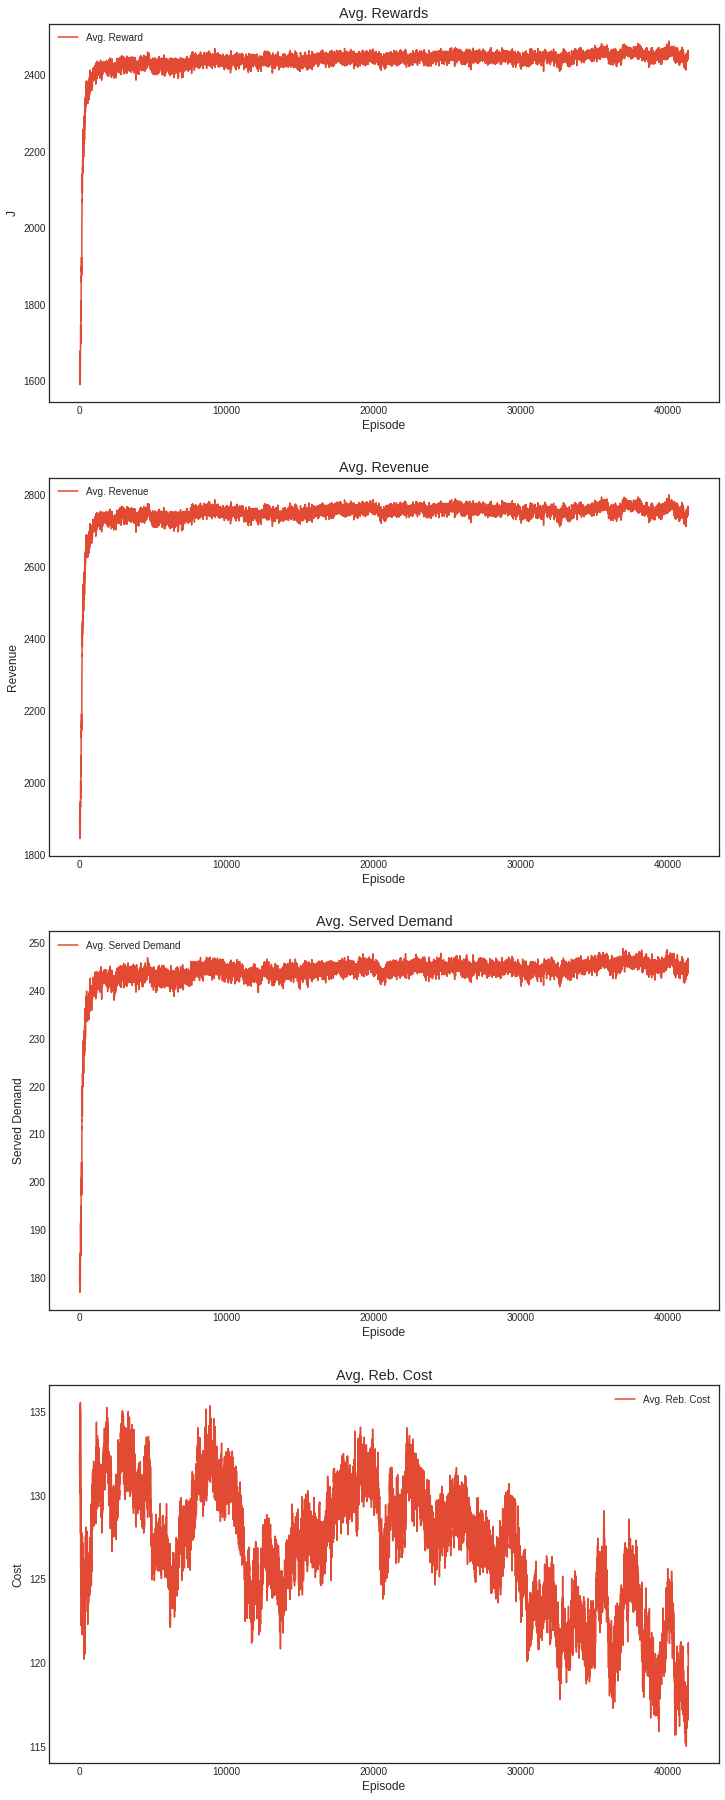

In [9]:
# Plot results with moving average smoothing 
plt.style.use("seaborn-white")
fig = plt.figure(figsize=(12,32))
fig.add_subplot(411)
plt.plot(moving_average(training_rewards, n=10), label="Avg. Reward")
plt.title("Avg. Rewards")
plt.xlabel("Episode")
plt.ylabel("J")
plt.legend()

fig.add_subplot(412)
plt.plot(moving_average(training_revenue, n=10), label="Avg. Revenue")
plt.title("Avg. Revenue")
plt.xlabel("Episode")
plt.ylabel("Revenue")
plt.legend()

fig.add_subplot(413)
plt.plot(moving_average(training_served_demand, n=10), label="Avg. Served Demand")
plt.title("Avg. Served Demand")
plt.xlabel("Episode")
plt.ylabel("Served Demand")
plt.legend()

fig.add_subplot(414)
plt.plot(moving_average(training_rebalancing_cost, n=10), label="Avg. Reb. Cost")
plt.title("Avg. Reb. Cost")
plt.xlabel("Episode")
plt.ylabel("Cost")
plt.legend()
plt.show()

### Test

In [13]:
# three levels
scenario = Scenario(sd=10,demand_input = {(1,6):2, (0,7):2, 'default':0.1}) # uni-directional
env = AMoD(scenario)

In [14]:
model.env = env

In [15]:
from tqdm import trange

test_episodes = 100
max_steps = 100
epochs = trange(test_episodes) # build tqdm iterator for loop visualization
np.random.seed(10)

test_rewards = []
test_revenue = []
test_served_demand = []
test_rebalancing_cost = []
test_operating_cost = []
action_list = []

for episode in epochs:
    try:
        episode_reward = 0
        episode_revenue = 0
        episode_served_demand = 0
        episode_rebalancing_cost = 0
        episode_operating_cost = 0
        episode_action_list = []
        obs = env.reset()
        done = False
        while(not done):
            # take matching step 
            obs, paxreward, done, info = env.pax_step(CPLEXPATH=CPLEXPATH, PATH="AC/v9/")
            episode_reward += paxreward
            # Select and perform an RL action
            x_ext = torch.tensor([obs[0][n][env.time] for n in env.region] + [env.dacc[n][env.time] for n in env.region] + \
                    [env.price[i,j][t] for t in range(env.time, env.time+1) for i,j in env.demand] + [env.time]).float()
            x_temp = torch.tensor([env.demand[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand]).view(1, 10, 56).float()
            state = (x_ext, x_temp)
            with torch.no_grad():
                action_rl = select_action(state)
            episode_action_list.append(action_rl)

            # 1.2 get actual vehicle distributions vi (i.e. (x1*x2*..*xn)*num_vehicles)
            v_d = model.get_desired_distribution(torch.tensor(action_rl))

            # 1.3 Solve ILP - Minimal Distance Problem 
            # 1.3.1 collect inputs and build .dat file
            t = env.time
            accTuple = [(n,int(env.acc[n][t])) for n in env.acc]
            accRLTuple = [(n, int(v_d_n)) for n, v_d_n in enumerate(v_d)]
            edgeAttr = [(i,j,env.G.edges[i,j]['time']) for i,j in env.G.edges]
            modPath = os.getcwd().replace('\\','/')+'/mod/'
            OPTPath = os.getcwd().replace('\\','/')+'/OPT/AC/v9/'
            if not os.path.exists(OPTPath):
                os.makedirs(OPTPath)
            datafile = OPTPath + f'data_{t}.dat'
            resfile = OPTPath + f'res_{t}.dat'
            with open(datafile,'w') as file:
                file.write('path="'+resfile+'";\r\n')
                file.write('edgeAttr='+mat2str(edgeAttr)+';\r\n')
                file.write('accInitTuple='+mat2str(accTuple)+';\r\n')
                file.write('accRLTuple='+mat2str(accRLTuple)+';\r\n')

            # 2. execute .mod file and write result on file
            modfile = modPath+'minRebDistRebOnly.mod'
            if CPLEXPATH is None:
                CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
            my_env = os.environ.copy()
            my_env["LD_LIBRARY_PATH"] = CPLEXPATH
            out_file =  OPTPath + f'out_{t}.dat'
            with open(out_file,'w') as output_f:
                subprocess.check_call([CPLEXPATH+"oplrun", modfile, datafile], stdout=output_f, env=my_env)
            output_f.close()

            # 3. collect results from file
            flow = defaultdict(float)
            with open(resfile,'r', encoding="utf8") as file:
                for row in file:
                    item = row.strip().strip(';').split('=')
                    if item[0] == 'flow':
                        values = item[1].strip(')]').strip('[(').split(')(')
                        for v in values:
                            if len(v) == 0:
                                continue
                            i,j,f = v.split(',')
                            flow[int(i),int(j)] = float(f)
            rebAction = [flow[i,j] for i,j in env.edges]

            new_obs, rebreward, done, info = env.reb_step(rebAction)
            episode_reward += rebreward
            x_ext = torch.tensor([new_obs[0][n][env.time] for n in env.region] + [env.dacc[n][env.time] for n in env.region] + \
                    [env.price[i,j][t] for t in range(env.time, env.time+1) for i,j in env.demand] + [env.time]).float()
            x_temp = torch.tensor([env.demand[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand]).view(1, 10, 56).float()
            new_state = (x_ext, x_temp)
            
            episode_served_demand += info['served_demand']
            episode_rebalancing_cost += info['rebalancing_cost']
            episode_operating_cost += info['operating_cost']
            episode_revenue += info['revenue']
        epochs.set_description(f"Episode {episode+1} | Reward: {episode_reward:.2f} | Revenue: {episode_revenue:.2f} | ServedDemand: {episode_served_demand:.2f} \
| Reb. Cost: {episode_rebalancing_cost} | Oper. Cost: {episode_operating_cost:.2f}")
        #Adding the total reward and reduced epsilon values
        test_rewards.append(episode_reward)
        test_revenue.append(episode_revenue)
        test_served_demand.append(episode_served_demand)
        test_rebalancing_cost.append(episode_rebalancing_cost)
        test_operating_cost.append(episode_operating_cost)
        action_list.append(episode_action_list)
        break
    except KeyboardInterrupt:
        break


  0%|          | 0/100 [00:00<?, ?it/s]
Episode 1 | Reward: 2444.40 | Revenue: 2742.00 | ServedDemand: 245.00 | Reb. Cost: 114.80000000000008 | Oper. Cost: 297.60:   0%|          | 0/100 [00:06<?, ?it/s]

In [16]:
action_list[0][9]

[0.4299153,
 0.5140839,
 0.010399105,
 0.009806298,
 1.9806863e-28,
 7.410576e-14,
 0.017746923,
 0.018048428]

In [33]:
env.demand

defaultdict(dict,
            {(0, 1): {0: 0,
              1: 0,
              2: 0,
              3: 0,
              4: 0,
              5: 0,
              6: 0,
              7: 0,
              8: 0,
              9: 0,
              10: 1,
              11: 0,
              12: 0,
              13: 0,
              14: 0,
              15: 0,
              16: 1,
              17: 0,
              18: 0,
              19: 0,
              20: 0,
              21: 0,
              22: 0,
              23: 0,
              24: 0,
              25: 0,
              26: 0,
              27: 0,
              28: 0,
              29: 1,
              30: 0,
              31: 0,
              32: 0,
              33: 0,
              34: 0,
              35: 0,
              36: 0,
              37: 0,
              38: 0,
              39: 0,
              40: 0,
              41: 0,
              42: 0,
              43: 0,
              44: 0,
              45: 0,
              46: 